In [1]:
from IPython.display import clear_output
from typing import List, Optional

import datetime
import functools
import gpflow as gpf
import hydra
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import palettable
import tensorflow as tf
import tensor_annotations.tensorflow as ttf
import tensorflow_probability as tfp

from gpflow import default_float, default_jitter
from gpflow.conditionals import uncertain_conditional, base_conditional
from matplotlib import cm
from numpy import random
from omegaconf import DictConfig
from simenvs import make

from modeopt.cost_functions import ControlQuadraticCostFunction, TargetStateCostFunction, StateDiffCostFunction, quadratic_cost_fn
from modeopt.controllers.utils import initialise_deterministic_trajectory, build_mode_variational_objective
from modeopt.controllers import TrajectoryOptimisationController
from modeopt.constraints import build_mode_chance_constraints_scipy
from modeopt.custom_types import Dataset
from modeopt.dynamics.conditionals import svgp_covariance_conditional
from modeopt.plotting import ModeOptContourPlotter
from modeopt.rollouts import rollout_controls_in_dynamics, rollout_controller_in_dynamics, rollout_controller_in_env, collect_data_from_env
from modeopt.trajectories import ControlTrajectoryDist
from modeopt.utils import model_from_DictConfig, combine_state_controls_to_input, append_zero_control
from modeopt.mode_opt import ModeOpt
from mogpe.keras.callbacks.tensorboard import PlotFn, TensorboardImageCallback
from mogpe.keras.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.keras.plotting import MixtureOfSVGPExpertsContourPlotter
from mogpe.keras.utils import sample_mosvgpe_inducing_inputs_from_data, model_from_yaml

%matplotlib inline

tfd = tfp.distributions

CMAP = palettable.scientific.sequential.Bilbao_15.mpl_colormap

meaning_of_life = 42
tf.random.set_seed(meaning_of_life)
np.random.seed(meaning_of_life)

## Initialise environment

In [2]:
env_name = "velocity-controlled-point-mass/scenario-7"

In [3]:
env = make(env_name)
state_dim = env.observation_spec().shape[0]
control_dim = env.action_spec().shape[0]

No constant_error found in toml config so using default : 0.0


## ModeOpt config

In [4]:
start_state = np.array([[-1.0, -2.0]])
target_state = np.array([[1.7, 3.0]])
mode_satisfaction_prob = 0.8

## Sample initial data set from desired mode

In [5]:
# num_initial_states = 130
# num_initial_states = 30

In [6]:
# def get_initial_states(start_state, target_state, width):
#     return random.uniform([start_state[0, 0]-width, start_state[0, 1]-width],
#                                    [start_state[0, 0]+width, start_state[0, 1]+width],
#                                     (num_initial_states, state_dim))

# def sample_env_at_states(states, num_actions=1, verbose=False):
#     delta_state_outputs = []
#     state_control_inputs = []
#     for state in states:
#         for i in range(num_actions):
#             action = np.random.uniform(env.action_spec().minimum, 
#                                        env.action_spec().maximum, 
#                                        (env.action_spec().shape[-1]))
#             delta_state = env.transition_dynamics(state, action)
#             delta_state_outputs.append(delta_state)
#             state_control_input = np.concatenate([state, action], -1)
#             state_control_inputs.append(state_control_input)
#     delta_state_outputs = np.stack(delta_state_outputs)
#     state_control_inputs = np.stack(state_control_inputs)
#     if verbose:
#         print("State control inputs: ", state_control_inputs.shape)
#         print("Delta state outputs: ", delta_state_outputs.shape)
#     return state_control_inputs, delta_state_outputs

# initial_states = get_initial_states(start_state, target_state, width=1.0)
# initial_dataset = sample_env_at_states(initial_states, verbose=True)
# dataset = initial_dataset

(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)


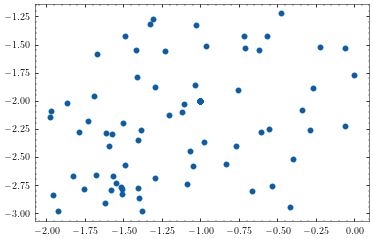

In [7]:
def sample_env_trajectories(horizon=15, num_trajectories=10):
    X, Y = [], []
    for i in range(num_trajectories):
        controls = np.random.uniform(
            env.action_spec().minimum,
            env.action_spec().maximum,
            (horizon, env.action_spec().shape[-1]),
        )
        X_, Y_ = collect_data_from_env(env, start_state=start_state, controls=controls)
        X.append(X_)
        Y.append(Y_)
    X = np.concatenate(X, 0)
    Y = np.concatenate(Y, 0)
    width = 1.0
    mask_1 = X[:, 0] > start_state[0, 0] - width
    mask_2 = X[:, 0] < start_state[0, 0] + width
    mask_3 = X[:, 1] > start_state[0, 1] - width
    mask_4 = X[:, 1] < start_state[0, 1] + width
    mask = mask_1 & mask_2 & mask_3 & mask_4
    X_trimmed = X[mask]
    Y_trimmed = Y[mask]
    print(X_trimmed.shape)
    print(Y_trimmed.shape)
    return (X_trimmed, Y_trimmed)

initial_dataset = sample_env_trajectories(horizon = 15, num_trajectories=50)
dataset = initial_dataset
plt.scatter(dataset[0][:, 0], dataset[0][:, 1])
plt.show()

## Train dynamics on initial data set or load from config

In [8]:
initial_num_epochs = 20000
# num_epochs = 300
num_epochs = 1500
# batch_size = 128
batch_size = initial_dataset[0].shape[0]
dynamics_logging_epoch_freq = 100

load_from_config = True
# load_from_config = False
yaml_cfg_filename = "./keras_configs/mode_opt_explore_scenario_7.yaml"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-29-18-14/ckpts"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-30-13-33/ckpts"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-30-14-22/ckpts"

In [9]:
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M') #  now
log_dir = os.path.join(f"./experiments/bald/explorative-prob-{mode_satisfaction_prob}", now_time)

In [10]:
if load_from_config:
    mode_optimiser = ModeOpt.load(load_ckpt_dir)
    mode_optimiser.log_dir = log_dir
else:
    mode_optimiser = model_from_yaml(yaml_cfg_filename, custom_objects={"ModeOpt": ModeOpt})
    mode_optimiser.dataset = (tf.constant(initial_dataset[0], dtype=default_float()),
                              tf.constant(initial_dataset[1], dtype=default_float())
                             )
    sample_mosvgpe_inducing_inputs_from_data(initial_dataset[0], mode_optimiser.dynamics.mosvgpe)
    mode_optimiser.dynamics_fit_kwargs.update({"epochs": initial_num_epochs, "batch_size": batch_size, "validation_split": 0.2})
#     dynamics_plotting_callbacks = build_contour_plotter_callbacks(mode_optimiser.dynamics.mosvgpe, logging_epoch_freq=dynamics_logging_epoch_freq, log_dir=mode_optimiser.log_dir)
#     mode_optimiser.add_dynamics_callbacks(dynamics_plotting_callbacks)
#     gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.inducing_variable, False)
    mode_optimiser.optimise_dynamics()
#     gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.kernel, False)

2022-04-08 14:27:23.109005: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


setting desired mode to 1
╒════════════════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════════════════════════════╕
│ name                                                           │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value                                    │
╞════════════════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════════════════════════════╡
│ IndependentPosteriorMultiOutput.kernel.kernels[0].variance     │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.4978003107997662                       │
├────────────────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ IndependentPosteriorMultiOutput.kerne

2022-04-08 14:27:23.480479: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 14:27:23.480498: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 14:27:23.480596: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Update the data set.

In [11]:
mode_optimiser.start_state = tf.constant(start_state, dtype=default_float())

Set the correct desired dynamics mode.

In [12]:
def which_desired_mode(mode_optimiser, initial_dataset):
    probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(initial_dataset[0])
    mean_probs = tf.reduce_mean(probs, 0)
    return int(tf.math.argmax(mean_probs))

desired_mode = which_desired_mode(mode_optimiser, initial_dataset)
print("Desired mode is {}".format(desired_mode))
mode_optimiser.desired_mode = desired_mode

Desired mode is 1


Save the learned dynamics model.

In [13]:
mode_optimiser.save()

## Configure the explorative controller

In [14]:
horizon = 10
max_iterations = 1000
keep_last_solution = True
method = "SLSQP"

In [15]:
terminal_state_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 100
state_diff_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 0.001
state_diff_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 0.01
state_diff_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 0.0005
control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 0.0005
# control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 1.0
state_diff_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 0.005

# terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, target_state=start_state)
terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, target_state=target_state)
control_cost_fn = ControlQuadraticCostFunction(weight_matrix=control_cost_matrix)
state_diff_cost_fn = StateDiffCostFunction(weight_matrix=state_diff_cost_matrix, target_state=target_state)

cost_fn = control_cost_fn + state_diff_cost_fn
cost_fn = state_diff_cost_fn
# cost_fn = control_cost_fn
# cost_fn = control_cost_fn + state_diff_cost_fn + terminal_cost_fn
# cost_fn = state_diff_cost_fn
# cost_fn = terminal_cost_fn + state_diff_cost_fn

In [16]:
def conditional_gating(state_means, control_means, state_vars, control_vars):
    h_means_prior, h_vars_prior = mode_optimiser.dynamics.uncertain_predict_gating(state_means, control_means)
    gating_gp = mode_optimiser.dynamics.desired_mode_gating_gp 

    input_means, input_vars = combine_state_controls_to_input(
        state_means, control_means, state_vars, control_vars
    )
    
    h_means, h_vars = h_means_prior[0:1, :], h_vars_prior[0:1, :]
    for t in range(1, horizon):
        Xnew = input_means[t:t+1, :]
        Xobs = tf.concat([input_means[:t, :], input_means[t+1:, :]], 0)
        f = tf.concat([h_means_prior[:t, :], h_means_prior[t+1:, :]], 0)

        Knn = svgp_covariance_conditional(X1=Xnew, X2=Xnew, svgp=gating_gp)[0, 0, :]
        Kmm = svgp_covariance_conditional(X1=Xobs, X2=Xobs, svgp=gating_gp)[0, :, :]
        Kmn = svgp_covariance_conditional(X1=Xobs, X2=Xnew, svgp=gating_gp)[0, :, :]
        Kmm += tf.eye(Kmm.shape[0], dtype=default_float()) * default_jitter()
        h_mean, h_var = base_conditional(
            Kmn=Kmn,
            Kmm=Kmm,
            Knn=Knn,
            f=f,
            full_cov=False,
            q_sqrt=None,
            white=False,
        )
        h_means = tf.concat([h_means, h_mean], 0)
        h_vars = tf.concat([h_vars, h_var], 0)
    return h_means, h_vars
    
def conditional_gating_temporal(state_means, control_means, state_vars, control_vars):
    h_means_prior, h_vars_prior = mode_optimiser.dynamics.uncertain_predict_gating(state_means, control_means)
    gating_gp = mode_optimiser.dynamics.desired_mode_gating_gp 

    input_means, input_vars = combine_state_controls_to_input(
        state_means, control_means, state_vars, control_vars
    )
    
    h_means, h_vars = h_means_prior[0:1, :], h_vars_prior[0:1, :]
    for t in range(1, horizon):
        Xnew = input_means[t:t+1, :]
        Xobs = input_means[0:t, :]
        f = h_means_prior[0:t, :]

        Knn = svgp_covariance_conditional(X1=Xnew, X2=Xnew, svgp=gating_gp)[0, 0, :]
        Kmm = svgp_covariance_conditional(X1=Xobs, X2=Xobs, svgp=gating_gp)[0, :, :]
        Kmn = svgp_covariance_conditional(X1=Xobs, X2=Xnew, svgp=gating_gp)[0, :, :]
        Kmm += tf.eye(Kmm.shape[0], dtype=default_float()) * default_jitter()
        h_mean, h_var = base_conditional(
            Kmn=Kmn,
            Kmm=Kmm,
            Knn=Knn,
            f=f,
            full_cov=False,
            q_sqrt=None,
            white=False,
        )
        h_means = tf.concat([h_means, h_mean], 0)
        h_vars = tf.concat([h_vars, h_var], 0)
    return h_means, h_vars

In [17]:
def binary_entropy(probs):
    return -probs * tf.math.log(probs) - (1 - probs) * tf.math.log(1 - probs)

def entropy_approx(h_means, h_vars, mode_probs):
    C = tf.constant(np.sqrt(math.pi * np.log(2.0) / 2.0), dtype=default_float())
    param_entropy = C * tf.exp(-(h_means ** 2) / (2 * (h_vars ** 2 + C ** 2)))
    param_entropy = param_entropy / (tf.sqrt(h_vars ** 2 + C ** 2))
    print("param_entropy")
    print(param_entropy)
    model_entropy = binary_entropy(mode_probs)
    print(model_entropy)
    return model_entropy - param_entropy

def explorative_objective(initial_solution: ControlTrajectoryDist) -> ttf.Tensor0:
    control_means = initial_solution(variance=False)
    control_vars = None
    state_means, state_vars = rollout_controls_in_dynamics(
        dynamics=mode_optimiser.dynamics,
        start_state=start_state,
        control_means=control_means,
        control_vars=control_vars,
    )
    
#     h_means, h_vars = mode_optimiser.dynamics.uncertain_predict_gating(state_means[1:, :], control_means)
    h_means, h_vars = conditional_gating_temporal(state_means[1:, :], control_means, state_vars[1:, :], control_vars)
    mode_probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs_given_h(h_means, h_vars)
    print("mode_probs.shape")
    print(mode_probs.shape)
    print(h_means.shape)
    print(h_vars.shape)
    bald_objective = entropy_approx(h_means[:, mode_optimiser.desired_mode], 
                                    h_vars[:, mode_optimiser.desired_mode], 
                                    mode_probs[:, mode_optimiser.desired_mode])
    print(bald_objective)
    tf.print('entropy')
    tf.print(-tf.reduce_sum(bald_objective))
    tf.print("cost")
    tf.print(cost_fn(state_means, control_means, state_vars, control_vars))
#     return -tf.reduce_sum(bald_objective)
    return -tf.reduce_sum(bald_objective) + cost_fn(state_means, control_means, state_vars, control_vars)

In [18]:
def find_initial_solution_in_desired_mode():
    fake_target_state_in_mode_idx = np.random.choice(np.arange(len(mode_optimiser.dataset[0])), size=1)
    fake_target_state_in_mode = mode_optimiser.dataset[0][fake_target_state_in_mode_idx[0], :state_dim]
    fake_target_state_in_mode = tf.constant([[0, -1]], dtype=default_float())
    
    terminal_state_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 100.0
    control_cost_matrix = tf.eye(control_dim, dtype=default_float())
    
    terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, 
                                               target_state=fake_target_state_in_mode)
    control_cost_fn = ControlQuadraticCostFunction(weight_matrix=control_cost_matrix)
    initial_cost_fn = terminal_cost_fn + control_cost_fn

    initial_solution = initialise_deterministic_trajectory(horizon, control_dim)
    objective_fn = build_mode_variational_objective(mode_optimiser.dynamics, initial_cost_fn, start_state)
    explorative_controller = TrajectoryOptimisationController(
        max_iterations=max_iterations,
        initial_solution=initial_solution,
        objective_fn=objective_fn,
        method=method,
    )
    explorative_controller.optimise()
    return explorative_controller.previous_solution

initial_solution_in_mode = find_initial_solution_in_desired_mode()

2022-04-08 14:27:24.063591: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Xnew.shape
(256, 10, 4)
gating_means.shape
(256, 10, 1)
input_mean.shape
(10, 4)
(10, 4)
var_exp: Tensor("Sum_148:0", shape=(10, 1), dtype=float64)
mode_var_exp: Tensor("Sum_149:0", shape=(), dtype=float64)


2022-04-08 14:27:39.915055: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Optimisation result:
     fun: array([50.49735148])
     jac: array([-1.02884371e-03,  7.32675473e-04,  9.05697578e-05,  5.56208551e-04,
       -4.94539437e-04,  4.11424055e-04, -7.50597138e-04,  5.23525688e-04,
       -4.57112282e-04,  5.32463426e-04, -4.87033029e-04,  5.31078428e-04,
       -7.55084942e-04,  4.92042858e-04, -7.96183399e-04,  3.48068009e-04,
       -4.78799965e-04,  2.94068083e-04, -2.80440816e-04,  5.55966403e-04])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([-0.083316  ,  2.18566685,  0.01889467,  2.01311375,  0.09422733,
        1.89732075,  0.15880423,  1.82486298,  0.22288449,  1.78602404,
        0.29405799,  1.77495397,  0.37992526,  1.78933631,  0.48918454,
        1.83089981,  0.63282744,  1.90700635,  0.82485168,  2.03329487])


In [19]:
mode_chance_constraints = build_mode_chance_constraints_scipy(mode_optimiser.dynamics, 
                                                              start_state, 
                                                              horizon, 
                                                              control_dim=control_dim,
                                                              lower_bound=mode_satisfaction_prob)
explorative_controller = TrajectoryOptimisationController(
    max_iterations=max_iterations,
    initial_solution=initial_solution_in_mode,
    objective_fn=explorative_objective,
    keep_last_solution=keep_last_solution,
    constraints=[mode_chance_constraints],
    method=method,
)
mode_optimiser.explorative_controller = explorative_controller

## Configure plotter

In [20]:
def create_test_inputs(x_min=[-3, -3], x_max=[3, 3], input_dim=4, num_test: int = 1600, factor: float = 1.2):
    sqrtN = int(np.sqrt(num_test))
    xx = np.linspace(x_min[0] * factor, x_max[0] * factor, sqrtN)
    yy = np.linspace(x_min[1] * factor, x_max[1] * factor, sqrtN)
    xx, yy = np.meshgrid(xx, yy)
    test_inputs = np.column_stack([xx.reshape(-1), yy.reshape(-1)])
    if input_dim > 2:
        zeros = np.zeros((num_test, input_dim - 2))
        test_inputs = np.concatenate([test_inputs, zeros], -1)
    return test_inputs, xx, yy

test_inputs, xx, yy = create_test_inputs()
plotter = ModeOptContourPlotter(mode_optimiser, test_inputs=test_inputs, static=False, explorative=True)

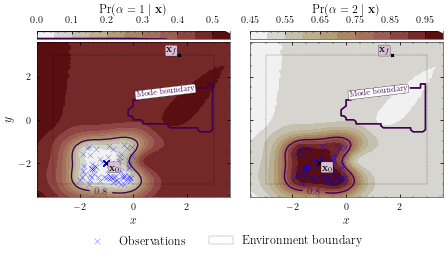

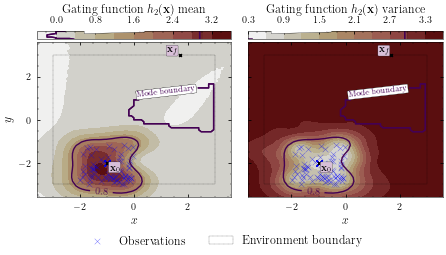

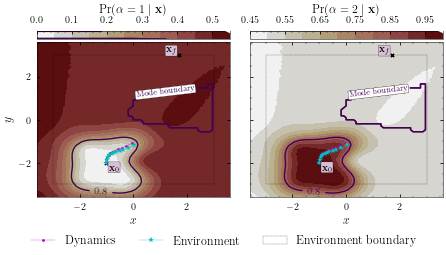

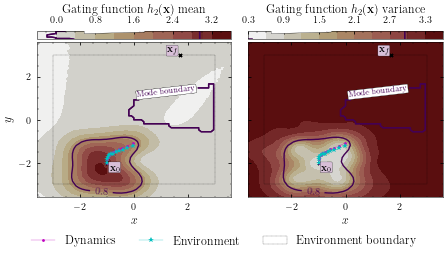

In [21]:
image_save_dir = os.path.join(mode_optimiser.log_dir, "images")
try:
    os.makedirs(image_save_dir)
except FileExistsError:
    pass

def plot_data_over_gating_network_and_save(step: int, epoch: int, save: bool = True):
    plotter.plot_data_over_mixing_probs()
    if save:
        save_filename = os.path.join(image_save_dir, "data_over_mixing_probs_step_{}_epoch_{}.pdf".format(step, epoch))
        plt.savefig(save_filename, transparent=True)
    
    plotter.plot_data_over_desired_gating_network_gp()
    if save:
        save_filename = os.path.join(image_save_dir, "data_over_desired_gating_gp_step_{}_epoch_{}.pdf".format(step, epoch))
        plt.savefig(save_filename, transparent=True)

def plot_trajectories_over_gating_network_and_save(step: int, save: bool = True):
    plotter.plot_trajectories_over_mixing_probs()
    if save:
        save_filename = os.path.join(image_save_dir, "trajectories_over_mixing_probs_step_{}.pdf".format(step))
        plt.savefig(save_filename, transparent=True)
    
    plotter.plot_trajectories_over_desired_gating_network_gp()
    if save:
        save_filename = os.path.join(image_save_dir, "trajectories_over_desired_gating_gp_step_{}.pdf".format(step))
        plt.savefig(save_filename, transparent=True)

plot_data_over_gating_network_and_save(step=0, epoch=0)
plot_trajectories_over_gating_network_and_save(step=0)

## Configure ModeOpt and callbacks

In [22]:
# mode_optimiser.dataset = (mode_optimiser.dataset[0][:130, :], mode_optimiser.dataset[1][:130, :])

In [23]:
# logging_epoch_freq = 60
num_epochs = 10000
logging_epoch_freq = math.floor((num_epochs)/5)
save_epoch_freq = math.floor((num_epochs)/5)
num_steps = 35
dataset = initial_dataset
# batch_size = 128
batch_size = mode_optimiser.dataset[0].shape[0]

mode_optimiser.dynamics_fit_kwargs.update({"epochs": num_epochs, "batch_size": batch_size, "validation_split": 0.2})
mode_optimiser.dynamics_fit_kwargs

{'epochs': 10000, 'batch_size': 125, 'validation_split': 0.2}

Callbacks for dynamics learning.

In [24]:
class PlottingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % logging_epoch_freq == 0:
            plot_data_over_gating_network_and_save(step=step, epoch=epoch)

class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % save_epoch_freq == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(os.path.join(mode_optimiser.ckpt_dir, "step_{}_epoch_{}".format(step, epoch)), save_format="tf")
            
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=500,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
callbacks = [PlottingCallback(),
             CustomSaver(),
             early_stopping_cb,
#              tf.keras.callbacks.ModelCheckpoint(
#                  filepath=os.path.join(save_dir + "ckpts/ModeOptDynamics"),
#                  monitor="loss",
#                  save_format="tf",
#                  save_best_only=False,
#                  save_freq=500),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir)
            ]

2022-04-08 14:28:29.749783: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 14:28:29.749809: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 14:28:29.749858: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [25]:
mode_optimiser.dynamics(dataset[0]) # call ModeOptDynamics to build it for saving
mode_optimiser.dynamics_callbacks = []
mode_optimiser.add_dynamics_callbacks(callbacks)

In [26]:
# gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.kernel, False)
# gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.experts_list[desired_mode].gp.kernel, False)

mode_probs.shape
(10, 2)
(10, 2)
(10, 2)
param_entropy
Tensor("truediv_302:0", shape=(10,), dtype=float64)
Tensor("sub_342:0", shape=(10,), dtype=float64)
Tensor("sub_343:0", shape=(10,), dtype=float64)
entropy
0.22841251847165067
cost
1.2773800588208568
entropy
0.17113191100545591
cost
1.2713285612107792
entropy
0.12144210578199767
cost
1.2972580557569848
entropy
0.030380741751572897
cost
1.3646914531267198
entropy
0.017939293225902316
cost
1.3649686317221594
entropy
0.063659638526742973
cost
1.3176352883923343
entropy
0.03963289610642344
cost
1.3400322732322962
entropy
0.04109513700767959
cost
1.3289077983466224
entropy
0.11563511074414823
cost
1.248023373785923
entropy
0.069115473052825283
cost
1.2838643429914283
entropy
0.21748040750972256
cost
1.1627562022666775
entropy
0.12699454275094166
cost
1.2345649673920946
entropy
0.084381023341867936
cost
1.2623699583026453
entropy
0.20415038528053597
cost
1.1788052590413962
entropy
0.13019436435497314
cost
1.2315238230512993
entropy
0.094

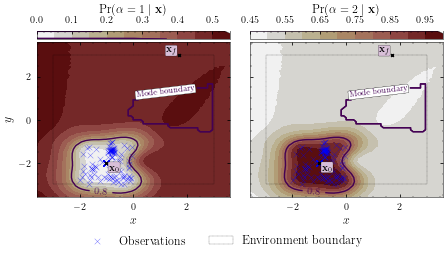

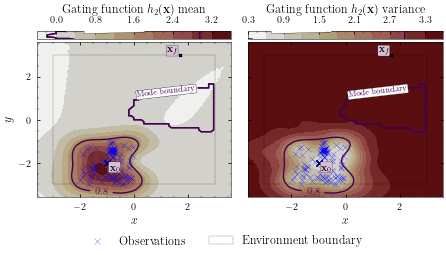

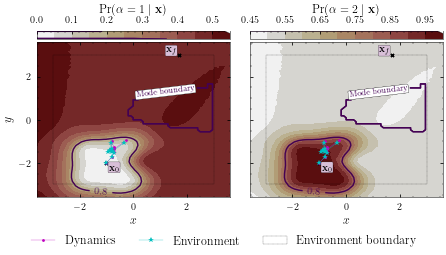

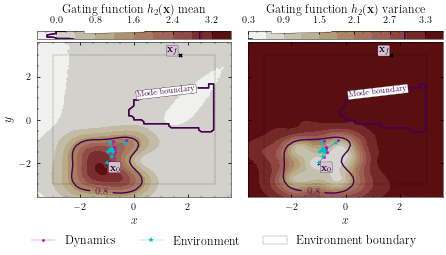

Epoch 1/10000
Mixing probs: (1, None, 2)
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Experts probs: (None, None, 2)
Mixing probs: (1, None, 2)
Experts probs: (None, None, 2)
1/1 [==============================] - ETA: 0s - loss: -579.0078Mixing probs: (1, None, 2)
Experts probs: (None, None, 2)
1/1 [==============================] - 21s 21s/step - loss: -579.0078 - val_loss: -620.9437
Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_1_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -451.6014

2022-04-08 14:31:23.074409: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 14:31:23.074430: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 14:31:23.116501: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 14:31:23.177567: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 14:31:23.208903: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_31_23

2022-04-08 14:31:23.228489: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_31_23/dr-robots-mbp.local.trace.json.gz


1/1 [==============================] - 0s 299ms/step - loss: -451.6014 - val_loss: -610.7403
Epoch 3/10000
1/1 [==============================] - 0s 54ms/step - loss: -559.4091 - val_loss: -611.3331
Epoch 4/10000
1/1 [==============================] - 0s 54ms/step - loss: -574.6031 - val_loss: -599.8466


2022-04-08 14:31:23.301436: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_31_23

2022-04-08 14:31:23.302657: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_31_23/dr-robots-mbp.local.memory_profile.json.gz
2022-04-08 14:31:23.317127: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_31_23
Dumped tool data for xplane.pb to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_31_23/dr-robots-mbp.local.xplane.pb
Dumped tool data for overview_page.pb to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_31_

Epoch 5/10000
1/1 [==============================] - 0s 50ms/step - loss: -560.1130 - val_loss: -622.6842
Epoch 6/10000
1/1 [==============================] - 0s 60ms/step - loss: -557.3399 - val_loss: -582.5152
Epoch 7/10000
1/1 [==============================] - 0s 50ms/step - loss: -520.4121 - val_loss: -584.6677
Epoch 8/10000
1/1 [==============================] - 0s 43ms/step - loss: -569.5052 - val_loss: -664.4620
Epoch 9/10000
1/1 [==============================] - 0s 46ms/step - loss: -591.8910 - val_loss: -652.7250
Epoch 10/10000
1/1 [==============================] - 0s 55ms/step - loss: -583.5701 - val_loss: -666.5454
Epoch 11/10000
1/1 [==============================] - 0s 49ms/step - loss: -550.1008 - val_loss: -670.7336
Epoch 12/10000
1/1 [==============================] - 0s 56ms/step - loss: -551.8353 - val_loss: -526.2798
Epoch 13/10000
1/1 [==============================] - 0s 53ms/step - loss: -580.8048 - val_loss: -608.1922
Epoch 14/10000
1/1 [======================

1/1 [==============================] - 0s 43ms/step - loss: -642.0022 - val_loss: -699.8936
Epoch 82/10000
1/1 [==============================] - 0s 43ms/step - loss: -637.9908 - val_loss: -671.0135
Epoch 83/10000
1/1 [==============================] - 0s 44ms/step - loss: -606.5717 - val_loss: -774.4970
Epoch 84/10000
1/1 [==============================] - 0s 44ms/step - loss: -668.9969 - val_loss: -781.5575
Epoch 85/10000
1/1 [==============================] - 0s 43ms/step - loss: -633.0525 - val_loss: -716.2040
Epoch 86/10000
1/1 [==============================] - 0s 48ms/step - loss: -501.9419 - val_loss: -661.0859
Epoch 87/10000
1/1 [==============================] - 0s 49ms/step - loss: -589.1688 - val_loss: -670.8292
Epoch 88/10000
1/1 [==============================] - 0s 42ms/step - loss: -638.1219 - val_loss: -723.2404
Epoch 89/10000
1/1 [==============================] - 0s 41ms/step - loss: -379.5327 - val_loss: -741.8916
Epoch 90/10000
1/1 [==============================] 

1/1 [==============================] - 0s 37ms/step - loss: -398.9409 - val_loss: -478.4009
Epoch 158/10000
1/1 [==============================] - 0s 35ms/step - loss: -98.1081 - val_loss: -65.8757
Epoch 159/10000
1/1 [==============================] - 0s 36ms/step - loss: -499.8346 - val_loss: -546.1289
Epoch 160/10000
1/1 [==============================] - 0s 36ms/step - loss: 352.0178 - val_loss: 317.0683
Epoch 161/10000
1/1 [==============================] - 0s 35ms/step - loss: -407.1105 - val_loss: -506.3431
Epoch 162/10000
1/1 [==============================] - 0s 36ms/step - loss: -431.8228 - val_loss: -545.0539
Epoch 163/10000
1/1 [==============================] - 0s 36ms/step - loss: 91.1917 - val_loss: 206.3416
Epoch 164/10000
1/1 [==============================] - 0s 37ms/step - loss: -463.2775 - val_loss: -490.7891
Epoch 165/10000
1/1 [==============================] - 0s 36ms/step - loss: -421.5895 - val_loss: -535.0235
Epoch 166/10000
1/1 [==============================

1/1 [==============================] - 0s 36ms/step - loss: -494.7738 - val_loss: -485.1026
Epoch 234/10000
1/1 [==============================] - 0s 36ms/step - loss: -442.4317 - val_loss: -384.2549
Epoch 235/10000
1/1 [==============================] - 0s 36ms/step - loss: -506.8242 - val_loss: -573.9974
Epoch 236/10000
1/1 [==============================] - 0s 36ms/step - loss: -466.9424 - val_loss: -507.0824
Epoch 237/10000
1/1 [==============================] - 0s 38ms/step - loss: -433.0640 - val_loss: -395.9762
Epoch 238/10000
1/1 [==============================] - 0s 37ms/step - loss: -541.8913 - val_loss: -592.4790
Epoch 239/10000
1/1 [==============================] - 0s 37ms/step - loss: -506.3584 - val_loss: -577.2446
Epoch 240/10000
1/1 [==============================] - 0s 37ms/step - loss: -523.2169 - val_loss: -563.6005
Epoch 241/10000
1/1 [==============================] - 0s 36ms/step - loss: -454.0781 - val_loss: -447.1507
Epoch 242/10000
1/1 [=======================

1/1 [==============================] - 0s 41ms/step - loss: -482.9415 - val_loss: -555.2800
Epoch 310/10000
1/1 [==============================] - 0s 39ms/step - loss: -453.8399 - val_loss: -377.8388
Epoch 311/10000
1/1 [==============================] - 0s 42ms/step - loss: 367.2386 - val_loss: -48.1204
Epoch 312/10000
1/1 [==============================] - 0s 40ms/step - loss: -227.5885 - val_loss: -427.6639
Epoch 313/10000
1/1 [==============================] - 0s 39ms/step - loss: 261.9991 - val_loss: -465.8508
Epoch 314/10000
1/1 [==============================] - 0s 42ms/step - loss: -121.5188 - val_loss: -341.5123
Epoch 315/10000
1/1 [==============================] - 0s 39ms/step - loss: -477.4111 - val_loss: -437.4547
Epoch 316/10000
1/1 [==============================] - 0s 41ms/step - loss: -219.9643 - val_loss: -417.1112
Epoch 317/10000
1/1 [==============================] - 0s 40ms/step - loss: -353.0695 - val_loss: -345.1060
Epoch 318/10000
1/1 [==========================

1/1 [==============================] - 0s 38ms/step - loss: -566.3902 - val_loss: -528.8956
Epoch 386/10000
1/1 [==============================] - 0s 38ms/step - loss: -578.5831 - val_loss: -567.8981
Epoch 387/10000
1/1 [==============================] - 0s 38ms/step - loss: -546.6801 - val_loss: -618.2679
Epoch 388/10000
1/1 [==============================] - 0s 36ms/step - loss: -481.3093 - val_loss: -336.1996
Epoch 389/10000
1/1 [==============================] - 0s 37ms/step - loss: -554.0303 - val_loss: -574.7388
Epoch 390/10000
1/1 [==============================] - 0s 37ms/step - loss: -575.3357 - val_loss: -635.0975
Epoch 391/10000
1/1 [==============================] - 0s 37ms/step - loss: -592.8435 - val_loss: -628.1567
Epoch 392/10000
1/1 [==============================] - 0s 37ms/step - loss: -477.9773 - val_loss: -455.8339
Epoch 393/10000
1/1 [==============================] - 0s 38ms/step - loss: -561.2226 - val_loss: -615.6927
Epoch 394/10000
1/1 [=======================

Epoch 461/10000
1/1 [==============================] - 0s 37ms/step - loss: -121.0618 - val_loss: -432.9871
Epoch 462/10000
1/1 [==============================] - 0s 37ms/step - loss: -467.0944 - val_loss: -523.1337
Epoch 463/10000
1/1 [==============================] - 0s 37ms/step - loss: -354.4253 - val_loss: -412.5378
Epoch 464/10000
1/1 [==============================] - 0s 37ms/step - loss: -494.6380 - val_loss: -559.6810
Epoch 465/10000
1/1 [==============================] - 0s 37ms/step - loss: -447.0912 - val_loss: -451.7488
Epoch 466/10000
1/1 [==============================] - 0s 37ms/step - loss: -375.2106 - val_loss: -429.8954
Epoch 467/10000
1/1 [==============================] - 0s 37ms/step - loss: -350.9555 - val_loss: -198.1663
Epoch 468/10000
1/1 [==============================] - 0s 38ms/step - loss: -199.9722 - val_loss: -336.3315
Epoch 469/10000
1/1 [==============================] - 0s 37ms/step - loss: -433.0405 - val_loss: -485.5593
Epoch 470/10000
1/1 [=======

Epoch 537/10000
1/1 [==============================] - 0s 37ms/step - loss: -580.1741 - val_loss: -619.3223
Epoch 538/10000
1/1 [==============================] - 0s 37ms/step - loss: -477.8233 - val_loss: -609.0501
Epoch 539/10000
1/1 [==============================] - 0s 37ms/step - loss: -550.5584 - val_loss: -638.1885
Epoch 540/10000
1/1 [==============================] - 0s 37ms/step - loss: -564.0919 - val_loss: -588.5827
Epoch 541/10000
1/1 [==============================] - 0s 37ms/step - loss: -537.7896 - val_loss: -540.1740
Epoch 542/10000
1/1 [==============================] - 0s 37ms/step - loss: -513.9137 - val_loss: -539.0143
Epoch 543/10000
1/1 [==============================] - 0s 37ms/step - loss: -495.9776 - val_loss: -580.4033
Epoch 544/10000
1/1 [==============================] - 0s 37ms/step - loss: -576.4950 - val_loss: -645.5774
Epoch 545/10000
1/1 [==============================] - 0s 38ms/step - loss: -537.4208 - val_loss: -596.1368
Epoch 546/10000
1/1 [=======

cost
1.188444344210009
entropy
-0.027663098095046877
cost
1.1879475987597032
entropy
-0.028823284835882777
cost
1.1883085170991814
entropy
-0.029091545503426221
cost
1.1885056177574187
entropy
-0.029864337857767626
cost
1.1892862753259965
entropy
-0.029526488563820528
cost
1.1888827273314626
entropy
-0.030345320965625845
cost
1.1896645078522865
entropy
-0.030177394131495103
cost
1.1894132246859235
entropy
-0.030187745404283393
cost
1.1893649362879646
entropy
-0.030176504811269218
cost
1.1893021897730174
entropy
-0.029933547175050833
cost
1.1890285521247634
entropy
-0.029885742030859364
cost
1.1889706492979604
entropy
-0.029791693696653181
cost
1.1888467846311777
entropy
-0.029779448347512498
cost
1.1887915465809407
entropy
-0.029855615634728695
cost
1.1888218976224896
entropy
-0.029931730740364086
cost
1.1888697003223834
entropy
-0.029926532525817152
cost
1.1888477486257067
entropy
-0.029822625484070657
cost
1.1887267475820675
entropy
-0.029535149483270334
cost
1.188413913529611
entrop

entropy
-2.1655474320109938
cost
1.4938725066860872
entropy
-2.1789868147868194
cost
1.4995583129365464
entropy
-2.1878102542089577
cost
1.502263817543402
entropy
-2.1938304842858667
cost
1.4999763213812085
entropy
-2.1958179281263766
cost
1.4824683462531933
entropy
-2.1871563987283928
cost
1.4642881384620607
entropy
-2.1980181960403242
cost
1.4660186932189663
entropy
-2.2019500016893248
cost
1.4629609710750928
entropy
-2.2328235822270712
cost
1.4861684349226707
entropy
-2.238705132077015
cost
1.4912098388127659
entropy
-2.2421811547865462
cost
1.4928723316408
entropy
-2.2748712026700817
cost
1.5065588390559623
entropy
-2.2606033651936217
cost
1.4983090137766191
entropy
-2.2720629337910863
cost
1.5042505814295848
entropy
-2.2597227462808074
cost
1.4898681489335361
entropy
-2.2686054322264133
cost
1.4962896042849287
entropy
-2.2690850678887275
cost
1.4956144455084412
entropy
-2.2640329925575822
cost
1.4889589122943978
entropy
-2.2668418406723685
cost
1.4902824025130832
entropy
-2.271026

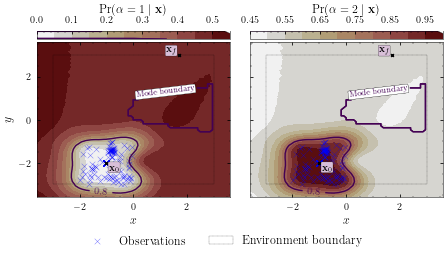

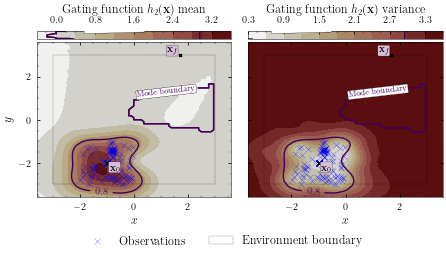

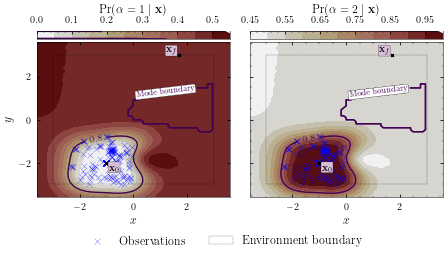

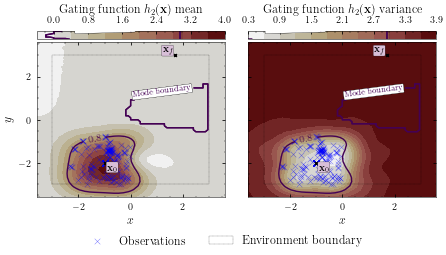

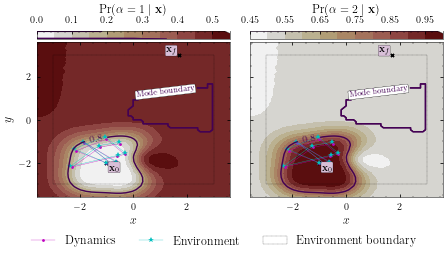

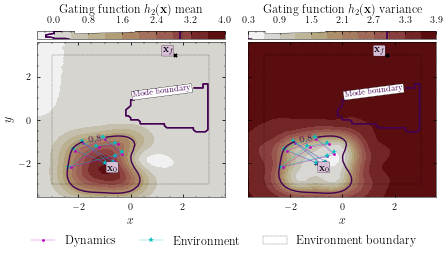

Epoch 1/10000
1/1 [==============================] - 1s 987ms/step - loss: -602.1997 - val_loss: -517.1190
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_2_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -558.1861

2022-04-08 14:35:48.299061: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 14:35:48.299081: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 3s 3s/step - loss: -558.1861 - val_loss: -203.1423
Epoch 3/10000
1/1 [==============================] - 0s 49ms/step - loss: -349.3655 - val_loss: -41.5260
Epoch 4/10000
1/1 [==============================] - ETA: 0s - loss: -538.7875

2022-04-08 14:35:51.105194: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 14:35:51.120922: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 14:35:51.131369: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_35_51

2022-04-08 14:35:51.139606: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_35_51/dr-robots-mbp.local.trace.json.gz
2022-04-08 14:35:51.172908: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_35_51

2022-04-08 14:35:51.173306: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

1/1 [==============================] - 0s 44ms/step - loss: -538.7875 - val_loss: -364.5072
Epoch 5/10000
1/1 [==============================] - 0s 44ms/step - loss: -415.9820 - val_loss: -316.4399
Epoch 6/10000
1/1 [==============================] - 0s 46ms/step - loss: -473.4868 - val_loss: -377.7027
Epoch 7/10000
1/1 [==============================] - 0s 48ms/step - loss: -248.3871 - val_loss: -218.2557
Epoch 8/10000
1/1 [==============================] - 0s 47ms/step - loss: -454.8582 - val_loss: -347.6353
Epoch 9/10000
1/1 [==============================] - 0s 44ms/step - loss: -340.3952 - val_loss: -215.4619
Epoch 10/10000
1/1 [==============================] - 0s 44ms/step - loss: -544.1587 - val_loss: -294.4277
Epoch 11/10000
1/1 [==============================] - 0s 45ms/step - loss: -568.8882 - val_loss: -412.7448
Epoch 12/10000
1/1 [==============================] - 0s 50ms/step - loss: -471.0109 - val_loss: -432.9579
Epoch 13/10000
1/1 [==============================] - 0s 

Epoch 81/10000
1/1 [==============================] - 0s 43ms/step - loss: -620.3239 - val_loss: -358.1431
Epoch 82/10000
1/1 [==============================] - 0s 42ms/step - loss: -541.8389 - val_loss: -281.5611
Epoch 83/10000
1/1 [==============================] - 0s 44ms/step - loss: -496.6590 - val_loss: -234.5725
Epoch 84/10000
1/1 [==============================] - 0s 43ms/step - loss: -524.6375 - val_loss: -305.1635
Epoch 85/10000
1/1 [==============================] - 0s 43ms/step - loss: -40.3164 - val_loss: -28.8591
Epoch 86/10000
1/1 [==============================] - 0s 43ms/step - loss: -352.1156 - val_loss: -218.8105
Epoch 87/10000
1/1 [==============================] - 0s 43ms/step - loss: -286.4732 - val_loss: -268.1073
Epoch 88/10000
1/1 [==============================] - 0s 43ms/step - loss: -365.8231 - val_loss: -358.6076
Epoch 89/10000
1/1 [==============================] - 0s 44ms/step - loss: -316.2170 - val_loss: -115.6335
Epoch 90/10000
1/1 [===================

1/1 [==============================] - 0s 41ms/step - loss: -238.7678 - val_loss: -120.3785
Epoch 158/10000
1/1 [==============================] - 0s 43ms/step - loss: -326.6716 - val_loss: -367.6271
Epoch 159/10000
1/1 [==============================] - 0s 42ms/step - loss: -444.3919 - val_loss: -105.5849
Epoch 160/10000
1/1 [==============================] - 0s 42ms/step - loss: -556.1677 - val_loss: -375.9022
Epoch 161/10000
1/1 [==============================] - 0s 43ms/step - loss: -577.4309 - val_loss: -446.0073
Epoch 162/10000
1/1 [==============================] - 0s 44ms/step - loss: -599.9554 - val_loss: -340.3312
Epoch 163/10000
1/1 [==============================] - 0s 43ms/step - loss: -472.5127 - val_loss: -355.7246
Epoch 164/10000
1/1 [==============================] - 0s 43ms/step - loss: -448.2164 - val_loss: -355.0481
Epoch 165/10000
1/1 [==============================] - 0s 43ms/step - loss: -483.3232 - val_loss: -266.5112
Epoch 166/10000
1/1 [=======================

1/1 [==============================] - 0s 39ms/step - loss: -506.9878 - val_loss: -130.0483
Epoch 234/10000
1/1 [==============================] - 0s 40ms/step - loss: -569.1440 - val_loss: -262.5883
Epoch 235/10000
1/1 [==============================] - 0s 40ms/step - loss: -598.2937 - val_loss: -471.3524
Epoch 236/10000
1/1 [==============================] - 0s 39ms/step - loss: -568.2556 - val_loss: -454.9198
Epoch 237/10000
1/1 [==============================] - 0s 40ms/step - loss: -575.2042 - val_loss: -244.8989
Epoch 238/10000
1/1 [==============================] - 0s 40ms/step - loss: -572.2713 - val_loss: -424.4647
Epoch 239/10000
1/1 [==============================] - 0s 39ms/step - loss: -610.4720 - val_loss: -303.0648
Epoch 240/10000
1/1 [==============================] - 0s 39ms/step - loss: -558.9093 - val_loss: -298.3443
Epoch 241/10000
1/1 [==============================] - 0s 39ms/step - loss: -632.3948 - val_loss: -358.3578
Epoch 242/10000
1/1 [=======================

1/1 [==============================] - 0s 42ms/step - loss: -479.0437 - val_loss: -267.5378
Epoch 310/10000
1/1 [==============================] - 0s 44ms/step - loss: -558.8866 - val_loss: -298.6732
Epoch 311/10000
1/1 [==============================] - 0s 43ms/step - loss: -231.0523 - val_loss: -34.2777
Epoch 312/10000
1/1 [==============================] - 0s 42ms/step - loss: -476.8858 - val_loss: -456.1241
Epoch 313/10000
1/1 [==============================] - 0s 40ms/step - loss: -485.2294 - val_loss: -348.3281
Epoch 314/10000
1/1 [==============================] - 0s 41ms/step - loss: -371.1986 - val_loss: -226.7041
Epoch 315/10000
1/1 [==============================] - 0s 41ms/step - loss: -177.9089 - val_loss: -124.5931
Epoch 316/10000
1/1 [==============================] - 0s 44ms/step - loss: -453.6124 - val_loss: -375.6385
Epoch 317/10000
1/1 [==============================] - 0s 44ms/step - loss: -171.2986 - val_loss: -214.0003
Epoch 318/10000
1/1 [========================

1/1 [==============================] - 0s 39ms/step - loss: -560.2303 - val_loss: -352.9590
Epoch 386/10000
1/1 [==============================] - 0s 38ms/step - loss: -539.0671 - val_loss: -462.3525
Epoch 387/10000
1/1 [==============================] - 0s 38ms/step - loss: -435.7990 - val_loss: -184.5274
Epoch 388/10000
1/1 [==============================] - 0s 38ms/step - loss: -554.8660 - val_loss: -466.5491
Epoch 389/10000
1/1 [==============================] - 0s 38ms/step - loss: -570.2164 - val_loss: -321.1099
Epoch 390/10000
1/1 [==============================] - 0s 39ms/step - loss: -554.9596 - val_loss: -271.9714
Epoch 391/10000
1/1 [==============================] - 0s 37ms/step - loss: -545.0392 - val_loss: -200.9431
Epoch 392/10000
1/1 [==============================] - 0s 38ms/step - loss: -570.2607 - val_loss: -365.9407
Epoch 393/10000
1/1 [==============================] - 0s 37ms/step - loss: -537.4424 - val_loss: -369.6072
Epoch 394/10000
1/1 [=======================

1/1 [==============================] - 0s 36ms/step - loss: -671.3539 - val_loss: -543.4844
Epoch 462/10000
1/1 [==============================] - 0s 36ms/step - loss: -684.7596 - val_loss: -137.8742
Epoch 463/10000
1/1 [==============================] - 0s 34ms/step - loss: -670.2214 - val_loss: -570.8762
Epoch 464/10000
1/1 [==============================] - 0s 35ms/step - loss: -645.1599 - val_loss: -352.6562
Epoch 465/10000
1/1 [==============================] - 0s 35ms/step - loss: -702.5162 - val_loss: -489.9065
Epoch 466/10000
1/1 [==============================] - 0s 35ms/step - loss: -622.2276 - val_loss: -350.4573
Epoch 467/10000
1/1 [==============================] - 0s 35ms/step - loss: -668.6551 - val_loss: -379.8152
Epoch 468/10000
1/1 [==============================] - 0s 35ms/step - loss: -557.1471 - val_loss: -129.5006
Epoch 469/10000
1/1 [==============================] - 0s 35ms/step - loss: -624.6480 - val_loss: -127.6581
Epoch 470/10000
1/1 [=======================

1/1 [==============================] - 0s 34ms/step - loss: -264.5599 - val_loss: -74.6574
Epoch 538/10000
1/1 [==============================] - 0s 34ms/step - loss: -546.1151 - val_loss: -361.5072
Epoch 539/10000
1/1 [==============================] - 0s 33ms/step - loss: -389.6906 - val_loss: -362.5135
Epoch 540/10000
1/1 [==============================] - 0s 35ms/step - loss: -407.6672 - val_loss: -318.6610
Epoch 541/10000
1/1 [==============================] - 0s 35ms/step - loss: -546.4776 - val_loss: -364.1550
Epoch 542/10000
1/1 [==============================] - 0s 34ms/step - loss: -567.4149 - val_loss: -385.1347
Epoch 543/10000
1/1 [==============================] - 0s 34ms/step - loss: -484.3084 - val_loss: -357.8970
Epoch 544/10000
1/1 [==============================] - 0s 34ms/step - loss: -567.4839 - val_loss: -396.9611
Epoch 545/10000
1/1 [==============================] - 0s 34ms/step - loss: -473.5911 - val_loss: -319.0096
Epoch 546/10000
1/1 [========================

1/1 [==============================] - 0s 35ms/step - loss: -610.3480 - val_loss: -316.9064
Epoch 614/10000
1/1 [==============================] - 0s 37ms/step - loss: -580.9587 - val_loss: -321.3177
Epoch 615/10000
1/1 [==============================] - 0s 36ms/step - loss: -602.6753 - val_loss: -340.3984
Epoch 616/10000
1/1 [==============================] - 0s 36ms/step - loss: -533.6733 - val_loss: -400.8268
Epoch 617/10000
1/1 [==============================] - 0s 36ms/step - loss: -600.5018 - val_loss: -514.5855
Epoch 618/10000
1/1 [==============================] - 0s 37ms/step - loss: -587.9936 - val_loss: -340.1054
Epoch 619/10000
1/1 [==============================] - 0s 37ms/step - loss: -579.5460 - val_loss: -389.4081
Epoch 620/10000
1/1 [==============================] - 0s 36ms/step - loss: -575.1393 - val_loss: -315.9960
Epoch 621/10000
1/1 [==============================] - 0s 36ms/step - loss: -606.0627 - val_loss: -431.2247
Epoch 622/10000
1/1 [=======================

1/1 [==============================] - 0s 37ms/step - loss: -557.8967 - val_loss: -349.5720
Epoch 690/10000
1/1 [==============================] - 0s 37ms/step - loss: -260.7522 - val_loss: -259.1778
Epoch 691/10000
1/1 [==============================] - 0s 41ms/step - loss: -585.0730 - val_loss: -334.6327
Epoch 692/10000
1/1 [==============================] - 0s 37ms/step - loss: -407.6964 - val_loss: -164.5900
Epoch 693/10000
1/1 [==============================] - 0s 37ms/step - loss: -556.8729 - val_loss: -495.8190
Epoch 694/10000
1/1 [==============================] - 0s 37ms/step - loss: -623.0456 - val_loss: -335.4605
Epoch 695/10000
1/1 [==============================] - 0s 39ms/step - loss: -633.0640 - val_loss: -425.3974
Epoch 696/10000
1/1 [==============================] - 0s 38ms/step - loss: -312.1930 - val_loss: -443.4017
Epoch 697/10000
1/1 [==============================] - 0s 37ms/step - loss: 301.8144 - val_loss: -234.9036
Epoch 698/10000
1/1 [========================

1/1 [==============================] - 0s 36ms/step - loss: -497.0649 - val_loss: -388.0664
Epoch 766/10000
1/1 [==============================] - 0s 35ms/step - loss: -402.4050 - val_loss: -447.7087
Epoch 767/10000
1/1 [==============================] - 0s 35ms/step - loss: -552.2389 - val_loss: -366.4708
Epoch 768/10000
1/1 [==============================] - 0s 34ms/step - loss: -575.2899 - val_loss: -401.5528
Epoch 769/10000
1/1 [==============================] - 0s 35ms/step - loss: -567.8131 - val_loss: -398.4793
Epoch 770/10000
1/1 [==============================] - 0s 34ms/step - loss: -544.7792 - val_loss: -283.7987
Epoch 771/10000
1/1 [==============================] - 0s 35ms/step - loss: -559.7684 - val_loss: -315.9316
Epoch 772/10000
1/1 [==============================] - 0s 36ms/step - loss: -572.9805 - val_loss: -336.4564
Epoch 773/10000
1/1 [==============================] - 0s 36ms/step - loss: -506.0800 - val_loss: -328.6253
Epoch 774/10000
1/1 [=======================

1/1 [==============================] - 0s 36ms/step - loss: -537.2511 - val_loss: -362.7399
Epoch 842/10000
1/1 [==============================] - 0s 35ms/step - loss: -522.8013 - val_loss: -357.8289
Epoch 843/10000
1/1 [==============================] - 0s 35ms/step - loss: -579.7393 - val_loss: -323.9755
Epoch 844/10000
1/1 [==============================] - 0s 36ms/step - loss: -569.5329 - val_loss: -382.8926
Epoch 845/10000
1/1 [==============================] - 0s 35ms/step - loss: -555.7928 - val_loss: -437.5074
Epoch 846/10000
1/1 [==============================] - 0s 35ms/step - loss: -579.4454 - val_loss: -285.4755
Epoch 847/10000
1/1 [==============================] - 0s 35ms/step - loss: -597.4877 - val_loss: -468.8779
Epoch 848/10000
1/1 [==============================] - 0s 35ms/step - loss: -599.2269 - val_loss: -380.2934
Epoch 849/10000
1/1 [==============================] - 0s 35ms/step - loss: -532.2978 - val_loss: -389.0474
Epoch 850/10000
1/1 [=======================

1/1 [==============================] - 0s 34ms/step - loss: -571.9355 - val_loss: -65.5320
Epoch 918/10000
1/1 [==============================] - 0s 36ms/step - loss: -519.0618 - val_loss: -70.5800
Epoch 919/10000
1/1 [==============================] - 0s 34ms/step - loss: -514.6825 - val_loss: -291.0778
Epoch 920/10000
1/1 [==============================] - 0s 36ms/step - loss: -425.5712 - val_loss: -258.0051
Epoch 921/10000
1/1 [==============================] - 0s 36ms/step - loss: -650.0361 - val_loss: -474.8062
Epoch 922/10000
1/1 [==============================] - 0s 37ms/step - loss: -522.5920 - val_loss: -298.5009
Epoch 923/10000
1/1 [==============================] - 0s 37ms/step - loss: -596.1518 - val_loss: -197.5274
Epoch 924/10000
1/1 [==============================] - 0s 36ms/step - loss: -636.5760 - val_loss: -441.8514
Epoch 925/10000
1/1 [==============================] - 0s 36ms/step - loss: -444.9588 - val_loss: -467.3158
Epoch 926/10000
1/1 [=========================

1.3370009748491778
entropy
-2.37865771702993
cost
1.3371541587560416
entropy
-2.3788387892142628
cost
1.3373268191058205
entropy
-2.3789647146516941
cost
1.3374387517198572
entropy
-2.3788910284941953
cost
1.3373510507394788
entropy
-2.3786838971107955
cost
1.3371376577783987
entropy
-2.3785591200166065
cost
1.3370119157145897
Optimisation result:
     fun: -1.0415472043020169
     jac: array([ 5.64087972e-02, -1.84209383e-01,  3.37120218e-02, -1.42667636e-01,
        3.51331168e-03, -6.68112381e-02,  1.22627385e-02, -7.20351553e-02,
        5.87354701e-03, -8.28508304e-02,  2.54790333e-02, -9.26219193e-03,
        3.31831694e-02, -2.12448513e-03,  2.76024144e-02, -4.18911761e-03,
       -5.72631633e-05, -2.12888902e-04,  4.24532655e-04, -4.16654901e-05])
 message: 'Optimization terminated successfully'
    nfev: 59
     nit: 58
    njev: 58
  status: 0
 success: True
       x: array([ 3.08484771,  2.01186124, -5.55928486,  6.7685725 ,  4.68215431,
       -3.70847566, -7.11565287,  5.1

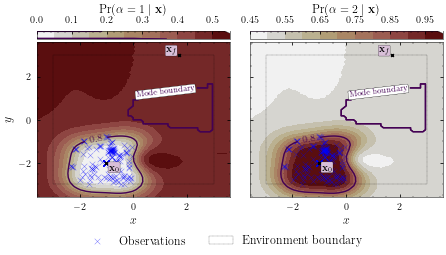

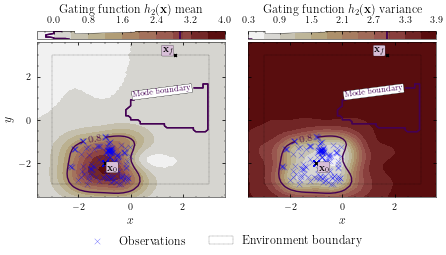

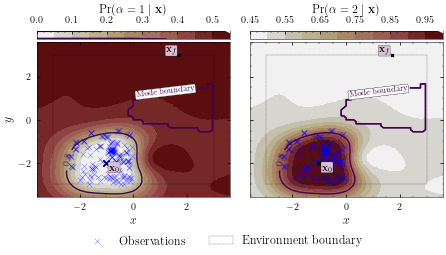

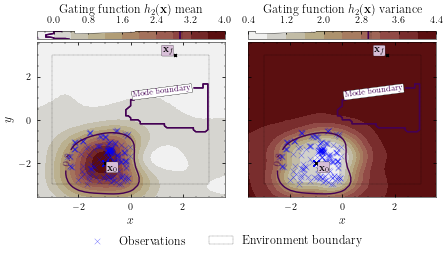

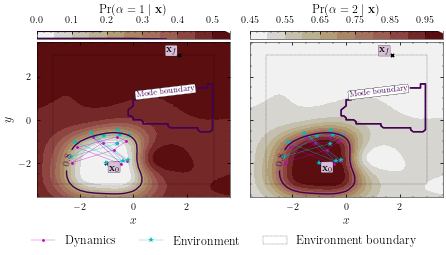

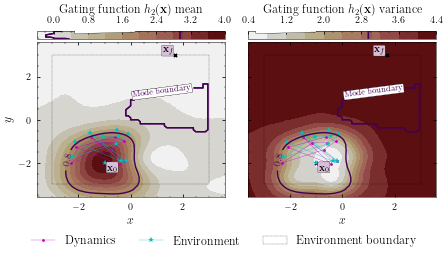

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -630.7354 - val_loss: -227.5885
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_3_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -584.6763

2022-04-08 14:39:59.103654: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 14:39:59.103687: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 4s 4s/step - loss: -584.6763 - val_loss: -284.0439
Epoch 3/10000
1/1 [==============================] - ETA: 0s - loss: -553.6793

2022-04-08 14:40:03.239667: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 14:40:03.259727: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 14:40:03.273345: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_40_03

2022-04-08 14:40:03.282102: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_40_03/dr-robots-mbp.local.trace.json.gz
2022-04-08 14:40:03.321250: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_40_03

2022-04-08 14:40:03.321648: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

1/1 [==============================] - 0s 72ms/step - loss: -553.6793 - val_loss: -187.2509
Epoch 4/10000
1/1 [==============================] - 0s 63ms/step - loss: -371.2202 - val_loss: 343.0884
Epoch 5/10000
1/1 [==============================] - 0s 50ms/step - loss: -541.7515 - val_loss: -319.9853
Epoch 6/10000
1/1 [==============================] - 0s 52ms/step - loss: -588.7177 - val_loss: -211.9543
Epoch 7/10000
1/1 [==============================] - 0s 49ms/step - loss: -470.1298 - val_loss: 262.8085
Epoch 8/10000
1/1 [==============================] - 0s 52ms/step - loss: -611.3398 - val_loss: -344.5413
Epoch 9/10000
1/1 [==============================] - 0s 53ms/step - loss: -633.5159 - val_loss: -358.8392
Epoch 10/10000
1/1 [==============================] - 0s 58ms/step - loss: -341.0726 - val_loss: 155.4444
Epoch 11/10000
1/1 [==============================] - 0s 54ms/step - loss: -501.6177 - val_loss: -301.6350
Epoch 12/10000
1/1 [==============================] - 0s 50ms

Epoch 80/10000
1/1 [==============================] - 0s 58ms/step - loss: -653.3007 - val_loss: -424.0914
Epoch 81/10000
1/1 [==============================] - 0s 72ms/step - loss: -348.0101 - val_loss: -412.1291
Epoch 82/10000
1/1 [==============================] - 0s 62ms/step - loss: -628.4739 - val_loss: -346.0593
Epoch 83/10000
1/1 [==============================] - 0s 60ms/step - loss: -646.0477 - val_loss: -388.8353
Epoch 84/10000
1/1 [==============================] - 0s 54ms/step - loss: -621.5787 - val_loss: -380.1320
Epoch 85/10000
1/1 [==============================] - 0s 62ms/step - loss: -637.8124 - val_loss: -414.5127
Epoch 86/10000
1/1 [==============================] - 0s 67ms/step - loss: -545.5649 - val_loss: -224.9791
Epoch 87/10000
1/1 [==============================] - 0s 65ms/step - loss: -520.4832 - val_loss: -416.2563
Epoch 88/10000
1/1 [==============================] - 0s 55ms/step - loss: -452.2643 - val_loss: -407.2554
Epoch 89/10000
1/1 [=================

1/1 [==============================] - 0s 60ms/step - loss: -430.3609 - val_loss: -428.4253
Epoch 157/10000
1/1 [==============================] - 0s 53ms/step - loss: -583.6138 - val_loss: -199.5694
Epoch 158/10000
1/1 [==============================] - 0s 53ms/step - loss: -636.5755 - val_loss: -500.8189
Epoch 159/10000
1/1 [==============================] - 0s 53ms/step - loss: -581.2970 - val_loss: -436.6219
Epoch 160/10000
1/1 [==============================] - 0s 55ms/step - loss: -539.7200 - val_loss: -430.1367
Epoch 161/10000
1/1 [==============================] - 0s 53ms/step - loss: -514.8413 - val_loss: -275.3824
Epoch 162/10000
1/1 [==============================] - 0s 53ms/step - loss: 17.2286 - val_loss: 90.8186
Epoch 163/10000
1/1 [==============================] - 0s 72ms/step - loss: -616.8225 - val_loss: -428.9456
Epoch 164/10000
1/1 [==============================] - 0s 70ms/step - loss: -485.2014 - val_loss: -448.1311
Epoch 165/10000
1/1 [===========================

1/1 [==============================] - 0s 51ms/step - loss: -220.6113 - val_loss: -100.3716
Epoch 233/10000
1/1 [==============================] - 0s 54ms/step - loss: -158.5829 - val_loss: 32.5664
Epoch 234/10000
1/1 [==============================] - 0s 62ms/step - loss: -381.7256 - val_loss: -198.3077
Epoch 235/10000
1/1 [==============================] - 0s 62ms/step - loss: -423.3846 - val_loss: -246.3127
Epoch 236/10000
1/1 [==============================] - 0s 52ms/step - loss: -458.1999 - val_loss: -304.6038
Epoch 237/10000
1/1 [==============================] - 0s 55ms/step - loss: -202.9518 - val_loss: 204.9866
Epoch 238/10000
1/1 [==============================] - 0s 67ms/step - loss: -403.8757 - val_loss: -185.7594
Epoch 239/10000
1/1 [==============================] - 0s 54ms/step - loss: -321.6162 - val_loss: -43.7558
Epoch 240/10000
1/1 [==============================] - 0s 53ms/step - loss: -369.9724 - val_loss: -226.9356
Epoch 241/10000
1/1 [===========================

1/1 [==============================] - 0s 59ms/step - loss: -531.5122 - val_loss: -298.9676
Epoch 309/10000
1/1 [==============================] - 0s 54ms/step - loss: -572.4920 - val_loss: -343.4555
Epoch 310/10000
1/1 [==============================] - 0s 58ms/step - loss: -517.5809 - val_loss: -353.9892
Epoch 311/10000
1/1 [==============================] - 0s 72ms/step - loss: -555.3784 - val_loss: -404.0868
Epoch 312/10000
1/1 [==============================] - 0s 66ms/step - loss: -481.9074 - val_loss: -360.4162
Epoch 313/10000
1/1 [==============================] - 0s 59ms/step - loss: -520.4411 - val_loss: -142.6688
Epoch 314/10000
1/1 [==============================] - 0s 57ms/step - loss: -547.2561 - val_loss: -151.3294
Epoch 315/10000
1/1 [==============================] - 0s 65ms/step - loss: -507.3664 - val_loss: -146.3483
Epoch 316/10000
1/1 [==============================] - 0s 56ms/step - loss: -576.4125 - val_loss: -436.7876
Epoch 317/10000
1/1 [=======================

1/1 [==============================] - 0s 54ms/step - loss: -613.7904 - val_loss: -391.0452
Epoch 385/10000
1/1 [==============================] - 0s 56ms/step - loss: -556.0120 - val_loss: -427.2153
Epoch 386/10000
1/1 [==============================] - 0s 53ms/step - loss: -607.6109 - val_loss: -383.9635
Epoch 387/10000
1/1 [==============================] - 0s 53ms/step - loss: -609.1064 - val_loss: -364.8430
Epoch 388/10000
1/1 [==============================] - 0s 52ms/step - loss: -556.1571 - val_loss: -279.5785
Epoch 389/10000
1/1 [==============================] - 0s 53ms/step - loss: -552.4984 - val_loss: -439.3287
Epoch 390/10000
1/1 [==============================] - 0s 54ms/step - loss: -588.2110 - val_loss: -392.0234
Epoch 391/10000
1/1 [==============================] - 0s 65ms/step - loss: -660.2649 - val_loss: -428.5817
Epoch 392/10000
1/1 [==============================] - 0s 65ms/step - loss: -619.8022 - val_loss: -396.9966
Epoch 393/10000
1/1 [=======================

1/1 [==============================] - ETA: 0s - loss: -588.67 - 0s 71ms/step - loss: -588.6789 - val_loss: -329.2240
Epoch 461/10000
1/1 [==============================] - 0s 61ms/step - loss: -545.2710 - val_loss: -469.9341
Epoch 462/10000
1/1 [==============================] - 0s 56ms/step - loss: -592.3835 - val_loss: -490.2708
Epoch 463/10000
1/1 [==============================] - 0s 53ms/step - loss: -494.5899 - val_loss: -483.8188
Epoch 464/10000
1/1 [==============================] - 0s 54ms/step - loss: -613.0944 - val_loss: -481.9072
Epoch 465/10000
1/1 [==============================] - 0s 58ms/step - loss: -633.5126 - val_loss: -458.3769
Epoch 466/10000
1/1 [==============================] - 0s 58ms/step - loss: -641.0654 - val_loss: -471.8243
Epoch 467/10000
1/1 [==============================] - 0s 55ms/step - loss: -585.9550 - val_loss: -359.2755
Epoch 468/10000
1/1 [==============================] - 0s 52ms/step - loss: -347.9011 - val_loss: -449.4609
Epoch 469/10000
1/

Epoch 536/10000
1/1 [==============================] - 0s 61ms/step - loss: -387.6786 - val_loss: -115.4034
Epoch 537/10000
1/1 [==============================] - 0s 62ms/step - loss: -528.8234 - val_loss: -232.0524
Epoch 538/10000
1/1 [==============================] - 0s 67ms/step - loss: -602.9777 - val_loss: -417.0730
Epoch 539/10000
1/1 [==============================] - 0s 70ms/step - loss: -536.6589 - val_loss: -286.2785
Epoch 540/10000
1/1 [==============================] - 0s 65ms/step - loss: -562.8342 - val_loss: -423.9766
Epoch 541/10000
1/1 [==============================] - 0s 70ms/step - loss: -474.4456 - val_loss: -381.6076
Epoch 542/10000
1/1 [==============================] - 0s 61ms/step - loss: -535.7243 - val_loss: -404.4055
Epoch 543/10000
1/1 [==============================] - 0s 61ms/step - loss: -559.1487 - val_loss: -343.2826
Epoch 544/10000
1/1 [==============================] - 0s 62ms/step - loss: -552.0562 - val_loss: -452.3906
Epoch 545/10000
1/1 [=======

Epoch 612/10000
1/1 [==============================] - 0s 56ms/step - loss: -596.9652 - val_loss: -451.8962
Epoch 613/10000
1/1 [==============================] - 0s 55ms/step - loss: -612.0297 - val_loss: -278.2904
Epoch 614/10000
1/1 [==============================] - 0s 57ms/step - loss: -517.3164 - val_loss: -335.2561
Epoch 615/10000
1/1 [==============================] - 0s 56ms/step - loss: -626.1701 - val_loss: -474.8274
Epoch 616/10000
1/1 [==============================] - 0s 54ms/step - loss: -651.0624 - val_loss: -450.7710
Epoch 617/10000
1/1 [==============================] - 0s 55ms/step - loss: -591.7542 - val_loss: -479.2066
Epoch 618/10000
1/1 [==============================] - 0s 57ms/step - loss: -582.8756 - val_loss: -373.5341
Epoch 619/10000
1/1 [==============================] - 0s 59ms/step - loss: -636.5094 - val_loss: -478.4687
Epoch 620/10000
1/1 [==============================] - 0s 60ms/step - loss: -634.6279 - val_loss: -474.0296
Epoch 621/10000
1/1 [=======

Epoch 688/10000
1/1 [==============================] - 0s 79ms/step - loss: -485.5786 - val_loss: -448.0766
Epoch 689/10000
1/1 [==============================] - 0s 119ms/step - loss: -538.8115 - val_loss: -365.1607
Epoch 690/10000
1/1 [==============================] - 0s 86ms/step - loss: -622.7725 - val_loss: -328.3817
Epoch 691/10000
1/1 [==============================] - 0s 75ms/step - loss: -617.2801 - val_loss: -502.7165
Epoch 692/10000
1/1 [==============================] - 0s 68ms/step - loss: -533.0461 - val_loss: -411.7122
Epoch 693/10000
1/1 [==============================] - 0s 62ms/step - loss: -526.8006 - val_loss: -403.3620
Epoch 694/10000
1/1 [==============================] - 0s 80ms/step - loss: -629.4150 - val_loss: -473.4372
Epoch 695/10000
1/1 [==============================] - 0s 84ms/step - loss: -610.8593 - val_loss: -434.0192
Epoch 696/10000
1/1 [==============================] - 0s 85ms/step - loss: -567.2165 - val_loss: -353.3878
Epoch 697/10000
1/1 [======

Epoch 764/10000
1/1 [==============================] - 0s 65ms/step - loss: -583.5235 - val_loss: -338.2799
Epoch 765/10000
1/1 [==============================] - 0s 76ms/step - loss: -612.0743 - val_loss: -477.9905
Epoch 766/10000
1/1 [==============================] - 0s 107ms/step - loss: -615.9838 - val_loss: -299.0985
Epoch 767/10000
1/1 [==============================] - 0s 74ms/step - loss: -679.3932 - val_loss: -462.1193
Epoch 768/10000
1/1 [==============================] - 0s 79ms/step - loss: -661.0018 - val_loss: -416.5749
Epoch 769/10000
1/1 [==============================] - 0s 68ms/step - loss: -605.9336 - val_loss: -159.2016
Epoch 770/10000
1/1 [==============================] - 0s 113ms/step - loss: -626.5982 - val_loss: -402.4971
Epoch 771/10000
1/1 [==============================] - 0s 77ms/step - loss: -539.7224 - val_loss: -427.8966
Epoch 772/10000
1/1 [==============================] - 0s 65ms/step - loss: -618.7277 - val_loss: -507.9239
Epoch 773/10000
1/1 [=====

Epoch 840/10000
1/1 [==============================] - 0s 65ms/step - loss: -678.9990 - val_loss: -459.0415
Epoch 841/10000
1/1 [==============================] - 0s 87ms/step - loss: -549.4184 - val_loss: -388.5529
Epoch 842/10000
1/1 [==============================] - 0s 76ms/step - loss: -576.5370 - val_loss: -450.6594
Epoch 843/10000
1/1 [==============================] - 0s 63ms/step - loss: -418.9851 - val_loss: -358.9276
Epoch 844/10000
1/1 [==============================] - 0s 64ms/step - loss: -674.4118 - val_loss: -441.3134
Epoch 845/10000
1/1 [==============================] - 0s 79ms/step - loss: -587.9152 - val_loss: -322.1164
Epoch 846/10000
1/1 [==============================] - 0s 59ms/step - loss: -573.3171 - val_loss: -71.2529
Epoch 847/10000
1/1 [==============================] - 0s 57ms/step - loss: -575.3959 - val_loss: -435.0872
Epoch 848/10000
1/1 [==============================] - 0s 63ms/step - loss: -571.0634 - val_loss: -424.7003
Epoch 849/10000
1/1 [========

Epoch 916/10000
1/1 [==============================] - 0s 59ms/step - loss: -328.7619 - val_loss: -394.7448
Epoch 917/10000
1/1 [==============================] - 0s 59ms/step - loss: -313.6760 - val_loss: -247.7394
Epoch 918/10000
1/1 [==============================] - 0s 59ms/step - loss: -270.7042 - val_loss: -316.9522
Epoch 919/10000
1/1 [==============================] - 0s 79ms/step - loss: -446.8341 - val_loss: -261.2745
Epoch 920/10000
1/1 [==============================] - 0s 74ms/step - loss: -514.9649 - val_loss: -385.4030
Epoch 921/10000
1/1 [==============================] - 0s 60ms/step - loss: -505.7040 - val_loss: -448.5592
Epoch 922/10000
1/1 [==============================] - 0s 65ms/step - loss: -594.9788 - val_loss: -472.9485
Epoch 923/10000
1/1 [==============================] - 0s 70ms/step - loss: -392.4042 - val_loss: -384.2427
Epoch 924/10000
1/1 [==============================] - 0s 56ms/step - loss: -483.3914 - val_loss: -405.7434
Epoch 925/10000
1/1 [=======

Epoch 992/10000
1/1 [==============================] - 0s 95ms/step - loss: -676.6761 - val_loss: -457.6058
Epoch 993/10000
1/1 [==============================] - 0s 93ms/step - loss: -642.4278 - val_loss: -317.8239
Epoch 994/10000
1/1 [==============================] - 0s 72ms/step - loss: -655.2306 - val_loss: -456.4856
Epoch 995/10000
1/1 [==============================] - 0s 78ms/step - loss: -673.7223 - val_loss: -469.9127
Epoch 996/10000
1/1 [==============================] - 0s 68ms/step - loss: -668.4636 - val_loss: -485.1036
Epoch 997/10000
1/1 [==============================] - 0s 64ms/step - loss: -676.1110 - val_loss: -514.7494
Epoch 998/10000
1/1 [==============================] - 0s 69ms/step - loss: -663.3199 - val_loss: -509.4870
Epoch 999/10000
1/1 [==============================] - 0s 59ms/step - loss: -665.9571 - val_loss: -496.0651
Epoch 1000/10000
1/1 [==============================] - 0s 61ms/step - loss: -671.1778 - val_loss: -510.2949
Epoch 1001/10000
1/1 [=====

1/1 [==============================] - 0s 61ms/step - loss: -381.6148 - val_loss: -443.3185
Epoch 1068/10000
1/1 [==============================] - 0s 61ms/step - loss: -477.8821 - val_loss: -136.0269
Epoch 1069/10000
1/1 [==============================] - 0s 74ms/step - loss: -535.8424 - val_loss: -491.0273
Epoch 1070/10000
1/1 [==============================] - 0s 77ms/step - loss: -493.2421 - val_loss: -441.6658
Epoch 1071/10000
1/1 [==============================] - 0s 59ms/step - loss: -366.4955 - val_loss: -342.3667
Epoch 1072/10000
1/1 [==============================] - 0s 60ms/step - loss: -200.4262 - val_loss: -492.2324
Epoch 1073/10000
1/1 [==============================] - 0s 58ms/step - loss: -111.4363 - val_loss: -350.6465
Epoch 1074/10000
1/1 [==============================] - 0s 58ms/step - loss: -676.6079 - val_loss: -468.2894
Epoch 1075/10000
1/1 [==============================] - 0s 67ms/step - loss: -607.8337 - val_loss: -402.3975
Epoch 1076/10000
1/1 [==============

1/1 [==============================] - 0s 58ms/step - loss: -459.0788 - val_loss: -409.9301
Epoch 1143/10000
1/1 [==============================] - 0s 57ms/step - loss: -611.3046 - val_loss: -416.0802
Epoch 1144/10000
1/1 [==============================] - 0s 56ms/step - loss: -563.0007 - val_loss: -418.8823
Epoch 1145/10000
1/1 [==============================] - 0s 56ms/step - loss: -623.9493 - val_loss: -330.1896
Epoch 1146/10000
1/1 [==============================] - 0s 55ms/step - loss: -619.0776 - val_loss: -471.6043
Epoch 1147/10000
1/1 [==============================] - 0s 57ms/step - loss: -656.7646 - val_loss: -511.3362
Epoch 1148/10000
1/1 [==============================] - 0s 77ms/step - loss: -618.0855 - val_loss: -467.1306
Epoch 1149/10000
1/1 [==============================] - 0s 69ms/step - loss: -622.1135 - val_loss: -469.2940
Epoch 1150/10000
1/1 [==============================] - 0s 52ms/step - loss: -595.3347 - val_loss: -353.0191
Epoch 1151/10000
1/1 [==============

1/1 [==============================] - 0s 41ms/step - loss: -683.9977 - val_loss: -453.5546
Epoch 1218/10000
1/1 [==============================] - 0s 41ms/step - loss: -661.8160 - val_loss: -465.1285
Epoch 1219/10000
1/1 [==============================] - 0s 40ms/step - loss: -662.5400 - val_loss: -477.6279
Epoch 1220/10000
1/1 [==============================] - 0s 41ms/step - loss: -708.0786 - val_loss: -541.7373
Epoch 1221/10000
1/1 [==============================] - 0s 40ms/step - loss: -598.4180 - val_loss: -520.2053
Epoch 1222/10000
1/1 [==============================] - 0s 39ms/step - loss: -673.7730 - val_loss: -497.8262
Epoch 1223/10000
1/1 [==============================] - 0s 41ms/step - loss: -623.1127 - val_loss: -563.3553
Epoch 1224/10000
1/1 [==============================] - 0s 41ms/step - loss: -705.8778 - val_loss: -511.7439
Epoch 1225/10000
1/1 [==============================] - 0s 40ms/step - loss: -688.2534 - val_loss: -500.8509
Epoch 1226/10000
1/1 [==============

1/1 [==============================] - 0s 40ms/step - loss: -385.8079 - val_loss: -377.1127
Epoch 1293/10000
1/1 [==============================] - 0s 39ms/step - loss: -418.6479 - val_loss: -267.7283
Epoch 1294/10000
1/1 [==============================] - 0s 40ms/step - loss: -587.6662 - val_loss: -326.7143
Epoch 1295/10000
1/1 [==============================] - 0s 40ms/step - loss: -532.7635 - val_loss: -482.1605
Epoch 1296/10000
1/1 [==============================] - 0s 38ms/step - loss: -624.1319 - val_loss: -482.3671
Epoch 1297/10000
1/1 [==============================] - 0s 38ms/step - loss: -564.6103 - val_loss: -492.5626
Epoch 1298/10000
1/1 [==============================] - 0s 39ms/step - loss: -205.3153 - val_loss: -518.2428
Epoch 1299/10000
1/1 [==============================] - 0s 39ms/step - loss: -540.1049 - val_loss: -274.5739
Epoch 1300/10000
1/1 [==============================] - 0s 38ms/step - loss: -455.8935 - val_loss: -186.4900
Epoch 1301/10000
1/1 [==============

1/1 [==============================] - 0s 41ms/step - loss: -593.8498 - val_loss: -446.5079
Epoch 1368/10000
1/1 [==============================] - 0s 42ms/step - loss: -524.4515 - val_loss: -350.4774
Epoch 1369/10000
1/1 [==============================] - 0s 41ms/step - loss: -562.3740 - val_loss: -326.7188
Epoch 1370/10000
1/1 [==============================] - 0s 41ms/step - loss: -564.3416 - val_loss: -448.7919
Epoch 1371/10000
1/1 [==============================] - 0s 40ms/step - loss: -588.0715 - val_loss: -446.1568
Epoch 1372/10000
1/1 [==============================] - 0s 41ms/step - loss: -553.3585 - val_loss: -453.0431
Epoch 1373/10000
1/1 [==============================] - 0s 43ms/step - loss: -497.1132 - val_loss: -425.9589
Epoch 1374/10000
1/1 [==============================] - 0s 43ms/step - loss: -614.7482 - val_loss: -468.5105
Epoch 1375/10000
1/1 [==============================] - 0s 44ms/step - loss: -615.7640 - val_loss: -423.5418
Epoch 1376/10000
1/1 [==============

1/1 [==============================] - 0s 42ms/step - loss: -720.9224 - val_loss: -556.9976
Epoch 1443/10000
1/1 [==============================] - 0s 45ms/step - loss: -725.4419 - val_loss: -524.4684
Epoch 1444/10000
1/1 [==============================] - 0s 43ms/step - loss: -725.4169 - val_loss: -451.7676
Epoch 1445/10000
1/1 [==============================] - 0s 45ms/step - loss: -662.1022 - val_loss: -410.3016
Epoch 1446/10000
1/1 [==============================] - 0s 44ms/step - loss: -729.0233 - val_loss: -580.9244
Epoch 1447/10000
1/1 [==============================] - 0s 41ms/step - loss: -689.9897 - val_loss: -411.6330
Epoch 1448/10000
1/1 [==============================] - 0s 38ms/step - loss: -731.0302 - val_loss: -542.4615
Epoch 1449/10000
1/1 [==============================] - 0s 39ms/step - loss: -666.5805 - val_loss: -541.1569
Epoch 1450/10000
1/1 [==============================] - 0s 39ms/step - loss: -706.3213 - val_loss: -438.4095
Epoch 1451/10000
1/1 [==============

1/1 [==============================] - 0s 40ms/step - loss: -442.3986 - val_loss: -501.8223
Epoch 1518/10000
1/1 [==============================] - 0s 39ms/step - loss: 88.0710 - val_loss: -425.5107
Epoch 1519/10000
1/1 [==============================] - 0s 39ms/step - loss: -280.4587 - val_loss: -427.7733
Epoch 1520/10000
1/1 [==============================] - 0s 39ms/step - loss: -114.0456 - val_loss: -437.2378
Epoch 1521/10000
1/1 [==============================] - 0s 39ms/step - loss: -312.7331 - val_loss: -368.2516
Epoch 1522/10000
1/1 [==============================] - 0s 40ms/step - loss: -264.1641 - val_loss: -366.8907
Epoch 1523/10000
1/1 [==============================] - 0s 39ms/step - loss: -484.7538 - val_loss: -488.9925
Epoch 1524/10000
1/1 [==============================] - 0s 40ms/step - loss: -406.5109 - val_loss: -393.0604
Epoch 1525/10000
1/1 [==============================] - 0s 39ms/step - loss: -373.7713 - val_loss: -337.5876
Epoch 1526/10000
1/1 [================

1/1 [==============================] - 0s 41ms/step - loss: -627.3648 - val_loss: -468.0207
Epoch 1593/10000
1/1 [==============================] - 0s 41ms/step - loss: -629.1570 - val_loss: -458.7283
Epoch 1594/10000
1/1 [==============================] - 0s 44ms/step - loss: -626.7279 - val_loss: -475.3054
Epoch 1595/10000
1/1 [==============================] - 0s 46ms/step - loss: -562.8766 - val_loss: -467.4363
Epoch 1596/10000
1/1 [==============================] - 0s 43ms/step - loss: -554.9093 - val_loss: -389.6792
Epoch 1597/10000
1/1 [==============================] - 0s 43ms/step - loss: -647.0490 - val_loss: -497.2709
Epoch 1598/10000
1/1 [==============================] - 0s 41ms/step - loss: -654.7127 - val_loss: -490.9302
Epoch 1599/10000
1/1 [==============================] - 0s 41ms/step - loss: -625.7568 - val_loss: -400.0124
Epoch 1600/10000
1/1 [==============================] - 0s 44ms/step - loss: -592.2035 - val_loss: -392.3668
Epoch 1601/10000
1/1 [==============

1/1 [==============================] - 0s 44ms/step - loss: -741.4442 - val_loss: -530.6346
Epoch 1668/10000
1/1 [==============================] - 0s 42ms/step - loss: -688.9165 - val_loss: -533.7440
Epoch 1669/10000
1/1 [==============================] - 0s 42ms/step - loss: -710.9326 - val_loss: -484.8091
Epoch 1670/10000
1/1 [==============================] - 0s 40ms/step - loss: -731.6764 - val_loss: -531.9850
Epoch 1671/10000
1/1 [==============================] - 0s 39ms/step - loss: -703.0606 - val_loss: -446.4661
Epoch 1672/10000
1/1 [==============================] - 0s 39ms/step - loss: -738.5080 - val_loss: -536.8331
Epoch 1673/10000
1/1 [==============================] - 0s 39ms/step - loss: -681.6571 - val_loss: -433.4403
Epoch 1674/10000
1/1 [==============================] - 0s 39ms/step - loss: -601.3199 - val_loss: -440.6984
Epoch 1675/10000
1/1 [==============================] - 0s 40ms/step - loss: -714.3878 - val_loss: -581.6679
Epoch 1676/10000
1/1 [==============

1/1 [==============================] - 0s 39ms/step - loss: -641.9375 - val_loss: -558.9811
Epoch 1743/10000
1/1 [==============================] - 0s 39ms/step - loss: -456.9212 - val_loss: -499.6990
Epoch 1744/10000
1/1 [==============================] - 0s 39ms/step - loss: -624.6047 - val_loss: -498.4162
Epoch 1745/10000
1/1 [==============================] - 0s 41ms/step - loss: -671.0558 - val_loss: -554.8743
Epoch 1746/10000
1/1 [==============================] - 0s 44ms/step - loss: -652.5367 - val_loss: -459.1251
Epoch 1747/10000
1/1 [==============================] - 0s 43ms/step - loss: -644.0609 - val_loss: -500.1953
Epoch 1748/10000
1/1 [==============================] - 0s 45ms/step - loss: -609.8535 - val_loss: -471.8069
Epoch 1749/10000
1/1 [==============================] - 0s 43ms/step - loss: -624.5508 - val_loss: -509.9678
Epoch 1750/10000
1/1 [==============================] - 0s 44ms/step - loss: -483.9320 - val_loss: -545.1426
Epoch 1751/10000
1/1 [==============

1/1 [==============================] - 0s 40ms/step - loss: -530.8718 - val_loss: -371.7480
Epoch 1818/10000
1/1 [==============================] - 0s 40ms/step - loss: -472.2065 - val_loss: -369.5597
Epoch 1819/10000
1/1 [==============================] - 0s 38ms/step - loss: -520.9948 - val_loss: -348.5441
Epoch 1820/10000
1/1 [==============================] - 0s 40ms/step - loss: -561.1051 - val_loss: -411.8685
Epoch 1821/10000
1/1 [==============================] - 0s 38ms/step - loss: -493.2636 - val_loss: -275.7343
Epoch 1822/10000
1/1 [==============================] - 0s 40ms/step - loss: -543.9407 - val_loss: -372.1023
Epoch 1823/10000
1/1 [==============================] - 0s 40ms/step - loss: -360.5267 - val_loss: -96.2721
Epoch 1824/10000
1/1 [==============================] - 0s 42ms/step - loss: -501.2130 - val_loss: -312.3590
Epoch 1825/10000
1/1 [==============================] - 0s 45ms/step - loss: -556.4212 - val_loss: -387.6992
Epoch 1826/10000
1/1 [===============

1/1 [==============================] - 0s 47ms/step - loss: -632.0089 - val_loss: -469.7302
Epoch 1893/10000
1/1 [==============================] - 0s 45ms/step - loss: -621.2588 - val_loss: -446.6690
Epoch 1894/10000
1/1 [==============================] - 0s 46ms/step - loss: -633.6097 - val_loss: -459.4627
Epoch 1895/10000
1/1 [==============================] - 0s 46ms/step - loss: -537.2317 - val_loss: -314.9118
Epoch 1896/10000
1/1 [==============================] - 0s 47ms/step - loss: -628.9656 - val_loss: -453.1651
Epoch 1897/10000
1/1 [==============================] - 0s 46ms/step - loss: -515.0049 - val_loss: -302.1732
Epoch 1898/10000
1/1 [==============================] - 0s 52ms/step - loss: -601.2881 - val_loss: -480.0564
Epoch 1899/10000
1/1 [==============================] - 0s 43ms/step - loss: -640.8736 - val_loss: -434.4123
Epoch 1900/10000
1/1 [==============================] - 0s 44ms/step - loss: -630.8049 - val_loss: -408.6846
Epoch 1901/10000
1/1 [==============

1/1 [==============================] - 0s 42ms/step - loss: -665.3558 - val_loss: -525.6971
Epoch 1968/10000
1/1 [==============================] - 0s 42ms/step - loss: -644.7366 - val_loss: -491.5516
Epoch 1969/10000
1/1 [==============================] - 0s 42ms/step - loss: -596.5380 - val_loss: -431.3314
Epoch 1970/10000
1/1 [==============================] - 0s 43ms/step - loss: -651.9702 - val_loss: -471.2331
Epoch 1971/10000
1/1 [==============================] - 0s 42ms/step - loss: -437.3518 - val_loss: -222.1282
Epoch 1972/10000
1/1 [==============================] - 0s 42ms/step - loss: -625.5109 - val_loss: -442.0815
Epoch 1973/10000
1/1 [==============================] - 0s 41ms/step - loss: -578.4392 - val_loss: -468.0230
Epoch 1974/10000
1/1 [==============================] - 0s 42ms/step - loss: -647.7998 - val_loss: -427.1695
Epoch 1975/10000
1/1 [==============================] - 0s 41ms/step - loss: -572.7977 - val_loss: -403.7008
Epoch 1976/10000
1/1 [==============

/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2002/10000
1/1 [==============================] - 0s 35ms/step - loss: -345.2693 - val_loss: -405.5263
Epoch 2003/10000
1/1 [==============================] - 0s 35ms/step - loss: -520.3912 - val_loss: -417.7943
Epoch 2004/10000
1/1 [==============================] - 0s 35ms/step - loss: 336.4681 - val_loss: -208.0188
Epoch 2005/10000
1/1 [==============================] - 0s 37ms/step - loss: -450.9037 - val_loss: -370.4136
Epoch 2006/10000
1/1 [==============================] - 0s 42ms/step - loss: -298.6020 - val_loss: -246.4810
Epoch 2007/10000
1/1 [==============================] - 0s 41ms/step - loss: -556.4711 - val_loss: -431.3109
Epoch 2008/10000
1/1 [==============================] - 0s 40ms/step - loss: -285.2721 - val_loss: -277.3853
Epoch 2009/10000
1/1 [==============================] - 0s 38ms/step - loss: -455.0133 - val_loss: -331.8713
Epoch 2010/10000
1/1 [==============================] - 0s 41ms/step - loss: -390.5169 - val_loss: -328.8807
Epoch 2011/10000
1/1

1/1 [==============================] - 0s 44ms/step - loss: -584.7113 - val_loss: -371.1722
Epoch 2078/10000
1/1 [==============================] - 0s 46ms/step - loss: -528.7613 - val_loss: -375.7386
Epoch 2079/10000
1/1 [==============================] - 0s 44ms/step - loss: -595.2019 - val_loss: -435.4940
Epoch 2080/10000
1/1 [==============================] - 0s 41ms/step - loss: -582.7834 - val_loss: -376.9064
Epoch 2081/10000
1/1 [==============================] - 0s 44ms/step - loss: -578.7728 - val_loss: -444.3426
Epoch 2082/10000
1/1 [==============================] - 0s 41ms/step - loss: -607.0759 - val_loss: -450.9840
Epoch 2083/10000
1/1 [==============================] - 0s 40ms/step - loss: -544.5959 - val_loss: -321.2046
Epoch 2084/10000
1/1 [==============================] - 0s 40ms/step - loss: -269.8687 - val_loss: -50.2397
Epoch 2085/10000
1/1 [==============================] - 0s 39ms/step - loss: -478.9762 - val_loss: -239.1675
Epoch 2086/10000
1/1 [===============

1/1 [==============================] - 0s 42ms/step - loss: -382.6883 - val_loss: -393.5134
Epoch 2153/10000
1/1 [==============================] - 0s 43ms/step - loss: -403.7381 - val_loss: -378.1935
Epoch 2154/10000
1/1 [==============================] - 0s 44ms/step - loss: -592.4986 - val_loss: -440.6970
Epoch 2155/10000
1/1 [==============================] - 0s 43ms/step - loss: -586.3606 - val_loss: -446.0958
Epoch 2156/10000
1/1 [==============================] - 0s 44ms/step - loss: -495.5831 - val_loss: -374.2079
Epoch 2157/10000
1/1 [==============================] - 0s 41ms/step - loss: -592.9559 - val_loss: -394.3922
Epoch 2158/10000
1/1 [==============================] - 0s 41ms/step - loss: -571.1337 - val_loss: -387.5796
Epoch 2159/10000
1/1 [==============================] - 0s 54ms/step - loss: -590.9731 - val_loss: -377.0308
Epoch 2160/10000
1/1 [==============================] - 0s 62ms/step - loss: -525.8301 - val_loss: -336.4101
Epoch 2161/10000
1/1 [==============

cost
1.2723010516212456
entropy
-2.4904394535731487
cost
1.2721541476508078
entropy
-2.490256572528029
cost
1.271965630268908
entropy
-2.4900693434354859
cost
1.2717666354666828
entropy
-2.4900436726238291
cost
1.2717227953955161
entropy
-2.4903328233592186
cost
1.271996003763181
entropy
-2.4906639157743204
cost
1.2723214566463876
entropy
-2.4907882714401968
cost
1.2724454575536244
Optimisation result:
     fun: -1.2183428138865724
     jac: array([ 0.0450458 , -0.11983486,  0.02995352, -0.08763622,  0.01032257,
       -0.03557785,  0.01739958, -0.04426684,  0.01199534, -0.04759633,
        0.03019154, -0.00135795,  0.03494529,  0.00137506,  0.0329402 ,
       -0.00054777, -0.00059766, -0.0010388 , -0.00056011, -0.0009294 ])
 message: 'Optimization terminated successfully'
    nfev: 90
     nit: 86
    njev: 86
  status: 0
 success: True
       x: array([ 3.75538487,  2.90894771, -7.54544031,  7.82717029,  6.01811694,
       -4.82690064, -8.89203841,  5.67697835,  6.83323851,  3.610223

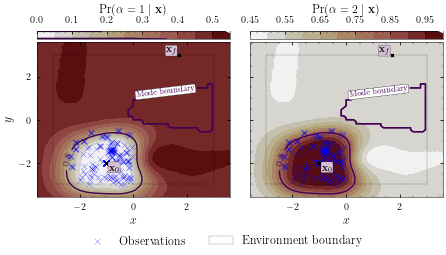

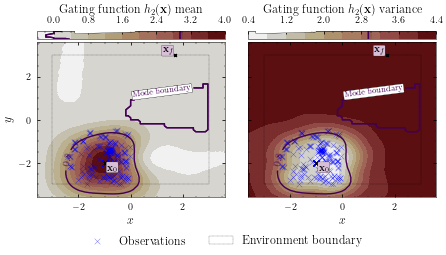

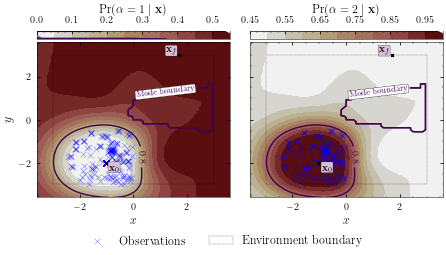

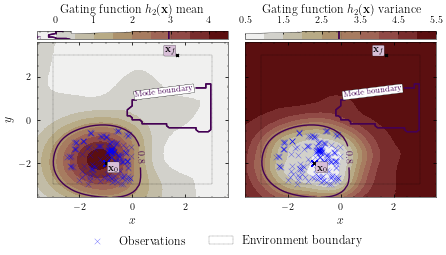

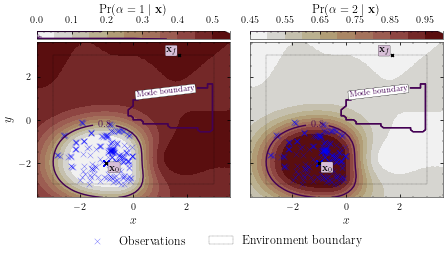

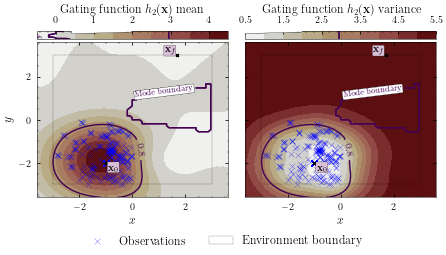

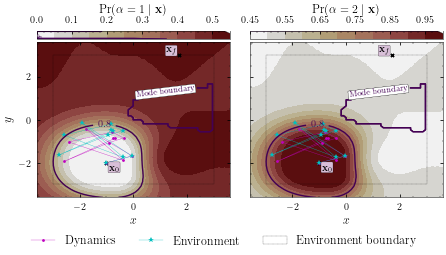

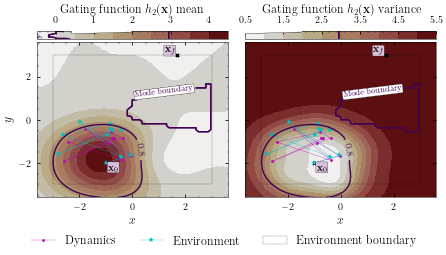

Epoch 1/10000
1/1 [==============================] - 1s 757ms/step - loss: -557.3127 - val_loss: -299.7376
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_4_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -547.4856

2022-04-08 14:45:55.035666: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 14:45:55.035688: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 5s 5s/step - loss: -547.4856 - val_loss: -191.7656


2022-04-08 14:45:59.489016: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 14:45:59.524563: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 14:45:59.541648: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_45_59

2022-04-08 14:45:59.554982: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_45_59/dr-robots-mbp.local.trace.json.gz
2022-04-08 14:45:59.606138: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_45_59

2022-04-08 14:45:59.606550: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

Epoch 3/10000
1/1 [==============================] - 0s 61ms/step - loss: -582.2872 - val_loss: -323.0956
Epoch 4/10000
1/1 [==============================] - 0s 70ms/step - loss: -576.8315 - val_loss: -269.7233
Epoch 5/10000
1/1 [==============================] - 0s 70ms/step - loss: -549.5362 - val_loss: -355.6754
Epoch 6/10000
1/1 [==============================] - 0s 57ms/step - loss: -492.4487 - val_loss: -284.3239
Epoch 7/10000
1/1 [==============================] - 0s 59ms/step - loss: -482.2317 - val_loss: -266.7395
Epoch 8/10000
1/1 [==============================] - 0s 54ms/step - loss: -484.5809 - val_loss: -182.9745
Epoch 9/10000
1/1 [==============================] - 0s 58ms/step - loss: -609.4811 - val_loss: -344.0900
Epoch 10/10000
1/1 [==============================] - 0s 61ms/step - loss: -588.6306 - val_loss: -337.5892
Epoch 11/10000
1/1 [==============================] - 0s 59ms/step - loss: -552.4861 - val_loss: -307.2090
Epoch 12/10000
1/1 [========================

1/1 [==============================] - 0s 60ms/step - loss: -623.6967 - val_loss: -337.3679
Epoch 80/10000
1/1 [==============================] - 0s 57ms/step - loss: -577.0252 - val_loss: -383.1365
Epoch 81/10000
1/1 [==============================] - 0s 59ms/step - loss: -662.7826 - val_loss: -383.2557
Epoch 82/10000
1/1 [==============================] - 0s 62ms/step - loss: -690.8807 - val_loss: -426.9358
Epoch 83/10000
1/1 [==============================] - 0s 58ms/step - loss: -626.8703 - val_loss: -385.2004
Epoch 84/10000
1/1 [==============================] - 0s 57ms/step - loss: -688.8031 - val_loss: -457.4910
Epoch 85/10000
1/1 [==============================] - 0s 57ms/step - loss: -678.7425 - val_loss: -386.5392
Epoch 86/10000
1/1 [==============================] - 0s 72ms/step - loss: -604.7043 - val_loss: -389.6918
Epoch 87/10000
1/1 [==============================] - 0s 62ms/step - loss: -566.2913 - val_loss: -313.7780
Epoch 88/10000
1/1 [==============================] 

1/1 [==============================] - 0s 70ms/step - loss: -636.4931 - val_loss: -395.6259
Epoch 156/10000
1/1 [==============================] - 0s 66ms/step - loss: -630.9014 - val_loss: -382.5178
Epoch 157/10000
1/1 [==============================] - 0s 64ms/step - loss: -592.4159 - val_loss: -409.6074
Epoch 158/10000
1/1 [==============================] - 0s 68ms/step - loss: -496.3543 - val_loss: -295.4214
Epoch 159/10000
1/1 [==============================] - 0s 65ms/step - loss: -457.4805 - val_loss: -246.2845
Epoch 160/10000
1/1 [==============================] - 0s 63ms/step - loss: -477.2261 - val_loss: -335.0024
Epoch 161/10000
1/1 [==============================] - 0s 89ms/step - loss: -596.9458 - val_loss: -352.2139
Epoch 162/10000
1/1 [==============================] - 0s 63ms/step - loss: -572.2428 - val_loss: -306.4169
Epoch 163/10000
1/1 [==============================] - 0s 66ms/step - loss: -633.2161 - val_loss: -374.0576
Epoch 164/10000
1/1 [=======================

1/1 [==============================] - 0s 52ms/step - loss: -677.8140 - val_loss: -448.4229
Epoch 232/10000
1/1 [==============================] - 0s 55ms/step - loss: -595.1302 - val_loss: -189.8094
Epoch 233/10000
1/1 [==============================] - 0s 53ms/step - loss: -642.0978 - val_loss: -322.1420
Epoch 234/10000
1/1 [==============================] - 0s 58ms/step - loss: -585.7517 - val_loss: -276.1771
Epoch 235/10000
1/1 [==============================] - 0s 73ms/step - loss: -611.4342 - val_loss: -420.2734
Epoch 236/10000
1/1 [==============================] - 0s 63ms/step - loss: -605.7225 - val_loss: -413.5978
Epoch 237/10000
1/1 [==============================] - 0s 56ms/step - loss: -675.7836 - val_loss: -437.3232
Epoch 238/10000
1/1 [==============================] - 0s 55ms/step - loss: -672.5247 - val_loss: -398.5291
Epoch 239/10000
1/1 [==============================] - 0s 56ms/step - loss: -669.9514 - val_loss: -426.8706
Epoch 240/10000
1/1 [=======================

1/1 [==============================] - 0s 51ms/step - loss: -552.6791 - val_loss: -307.8854
Epoch 308/10000
1/1 [==============================] - 0s 50ms/step - loss: -578.3433 - val_loss: -318.4030
Epoch 309/10000
1/1 [==============================] - 0s 51ms/step - loss: -552.1225 - val_loss: -259.5968
Epoch 310/10000
1/1 [==============================] - 0s 52ms/step - loss: -583.1381 - val_loss: -285.6552
Epoch 311/10000
1/1 [==============================] - 0s 64ms/step - loss: -510.4132 - val_loss: -294.7382
Epoch 312/10000
1/1 [==============================] - 0s 67ms/step - loss: -593.1174 - val_loss: -347.9158
Epoch 313/10000
1/1 [==============================] - 0s 54ms/step - loss: -385.9920 - val_loss: -356.9112
Epoch 314/10000
1/1 [==============================] - 0s 54ms/step - loss: -50.2142 - val_loss: -340.2979
Epoch 315/10000
1/1 [==============================] - 0s 59ms/step - loss: -348.2114 - val_loss: -366.5708
Epoch 316/10000
1/1 [========================

1/1 [==============================] - 0s 58ms/step - loss: -652.3915 - val_loss: -416.5003
Epoch 384/10000
1/1 [==============================] - 0s 58ms/step - loss: -650.9055 - val_loss: -448.8900
Epoch 385/10000
1/1 [==============================] - 0s 58ms/step - loss: -633.1682 - val_loss: -397.8822
Epoch 386/10000
1/1 [==============================] - 0s 50ms/step - loss: -629.4190 - val_loss: -314.4374
Epoch 387/10000
1/1 [==============================] - 0s 61ms/step - loss: -629.4943 - val_loss: -329.2687
Epoch 388/10000
1/1 [==============================] - 0s 65ms/step - loss: -613.2726 - val_loss: -422.1480
Epoch 389/10000
1/1 [==============================] - 0s 57ms/step - loss: -628.4376 - val_loss: -320.1774
Epoch 390/10000
1/1 [==============================] - 0s 58ms/step - loss: -644.4948 - val_loss: -355.3068
Epoch 391/10000
1/1 [==============================] - 0s 63ms/step - loss: -634.1615 - val_loss: -363.4381
Epoch 392/10000
1/1 [=======================

1/1 [==============================] - 0s 52ms/step - loss: -700.9035 - val_loss: -411.4087
Epoch 460/10000
1/1 [==============================] - 0s 54ms/step - loss: -671.1750 - val_loss: -430.1964
Epoch 461/10000
1/1 [==============================] - 0s 53ms/step - loss: -422.4061 - val_loss: -349.0018
Epoch 462/10000
1/1 [==============================] - 0s 53ms/step - loss: -510.1212 - val_loss: -457.8879
Epoch 463/10000
1/1 [==============================] - 0s 54ms/step - loss: -599.4163 - val_loss: -449.5369
Epoch 464/10000
1/1 [==============================] - 0s 60ms/step - loss: -608.3474 - val_loss: -394.1042
Epoch 465/10000
1/1 [==============================] - 0s 65ms/step - loss: -586.8937 - val_loss: -400.2232
Epoch 466/10000
1/1 [==============================] - 0s 56ms/step - loss: -611.6727 - val_loss: -408.8414
Epoch 467/10000
1/1 [==============================] - 0s 54ms/step - loss: -609.8425 - val_loss: -461.6231
Epoch 468/10000
1/1 [=======================

1/1 [==============================] - 0s 53ms/step - loss: -540.2995 - val_loss: -333.9121
Epoch 536/10000
1/1 [==============================] - 0s 54ms/step - loss: -527.1887 - val_loss: -305.0899
Epoch 537/10000
1/1 [==============================] - 0s 64ms/step - loss: -502.0194 - val_loss: -243.6813
Epoch 538/10000
1/1 [==============================] - 0s 80ms/step - loss: -483.8502 - val_loss: -310.8405
Epoch 539/10000
1/1 [==============================] - 0s 57ms/step - loss: -460.5387 - val_loss: -273.5265
Epoch 540/10000
1/1 [==============================] - 0s 55ms/step - loss: -475.7294 - val_loss: -333.7046
Epoch 541/10000
1/1 [==============================] - 0s 62ms/step - loss: -488.6511 - val_loss: -291.2410
Epoch 542/10000
1/1 [==============================] - 0s 65ms/step - loss: -514.5652 - val_loss: -355.8854
Epoch 543/10000
1/1 [==============================] - 0s 51ms/step - loss: -434.4182 - val_loss: -305.3968
Epoch 544/10000
1/1 [=======================

1/1 [==============================] - 0s 78ms/step - loss: -662.1537 - val_loss: -375.9487
Epoch 612/10000
1/1 [==============================] - 0s 68ms/step - loss: -545.2388 - val_loss: -400.1459
Epoch 613/10000
1/1 [==============================] - 0s 79ms/step - loss: -632.8447 - val_loss: -345.8916
Epoch 614/10000
1/1 [==============================] - 0s 62ms/step - loss: -632.7614 - val_loss: -412.7855
Epoch 615/10000
1/1 [==============================] - 0s 57ms/step - loss: -640.1208 - val_loss: -397.6002
Epoch 616/10000
1/1 [==============================] - 0s 57ms/step - loss: -665.2741 - val_loss: -408.1265
Epoch 617/10000
1/1 [==============================] - 0s 63ms/step - loss: -613.3728 - val_loss: -175.6308
Epoch 618/10000
1/1 [==============================] - 0s 60ms/step - loss: -641.0316 - val_loss: -440.1207
Epoch 619/10000
1/1 [==============================] - 0s 74ms/step - loss: -627.0994 - val_loss: -359.2665
Epoch 620/10000
1/1 [=======================

Epoch 687/10000
1/1 [==============================] - 0s 65ms/step - loss: -588.4907 - val_loss: -453.1136
Epoch 688/10000
1/1 [==============================] - 0s 70ms/step - loss: -632.6848 - val_loss: -150.1543
Epoch 689/10000
1/1 [==============================] - 0s 65ms/step - loss: -696.3312 - val_loss: -462.3613
Epoch 690/10000
1/1 [==============================] - 0s 63ms/step - loss: -603.4794 - val_loss: -439.8637
Epoch 691/10000
1/1 [==============================] - 0s 86ms/step - loss: -703.8695 - val_loss: -482.8797
Epoch 692/10000
1/1 [==============================] - 0s 69ms/step - loss: -702.0522 - val_loss: -457.4811
Epoch 693/10000
1/1 [==============================] - 0s 61ms/step - loss: -619.8040 - val_loss: -368.5052
Epoch 694/10000
1/1 [==============================] - 0s 61ms/step - loss: -667.6474 - val_loss: -406.1766
Epoch 695/10000
1/1 [==============================] - 0s 62ms/step - loss: -626.9208 - val_loss: -484.3485
Epoch 696/10000
1/1 [=======

1/1 [==============================] - 0s 59ms/step - loss: -432.8502 - val_loss: -322.0835
Epoch 764/10000
1/1 [==============================] - 0s 60ms/step - loss: -538.7625 - val_loss: -231.1679
Epoch 765/10000
1/1 [==============================] - 0s 61ms/step - loss: -517.0392 - val_loss: -288.1151
Epoch 766/10000
1/1 [==============================] - 0s 87ms/step - loss: -579.3196 - val_loss: -379.3104
Epoch 767/10000
1/1 [==============================] - 0s 75ms/step - loss: -495.1597 - val_loss: -234.7093
Epoch 768/10000
1/1 [==============================] - 0s 66ms/step - loss: -552.3525 - val_loss: -387.1843
Epoch 769/10000
1/1 [==============================] - 0s 77ms/step - loss: -521.9653 - val_loss: -336.9815
Epoch 770/10000
1/1 [==============================] - 0s 71ms/step - loss: -595.7601 - val_loss: -346.6715
Epoch 771/10000
1/1 [==============================] - 0s 61ms/step - loss: -569.6024 - val_loss: -322.1736
Epoch 772/10000
1/1 [=======================

Epoch 839/10000
1/1 [==============================] - 0s 77ms/step - loss: -614.6105 - val_loss: -353.2791
Epoch 840/10000
1/1 [==============================] - 0s 79ms/step - loss: -585.2417 - val_loss: -313.8417
Epoch 841/10000
1/1 [==============================] - 0s 73ms/step - loss: -625.0033 - val_loss: -376.2361
Epoch 842/10000
1/1 [==============================] - 0s 71ms/step - loss: -619.0494 - val_loss: -367.2249
Epoch 843/10000
1/1 [==============================] - 0s 72ms/step - loss: -526.5133 - val_loss: -376.3313
Epoch 844/10000
1/1 [==============================] - 0s 99ms/step - loss: -608.5453 - val_loss: -405.3345
Epoch 845/10000
1/1 [==============================] - 0s 74ms/step - loss: -646.1749 - val_loss: -346.0176
Epoch 846/10000
1/1 [==============================] - 0s 74ms/step - loss: -648.2111 - val_loss: -301.4905
Epoch 847/10000
1/1 [==============================] - 0s 69ms/step - loss: -638.6233 - val_loss: -436.7625
Epoch 848/10000
1/1 [=======

Epoch 915/10000
1/1 [==============================] - 0s 61ms/step - loss: -330.7998 - val_loss: -279.6395
Epoch 916/10000
1/1 [==============================] - 0s 59ms/step - loss: -436.3714 - val_loss: -381.8694
Epoch 917/10000
1/1 [==============================] - 0s 61ms/step - loss: -578.5039 - val_loss: -364.4614
Epoch 918/10000
1/1 [==============================] - 0s 60ms/step - loss: -302.3412 - val_loss: -353.2295
Epoch 919/10000
1/1 [==============================] - 0s 60ms/step - loss: -504.1626 - val_loss: -359.9048
Epoch 920/10000
1/1 [==============================] - 0s 60ms/step - loss: -558.7480 - val_loss: -299.2198
Epoch 921/10000
1/1 [==============================] - 0s 61ms/step - loss: -388.9211 - val_loss: -172.8457
Epoch 922/10000
1/1 [==============================] - 0s 61ms/step - loss: -276.6687 - val_loss: -367.0097
Epoch 923/10000
1/1 [==============================] - 0s 61ms/step - loss: -581.2729 - val_loss: -406.1850
Epoch 924/10000
1/1 [=======

Epoch 991/10000
1/1 [==============================] - 0s 83ms/step - loss: -650.9657 - val_loss: -411.5404
Epoch 992/10000
1/1 [==============================] - 0s 62ms/step - loss: -645.0493 - val_loss: -398.3655
Epoch 993/10000
1/1 [==============================] - 0s 60ms/step - loss: -655.2169 - val_loss: -422.7473
Epoch 994/10000
1/1 [==============================] - 0s 63ms/step - loss: -678.9852 - val_loss: -417.7999
Epoch 995/10000
1/1 [==============================] - 0s 71ms/step - loss: -657.4794 - val_loss: -444.6526
Epoch 996/10000
1/1 [==============================] - 0s 74ms/step - loss: -693.2100 - val_loss: -483.3318
Epoch 997/10000
1/1 [==============================] - 0s 62ms/step - loss: -672.5532 - val_loss: -394.0750
Epoch 998/10000
1/1 [==============================] - 0s 62ms/step - loss: -677.1120 - val_loss: -458.2812
Epoch 999/10000
1/1 [==============================] - 0s 59ms/step - loss: -668.8494 - val_loss: -472.6491
Epoch 1000/10000
1/1 [======

1/1 [==============================] - 0s 76ms/step - loss: -702.7322 - val_loss: -500.8356
Epoch 1067/10000
1/1 [==============================] - 0s 68ms/step - loss: -732.2163 - val_loss: -453.0716
Epoch 1068/10000
1/1 [==============================] - 0s 70ms/step - loss: -583.8572 - val_loss: -470.4731
Epoch 1069/10000
1/1 [==============================] - 0s 67ms/step - loss: -693.3009 - val_loss: -462.8274
Epoch 1070/10000
1/1 [==============================] - 0s 95ms/step - loss: -668.7396 - val_loss: -372.2949
Epoch 1071/10000
1/1 [==============================] - 0s 65ms/step - loss: -386.2647 - val_loss: -408.3886
Epoch 1072/10000
1/1 [==============================] - 0s 75ms/step - loss: -649.4717 - val_loss: -333.4707
Epoch 1073/10000
1/1 [==============================] - 0s 70ms/step - loss: -672.9305 - val_loss: -365.6765
Epoch 1074/10000
1/1 [==============================] - 0s 71ms/step - loss: -540.1244 - val_loss: -471.9260
Epoch 1075/10000
1/1 [==============

1/1 [==============================] - 0s 60ms/step - loss: -637.5653 - val_loss: -425.7291
Epoch 1142/10000
1/1 [==============================] - 0s 59ms/step - loss: -718.2062 - val_loss: -494.3281
Epoch 1143/10000
1/1 [==============================] - 0s 60ms/step - loss: -632.6973 - val_loss: -447.0153
Epoch 1144/10000
1/1 [==============================] - 0s 60ms/step - loss: -725.4292 - val_loss: -484.1334
Epoch 1145/10000
1/1 [==============================] - 0s 88ms/step - loss: -723.0366 - val_loss: -380.5551
Epoch 1146/10000
1/1 [==============================] - 0s 62ms/step - loss: -681.6706 - val_loss: -461.6311
Epoch 1147/10000
1/1 [==============================] - 0s 61ms/step - loss: -523.1172 - val_loss: -387.5269
Epoch 1148/10000
1/1 [==============================] - 0s 58ms/step - loss: -703.9112 - val_loss: -438.1885
Epoch 1149/10000
1/1 [==============================] - 0s 76ms/step - loss: -733.5430 - val_loss: -479.6304
Epoch 1150/10000
1/1 [==============

1/1 [==============================] - 0s 67ms/step - loss: -598.5531 - val_loss: -452.9083
Epoch 1217/10000
1/1 [==============================] - 0s 60ms/step - loss: -690.6805 - val_loss: -497.2682
Epoch 1218/10000
1/1 [==============================] - 0s 60ms/step - loss: -579.0433 - val_loss: -386.8021
Epoch 1219/10000
1/1 [==============================] - 0s 61ms/step - loss: -643.2952 - val_loss: -308.9203
Epoch 1220/10000
1/1 [==============================] - 0s 76ms/step - loss: -626.7430 - val_loss: -426.3447
Epoch 1221/10000
1/1 [==============================] - 0s 68ms/step - loss: -631.4439 - val_loss: -468.2993
Epoch 1222/10000
1/1 [==============================] - 0s 62ms/step - loss: -701.9871 - val_loss: -436.3858
Epoch 1223/10000
1/1 [==============================] - 0s 64ms/step - loss: 132.5252 - val_loss: -382.8056
Epoch 1224/10000
1/1 [==============================] - 0s 61ms/step - loss: -583.0437 - val_loss: -426.0144
Epoch 1225/10000
1/1 [===============

1/1 [==============================] - 0s 78ms/step - loss: -653.3628 - val_loss: -369.4961
Epoch 1292/10000
1/1 [==============================] - 0s 66ms/step - loss: -625.2366 - val_loss: -459.1409
Epoch 1293/10000
1/1 [==============================] - 0s 84ms/step - loss: -636.9712 - val_loss: -427.1442
Epoch 1294/10000
1/1 [==============================] - 0s 99ms/step - loss: -675.2647 - val_loss: -442.7463
Epoch 1295/10000
1/1 [==============================] - 0s 97ms/step - loss: -674.8298 - val_loss: -423.1579
Epoch 1296/10000
1/1 [==============================] - 0s 99ms/step - loss: -627.4293 - val_loss: -432.9351
Epoch 1297/10000
1/1 [==============================] - 0s 75ms/step - loss: -662.0802 - val_loss: -393.0767
Epoch 1298/10000
1/1 [==============================] - 0s 96ms/step - loss: -676.2556 - val_loss: -377.9474
Epoch 1299/10000
1/1 [==============================] - 0s 92ms/step - loss: -661.6153 - val_loss: -423.8036
Epoch 1300/10000
1/1 [==============

1/1 [==============================] - 0s 59ms/step - loss: -500.5301 - val_loss: -240.7045
Epoch 1367/10000
1/1 [==============================] - 0s 66ms/step - loss: -569.8238 - val_loss: -273.9096
Epoch 1368/10000
1/1 [==============================] - 0s 62ms/step - loss: -615.0261 - val_loss: -337.6319
Epoch 1369/10000
1/1 [==============================] - 0s 59ms/step - loss: -570.2152 - val_loss: -362.8828
Epoch 1370/10000
1/1 [==============================] - 0s 59ms/step - loss: -495.7400 - val_loss: -329.8295
Epoch 1371/10000
1/1 [==============================] - 0s 68ms/step - loss: -594.0986 - val_loss: -385.3360
Epoch 1372/10000
1/1 [==============================] - 0s 61ms/step - loss: -443.1634 - val_loss: -265.0567
Epoch 1373/10000
1/1 [==============================] - 0s 57ms/step - loss: -608.4091 - val_loss: -359.0187
Epoch 1374/10000
1/1 [==============================] - 0s 63ms/step - loss: -541.0165 - val_loss: -364.0409
Epoch 1375/10000
1/1 [==============

1/1 [==============================] - 0s 64ms/step - loss: -717.6923 - val_loss: -472.9731
Epoch 1442/10000
1/1 [==============================] - 0s 78ms/step - loss: -682.9822 - val_loss: -447.4248
Epoch 1443/10000
1/1 [==============================] - 0s 79ms/step - loss: -702.8492 - val_loss: -436.0847
Epoch 1444/10000
1/1 [==============================] - 0s 61ms/step - loss: -705.0272 - val_loss: -411.0785
Epoch 1445/10000
1/1 [==============================] - 0s 59ms/step - loss: -708.6733 - val_loss: -459.7440
Epoch 1446/10000
1/1 [==============================] - 0s 59ms/step - loss: -706.5685 - val_loss: -447.0600
Epoch 1447/10000
1/1 [==============================] - 0s 69ms/step - loss: -719.7088 - val_loss: -468.8985
Epoch 1448/10000
1/1 [==============================] - 0s 73ms/step - loss: -723.6600 - val_loss: -445.9227
Epoch 1449/10000
1/1 [==============================] - 0s 59ms/step - loss: -712.2169 - val_loss: -488.0765
Epoch 1450/10000
1/1 [==============

1/1 [==============================] - 0s 70ms/step - loss: -443.2831 - val_loss: -353.8982
Epoch 1517/10000
1/1 [==============================] - 0s 75ms/step - loss: -578.0608 - val_loss: -433.9936
Epoch 1518/10000
1/1 [==============================] - 0s 77ms/step - loss: -630.4131 - val_loss: -436.8918
Epoch 1519/10000
1/1 [==============================] - 0s 78ms/step - loss: -655.5810 - val_loss: -429.9864
Epoch 1520/10000
1/1 [==============================] - 0s 66ms/step - loss: -639.9215 - val_loss: -428.1172
Epoch 1521/10000
1/1 [==============================] - 0s 64ms/step - loss: -612.8773 - val_loss: -391.8728
Epoch 1522/10000
1/1 [==============================] - 0s 65ms/step - loss: -613.9200 - val_loss: -425.3484
Epoch 1523/10000
1/1 [==============================] - 0s 76ms/step - loss: -362.0411 - val_loss: -332.3334
Epoch 1524/10000
1/1 [==============================] - 0s 60ms/step - loss: -390.1945 - val_loss: -364.8347
Epoch 1525/10000
1/1 [==============

-2.6424824819920425
cost
1.1664744963917877
entropy
-2.6423017475315951
cost
1.1662558518426052
entropy
-2.6424312657870344
cost
1.1663663383795579
entropy
-2.6426669504910554
cost
1.1665932951620999
entropy
-2.6428985293387051
cost
1.1668170258631072
entropy
-2.6431338678954517
cost
1.1670403904165372
entropy
-2.6432654220015213
cost
1.1671579123703109
entropy
-2.6432231161780146
cost
1.167101135980456
entropy
-2.6430605735949597
cost
1.1669213941047996
entropy
-2.6427683967156623
cost
1.1665997207954273
entropy
-2.6423587164676756
cost
1.1661368110662489
entropy
-2.6420076046023619
cost
1.165718140837829
entropy
-2.6420326674615886
cost
1.1656951480997744
entropy
-2.6422713530492641
cost
1.1659211640717846
entropy
-2.6423985739699889
cost
1.1660466004471521
entropy
-2.6424680975872308
cost
1.1661150233490323
entropy
-2.6425927430354221
cost
1.1662365488098017
entropy
-2.642764907133023
cost
1.1664021992680536
entropy
-2.6429756471223764
cost
1.1665997364952629
entropy
-2.643114288222

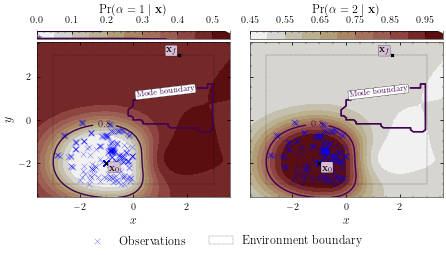

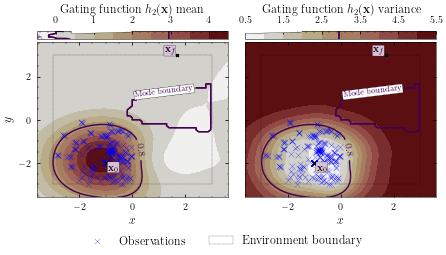

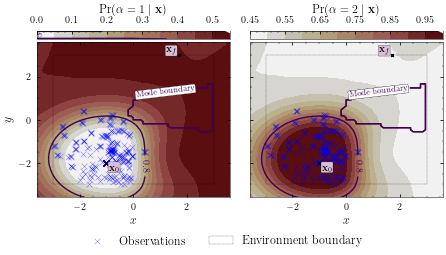

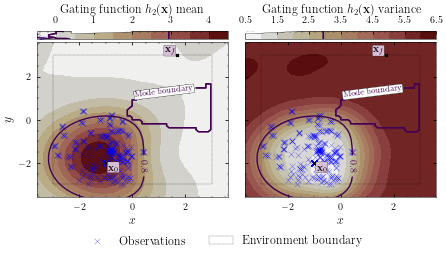

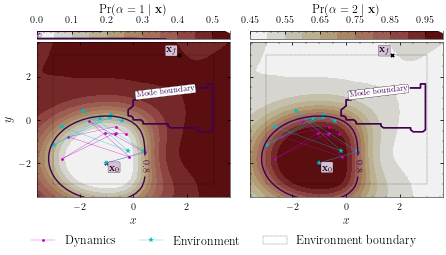

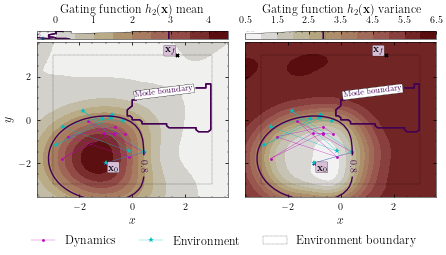

Epoch 1/10000
1/1 [==============================] - 1s 623ms/step - loss: -531.5281 - val_loss: -175.8900
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_5_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -1.6823

2022-04-08 14:50:44.352291: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 14:50:44.352314: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 4s 4s/step - loss: -1.6823 - val_loss: -193.6375
Epoch 3/10000
1/1 [==============================] - ETA: 0s - loss: -314.9354

2022-04-08 14:50:47.955174: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 14:50:47.978915: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 14:50:47.995841: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_50_47

2022-04-08 14:50:48.005829: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_50_47/dr-robots-mbp.local.trace.json.gz
2022-04-08 14:50:48.050646: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_50_47

2022-04-08 14:50:48.051653: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

1/1 [==============================] - 0s 84ms/step - loss: -314.9354 - val_loss: -157.7834
Epoch 4/10000
1/1 [==============================] - 0s 55ms/step - loss: -484.8744 - val_loss: -219.2557
Epoch 5/10000
1/1 [==============================] - 0s 52ms/step - loss: -546.2832 - val_loss: -234.4037
Epoch 6/10000
1/1 [==============================] - 0s 51ms/step - loss: -342.6814 - val_loss: -193.3397
Epoch 7/10000
1/1 [==============================] - 0s 50ms/step - loss: -550.6368 - val_loss: -247.5515
Epoch 8/10000
1/1 [==============================] - 0s 50ms/step - loss: -571.8245 - val_loss: -246.9550
Epoch 9/10000
1/1 [==============================] - 0s 56ms/step - loss: -575.5694 - val_loss: -216.9610
Epoch 10/10000
1/1 [==============================] - 0s 53ms/step - loss: -561.2218 - val_loss: -229.9553
Epoch 11/10000
1/1 [==============================] - 0s 55ms/step - loss: -486.7305 - val_loss: -230.2107
Epoch 12/10000
1/1 [==============================] - 0s 6

Epoch 80/10000
1/1 [==============================] - 0s 48ms/step - loss: -675.9316 - val_loss: -336.7574
Epoch 81/10000
1/1 [==============================] - 0s 54ms/step - loss: -682.6492 - val_loss: -317.9527
Epoch 82/10000
1/1 [==============================] - 0s 55ms/step - loss: -634.1692 - val_loss: -272.8565
Epoch 83/10000
1/1 [==============================] - 0s 52ms/step - loss: -675.5029 - val_loss: -356.6635
Epoch 84/10000
1/1 [==============================] - 0s 54ms/step - loss: -661.7620 - val_loss: -325.1013
Epoch 85/10000
1/1 [==============================] - 0s 60ms/step - loss: -665.3553 - val_loss: -329.8385
Epoch 86/10000
1/1 [==============================] - 0s 61ms/step - loss: -674.4213 - val_loss: -228.9248
Epoch 87/10000
1/1 [==============================] - 0s 53ms/step - loss: -676.0958 - val_loss: -288.4890
Epoch 88/10000
1/1 [==============================] - 0s 56ms/step - loss: -688.5994 - val_loss: -290.9927
Epoch 89/10000
1/1 [=================

Epoch 156/10000
1/1 [==============================] - 0s 71ms/step - loss: -362.1620 - val_loss: -314.0642
Epoch 157/10000
1/1 [==============================] - 0s 55ms/step - loss: -690.3995 - val_loss: -342.5423
Epoch 158/10000
1/1 [==============================] - 0s 61ms/step - loss: -623.8904 - val_loss: -344.7371
Epoch 159/10000
1/1 [==============================] - 0s 57ms/step - loss: -628.2572 - val_loss: -335.2355
Epoch 160/10000
1/1 [==============================] - 0s 66ms/step - loss: -678.4836 - val_loss: -347.6854
Epoch 161/10000
1/1 [==============================] - 0s 52ms/step - loss: -668.2988 - val_loss: -381.3294
Epoch 162/10000
1/1 [==============================] - 0s 53ms/step - loss: -612.9376 - val_loss: -312.6530
Epoch 163/10000
1/1 [==============================] - 0s 63ms/step - loss: -575.8081 - val_loss: -303.0856
Epoch 164/10000
1/1 [==============================] - 0s 58ms/step - loss: -682.5113 - val_loss: -359.6971
Epoch 165/10000
1/1 [=======

Epoch 232/10000
1/1 [==============================] - 0s 46ms/step - loss: -458.6856 - val_loss: -302.4245
Epoch 233/10000
1/1 [==============================] - 0s 45ms/step - loss: -511.9255 - val_loss: -262.2770
Epoch 234/10000
1/1 [==============================] - 0s 47ms/step - loss: -588.3710 - val_loss: -298.9318
Epoch 235/10000
1/1 [==============================] - 0s 50ms/step - loss: -593.0739 - val_loss: -286.6896
Epoch 236/10000
1/1 [==============================] - 0s 54ms/step - loss: -495.2592 - val_loss: -250.9511
Epoch 237/10000
1/1 [==============================] - 0s 57ms/step - loss: -563.0028 - val_loss: -279.8950
Epoch 238/10000
1/1 [==============================] - 0s 52ms/step - loss: -563.1402 - val_loss: -204.1437
Epoch 239/10000
1/1 [==============================] - 0s 55ms/step - loss: -579.5331 - val_loss: -222.4328
Epoch 240/10000
1/1 [==============================] - 0s 54ms/step - loss: -581.1719 - val_loss: -281.5071
Epoch 241/10000
1/1 [=======

Epoch 308/10000
1/1 [==============================] - 0s 46ms/step - loss: -691.0746 - val_loss: -305.6765
Epoch 309/10000
1/1 [==============================] - 0s 47ms/step - loss: -674.5180 - val_loss: -340.1428
Epoch 310/10000
1/1 [==============================] - 0s 46ms/step - loss: -666.3355 - val_loss: -327.0182
Epoch 311/10000
1/1 [==============================] - 0s 47ms/step - loss: -630.1761 - val_loss: -316.1571
Epoch 312/10000
1/1 [==============================] - 0s 46ms/step - loss: -669.2425 - val_loss: -359.2017
Epoch 313/10000
1/1 [==============================] - 0s 48ms/step - loss: -619.5725 - val_loss: -330.4801
Epoch 314/10000
1/1 [==============================] - 0s 51ms/step - loss: -703.5819 - val_loss: -342.9885
Epoch 315/10000
1/1 [==============================] - 0s 49ms/step - loss: -609.1152 - val_loss: -354.7466
Epoch 316/10000
1/1 [==============================] - 0s 50ms/step - loss: -662.2643 - val_loss: -306.3597
Epoch 317/10000
1/1 [=======

Epoch 384/10000
1/1 [==============================] - 0s 53ms/step - loss: -581.5473 - val_loss: -268.7907
Epoch 385/10000
1/1 [==============================] - 0s 50ms/step - loss: -627.4888 - val_loss: -308.5959
Epoch 386/10000
1/1 [==============================] - 0s 46ms/step - loss: -619.9272 - val_loss: -305.6103
Epoch 387/10000
1/1 [==============================] - 0s 47ms/step - loss: -568.0167 - val_loss: -290.3771
Epoch 388/10000
1/1 [==============================] - 0s 49ms/step - loss: -457.9023 - val_loss: -209.7829
Epoch 389/10000
1/1 [==============================] - 0s 52ms/step - loss: -617.7778 - val_loss: -306.7656
Epoch 390/10000
1/1 [==============================] - 0s 54ms/step - loss: -597.8310 - val_loss: -292.5847
Epoch 391/10000
1/1 [==============================] - 0s 53ms/step - loss: -511.3362 - val_loss: -289.9027
Epoch 392/10000
1/1 [==============================] - 0s 52ms/step - loss: -610.0770 - val_loss: -314.7331
Epoch 393/10000
1/1 [=======

Epoch 460/10000
1/1 [==============================] - 0s 41ms/step - loss: -642.0283 - val_loss: -389.2074
Epoch 461/10000
1/1 [==============================] - 0s 42ms/step - loss: -686.1062 - val_loss: -379.8382
Epoch 462/10000
1/1 [==============================] - 0s 40ms/step - loss: -686.8048 - val_loss: -398.6815
Epoch 463/10000
1/1 [==============================] - 0s 41ms/step - loss: -653.2295 - val_loss: -364.5005
Epoch 464/10000
1/1 [==============================] - 0s 62ms/step - loss: -632.6671 - val_loss: -326.8597
Epoch 465/10000
1/1 [==============================] - 0s 90ms/step - loss: -607.9369 - val_loss: -285.5393
Epoch 466/10000
1/1 [==============================] - 0s 56ms/step - loss: -683.1572 - val_loss: -369.7153
Epoch 467/10000
1/1 [==============================] - 0s 53ms/step - loss: -682.7418 - val_loss: -345.6731
Epoch 468/10000
1/1 [==============================] - 0s 52ms/step - loss: -683.0603 - val_loss: -328.3839
Epoch 469/10000
1/1 [=======

Epoch 536/10000
1/1 [==============================] - 0s 41ms/step - loss: -449.7996 - val_loss: -387.1100
Epoch 537/10000
1/1 [==============================] - 0s 40ms/step - loss: -638.9318 - val_loss: -394.7712
Epoch 538/10000
1/1 [==============================] - 0s 41ms/step - loss: -600.4342 - val_loss: -341.6662
Epoch 539/10000
1/1 [==============================] - 0s 42ms/step - loss: -606.2112 - val_loss: -383.2886
Epoch 540/10000
1/1 [==============================] - 0s 41ms/step - loss: -589.3536 - val_loss: -372.2318
Epoch 541/10000
1/1 [==============================] - 0s 40ms/step - loss: -670.8837 - val_loss: -378.8529
Epoch 542/10000
1/1 [==============================] - 0s 40ms/step - loss: -598.9446 - val_loss: -335.6261
Epoch 543/10000
1/1 [==============================] - 0s 40ms/step - loss: -535.4025 - val_loss: -266.0942
Epoch 544/10000
1/1 [==============================] - 0s 41ms/step - loss: -599.0724 - val_loss: -337.4563
Epoch 545/10000
1/1 [=======

Epoch 612/10000
1/1 [==============================] - 0s 40ms/step - loss: -595.5840 - val_loss: -312.9735
Epoch 613/10000
1/1 [==============================] - 0s 39ms/step - loss: -613.9078 - val_loss: -333.5012
Epoch 614/10000
1/1 [==============================] - 0s 40ms/step - loss: -600.2345 - val_loss: -263.6395
Epoch 615/10000
1/1 [==============================] - 0s 40ms/step - loss: -630.5690 - val_loss: -311.7482
Epoch 616/10000
1/1 [==============================] - 0s 40ms/step - loss: -616.7426 - val_loss: -312.8306
Epoch 617/10000
1/1 [==============================] - 0s 39ms/step - loss: -610.3110 - val_loss: -329.3852
Epoch 618/10000
1/1 [==============================] - 0s 40ms/step - loss: -630.3348 - val_loss: -290.2245
Epoch 619/10000
1/1 [==============================] - 0s 39ms/step - loss: -617.1770 - val_loss: -318.6730
Epoch 620/10000
1/1 [==============================] - 0s 40ms/step - loss: -637.5062 - val_loss: -300.6259
Epoch 621/10000
1/1 [=======

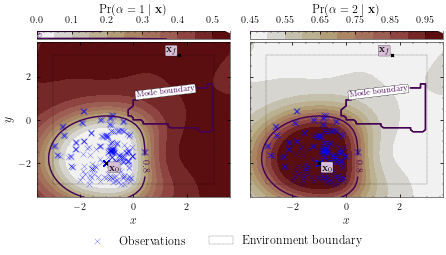

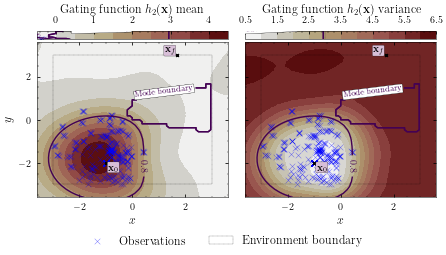

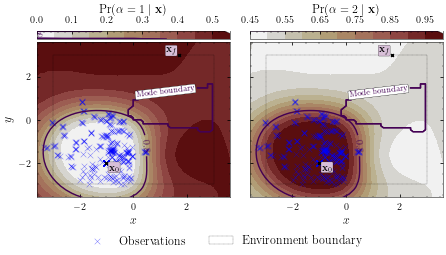

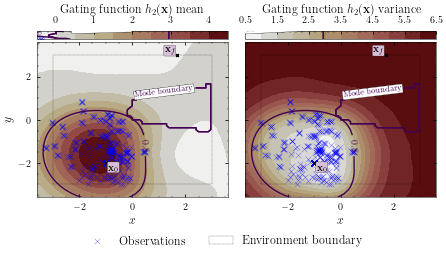

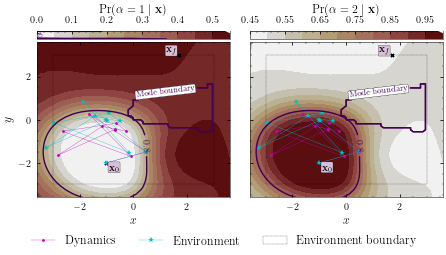

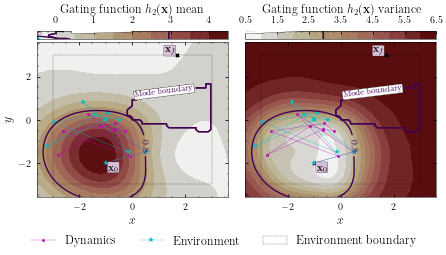

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -574.3063 - val_loss: -201.7463
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_6_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -618.8737

2022-04-08 14:54:03.916031: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 14:54:03.916044: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -618.8737 - val_loss: -200.1930
Epoch 3/10000
1/1 [==============================] - 0s 30ms/step - loss: -587.7974 - val_loss: -190.4285
Epoch 4/10000
1/1 [==============================] - 0s 31ms/step - loss: -611.7118 - val_loss: -185.5769
Epoch 5/10000
1/1 [==============================] - 0s 31ms/step - loss: -605.3629 - val_loss: -195.7360
Epoch 6/10000
1/1 [==============================] - ETA: 0s - loss: -637.4291

2022-04-08 14:54:05.964748: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 14:54:05.974881: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 14:54:05.981651: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_54_05

2022-04-08 14:54:05.987397: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_54_05/dr-robots-mbp.local.trace.json.gz
2022-04-08 14:54:06.007094: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_54_05

2022-04-08 14:54:06.007745: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

1/1 [==============================] - 0s 30ms/step - loss: -637.4291 - val_loss: -200.1466
Epoch 7/10000
1/1 [==============================] - 0s 30ms/step - loss: -623.9205 - val_loss: -213.9964
Epoch 8/10000
1/1 [==============================] - 0s 31ms/step - loss: -602.3378 - val_loss: -217.6822
Epoch 9/10000
1/1 [==============================] - 0s 47ms/step - loss: -607.0929 - val_loss: -264.9009
Epoch 10/10000
1/1 [==============================] - 0s 37ms/step - loss: -588.9969 - val_loss: -218.7280
Epoch 11/10000
1/1 [==============================] - 0s 40ms/step - loss: -620.6515 - val_loss: -134.8098
Epoch 12/10000
1/1 [==============================] - 0s 35ms/step - loss: -644.6440 - val_loss: -208.3891
Epoch 13/10000
1/1 [==============================] - 0s 34ms/step - loss: -604.6929 - val_loss: -209.4205
Epoch 14/10000
1/1 [==============================] - 0s 33ms/step - loss: -566.5759 - val_loss: -162.0769
Epoch 15/10000
1/1 [==============================] - 0

Epoch 83/10000
1/1 [==============================] - 0s 35ms/step - loss: -676.9277 - val_loss: -283.7845
Epoch 84/10000
1/1 [==============================] - 0s 37ms/step - loss: -684.7220 - val_loss: -279.6889
Epoch 85/10000
1/1 [==============================] - 0s 36ms/step - loss: -691.6598 - val_loss: -290.3703
Epoch 86/10000
1/1 [==============================] - 0s 36ms/step - loss: -651.6389 - val_loss: -200.2224
Epoch 87/10000
1/1 [==============================] - 0s 35ms/step - loss: -676.4522 - val_loss: -274.7788
Epoch 88/10000
1/1 [==============================] - 0s 36ms/step - loss: -645.4826 - val_loss: -284.6580
Epoch 89/10000
1/1 [==============================] - 0s 37ms/step - loss: -688.7022 - val_loss: -308.1674
Epoch 90/10000
1/1 [==============================] - 0s 36ms/step - loss: -611.6895 - val_loss: -286.9413
Epoch 91/10000
1/1 [==============================] - 0s 36ms/step - loss: -663.7377 - val_loss: -197.9128
Epoch 92/10000
1/1 [=================

1/1 [==============================] - 0s 36ms/step - loss: -622.3485 - val_loss: -264.8292
Epoch 160/10000
1/1 [==============================] - 0s 35ms/step - loss: -549.8281 - val_loss: -282.5540
Epoch 161/10000
1/1 [==============================] - 0s 36ms/step - loss: -528.0769 - val_loss: -259.5445
Epoch 162/10000
1/1 [==============================] - 0s 37ms/step - loss: -440.9683 - val_loss: -271.2610
Epoch 163/10000
1/1 [==============================] - 0s 37ms/step - loss: -394.4565 - val_loss: -260.5027
Epoch 164/10000
1/1 [==============================] - 0s 36ms/step - loss: -374.7353 - val_loss: -98.3016
Epoch 165/10000
1/1 [==============================] - 0s 37ms/step - loss: -539.0456 - val_loss: -246.6271
Epoch 166/10000
1/1 [==============================] - 0s 38ms/step - loss: -617.6986 - val_loss: -238.9395
Epoch 167/10000
1/1 [==============================] - 0s 38ms/step - loss: -628.6389 - val_loss: -275.9499
Epoch 168/10000
1/1 [========================

1/1 [==============================] - 0s 36ms/step - loss: -598.1629 - val_loss: -307.8479
Epoch 236/10000
1/1 [==============================] - 0s 36ms/step - loss: -617.5905 - val_loss: -311.1659
Epoch 237/10000
1/1 [==============================] - 0s 37ms/step - loss: -573.1362 - val_loss: -245.4052
Epoch 238/10000
1/1 [==============================] - 0s 37ms/step - loss: -623.4420 - val_loss: -291.0518
Epoch 239/10000
1/1 [==============================] - 0s 35ms/step - loss: -617.1661 - val_loss: -246.6125
Epoch 240/10000
1/1 [==============================] - 0s 37ms/step - loss: -625.3712 - val_loss: -292.5814
Epoch 241/10000
1/1 [==============================] - 0s 36ms/step - loss: -617.6319 - val_loss: -278.2459
Epoch 242/10000
1/1 [==============================] - 0s 36ms/step - loss: -585.4833 - val_loss: -303.7021
Epoch 243/10000
1/1 [==============================] - 0s 36ms/step - loss: -554.5164 - val_loss: -234.3565
Epoch 244/10000
1/1 [=======================

1/1 [==============================] - 0s 36ms/step - loss: -582.3926 - val_loss: -350.0430
Epoch 312/10000
1/1 [==============================] - 0s 37ms/step - loss: -598.7710 - val_loss: -270.5600
Epoch 313/10000
1/1 [==============================] - 0s 39ms/step - loss: -677.5806 - val_loss: -323.3120
Epoch 314/10000
1/1 [==============================] - 0s 38ms/step - loss: -704.4030 - val_loss: -341.7941
Epoch 315/10000
1/1 [==============================] - 0s 36ms/step - loss: -609.4832 - val_loss: -259.6691
Epoch 316/10000
1/1 [==============================] - 0s 37ms/step - loss: -551.4670 - val_loss: -251.0924
Epoch 317/10000
1/1 [==============================] - 0s 38ms/step - loss: -666.4541 - val_loss: -310.7235
Epoch 318/10000
1/1 [==============================] - 0s 36ms/step - loss: -617.0840 - val_loss: -249.4440
Epoch 319/10000
1/1 [==============================] - 0s 37ms/step - loss: -631.2696 - val_loss: -317.7995
Epoch 320/10000
1/1 [=======================

1/1 [==============================] - 0s 38ms/step - loss: -637.6749 - val_loss: -227.8869
Epoch 388/10000
1/1 [==============================] - 0s 35ms/step - loss: -607.2471 - val_loss: -372.2088
Epoch 389/10000
1/1 [==============================] - 0s 36ms/step - loss: -622.9291 - val_loss: -294.2825
Epoch 390/10000
1/1 [==============================] - 0s 37ms/step - loss: -595.7595 - val_loss: -304.1424
Epoch 391/10000
1/1 [==============================] - 0s 37ms/step - loss: -610.1132 - val_loss: -341.2589
Epoch 392/10000
1/1 [==============================] - 0s 36ms/step - loss: -569.4684 - val_loss: -268.4372
Epoch 393/10000
1/1 [==============================] - 0s 41ms/step - loss: -602.8404 - val_loss: -173.3139
Epoch 394/10000
1/1 [==============================] - 0s 37ms/step - loss: -565.9413 - val_loss: -237.2176
Epoch 395/10000
1/1 [==============================] - 0s 36ms/step - loss: -592.5955 - val_loss: -152.9657
Epoch 396/10000
1/1 [=======================

1/1 [==============================] - 0s 43ms/step - loss: -676.2210 - val_loss: -328.1709
Epoch 464/10000
1/1 [==============================] - 0s 43ms/step - loss: -628.9288 - val_loss: -272.0957
Epoch 465/10000
1/1 [==============================] - 0s 43ms/step - loss: -633.7833 - val_loss: -226.3016
Epoch 466/10000
1/1 [==============================] - 0s 45ms/step - loss: -638.1221 - val_loss: -311.3515
Epoch 467/10000
1/1 [==============================] - 0s 42ms/step - loss: -658.5997 - val_loss: -276.1186
Epoch 468/10000
1/1 [==============================] - 0s 41ms/step - loss: -640.9309 - val_loss: -361.7216
Epoch 469/10000
1/1 [==============================] - 0s 44ms/step - loss: -614.5199 - val_loss: -324.5461
Epoch 470/10000
1/1 [==============================] - 0s 43ms/step - loss: -605.0941 - val_loss: -321.6191
Epoch 471/10000
1/1 [==============================] - 0s 41ms/step - loss: -604.5939 - val_loss: -335.7508
Epoch 472/10000
1/1 [=======================

1/1 [==============================] - 0s 39ms/step - loss: -436.8148 - val_loss: -206.8042
Epoch 540/10000
1/1 [==============================] - 0s 38ms/step - loss: -477.9980 - val_loss: -174.9261
Epoch 541/10000
1/1 [==============================] - 0s 38ms/step - loss: -524.0235 - val_loss: -268.1044
Epoch 542/10000
1/1 [==============================] - 0s 38ms/step - loss: -498.8640 - val_loss: -263.0155
Epoch 543/10000
1/1 [==============================] - 0s 37ms/step - loss: -393.8471 - val_loss: -191.0297
Epoch 544/10000
1/1 [==============================] - 0s 37ms/step - loss: -170.4694 - val_loss: -80.2856
Epoch 545/10000
1/1 [==============================] - 0s 37ms/step - loss: -525.6326 - val_loss: -222.8780
Epoch 546/10000
1/1 [==============================] - 0s 38ms/step - loss: -509.9134 - val_loss: -187.5788
Epoch 547/10000
1/1 [==============================] - 0s 37ms/step - loss: -421.8483 - val_loss: -225.1056
Epoch 548/10000
1/1 [========================

1/1 [==============================] - 0s 37ms/step - loss: -649.2415 - val_loss: -243.6687
Epoch 616/10000
1/1 [==============================] - 0s 37ms/step - loss: -630.0383 - val_loss: -295.8467
Epoch 617/10000
1/1 [==============================] - 0s 38ms/step - loss: -649.4231 - val_loss: -315.0391
Epoch 618/10000
1/1 [==============================] - 0s 37ms/step - loss: -628.5138 - val_loss: -321.3241
Epoch 619/10000
1/1 [==============================] - 0s 36ms/step - loss: -664.4996 - val_loss: -362.0354
Epoch 620/10000
1/1 [==============================] - 0s 37ms/step - loss: -600.7317 - val_loss: -254.2511
Epoch 621/10000
1/1 [==============================] - 0s 38ms/step - loss: -663.0523 - val_loss: -309.2884
Epoch 622/10000
1/1 [==============================] - 0s 38ms/step - loss: -656.7512 - val_loss: -325.0096
Epoch 623/10000
1/1 [==============================] - 0s 36ms/step - loss: -643.7173 - val_loss: -353.4086
Epoch 624/10000
1/1 [=======================

1/1 [==============================] - 0s 40ms/step - loss: -588.8919 - val_loss: -351.8438
Epoch 692/10000
1/1 [==============================] - 0s 39ms/step - loss: -467.0413 - val_loss: -236.5401
Epoch 693/10000
1/1 [==============================] - 0s 39ms/step - loss: -546.4188 - val_loss: -355.7415
Epoch 694/10000
1/1 [==============================] - 0s 38ms/step - loss: -644.1477 - val_loss: -299.2443
Epoch 695/10000
1/1 [==============================] - 0s 39ms/step - loss: -580.4678 - val_loss: -321.9674
Epoch 696/10000
1/1 [==============================] - 0s 39ms/step - loss: -516.7883 - val_loss: -304.0928
Epoch 697/10000
1/1 [==============================] - 0s 38ms/step - loss: -592.3903 - val_loss: -324.8676
Epoch 698/10000
1/1 [==============================] - 0s 40ms/step - loss: -558.5074 - val_loss: -289.7803
Epoch 699/10000
1/1 [==============================] - 0s 39ms/step - loss: -550.0935 - val_loss: -328.6808
Epoch 700/10000
1/1 [=======================

1/1 [==============================] - 0s 42ms/step - loss: -474.2526 - val_loss: -198.5663
Epoch 768/10000
1/1 [==============================] - 0s 43ms/step - loss: -308.4278 - val_loss: 248.0073
Epoch 769/10000
1/1 [==============================] - 0s 43ms/step - loss: -522.1992 - val_loss: -231.1114
Epoch 770/10000
1/1 [==============================] - 0s 48ms/step - loss: -523.5409 - val_loss: -248.4815
Epoch 771/10000
1/1 [==============================] - 0s 47ms/step - loss: -546.0834 - val_loss: -246.3915
Epoch 772/10000
1/1 [==============================] - 0s 47ms/step - loss: -420.2444 - val_loss: 84.7219
Epoch 773/10000
1/1 [==============================] - 0s 49ms/step - loss: -428.1779 - val_loss: -190.9694
Epoch 774/10000
1/1 [==============================] - 0s 47ms/step - loss: -368.5119 - val_loss: 105.1353
Epoch 775/10000
1/1 [==============================] - 0s 45ms/step - loss: -556.1684 - val_loss: -246.1970
Epoch 776/10000
1/1 [===========================

1/1 [==============================] - 0s 44ms/step - loss: -517.5065 - val_loss: -50.3317
Epoch 844/10000
1/1 [==============================] - 0s 45ms/step - loss: -594.5040 - val_loss: -229.4644
Epoch 845/10000
1/1 [==============================] - 0s 43ms/step - loss: -613.7442 - val_loss: -323.2616
Epoch 846/10000
1/1 [==============================] - 0s 45ms/step - loss: -555.8383 - val_loss: -289.9384
Epoch 847/10000
1/1 [==============================] - 0s 43ms/step - loss: -560.4854 - val_loss: -269.5376
Epoch 848/10000
1/1 [==============================] - 0s 44ms/step - loss: -544.0470 - val_loss: -169.4188
Epoch 849/10000
1/1 [==============================] - 0s 46ms/step - loss: -559.6826 - val_loss: -236.7207
Epoch 850/10000
1/1 [==============================] - 0s 44ms/step - loss: -606.0366 - val_loss: -189.2252
Epoch 851/10000
1/1 [==============================] - 0s 44ms/step - loss: -305.9764 - val_loss: 12.1179
Epoch 852/10000
1/1 [==========================

1/1 [==============================] - 0s 43ms/step - loss: -424.3963 - val_loss: -256.6510
Epoch 920/10000
1/1 [==============================] - 0s 45ms/step - loss: -119.7649 - val_loss: -234.3830
Epoch 921/10000
1/1 [==============================] - 0s 43ms/step - loss: -350.3555 - val_loss: -281.0142
Epoch 922/10000
1/1 [==============================] - 0s 43ms/step - loss: -518.3531 - val_loss: -291.3798
Epoch 923/10000
1/1 [==============================] - 0s 44ms/step - loss: -584.5896 - val_loss: -251.9031
Epoch 924/10000
1/1 [==============================] - 0s 45ms/step - loss: -530.4620 - val_loss: -269.0203
Epoch 925/10000
1/1 [==============================] - 0s 44ms/step - loss: -544.9101 - val_loss: -282.0169
Epoch 926/10000
1/1 [==============================] - 0s 43ms/step - loss: -175.1891 - val_loss: -129.7734
Epoch 927/10000
1/1 [==============================] - 0s 44ms/step - loss: -595.3482 - val_loss: -299.6219
Epoch 928/10000
1/1 [=======================

1/1 [==============================] - 0s 44ms/step - loss: -460.3475 - val_loss: 216.2839
Epoch 996/10000
1/1 [==============================] - 0s 45ms/step - loss: -576.7479 - val_loss: -311.8938
Epoch 997/10000
1/1 [==============================] - 0s 44ms/step - loss: -641.3492 - val_loss: -292.3942
Epoch 998/10000
1/1 [==============================] - 0s 43ms/step - loss: -569.6442 - val_loss: -290.6574
Epoch 999/10000
1/1 [==============================] - 0s 43ms/step - loss: -632.8255 - val_loss: -307.7963
Epoch 1000/10000
1/1 [==============================] - 0s 43ms/step - loss: -596.8308 - val_loss: -159.7915
Epoch 1001/10000
1/1 [==============================] - 0s 43ms/step - loss: -572.1376 - val_loss: -241.6980
Epoch 1002/10000
1/1 [==============================] - 0s 43ms/step - loss: -490.3824 - val_loss: -82.4337
Epoch 1003/10000
1/1 [==============================] - 0s 42ms/step - loss: -562.3277 - val_loss: -333.1571
Epoch 1004/10000
1/1 [====================

1/1 [==============================] - 0s 68ms/step - loss: -555.6237 - val_loss: -199.8727
Epoch 1071/10000
1/1 [==============================] - 0s 45ms/step - loss: -369.4406 - val_loss: -45.4801
Epoch 1072/10000
1/1 [==============================] - 0s 42ms/step - loss: -486.8402 - val_loss: -225.5097
Epoch 1073/10000
1/1 [==============================] - 0s 41ms/step - loss: -552.2282 - val_loss: -311.1995
Epoch 1074/10000
1/1 [==============================] - 0s 43ms/step - loss: -469.3567 - val_loss: -286.4511
Epoch 1075/10000
1/1 [==============================] - 0s 42ms/step - loss: -555.8616 - val_loss: -46.8444
Epoch 1076/10000
1/1 [==============================] - 0s 47ms/step - loss: -349.4839 - val_loss: -162.1915
Epoch 1077/10000
1/1 [==============================] - 0s 44ms/step - loss: -468.4012 - val_loss: -311.8665
Epoch 1078/10000
1/1 [==============================] - 0s 45ms/step - loss: -630.4281 - val_loss: -310.8649
Epoch 1079/10000
1/1 [================

1/1 [==============================] - 0s 52ms/step - loss: -544.0417 - val_loss: -140.5592
Epoch 1146/10000
1/1 [==============================] - 0s 51ms/step - loss: -561.1393 - val_loss: -160.3247
Epoch 1147/10000
1/1 [==============================] - 0s 54ms/step - loss: -635.3155 - val_loss: -319.2295
Epoch 1148/10000
1/1 [==============================] - 0s 53ms/step - loss: -616.2643 - val_loss: -314.1266
Epoch 1149/10000
1/1 [==============================] - 0s 60ms/step - loss: -624.9311 - val_loss: -321.1481
Epoch 1150/10000
1/1 [==============================] - 0s 55ms/step - loss: -586.9122 - val_loss: -209.3521
Epoch 1151/10000
1/1 [==============================] - 0s 47ms/step - loss: -505.7647 - val_loss: -233.9972
Epoch 1152/10000
1/1 [==============================] - 0s 49ms/step - loss: -628.7337 - val_loss: -333.7845
Epoch 1153/10000
1/1 [==============================] - 0s 47ms/step - loss: -598.7740 - val_loss: -341.6172
mode_probs.shape
(10, 2)
(10, 2)
(10

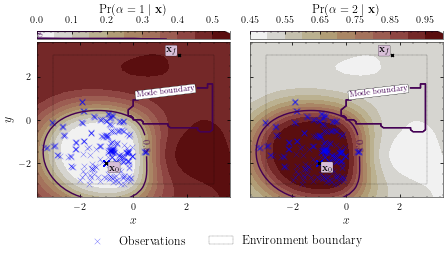

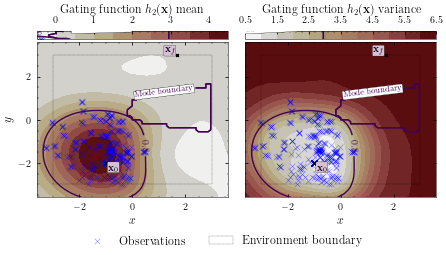

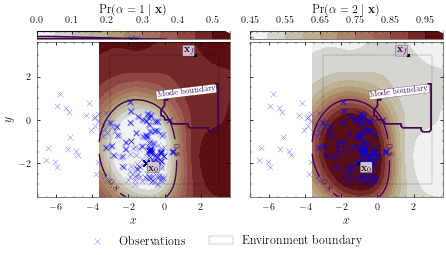

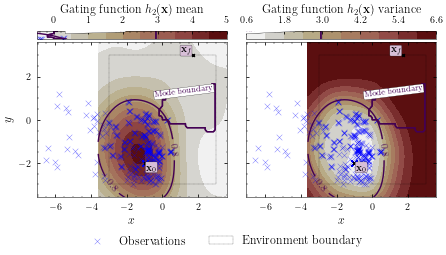

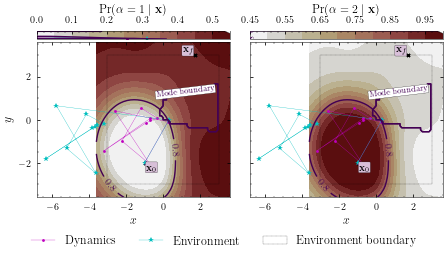

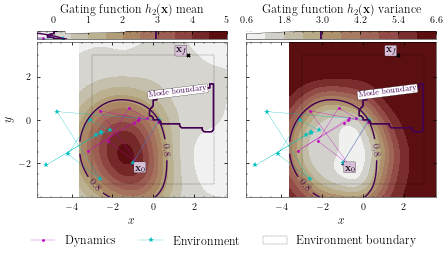

Epoch 1/10000
1/1 [==============================] - 1s 897ms/step - loss: -583.9998 - val_loss: 36.1779
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_7_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -578.8723

2022-04-08 14:57:46.202665: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 14:57:46.202693: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 4s 4s/step - loss: -578.8723 - val_loss: 144.9016
Epoch 3/10000
1/1 [==============================] - ETA: 0s - loss: -555.4504

2022-04-08 14:57:49.875963: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 14:57:49.900207: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 14:57:49.916651: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_57_49

2022-04-08 14:57:49.928909: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_57_49/dr-robots-mbp.local.trace.json.gz
2022-04-08 14:57:49.977178: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_14_57_49

2022-04-08 14:57:49.978184: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

1/1 [==============================] - 0s 85ms/step - loss: -555.4504 - val_loss: 343.1942
Epoch 4/10000
1/1 [==============================] - 0s 90ms/step - loss: -606.5947 - val_loss: 193.8758
Epoch 5/10000
1/1 [==============================] - 0s 96ms/step - loss: -560.1592 - val_loss: 298.3238
Epoch 6/10000
1/1 [==============================] - 0s 61ms/step - loss: -546.7841 - val_loss: 394.1122
Epoch 7/10000
1/1 [==============================] - 0s 63ms/step - loss: -592.8359 - val_loss: 20.7598
Epoch 8/10000
1/1 [==============================] - 0s 75ms/step - loss: -589.2589 - val_loss: 56.9900
Epoch 9/10000
1/1 [==============================] - 0s 69ms/step - loss: -591.6746 - val_loss: 42.2255
Epoch 10/10000
1/1 [==============================] - 0s 75ms/step - loss: -550.2441 - val_loss: 290.6370
Epoch 11/10000
1/1 [==============================] - 0s 66ms/step - loss: -626.8322 - val_loss: 47.5226
Epoch 12/10000
1/1 [==============================] - 0s 71ms/step - lo

1/1 [==============================] - 0s 62ms/step - loss: -326.7212 - val_loss: 400.9255
Epoch 81/10000
1/1 [==============================] - 0s 63ms/step - loss: -617.6475 - val_loss: 219.5131
Epoch 82/10000
1/1 [==============================] - 0s 83ms/step - loss: -625.4143 - val_loss: 344.9911
Epoch 83/10000
1/1 [==============================] - 0s 72ms/step - loss: -620.1378 - val_loss: 105.0076
Epoch 84/10000
1/1 [==============================] - 0s 65ms/step - loss: -538.0110 - val_loss: 532.4075
Epoch 85/10000
1/1 [==============================] - 0s 68ms/step - loss: -581.0467 - val_loss: 90.7653
Epoch 86/10000
1/1 [==============================] - 0s 63ms/step - loss: -486.5158 - val_loss: 319.1428
Epoch 87/10000
1/1 [==============================] - 0s 76ms/step - loss: -455.2923 - val_loss: 456.7655
Epoch 88/10000
1/1 [==============================] - 0s 66ms/step - loss: -629.0555 - val_loss: 164.7384
Epoch 89/10000
1/1 [==============================] - 0s 62ms/

Epoch 157/10000
1/1 [==============================] - 0s 84ms/step - loss: -642.7644 - val_loss: 191.6513
Epoch 158/10000
1/1 [==============================] - 0s 77ms/step - loss: -629.7067 - val_loss: 120.9169
Epoch 159/10000
1/1 [==============================] - 0s 81ms/step - loss: -592.9246 - val_loss: 160.1401
Epoch 160/10000
1/1 [==============================] - 0s 83ms/step - loss: -549.1153 - val_loss: 482.1782
Epoch 161/10000
1/1 [==============================] - 0s 77ms/step - loss: -515.5836 - val_loss: 258.6790
Epoch 162/10000
1/1 [==============================] - 0s 72ms/step - loss: -591.6424 - val_loss: 480.5662
Epoch 163/10000
1/1 [==============================] - 0s 70ms/step - loss: -436.0201 - val_loss: 366.5350
Epoch 164/10000
1/1 [==============================] - 0s 82ms/step - loss: -570.6783 - val_loss: 213.7049
Epoch 165/10000
1/1 [==============================] - 0s 79ms/step - loss: -456.7680 - val_loss: 235.3461
Epoch 166/10000
1/1 [================

1/1 [==============================] - 0s 84ms/step - loss: -445.3455 - val_loss: 284.2345
Epoch 234/10000
1/1 [==============================] - 0s 86ms/step - loss: -578.9471 - val_loss: 295.8599
Epoch 235/10000
1/1 [==============================] - 0s 98ms/step - loss: -603.7509 - val_loss: 14.3614
Epoch 236/10000
1/1 [==============================] - 0s 90ms/step - loss: -652.1734 - val_loss: -17.0391
Epoch 237/10000
1/1 [==============================] - 0s 92ms/step - loss: -554.9465 - val_loss: 323.3001
Epoch 238/10000
1/1 [==============================] - 0s 85ms/step - loss: -496.6155 - val_loss: 125.4235
Epoch 239/10000
1/1 [==============================] - 0s 83ms/step - loss: -478.3161 - val_loss: 353.2699
Epoch 240/10000
1/1 [==============================] - 0s 106ms/step - loss: -405.4054 - val_loss: 135.0461
Epoch 241/10000
1/1 [==============================] - 0s 87ms/step - loss: -564.9289 - val_loss: 298.6316
Epoch 242/10000
1/1 [==============================] 

Epoch 310/10000
1/1 [==============================] - 0s 80ms/step - loss: -577.5124 - val_loss: 141.8305
Epoch 311/10000
1/1 [==============================] - 0s 81ms/step - loss: -625.2784 - val_loss: 166.1842
Epoch 312/10000
1/1 [==============================] - 0s 88ms/step - loss: -554.6758 - val_loss: 148.4515
Epoch 313/10000
1/1 [==============================] - 0s 85ms/step - loss: -474.4327 - val_loss: 327.1077
Epoch 314/10000
1/1 [==============================] - 0s 81ms/step - loss: -552.6412 - val_loss: -37.4469
Epoch 315/10000
1/1 [==============================] - 0s 84ms/step - loss: -586.9363 - val_loss: 396.2394
Epoch 316/10000
1/1 [==============================] - 0s 76ms/step - loss: -587.9840 - val_loss: 314.4454
Epoch 317/10000
1/1 [==============================] - 0s 86ms/step - loss: -581.4949 - val_loss: 281.0560
Epoch 318/10000
1/1 [==============================] - 0s 84ms/step - loss: -364.2889 - val_loss: 207.2306
Epoch 319/10000
1/1 [================

1/1 [==============================] - 0s 95ms/step - loss: -566.5260 - val_loss: 354.0627
Epoch 387/10000
1/1 [==============================] - 0s 103ms/step - loss: -588.2844 - val_loss: 92.6015
Epoch 388/10000
1/1 [==============================] - 0s 90ms/step - loss: -609.1570 - val_loss: 27.7570
Epoch 389/10000
1/1 [==============================] - 0s 93ms/step - loss: -564.7491 - val_loss: 266.0619
Epoch 390/10000
1/1 [==============================] - 0s 105ms/step - loss: -609.3637 - val_loss: 180.0709
Epoch 391/10000
1/1 [==============================] - 0s 86ms/step - loss: -599.9757 - val_loss: 303.0247
Epoch 392/10000
1/1 [==============================] - 0s 94ms/step - loss: -563.5892 - val_loss: 515.1533
Epoch 393/10000
1/1 [==============================] - 0s 95ms/step - loss: -587.2939 - val_loss: 280.6417
Epoch 394/10000
1/1 [==============================] - 0s 97ms/step - loss: -614.0779 - val_loss: 226.3163
Epoch 395/10000
1/1 [==============================] 

1/1 [==============================] - 0s 71ms/step - loss: -563.3866 - val_loss: 119.6769
Epoch 463/10000
1/1 [==============================] - 0s 72ms/step - loss: -579.2677 - val_loss: 227.7662
Epoch 464/10000
1/1 [==============================] - 0s 79ms/step - loss: -610.0330 - val_loss: 292.9836
Epoch 465/10000
1/1 [==============================] - 0s 80ms/step - loss: -333.7964 - val_loss: 376.6496
Epoch 466/10000
1/1 [==============================] - 0s 68ms/step - loss: -474.0295 - val_loss: 314.9716
Epoch 467/10000
1/1 [==============================] - 0s 69ms/step - loss: -583.9214 - val_loss: -54.9697
Epoch 468/10000
1/1 [==============================] - 0s 102ms/step - loss: -572.5551 - val_loss: 15.4828
Epoch 469/10000
1/1 [==============================] - 0s 76ms/step - loss: -600.1913 - val_loss: 12.9642
Epoch 470/10000
1/1 [==============================] - 0s 92ms/step - loss: -469.2897 - val_loss: 92.5493
Epoch 471/10000
1/1 [==============================] - 

Epoch 539/10000
1/1 [==============================] - 0s 78ms/step - loss: -618.0560 - val_loss: 222.5176
Epoch 540/10000
1/1 [==============================] - 0s 84ms/step - loss: -604.1762 - val_loss: 188.6497
Epoch 541/10000
1/1 [==============================] - 0s 90ms/step - loss: -19.1508 - val_loss: 425.2764
Epoch 542/10000
1/1 [==============================] - 0s 86ms/step - loss: -481.1755 - val_loss: 378.9380
Epoch 543/10000
1/1 [==============================] - 0s 86ms/step - loss: -518.5948 - val_loss: 285.6163
Epoch 544/10000
1/1 [==============================] - 0s 64ms/step - loss: -586.7397 - val_loss: 184.5121
Epoch 545/10000
1/1 [==============================] - 0s 61ms/step - loss: -550.9411 - val_loss: 286.0253
Epoch 546/10000
1/1 [==============================] - 0s 68ms/step - loss: -544.0309 - val_loss: 257.1658
Epoch 547/10000
1/1 [==============================] - 0s 61ms/step - loss: -624.6554 - val_loss: 334.8992
Epoch 548/10000
1/1 [=================

Epoch 616/10000
1/1 [==============================] - 0s 51ms/step - loss: -509.9654 - val_loss: 234.0998
Epoch 617/10000
1/1 [==============================] - 0s 50ms/step - loss: -541.8374 - val_loss: 236.4489
Epoch 618/10000
1/1 [==============================] - 0s 50ms/step - loss: -553.7870 - val_loss: 69.8229
Epoch 619/10000
1/1 [==============================] - 0s 50ms/step - loss: -570.1035 - val_loss: 290.0078
Epoch 620/10000
1/1 [==============================] - 0s 50ms/step - loss: -621.0893 - val_loss: 6.2215
Epoch 621/10000
1/1 [==============================] - 0s 50ms/step - loss: -619.7568 - val_loss: 11.4703
Epoch 622/10000
1/1 [==============================] - 0s 51ms/step - loss: -491.2544 - val_loss: 314.2876
Epoch 623/10000
1/1 [==============================] - 0s 51ms/step - loss: -497.3418 - val_loss: 408.0981
Epoch 624/10000
1/1 [==============================] - 0s 51ms/step - loss: -603.0237 - val_loss: 33.2764
Epoch 625/10000
1/1 [=====================

Epoch 693/10000
1/1 [==============================] - 0s 46ms/step - loss: -673.1927 - val_loss: 197.1957
Epoch 694/10000
1/1 [==============================] - 0s 48ms/step - loss: -631.4999 - val_loss: 148.9585
Epoch 695/10000
1/1 [==============================] - 0s 46ms/step - loss: -611.7063 - val_loss: 213.5979
Epoch 696/10000
1/1 [==============================] - 0s 46ms/step - loss: -648.6760 - val_loss: 32.8899
Epoch 697/10000
1/1 [==============================] - 0s 49ms/step - loss: -623.7150 - val_loss: 164.0549
Epoch 698/10000
1/1 [==============================] - 0s 46ms/step - loss: -501.4836 - val_loss: 268.7192
Epoch 699/10000
1/1 [==============================] - 0s 46ms/step - loss: -666.1308 - val_loss: 218.4523
Epoch 700/10000
1/1 [==============================] - 0s 47ms/step - loss: -679.3768 - val_loss: 128.6196
Epoch 701/10000
1/1 [==============================] - 0s 46ms/step - loss: -607.3112 - val_loss: 29.8965
Epoch 702/10000
1/1 [==================

1/1 [==============================] - 0s 43ms/step - loss: -592.5209 - val_loss: 57.7448
Epoch 770/10000
1/1 [==============================] - 0s 43ms/step - loss: -568.5431 - val_loss: 121.0545
Epoch 771/10000
1/1 [==============================] - 0s 43ms/step - loss: -496.1154 - val_loss: 292.1914
Epoch 772/10000
1/1 [==============================] - 0s 43ms/step - loss: -549.0447 - val_loss: 112.8387
Epoch 773/10000
1/1 [==============================] - 0s 43ms/step - loss: -546.3801 - val_loss: 76.2287
Epoch 774/10000
1/1 [==============================] - 0s 43ms/step - loss: -499.1260 - val_loss: 179.0448
Epoch 775/10000
1/1 [==============================] - 0s 43ms/step - loss: -533.0271 - val_loss: 253.1234
Epoch 776/10000
1/1 [==============================] - 0s 43ms/step - loss: -472.2501 - val_loss: 69.1507
Epoch 777/10000
1/1 [==============================] - 0s 43ms/step - loss: -550.5588 - val_loss: 427.3216
Epoch 778/10000
1/1 [==============================] - 0

Epoch 846/10000
1/1 [==============================] - 0s 47ms/step - loss: -585.3658 - val_loss: 26.9169
Epoch 847/10000
1/1 [==============================] - 0s 52ms/step - loss: -594.0365 - val_loss: 261.3460
Epoch 848/10000
1/1 [==============================] - 0s 52ms/step - loss: -598.2507 - val_loss: 108.4863
Epoch 849/10000
1/1 [==============================] - 0s 47ms/step - loss: -639.1455 - val_loss: 216.5327
Epoch 850/10000
1/1 [==============================] - 0s 46ms/step - loss: -669.8806 - val_loss: 119.4225
Epoch 851/10000
1/1 [==============================] - 0s 46ms/step - loss: -516.2180 - val_loss: 235.2507
Epoch 852/10000
1/1 [==============================] - 0s 47ms/step - loss: -575.3542 - val_loss: 123.1427
Epoch 853/10000
1/1 [==============================] - 0s 45ms/step - loss: -629.2028 - val_loss: 43.7376
Epoch 854/10000
1/1 [==============================] - 0s 46ms/step - loss: -634.8534 - val_loss: 225.0023
Epoch 855/10000
1/1 [==================

Epoch 923/10000
1/1 [==============================] - 0s 41ms/step - loss: -291.3459 - val_loss: 51.5882
Epoch 924/10000
1/1 [==============================] - 0s 40ms/step - loss: -523.2463 - val_loss: 302.3506
Epoch 925/10000
1/1 [==============================] - 0s 40ms/step - loss: -528.2571 - val_loss: 115.6871
Epoch 926/10000
1/1 [==============================] - 0s 41ms/step - loss: -431.4943 - val_loss: -5.2038
Epoch 927/10000
1/1 [==============================] - 0s 41ms/step - loss: -524.4576 - val_loss: 40.3119
Epoch 928/10000
1/1 [==============================] - 0s 41ms/step - loss: -612.7115 - val_loss: -6.2026
Epoch 929/10000
1/1 [==============================] - 0s 42ms/step - loss: -604.6761 - val_loss: -10.0619
Epoch 930/10000
1/1 [==============================] - 0s 41ms/step - loss: -564.0874 - val_loss: 280.5145
Epoch 931/10000
1/1 [==============================] - 0s 41ms/step - loss: -552.8606 - val_loss: 28.2792
Epoch 932/10000
1/1 [=====================

1/1 [==============================] - 0s 38ms/step - loss: -653.8035 - val_loss: -33.0948
Epoch 1000/10000
1/1 [==============================] - 0s 38ms/step - loss: -632.2402 - val_loss: -51.8629
Epoch 1001/10000
1/1 [==============================] - 0s 38ms/step - loss: -606.7002 - val_loss: 245.9561
Epoch 1002/10000
1/1 [==============================] - 0s 39ms/step - loss: -482.6277 - val_loss: 398.1454
Epoch 1003/10000
1/1 [==============================] - 0s 38ms/step - loss: -638.0624 - val_loss: 215.3052
Epoch 1004/10000
1/1 [==============================] - 0s 39ms/step - loss: -642.1282 - val_loss: 287.2947
Epoch 1005/10000
1/1 [==============================] - 0s 39ms/step - loss: -613.9473 - val_loss: 197.1580
Epoch 1006/10000
1/1 [==============================] - 0s 38ms/step - loss: -635.1985 - val_loss: 183.6291
Epoch 1007/10000
1/1 [==============================] - 0s 40ms/step - loss: -677.6754 - val_loss: -81.2684
Epoch 1008/10000
1/1 [=======================

1/1 [==============================] - 0s 37ms/step - loss: -579.3750 - val_loss: 159.1831
Epoch 1076/10000
1/1 [==============================] - 0s 36ms/step - loss: -245.3574 - val_loss: 223.9235
Epoch 1077/10000
1/1 [==============================] - 0s 36ms/step - loss: 364.3612 - val_loss: 176.8095
Epoch 1078/10000
1/1 [==============================] - 0s 37ms/step - loss: -489.9094 - val_loss: 132.6183
Epoch 1079/10000
1/1 [==============================] - 0s 37ms/step - loss: -539.8681 - val_loss: 360.7330
Epoch 1080/10000
1/1 [==============================] - 0s 38ms/step - loss: -546.4640 - val_loss: 244.9477
Epoch 1081/10000
1/1 [==============================] - 0s 37ms/step - loss: -551.4674 - val_loss: 200.3385
Epoch 1082/10000
1/1 [==============================] - 0s 37ms/step - loss: -388.1986 - val_loss: 70.8058
Epoch 1083/10000
1/1 [==============================] - 0s 37ms/step - loss: -439.3007 - val_loss: 272.3983
Epoch 1084/10000
1/1 [=========================

1/1 [==============================] - 0s 36ms/step - loss: -663.7135 - val_loss: 131.4298
Epoch 1152/10000
1/1 [==============================] - 0s 37ms/step - loss: -661.9180 - val_loss: -7.7132
Epoch 1153/10000
1/1 [==============================] - 0s 37ms/step - loss: -602.4148 - val_loss: -12.4749
Epoch 1154/10000
1/1 [==============================] - 0s 38ms/step - loss: -645.8107 - val_loss: -12.8746
Epoch 1155/10000
1/1 [==============================] - 0s 38ms/step - loss: -649.5909 - val_loss: -22.1294
Epoch 1156/10000
1/1 [==============================] - 0s 38ms/step - loss: -585.2382 - val_loss: 149.0359
Epoch 1157/10000
1/1 [==============================] - 0s 38ms/step - loss: -550.2367 - val_loss: -15.7968
Epoch 1158/10000
1/1 [==============================] - 0s 37ms/step - loss: -672.8681 - val_loss: 130.0796
Epoch 1159/10000
1/1 [==============================] - 0s 39ms/step - loss: -571.2851 - val_loss: 78.1701
Epoch 1160/10000
1/1 [=========================

1/1 [==============================] - 0s 36ms/step - loss: -343.7499 - val_loss: -2.3246
Epoch 1228/10000
1/1 [==============================] - 0s 37ms/step - loss: -604.2648 - val_loss: 45.9060
Epoch 1229/10000
1/1 [==============================] - 0s 37ms/step - loss: -224.2846 - val_loss: 327.9109
Epoch 1230/10000
1/1 [==============================] - 0s 37ms/step - loss: -589.4227 - val_loss: 17.6228
Epoch 1231/10000
1/1 [==============================] - 0s 36ms/step - loss: -596.7488 - val_loss: 114.9676
Epoch 1232/10000
1/1 [==============================] - 0s 37ms/step - loss: -546.1791 - val_loss: 270.5700
Epoch 1233/10000
1/1 [==============================] - 0s 37ms/step - loss: -591.7301 - val_loss: 283.3315
Epoch 1234/10000
1/1 [==============================] - 0s 41ms/step - loss: -614.8389 - val_loss: 113.5957
Epoch 1235/10000
1/1 [==============================] - 0s 37ms/step - loss: -546.9597 - val_loss: 30.0297
Epoch 1236/10000
1/1 [===========================

1/1 [==============================] - 0s 37ms/step - loss: -474.8538 - val_loss: 184.9935
Epoch 1304/10000
1/1 [==============================] - 0s 37ms/step - loss: -319.3038 - val_loss: 253.4468
Epoch 1305/10000
1/1 [==============================] - 0s 37ms/step - loss: -638.0966 - val_loss: 68.6188
Epoch 1306/10000
1/1 [==============================] - 0s 37ms/step - loss: -525.8215 - val_loss: -13.3175
Epoch 1307/10000
1/1 [==============================] - 0s 35ms/step - loss: -590.4525 - val_loss: -20.4809
Epoch 1308/10000
1/1 [==============================] - 0s 36ms/step - loss: -566.1301 - val_loss: 81.6899
Epoch 1309/10000
1/1 [==============================] - 0s 37ms/step - loss: -578.8107 - val_loss: -15.2780
Epoch 1310/10000
1/1 [==============================] - 0s 36ms/step - loss: -613.9670 - val_loss: -34.3355
Epoch 1311/10000
1/1 [==============================] - 0s 37ms/step - loss: -608.1550 - val_loss: 152.5898
Epoch 1312/10000
1/1 [=========================

1/1 [==============================] - 0s 38ms/step - loss: -451.4206 - val_loss: 363.4888
Epoch 1380/10000
1/1 [==============================] - 0s 36ms/step - loss: -646.6710 - val_loss: 149.4873
Epoch 1381/10000
1/1 [==============================] - 0s 37ms/step - loss: -605.5792 - val_loss: 153.0538
Epoch 1382/10000
1/1 [==============================] - 0s 37ms/step - loss: -542.2235 - val_loss: 246.0045
Epoch 1383/10000
1/1 [==============================] - 0s 36ms/step - loss: -514.7592 - val_loss: 185.6022
Epoch 1384/10000
1/1 [==============================] - 0s 36ms/step - loss: -500.5304 - val_loss: 155.9918
Epoch 1385/10000
1/1 [==============================] - 0s 36ms/step - loss: -587.1323 - val_loss: 203.0388
Epoch 1386/10000
1/1 [==============================] - 0s 36ms/step - loss: -609.1954 - val_loss: 197.2497
Epoch 1387/10000
1/1 [==============================] - 0s 37ms/step - loss: -463.5239 - val_loss: 342.5227
Epoch 1388/10000
1/1 [=======================

1/1 [==============================] - 0s 38ms/step - loss: -674.0173 - val_loss: 199.6200
Epoch 1456/10000
1/1 [==============================] - 0s 37ms/step - loss: -666.9330 - val_loss: -140.0791
Epoch 1457/10000
1/1 [==============================] - 0s 36ms/step - loss: -660.1243 - val_loss: 30.8625
Epoch 1458/10000
1/1 [==============================] - 0s 37ms/step - loss: -680.1493 - val_loss: 77.1126
Epoch 1459/10000
1/1 [==============================] - 0s 36ms/step - loss: -693.7063 - val_loss: -95.3010
Epoch 1460/10000
1/1 [==============================] - 0s 37ms/step - loss: -596.7629 - val_loss: 98.5494
Epoch 1461/10000
1/1 [==============================] - 0s 37ms/step - loss: -667.1226 - val_loss: 225.2703
Epoch 1462/10000
1/1 [==============================] - 0s 37ms/step - loss: -647.2201 - val_loss: 48.1420
Epoch 1463/10000
1/1 [==============================] - 0s 37ms/step - loss: -657.3789 - val_loss: 168.7067
Epoch 1464/10000
1/1 [==========================

1/1 [==============================] - 0s 43ms/step - loss: -432.1453 - val_loss: 431.9597
Epoch 1532/10000
1/1 [==============================] - 0s 43ms/step - loss: -626.4338 - val_loss: 53.7230
Epoch 1533/10000
1/1 [==============================] - 0s 41ms/step - loss: -356.9958 - val_loss: 406.1959
Epoch 1534/10000
1/1 [==============================] - 0s 49ms/step - loss: -643.5714 - val_loss: 220.6230
Epoch 1535/10000
1/1 [==============================] - 0s 44ms/step - loss: -685.2509 - val_loss: 14.3466
mode_probs.shape
(10, 2)
(10, 2)
(10, 2)
param_entropy
Tensor("truediv_302:0", shape=(10,), dtype=float64)
Tensor("sub_342:0", shape=(10,), dtype=float64)
Tensor("sub_343:0", shape=(10,), dtype=float64)
entropy
-3.25573309914513
cost
1.0922695275069669
entropy
-3.2690314863844234
cost
1.0620517681504376
entropy
-3.2915777487226388
cost
0.94799257567840978
entropy
-3.3059534195636742
cost
0.9534644833704401
entropy
-3.3355291070228077
cost
0.97166715098227763
entropy
-3.34778

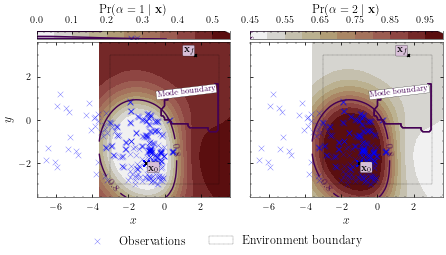

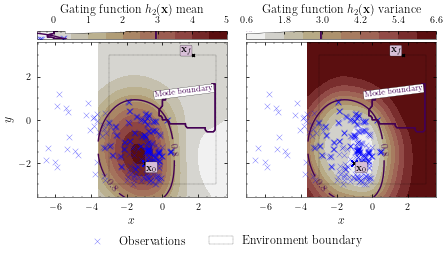

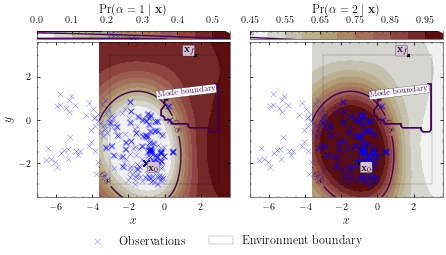

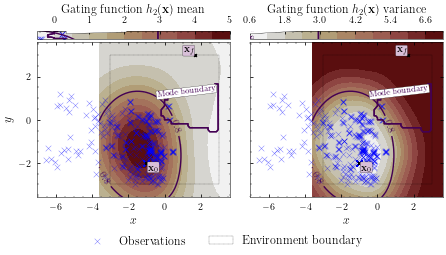

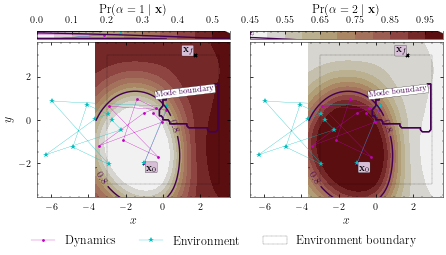

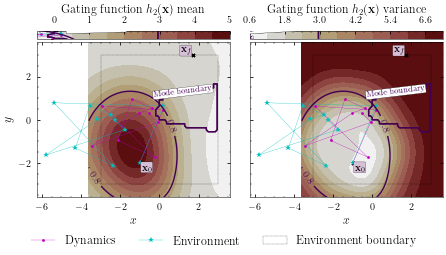

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -533.4076 - val_loss: 304.9020
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_8_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -534.5731

2022-04-08 15:03:05.075601: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 15:03:05.075620: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 3s 3s/step - loss: -534.5731 - val_loss: 337.9646
Epoch 3/10000
1/1 [==============================] - 0s 50ms/step - loss: -595.2945 - val_loss: 317.7352
Epoch 4/10000
1/1 [==============================] - ETA: 0s - loss: -574.6165

2022-04-08 15:03:07.896209: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 15:03:07.912925: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 15:03:07.926357: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_03_07

2022-04-08 15:03:07.933776: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_03_07/dr-robots-mbp.local.trace.json.gz
2022-04-08 15:03:07.968263: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_03_07

2022-04-08 15:03:07.968586: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

1/1 [==============================] - 0s 42ms/step - loss: -574.6165 - val_loss: 541.5377
Epoch 5/10000
1/1 [==============================] - 0s 41ms/step - loss: -640.6447 - val_loss: 607.9592
Epoch 6/10000
1/1 [==============================] - 0s 44ms/step - loss: -535.5281 - val_loss: 711.0027
Epoch 7/10000
1/1 [==============================] - 0s 45ms/step - loss: -596.5151 - val_loss: 325.5341
Epoch 8/10000
1/1 [==============================] - 0s 45ms/step - loss: -570.5783 - val_loss: 288.1197
Epoch 9/10000
1/1 [==============================] - 0s 50ms/step - loss: -504.0370 - val_loss: 733.5300
Epoch 10/10000
1/1 [==============================] - 0s 41ms/step - loss: -582.8638 - val_loss: 117.7679
Epoch 11/10000
1/1 [==============================] - 0s 41ms/step - loss: -373.2548 - val_loss: 750.3380
Epoch 12/10000
1/1 [==============================] - 0s 41ms/step - loss: -587.5609 - val_loss: 129.7072
Epoch 13/10000
1/1 [==============================] - 0s 41ms/step

1/1 [==============================] - 0s 39ms/step - loss: -617.2049 - val_loss: 197.6025
Epoch 82/10000
1/1 [==============================] - 0s 40ms/step - loss: -608.1969 - val_loss: 367.3650
Epoch 83/10000
1/1 [==============================] - 0s 40ms/step - loss: -649.6232 - val_loss: 192.8079
Epoch 84/10000
1/1 [==============================] - 0s 40ms/step - loss: -624.5963 - val_loss: 116.9427
Epoch 85/10000
1/1 [==============================] - 0s 41ms/step - loss: -590.5753 - val_loss: 349.1724
Epoch 86/10000
1/1 [==============================] - 0s 40ms/step - loss: -651.1320 - val_loss: 221.2518
Epoch 87/10000
1/1 [==============================] - 0s 40ms/step - loss: -566.3788 - val_loss: 722.6582
Epoch 88/10000
1/1 [==============================] - 0s 39ms/step - loss: -353.5777 - val_loss: 698.1484
Epoch 89/10000
1/1 [==============================] - 0s 41ms/step - loss: -639.3374 - val_loss: 635.6579
Epoch 90/10000
1/1 [==============================] - 0s 40ms

Epoch 158/10000
1/1 [==============================] - 0s 48ms/step - loss: -554.5296 - val_loss: 586.3502
Epoch 159/10000
1/1 [==============================] - 0s 43ms/step - loss: -574.7361 - val_loss: 205.9774
Epoch 160/10000
1/1 [==============================] - 0s 44ms/step - loss: -554.7932 - val_loss: 635.6808
Epoch 161/10000
1/1 [==============================] - 0s 42ms/step - loss: -543.9777 - val_loss: 398.1726
Epoch 162/10000
1/1 [==============================] - 0s 42ms/step - loss: -551.6978 - val_loss: 447.4536
Epoch 163/10000
1/1 [==============================] - 0s 42ms/step - loss: -588.4001 - val_loss: 531.4503
Epoch 164/10000
1/1 [==============================] - 0s 41ms/step - loss: -589.0759 - val_loss: 436.3703
Epoch 165/10000
1/1 [==============================] - 0s 42ms/step - loss: -566.3381 - val_loss: 609.4755
Epoch 166/10000
1/1 [==============================] - 0s 41ms/step - loss: -566.8138 - val_loss: 643.8487
Epoch 167/10000
1/1 [================

1/1 [==============================] - 0s 44ms/step - loss: -601.5942 - val_loss: 572.8624
Epoch 235/10000
1/1 [==============================] - 0s 49ms/step - loss: -508.3851 - val_loss: 190.9530
Epoch 236/10000
1/1 [==============================] - 0s 57ms/step - loss: -488.5873 - val_loss: 667.9766
Epoch 237/10000
1/1 [==============================] - 0s 91ms/step - loss: -623.9483 - val_loss: 351.2817
Epoch 238/10000
1/1 [==============================] - 0s 70ms/step - loss: -618.1463 - val_loss: 519.3104
Epoch 239/10000
1/1 [==============================] - 0s 75ms/step - loss: -635.0119 - val_loss: 384.3206
Epoch 240/10000
1/1 [==============================] - 0s 80ms/step - loss: -637.4819 - val_loss: 377.1908
Epoch 241/10000
1/1 [==============================] - 0s 81ms/step - loss: -320.1792 - val_loss: 554.7319
Epoch 242/10000
1/1 [==============================] - 0s 75ms/step - loss: -257.7890 - val_loss: 933.2557
Epoch 243/10000
1/1 [==============================] 

Epoch 311/10000
1/1 [==============================] - 0s 41ms/step - loss: -606.1350 - val_loss: 210.3354
Epoch 312/10000
1/1 [==============================] - 0s 41ms/step - loss: -581.0570 - val_loss: 605.8406
Epoch 313/10000
1/1 [==============================] - 0s 41ms/step - loss: -549.6894 - val_loss: 521.1210
Epoch 314/10000
1/1 [==============================] - 0s 44ms/step - loss: -556.1566 - val_loss: 722.9241
Epoch 315/10000
1/1 [==============================] - 0s 41ms/step - loss: -608.1848 - val_loss: 107.2934
Epoch 316/10000
1/1 [==============================] - 0s 42ms/step - loss: -606.9943 - val_loss: 29.9867
Epoch 317/10000
1/1 [==============================] - 0s 42ms/step - loss: -612.4948 - val_loss: 427.2492
Epoch 318/10000
1/1 [==============================] - 0s 42ms/step - loss: -643.1262 - val_loss: 263.9503
Epoch 319/10000
1/1 [==============================] - 0s 41ms/step - loss: -630.1632 - val_loss: 81.1335
Epoch 320/10000
1/1 [==================

1/1 [==============================] - 0s 41ms/step - loss: -218.3250 - val_loss: 377.9164
Epoch 388/10000
1/1 [==============================] - 0s 41ms/step - loss: -351.8414 - val_loss: 374.8523
Epoch 389/10000
1/1 [==============================] - 0s 42ms/step - loss: -428.9117 - val_loss: 658.1523
Epoch 390/10000
1/1 [==============================] - 0s 41ms/step - loss: -621.7123 - val_loss: 265.6810
Epoch 391/10000
1/1 [==============================] - 0s 41ms/step - loss: -335.0326 - val_loss: 246.6481
Epoch 392/10000
1/1 [==============================] - 0s 42ms/step - loss: -348.2141 - val_loss: 161.8416
Epoch 393/10000
1/1 [==============================] - 0s 41ms/step - loss: -388.1864 - val_loss: 395.1561
Epoch 394/10000
1/1 [==============================] - 0s 41ms/step - loss: -434.4586 - val_loss: 365.6662
Epoch 395/10000
1/1 [==============================] - 0s 42ms/step - loss: -387.9310 - val_loss: 126.8648
Epoch 396/10000
1/1 [==============================] 

Epoch 464/10000
1/1 [==============================] - 0s 41ms/step - loss: -592.1984 - val_loss: 327.4103
Epoch 465/10000
1/1 [==============================] - 0s 42ms/step - loss: -554.1335 - val_loss: 428.9718
Epoch 466/10000
1/1 [==============================] - 0s 41ms/step - loss: -573.7982 - val_loss: 438.4796
Epoch 467/10000
1/1 [==============================] - 0s 40ms/step - loss: -450.6188 - val_loss: 319.7150
Epoch 468/10000
1/1 [==============================] - 0s 41ms/step - loss: -538.7097 - val_loss: 165.1517
Epoch 469/10000
1/1 [==============================] - 0s 43ms/step - loss: -582.4988 - val_loss: 176.1657
Epoch 470/10000
1/1 [==============================] - 0s 41ms/step - loss: -559.8575 - val_loss: 204.4921
Epoch 471/10000
1/1 [==============================] - 0s 41ms/step - loss: -612.0635 - val_loss: 271.8994
Epoch 472/10000
1/1 [==============================] - 0s 41ms/step - loss: -618.4418 - val_loss: 95.6417
Epoch 473/10000
1/1 [=================

1/1 [==============================] - 0s 45ms/step - loss: -648.8392 - val_loss: 17.3861
Epoch 541/10000
1/1 [==============================] - 0s 94ms/step - loss: -499.4804 - val_loss: 557.1608
Epoch 542/10000
1/1 [==============================] - 0s 46ms/step - loss: -631.6126 - val_loss: 415.5337
Epoch 543/10000
1/1 [==============================] - 0s 44ms/step - loss: -639.7421 - val_loss: 621.6963
Epoch 544/10000
1/1 [==============================] - 0s 43ms/step - loss: -581.7767 - val_loss: 122.0724
Epoch 545/10000
1/1 [==============================] - 0s 42ms/step - loss: -582.2652 - val_loss: 538.0674
Epoch 546/10000
1/1 [==============================] - 0s 42ms/step - loss: -516.8627 - val_loss: 106.4144
Epoch 547/10000
1/1 [==============================] - 0s 46ms/step - loss: -673.9301 - val_loss: 120.2692
Epoch 548/10000
1/1 [==============================] - 0s 45ms/step - loss: -615.5928 - val_loss: 234.4146
Epoch 549/10000
1/1 [==============================] -

Epoch 617/10000
1/1 [==============================] - 0s 41ms/step - loss: -425.3287 - val_loss: 300.3999
Epoch 618/10000
1/1 [==============================] - 0s 40ms/step - loss: -535.6903 - val_loss: 346.1583
Epoch 619/10000
1/1 [==============================] - 0s 39ms/step - loss: -612.6958 - val_loss: 473.2357
Epoch 620/10000
1/1 [==============================] - 0s 40ms/step - loss: -613.9349 - val_loss: 29.7617
Epoch 621/10000
1/1 [==============================] - 0s 39ms/step - loss: -415.4483 - val_loss: 477.2129
Epoch 622/10000
1/1 [==============================] - 0s 40ms/step - loss: -586.7637 - val_loss: 507.2609
Epoch 623/10000
1/1 [==============================] - 0s 40ms/step - loss: -286.5523 - val_loss: 418.3184
Epoch 624/10000
1/1 [==============================] - 0s 40ms/step - loss: -577.0134 - val_loss: 142.6932
Epoch 625/10000
1/1 [==============================] - 0s 41ms/step - loss: -544.5939 - val_loss: 408.2631
Epoch 626/10000
1/1 [=================

1/1 [==============================] - 0s 40ms/step - loss: -590.7474 - val_loss: 212.8750
Epoch 694/10000
1/1 [==============================] - 0s 40ms/step - loss: -631.0226 - val_loss: 229.8667
Epoch 695/10000
1/1 [==============================] - 0s 43ms/step - loss: -529.8011 - val_loss: 669.8031
Epoch 696/10000
1/1 [==============================] - 0s 40ms/step - loss: -524.3703 - val_loss: 444.7309
Epoch 697/10000
1/1 [==============================] - 0s 40ms/step - loss: -598.1507 - val_loss: 165.8304
Epoch 698/10000
1/1 [==============================] - 0s 41ms/step - loss: -660.8218 - val_loss: 218.8216
Epoch 699/10000
1/1 [==============================] - 0s 40ms/step - loss: -501.1156 - val_loss: 635.8370
Epoch 700/10000
1/1 [==============================] - 0s 40ms/step - loss: -427.6168 - val_loss: 763.8893
Epoch 701/10000
1/1 [==============================] - 0s 40ms/step - loss: -548.2795 - val_loss: 234.7200
Epoch 702/10000
1/1 [==============================] 

Epoch 770/10000
1/1 [==============================] - 0s 40ms/step - loss: -579.7622 - val_loss: 166.5519
Epoch 771/10000
1/1 [==============================] - 0s 40ms/step - loss: -534.6081 - val_loss: 261.1910
Epoch 772/10000
1/1 [==============================] - 0s 40ms/step - loss: -573.8892 - val_loss: 399.7109
Epoch 773/10000
1/1 [==============================] - 0s 40ms/step - loss: -526.9150 - val_loss: 505.1942
Epoch 774/10000
1/1 [==============================] - 0s 40ms/step - loss: -638.0270 - val_loss: 502.6626
Epoch 775/10000
1/1 [==============================] - 0s 40ms/step - loss: -581.9992 - val_loss: 53.7027
Epoch 776/10000
1/1 [==============================] - 0s 40ms/step - loss: -583.0276 - val_loss: 535.8507
Epoch 777/10000
1/1 [==============================] - 0s 40ms/step - loss: -554.6131 - val_loss: 360.5393
Epoch 778/10000
1/1 [==============================] - 0s 40ms/step - loss: -577.5803 - val_loss: 230.3156
Epoch 779/10000
1/1 [=================

1/1 [==============================] - 0s 38ms/step - loss: -370.6327 - val_loss: 143.7804
Epoch 847/10000
1/1 [==============================] - 0s 39ms/step - loss: -619.6874 - val_loss: 624.2450
Epoch 848/10000
1/1 [==============================] - 0s 39ms/step - loss: -590.4039 - val_loss: 156.7681
Epoch 849/10000
1/1 [==============================] - 0s 38ms/step - loss: -145.6384 - val_loss: 121.7110
Epoch 850/10000
1/1 [==============================] - 0s 38ms/step - loss: -528.5274 - val_loss: 118.8617
Epoch 851/10000
1/1 [==============================] - 0s 39ms/step - loss: -523.5071 - val_loss: -8.3735
Epoch 852/10000
1/1 [==============================] - 0s 38ms/step - loss: -621.8543 - val_loss: 0.3075
Epoch 853/10000
1/1 [==============================] - 0s 40ms/step - loss: -503.6127 - val_loss: 358.4856
Epoch 854/10000
1/1 [==============================] - 0s 39ms/step - loss: -558.8426 - val_loss: 44.7072
Epoch 855/10000
1/1 [==============================] - 0s

Epoch 923/10000
1/1 [==============================] - 0s 39ms/step - loss: -599.4228 - val_loss: 529.9225
Epoch 924/10000
1/1 [==============================] - 0s 39ms/step - loss: -509.0591 - val_loss: 296.1717
Epoch 925/10000
1/1 [==============================] - 0s 39ms/step - loss: -602.7327 - val_loss: 406.2261
Epoch 926/10000
1/1 [==============================] - 0s 39ms/step - loss: -620.2494 - val_loss: 685.5503
Epoch 927/10000
1/1 [==============================] - 0s 39ms/step - loss: -650.1068 - val_loss: 291.6880
Epoch 928/10000
1/1 [==============================] - 0s 38ms/step - loss: -552.8167 - val_loss: 311.5559
Epoch 929/10000
1/1 [==============================] - 0s 39ms/step - loss: -510.7905 - val_loss: 531.5996
Epoch 930/10000
1/1 [==============================] - 0s 38ms/step - loss: -485.8337 - val_loss: 553.7097
Epoch 931/10000
1/1 [==============================] - 0s 40ms/step - loss: -527.8341 - val_loss: 268.9264
Epoch 932/10000
1/1 [================

1/1 [==============================] - 0s 38ms/step - loss: -618.5328 - val_loss: 467.1540
Epoch 1000/10000
1/1 [==============================] - 0s 38ms/step - loss: -595.9120 - val_loss: 90.4058
Epoch 1001/10000
1/1 [==============================] - 0s 38ms/step - loss: -561.4072 - val_loss: 335.2022
Epoch 1002/10000
1/1 [==============================] - 0s 38ms/step - loss: -532.7795 - val_loss: 262.2078
Epoch 1003/10000
1/1 [==============================] - 0s 40ms/step - loss: -671.5239 - val_loss: 286.2167
Epoch 1004/10000
1/1 [==============================] - 0s 39ms/step - loss: -639.2313 - val_loss: 47.0654
Epoch 1005/10000
1/1 [==============================] - 0s 38ms/step - loss: -601.7405 - val_loss: 11.8124
Epoch 1006/10000
1/1 [==============================] - 0s 39ms/step - loss: -294.7009 - val_loss: 90.7908
Epoch 1007/10000
1/1 [==============================] - 0s 38ms/step - loss: -466.5397 - val_loss: 309.0441
Epoch 1008/10000
1/1 [===========================

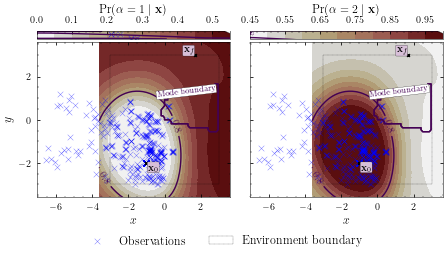

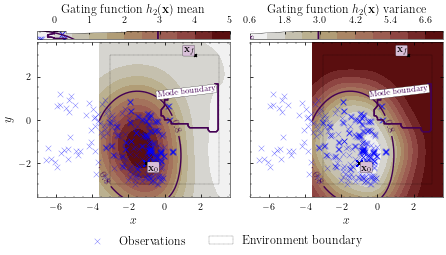

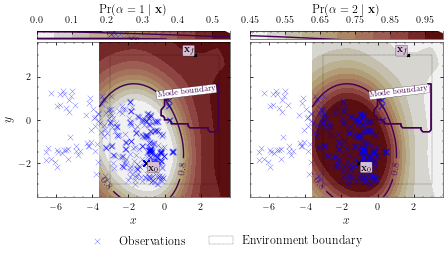

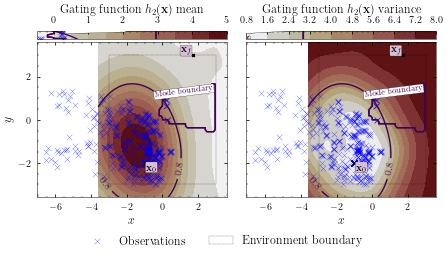

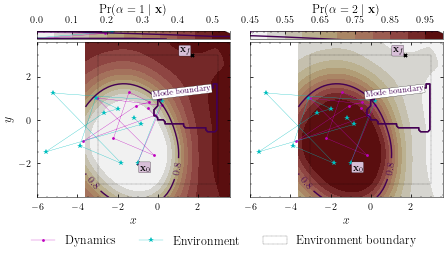

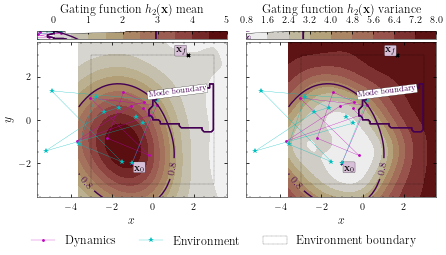

Epoch 1/10000
1/1 [==============================] - 1s 701ms/step - loss: -483.7610 - val_loss: 175.8802
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_9_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -537.2184

2022-04-08 15:07:28.001761: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 15:07:28.001784: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 4s 4s/step - loss: -537.2184 - val_loss: 500.2404
Epoch 3/10000
1/1 [==============================] - 0s 43ms/step - loss: -410.1036 - val_loss: 153.4457
Epoch 4/10000
1/1 [==============================] - 0s 43ms/step - loss: -500.3936 - val_loss: 694.3099


2022-04-08 15:07:31.867725: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 15:07:31.884960: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 15:07:31.894102: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_07_31

2022-04-08 15:07:31.901726: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_07_31/dr-robots-mbp.local.trace.json.gz
2022-04-08 15:07:31.926626: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_07_31

2022-04-08 15:07:31.926941: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

Epoch 5/10000
1/1 [==============================] - 0s 43ms/step - loss: -354.6767 - val_loss: 309.4973
Epoch 6/10000
1/1 [==============================] - 0s 43ms/step - loss: -543.7759 - val_loss: 276.0868
Epoch 7/10000
1/1 [==============================] - 0s 43ms/step - loss: -364.1294 - val_loss: 709.5945
Epoch 8/10000
1/1 [==============================] - 0s 42ms/step - loss: -521.2744 - val_loss: 679.1459
Epoch 9/10000
1/1 [==============================] - 0s 42ms/step - loss: -545.4192 - val_loss: 107.6624
Epoch 10/10000
1/1 [==============================] - 0s 43ms/step - loss: -444.4263 - val_loss: 169.7360
Epoch 11/10000
1/1 [==============================] - 0s 44ms/step - loss: -131.5048 - val_loss: 555.6380
Epoch 12/10000
1/1 [==============================] - 0s 44ms/step - loss: -434.5428 - val_loss: 251.9713
Epoch 13/10000
1/1 [==============================] - 0s 42ms/step - loss: -510.1962 - val_loss: 463.7505
Epoch 14/10000
1/1 [==============================]

1/1 [==============================] - 0s 49ms/step - loss: -565.9170 - val_loss: -21.2158
Epoch 83/10000
1/1 [==============================] - 0s 50ms/step - loss: -505.4538 - val_loss: 655.7903
Epoch 84/10000
1/1 [==============================] - 0s 53ms/step - loss: -559.2743 - val_loss: -13.5323
Epoch 85/10000
1/1 [==============================] - 0s 59ms/step - loss: -521.9564 - val_loss: 285.1531
Epoch 86/10000
1/1 [==============================] - 0s 58ms/step - loss: -575.0685 - val_loss: 232.7846
Epoch 87/10000
1/1 [==============================] - 0s 71ms/step - loss: -587.9780 - val_loss: 3.3053
Epoch 88/10000
1/1 [==============================] - 0s 72ms/step - loss: -553.7113 - val_loss: 185.4956
Epoch 89/10000
1/1 [==============================] - 0s 66ms/step - loss: -595.2985 - val_loss: -142.2687
Epoch 90/10000
1/1 [==============================] - 0s 54ms/step - loss: -556.2445 - val_loss: 73.6154
Epoch 91/10000
1/1 [==============================] - 0s 61ms/s

Epoch 159/10000
1/1 [==============================] - 0s 49ms/step - loss: -575.9307 - val_loss: 464.7198
Epoch 160/10000
1/1 [==============================] - 0s 50ms/step - loss: -624.3039 - val_loss: 4.1402
Epoch 161/10000
1/1 [==============================] - 0s 51ms/step - loss: -625.7706 - val_loss: -12.0125
Epoch 162/10000
1/1 [==============================] - 0s 48ms/step - loss: -433.9851 - val_loss: 58.6900
Epoch 163/10000
1/1 [==============================] - 0s 45ms/step - loss: -548.5150 - val_loss: -103.2060
Epoch 164/10000
1/1 [==============================] - 0s 54ms/step - loss: -592.8735 - val_loss: 184.5016
Epoch 165/10000
1/1 [==============================] - 0s 56ms/step - loss: -535.8674 - val_loss: 418.7412
Epoch 166/10000
1/1 [==============================] - 0s 51ms/step - loss: -600.5355 - val_loss: -97.4545
Epoch 167/10000
1/1 [==============================] - 0s 47ms/step - loss: -546.2565 - val_loss: 183.5977
Epoch 168/10000
1/1 [==================

1/1 [==============================] - 0s 49ms/step - loss: -589.0921 - val_loss: 209.5055
Epoch 236/10000
1/1 [==============================] - 0s 48ms/step - loss: -485.7958 - val_loss: 64.4645
Epoch 237/10000
1/1 [==============================] - 0s 50ms/step - loss: -322.6143 - val_loss: 304.2451
Epoch 238/10000
1/1 [==============================] - 0s 47ms/step - loss: -372.8061 - val_loss: 100.7625
Epoch 239/10000
1/1 [==============================] - 0s 48ms/step - loss: -526.5306 - val_loss: 38.1568
Epoch 240/10000
1/1 [==============================] - 0s 49ms/step - loss: -468.2569 - val_loss: -42.4816
Epoch 241/10000
1/1 [==============================] - 0s 47ms/step - loss: -523.0431 - val_loss: 171.8126
Epoch 242/10000
1/1 [==============================] - 0s 48ms/step - loss: -446.3718 - val_loss: 264.6492
Epoch 243/10000
1/1 [==============================] - 0s 48ms/step - loss: -442.5775 - val_loss: 281.4634
Epoch 244/10000
1/1 [==============================] - 

Epoch 312/10000
1/1 [==============================] - 0s 48ms/step - loss: -539.3148 - val_loss: -98.9811
Epoch 313/10000
1/1 [==============================] - 0s 49ms/step - loss: -523.0485 - val_loss: 84.9699
Epoch 314/10000
1/1 [==============================] - 0s 48ms/step - loss: -555.6111 - val_loss: -84.0665
Epoch 315/10000
1/1 [==============================] - 0s 50ms/step - loss: -563.5574 - val_loss: -129.5364
Epoch 316/10000
1/1 [==============================] - 0s 55ms/step - loss: -557.3662 - val_loss: 10.0936
Epoch 317/10000
1/1 [==============================] - 0s 53ms/step - loss: -536.9956 - val_loss: -82.0968
Epoch 318/10000
1/1 [==============================] - 0s 52ms/step - loss: -521.8349 - val_loss: 53.2022
Epoch 319/10000
1/1 [==============================] - 0s 52ms/step - loss: -541.1774 - val_loss: 298.1164
Epoch 320/10000
1/1 [==============================] - 0s 50ms/step - loss: -537.1860 - val_loss: 325.9723
Epoch 321/10000
1/1 [==================

1/1 [==============================] - 0s 48ms/step - loss: -541.4910 - val_loss: 43.4694
Epoch 389/10000
1/1 [==============================] - 0s 52ms/step - loss: -268.3673 - val_loss: 248.2479
Epoch 390/10000
1/1 [==============================] - 0s 51ms/step - loss: 267.3388 - val_loss: 508.8525
Epoch 391/10000
1/1 [==============================] - 0s 47ms/step - loss: 54.1858 - val_loss: 503.1937
Epoch 392/10000
1/1 [==============================] - 0s 46ms/step - loss: -94.2174 - val_loss: 349.0881
Epoch 393/10000
1/1 [==============================] - 0s 47ms/step - loss: -183.7874 - val_loss: 205.8507
Epoch 394/10000
1/1 [==============================] - 0s 49ms/step - loss: -195.7004 - val_loss: 197.8692
Epoch 395/10000
1/1 [==============================] - 0s 50ms/step - loss: -507.9340 - val_loss: 149.2496
Epoch 396/10000
1/1 [==============================] - 0s 50ms/step - loss: -160.6119 - val_loss: 22.5861
Epoch 397/10000
1/1 [==============================] - 0s 5

Epoch 465/10000
1/1 [==============================] - 0s 54ms/step - loss: -432.1132 - val_loss: 7.4942
Epoch 466/10000
1/1 [==============================] - 0s 53ms/step - loss: -418.8149 - val_loss: 66.0547
Epoch 467/10000
1/1 [==============================] - 0s 50ms/step - loss: -509.6978 - val_loss: 14.1230
Epoch 468/10000
1/1 [==============================] - 0s 50ms/step - loss: -417.4109 - val_loss: 197.1568
Epoch 469/10000
1/1 [==============================] - 0s 51ms/step - loss: -501.1747 - val_loss: 18.8083
Epoch 470/10000
1/1 [==============================] - 0s 50ms/step - loss: -341.2773 - val_loss: 124.9081
Epoch 471/10000
1/1 [==============================] - 0s 52ms/step - loss: -368.3546 - val_loss: 491.8410
Epoch 472/10000
1/1 [==============================] - 0s 53ms/step - loss: -489.5585 - val_loss: -32.2846
Epoch 473/10000
1/1 [==============================] - 0s 53ms/step - loss: -480.3565 - val_loss: -26.5130
Epoch 474/10000
1/1 [=====================

1/1 [==============================] - 0s 57ms/step - loss: -585.3777 - val_loss: -102.2845
Epoch 542/10000
1/1 [==============================] - 0s 74ms/step - loss: -554.7330 - val_loss: 196.4355
Epoch 543/10000
1/1 [==============================] - 0s 73ms/step - loss: -533.1387 - val_loss: -130.0661
Epoch 544/10000
1/1 [==============================] - 0s 79ms/step - loss: -567.3063 - val_loss: -72.2996
Epoch 545/10000
1/1 [==============================] - 0s 70ms/step - loss: -543.2096 - val_loss: -133.0272
Epoch 546/10000
1/1 [==============================] - 0s 73ms/step - loss: -542.6837 - val_loss: -163.0341
Epoch 547/10000
1/1 [==============================] - 0s 70ms/step - loss: -532.7118 - val_loss: 72.4813
Epoch 548/10000
1/1 [==============================] - 0s 72ms/step - loss: -398.7517 - val_loss: 266.2357
Epoch 549/10000
1/1 [==============================] - 0s 128ms/step - loss: -569.7538 - val_loss: -151.5608
Epoch 550/10000
1/1 [===========================

1/1 [==============================] - 0s 105ms/step - loss: -569.3460 - val_loss: -14.4749
Epoch 618/10000
1/1 [==============================] - 0s 103ms/step - loss: -491.8622 - val_loss: 33.4369
Epoch 619/10000
1/1 [==============================] - 0s 97ms/step - loss: -465.7404 - val_loss: 169.1336
Epoch 620/10000
1/1 [==============================] - 0s 86ms/step - loss: -622.8456 - val_loss: -47.2900
Epoch 621/10000
1/1 [==============================] - 0s 90ms/step - loss: -559.4804 - val_loss: -209.6102
Epoch 622/10000
1/1 [==============================] - 0s 85ms/step - loss: -611.9035 - val_loss: -202.1945
Epoch 623/10000
1/1 [==============================] - 0s 82ms/step - loss: -567.2134 - val_loss: 121.2059
Epoch 624/10000
1/1 [==============================] - 0s 79ms/step - loss: -624.6212 - val_loss: 3.3499
Epoch 625/10000
1/1 [==============================] - 0s 77ms/step - loss: -505.0812 - val_loss: -65.0099
Epoch 626/10000
1/1 [==============================]

1/1 [==============================] - 0s 113ms/step - loss: -476.0943 - val_loss: 142.0131
Epoch 694/10000
1/1 [==============================] - 0s 122ms/step - loss: -537.9933 - val_loss: -107.6013
Epoch 695/10000
1/1 [==============================] - 0s 97ms/step - loss: -486.2053 - val_loss: -1.6838
Epoch 696/10000
1/1 [==============================] - 0s 121ms/step - loss: -490.1796 - val_loss: 146.6522
Epoch 697/10000
1/1 [==============================] - 0s 113ms/step - loss: -523.7917 - val_loss: 43.0978
Epoch 698/10000
1/1 [==============================] - 0s 96ms/step - loss: -492.0867 - val_loss: -22.5353
Epoch 699/10000
1/1 [==============================] - 0s 117ms/step - loss: -503.0321 - val_loss: 23.3755
Epoch 700/10000
1/1 [==============================] - 0s 81ms/step - loss: -492.6214 - val_loss: -95.5241
Epoch 701/10000
1/1 [==============================] - 0s 90ms/step - loss: -450.4460 - val_loss: -91.9086
Epoch 702/10000
1/1 [=============================

1/1 [==============================] - 0s 92ms/step - loss: -594.9637 - val_loss: -92.7114
Epoch 770/10000
1/1 [==============================] - 0s 95ms/step - loss: -616.0906 - val_loss: -89.5593
Epoch 771/10000
1/1 [==============================] - 0s 95ms/step - loss: -607.6349 - val_loss: -37.2473
Epoch 772/10000
1/1 [==============================] - 0s 92ms/step - loss: -602.4260 - val_loss: -161.1314
Epoch 773/10000
1/1 [==============================] - 0s 101ms/step - loss: -570.8830 - val_loss: 77.7202
Epoch 774/10000
1/1 [==============================] - 0s 89ms/step - loss: -608.3553 - val_loss: -155.5167
Epoch 775/10000
1/1 [==============================] - 0s 91ms/step - loss: -616.2023 - val_loss: 104.4187
Epoch 776/10000
1/1 [==============================] - 0s 88ms/step - loss: -629.6676 - val_loss: -48.8318
Epoch 777/10000
1/1 [==============================] - 0s 104ms/step - loss: -608.2591 - val_loss: -103.1287
Epoch 778/10000
1/1 [============================

1/1 [==============================] - 0s 97ms/step - loss: -530.4911 - val_loss: -163.2266
Epoch 846/10000
1/1 [==============================] - 0s 83ms/step - loss: -437.1678 - val_loss: 72.2983
Epoch 847/10000
1/1 [==============================] - 0s 82ms/step - loss: 559.1148 - val_loss: 402.6016
Epoch 848/10000
1/1 [==============================] - 0s 76ms/step - loss: -569.1062 - val_loss: -124.6416
Epoch 849/10000
1/1 [==============================] - 0s 159ms/step - loss: -445.6950 - val_loss: -109.3913
Epoch 850/10000
1/1 [==============================] - 0s 161ms/step - loss: -296.4965 - val_loss: 94.4257
Epoch 851/10000
1/1 [==============================] - 0s 96ms/step - loss: -505.3649 - val_loss: 1.0124
Epoch 852/10000
1/1 [==============================] - 0s 84ms/step - loss: -231.2708 - val_loss: 184.8408
Epoch 853/10000
1/1 [==============================] - 0s 97ms/step - loss: -564.5181 - val_loss: -86.5377
Epoch 854/10000
1/1 [==============================] 

1/1 [==============================] - 0s 121ms/step - loss: -543.0201 - val_loss: -169.4849
Epoch 922/10000
1/1 [==============================] - 0s 109ms/step - loss: -530.8156 - val_loss: -164.6885
Epoch 923/10000
1/1 [==============================] - 0s 77ms/step - loss: -512.0329 - val_loss: -127.7152
Epoch 924/10000
1/1 [==============================] - 0s 80ms/step - loss: -373.3738 - val_loss: 45.2489
Epoch 925/10000
1/1 [==============================] - 0s 84ms/step - loss: -422.5372 - val_loss: 134.5982
Epoch 926/10000
1/1 [==============================] - 0s 90ms/step - loss: -405.6175 - val_loss: 97.7088
Epoch 927/10000
1/1 [==============================] - 0s 89ms/step - loss: -532.2307 - val_loss: -186.8194
Epoch 928/10000
1/1 [==============================] - 0s 88ms/step - loss: -557.2172 - val_loss: -52.8563
Epoch 929/10000
1/1 [==============================] - 0s 100ms/step - loss: -447.0945 - val_loss: -91.3921
Epoch 930/10000
1/1 [===========================

1/1 [==============================] - 0s 82ms/step - loss: -654.3168 - val_loss: -208.1066
Epoch 998/10000
1/1 [==============================] - 0s 74ms/step - loss: -606.8726 - val_loss: 131.0597
Epoch 999/10000
1/1 [==============================] - 0s 73ms/step - loss: -547.3527 - val_loss: -44.7828
Epoch 1000/10000
1/1 [==============================] - 0s 70ms/step - loss: -571.8311 - val_loss: 78.9145
Epoch 1001/10000
1/1 [==============================] - 0s 69ms/step - loss: -623.1157 - val_loss: -211.0052
Epoch 1002/10000
1/1 [==============================] - 0s 70ms/step - loss: -612.9624 - val_loss: -0.3795
Epoch 1003/10000
1/1 [==============================] - 0s 70ms/step - loss: -611.7685 - val_loss: -181.7173
Epoch 1004/10000
1/1 [==============================] - 0s 86ms/step - loss: -611.9944 - val_loss: -95.8610
Epoch 1005/10000
1/1 [==============================] - 0s 67ms/step - loss: -564.6823 - val_loss: 208.2931
Epoch 1006/10000
1/1 [========================

Epoch 1073/10000
1/1 [==============================] - 0s 67ms/step - loss: -358.4736 - val_loss: -75.7391
Epoch 1074/10000
1/1 [==============================] - 0s 71ms/step - loss: -513.9095 - val_loss: -152.3216
Epoch 1075/10000
1/1 [==============================] - 0s 81ms/step - loss: -336.1032 - val_loss: -148.5352
Epoch 1076/10000
1/1 [==============================] - 0s 82ms/step - loss: -514.3217 - val_loss: -48.4249
Epoch 1077/10000
1/1 [==============================] - 0s 84ms/step - loss: -386.0579 - val_loss: 36.0613
Epoch 1078/10000
1/1 [==============================] - 0s 94ms/step - loss: -400.2720 - val_loss: -2.3922
Epoch 1079/10000
1/1 [==============================] - 0s 84ms/step - loss: -532.7859 - val_loss: -112.7116
Epoch 1080/10000
1/1 [==============================] - 0s 72ms/step - loss: -578.5143 - val_loss: -166.6139
Epoch 1081/10000
1/1 [==============================] - 0s 70ms/step - loss: -390.0164 - val_loss: -12.7102
Epoch 1082/10000
1/1 [====

1/1 [==============================] - 0s 66ms/step - loss: -495.7172 - val_loss: 108.1728
Epoch 1149/10000
1/1 [==============================] - 0s 70ms/step - loss: -544.5003 - val_loss: 111.9633
Epoch 1150/10000
1/1 [==============================] - 0s 88ms/step - loss: -501.4817 - val_loss: 212.1029
Epoch 1151/10000
1/1 [==============================] - 0s 81ms/step - loss: -584.8828 - val_loss: -148.8974
Epoch 1152/10000
1/1 [==============================] - 0s 65ms/step - loss: -561.7935 - val_loss: 12.2348
Epoch 1153/10000
1/1 [==============================] - 0s 72ms/step - loss: -542.7559 - val_loss: -34.7748
Epoch 1154/10000
1/1 [==============================] - 0s 76ms/step - loss: -589.4351 - val_loss: -152.5576
Epoch 1155/10000
1/1 [==============================] - 0s 69ms/step - loss: -586.0413 - val_loss: -194.3372
Epoch 1156/10000
1/1 [==============================] - 0s 75ms/step - loss: -605.6212 - val_loss: -205.6248
Epoch 1157/10000
1/1 [====================

Epoch 1224/10000
1/1 [==============================] - 0s 58ms/step - loss: -500.6636 - val_loss: -150.0363
Epoch 1225/10000
1/1 [==============================] - 0s 59ms/step - loss: -463.7597 - val_loss: -211.4957
Epoch 1226/10000
1/1 [==============================] - 0s 58ms/step - loss: -485.4970 - val_loss: -156.5889
Epoch 1227/10000
1/1 [==============================] - 0s 58ms/step - loss: -343.4095 - val_loss: 67.1348
Epoch 1228/10000
1/1 [==============================] - 0s 65ms/step - loss: -567.0125 - val_loss: -137.2699
Epoch 1229/10000
1/1 [==============================] - 0s 59ms/step - loss: 48.7570 - val_loss: 301.8846
Epoch 1230/10000
1/1 [==============================] - 0s 58ms/step - loss: 2.4559 - val_loss: 261.1795
Epoch 1231/10000
1/1 [==============================] - 0s 50ms/step - loss: -24.6109 - val_loss: 200.8585
Epoch 1232/10000
1/1 [==============================] - 0s 55ms/step - loss: -448.4428 - val_loss: -77.1767
Epoch 1233/10000
1/1 [=========

1/1 [==============================] - 0s 48ms/step - loss: -477.1643 - val_loss: 19.9021
Epoch 1301/10000
1/1 [==============================] - 0s 49ms/step - loss: -509.8335 - val_loss: -37.6172
Epoch 1302/10000
1/1 [==============================] - 0s 48ms/step - loss: -502.9883 - val_loss: -99.5336
Epoch 1303/10000
1/1 [==============================] - 0s 51ms/step - loss: -403.9924 - val_loss: 17.7129
Epoch 1304/10000
1/1 [==============================] - 0s 46ms/step - loss: -534.0913 - val_loss: -180.9803
Epoch 1305/10000
1/1 [==============================] - 0s 53ms/step - loss: -509.0068 - val_loss: -90.7178
Epoch 1306/10000
1/1 [==============================] - 0s 48ms/step - loss: -492.4877 - val_loss: -84.7057
Epoch 1307/10000
1/1 [==============================] - 0s 52ms/step - loss: -431.9423 - val_loss: 50.8698
Epoch 1308/10000
1/1 [==============================] - 0s 50ms/step - loss: -168.2603 - val_loss: 98.9916
Epoch 1309/10000
1/1 [==========================

entropy
-3.3861555593946298
cost
1.1545095674166272
entropy
-3.386874664436526
cost
1.1550031384962682
entropy
-3.3877921958592543
cost
1.1555606991194902
entropy
-3.3883748591914626
cost
1.1558382544397483
entropy
-3.3882277011721595
cost
1.1556323502603369
entropy
-3.3881589358391806
cost
1.1555627724257813
entropy
-3.3881062943019482
cost
1.1555087487980111
entropy
-3.3880744893190422
cost
1.1554759827376042
Optimisation result:
     fun: -2.232598506581438
     jac: array([-0.17072428, -0.09373312, -0.01997011, -0.04511892, -0.01735837,
       -0.04491929, -0.02732943, -0.04866532, -0.02945174, -0.04635953,
       -0.02237465, -0.0242127 , -0.01707631, -0.0175366 , -0.00650891,
       -0.00840789, -0.00766966, -0.00893867, -0.0043922 , -0.00488048])
 message: 'Optimization terminated successfully'
    nfev: 136
     nit: 131
    njev: 131
  status: 0
 success: True
       x: array([  0.09844925,  14.87380485, -11.51052165,  -0.03349762,
        15.33045177,  -5.68732274,  -7.974179

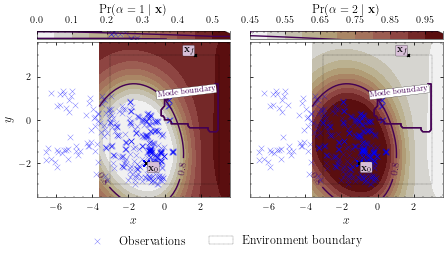

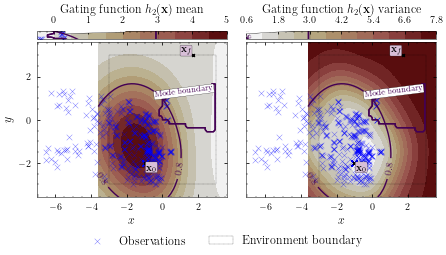

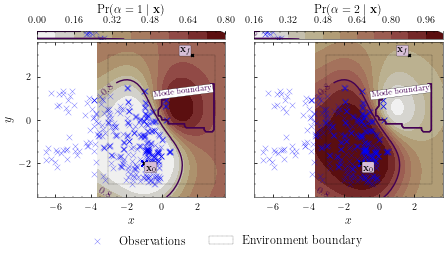

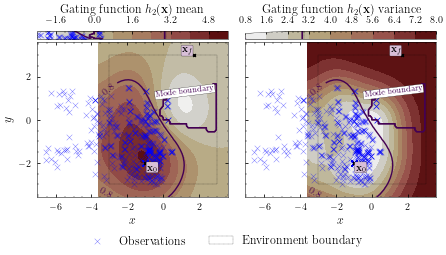

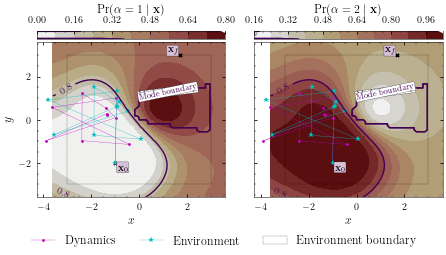

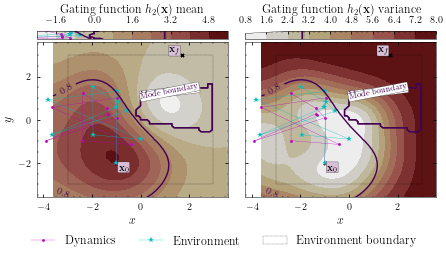

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -471.1971 - val_loss: -48.2081
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_10_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -382.9545

2022-04-08 15:12:32.684165: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 15:12:32.684180: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -382.9545 - val_loss: -24.8851
Epoch 3/10000
1/1 [==============================] - 0s 39ms/step - loss: -510.7526 - val_loss: -164.8097
Epoch 4/10000
1/1 [==============================] - 0s 37ms/step - loss: -531.8307 - val_loss: -203.6401
Epoch 5/10000
1/1 [==============================] - ETA: 0s - loss: -390.4251

2022-04-08 15:12:34.843096: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 15:12:34.859744: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 15:12:34.868563: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_12_34

2022-04-08 15:12:34.876197: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_12_34/dr-robots-mbp.local.trace.json.gz
2022-04-08 15:12:34.902379: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_12_34

2022-04-08 15:12:34.902684: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

1/1 [==============================] - 0s 37ms/step - loss: -390.4251 - val_loss: 110.5130
Epoch 6/10000
1/1 [==============================] - 0s 37ms/step - loss: -493.0175 - val_loss: -112.5741
Epoch 7/10000
1/1 [==============================] - 0s 39ms/step - loss: -211.8114 - val_loss: 229.1404
Epoch 8/10000
1/1 [==============================] - 0s 38ms/step - loss: -496.1890 - val_loss: -134.7934
Epoch 9/10000
1/1 [==============================] - 0s 37ms/step - loss: -463.9161 - val_loss: -54.3818
Epoch 10/10000
1/1 [==============================] - 0s 38ms/step - loss: -177.1710 - val_loss: 204.1493
Epoch 11/10000
1/1 [==============================] - 0s 40ms/step - loss: -421.8274 - val_loss: 105.1132
Epoch 12/10000
1/1 [==============================] - 0s 39ms/step - loss: -493.0106 - val_loss: -170.6222
Epoch 13/10000
1/1 [==============================] - 0s 40ms/step - loss: -173.6327 - val_loss: 181.6926
Epoch 14/10000
1/1 [==============================] - 0s 39ms/

1/1 [==============================] - 0s 40ms/step - loss: -353.9625 - val_loss: -11.2927
Epoch 83/10000
1/1 [==============================] - 0s 39ms/step - loss: -323.8894 - val_loss: 11.2504
Epoch 84/10000
1/1 [==============================] - 0s 39ms/step - loss: -316.3132 - val_loss: 9.3064
Epoch 85/10000
1/1 [==============================] - 0s 41ms/step - loss: -325.3565 - val_loss: 118.3450
Epoch 86/10000
1/1 [==============================] - 0s 39ms/step - loss: -119.8419 - val_loss: 169.5272
Epoch 87/10000
1/1 [==============================] - 0s 40ms/step - loss: -258.7023 - val_loss: -12.2344
Epoch 88/10000
1/1 [==============================] - 0s 40ms/step - loss: -308.5803 - val_loss: -40.8458
Epoch 89/10000
1/1 [==============================] - 0s 39ms/step - loss: -389.0759 - val_loss: -131.4207
Epoch 90/10000
1/1 [==============================] - 0s 40ms/step - loss: -357.7165 - val_loss: -30.9877
Epoch 91/10000
1/1 [==============================] - 0s 39ms/s

Epoch 159/10000
1/1 [==============================] - 0s 42ms/step - loss: -441.0881 - val_loss: 21.2389
Epoch 160/10000
1/1 [==============================] - 0s 41ms/step - loss: -482.6556 - val_loss: -144.1529
Epoch 161/10000
1/1 [==============================] - 0s 41ms/step - loss: -429.6347 - val_loss: 62.5769
Epoch 162/10000
1/1 [==============================] - 0s 41ms/step - loss: -454.2560 - val_loss: -123.9635
Epoch 163/10000
1/1 [==============================] - 0s 40ms/step - loss: -474.3809 - val_loss: -121.0123
Epoch 164/10000
1/1 [==============================] - 0s 41ms/step - loss: -426.6292 - val_loss: 47.8084
Epoch 165/10000
1/1 [==============================] - 0s 41ms/step - loss: -499.1109 - val_loss: -165.9658
Epoch 166/10000
1/1 [==============================] - 0s 42ms/step - loss: -499.1530 - val_loss: -145.6324
Epoch 167/10000
1/1 [==============================] - 0s 40ms/step - loss: -495.5143 - val_loss: -166.7260
Epoch 168/10000
1/1 [=============

1/1 [==============================] - 0s 44ms/step - loss: -347.2771 - val_loss: -132.3854
Epoch 236/10000
1/1 [==============================] - 0s 43ms/step - loss: 28.3457 - val_loss: 155.2919
Epoch 237/10000
1/1 [==============================] - 0s 42ms/step - loss: -412.0091 - val_loss: -93.1910
Epoch 238/10000
1/1 [==============================] - 0s 43ms/step - loss: -409.7350 - val_loss: -93.9623
Epoch 239/10000
1/1 [==============================] - 0s 42ms/step - loss: -437.3702 - val_loss: -39.2417
Epoch 240/10000
1/1 [==============================] - 0s 43ms/step - loss: -484.0296 - val_loss: -61.0102
Epoch 241/10000
1/1 [==============================] - 0s 44ms/step - loss: -442.8978 - val_loss: -78.1033
Epoch 242/10000
1/1 [==============================] - 0s 45ms/step - loss: -391.4056 - val_loss: 93.3314
Epoch 243/10000
1/1 [==============================] - 0s 43ms/step - loss: -434.8276 - val_loss: -9.1845
Epoch 244/10000
1/1 [==============================] - 0

1/1 [==============================] - 0s 47ms/step - loss: -382.9643 - val_loss: 84.9734
Epoch 312/10000
1/1 [==============================] - 0s 44ms/step - loss: -382.1947 - val_loss: -50.2037
Epoch 313/10000
1/1 [==============================] - 0s 46ms/step - loss: -453.2180 - val_loss: -19.4703
Epoch 314/10000
1/1 [==============================] - 0s 45ms/step - loss: -452.5672 - val_loss: -116.7633
Epoch 315/10000
1/1 [==============================] - 0s 45ms/step - loss: -465.7789 - val_loss: -203.7708
Epoch 316/10000
1/1 [==============================] - 0s 47ms/step - loss: -385.1206 - val_loss: -168.8420
Epoch 317/10000
1/1 [==============================] - 0s 47ms/step - loss: -412.0656 - val_loss: -107.7707
Epoch 318/10000
1/1 [==============================] - 0s 45ms/step - loss: -448.6378 - val_loss: -102.4791
Epoch 319/10000
1/1 [==============================] - 0s 45ms/step - loss: -491.9761 - val_loss: -140.7663
Epoch 320/10000
1/1 [===========================

1/1 [==============================] - 0s 43ms/step - loss: -272.9245 - val_loss: 135.6484
Epoch 388/10000
1/1 [==============================] - 0s 44ms/step - loss: -441.4397 - val_loss: 23.7707
Epoch 389/10000
1/1 [==============================] - 0s 44ms/step - loss: -556.1418 - val_loss: -194.9778
Epoch 390/10000
1/1 [==============================] - 0s 44ms/step - loss: -132.9498 - val_loss: -83.2447
Epoch 391/10000
1/1 [==============================] - 0s 43ms/step - loss: -517.9419 - val_loss: -122.3939
Epoch 392/10000
1/1 [==============================] - 0s 56ms/step - loss: -417.4391 - val_loss: -54.7662
Epoch 393/10000
1/1 [==============================] - 0s 43ms/step - loss: -499.2742 - val_loss: -212.5338
Epoch 394/10000
1/1 [==============================] - 0s 44ms/step - loss: -153.5289 - val_loss: -118.6941
Epoch 395/10000
1/1 [==============================] - 0s 44ms/step - loss: -432.5880 - val_loss: -240.4156
Epoch 396/10000
1/1 [============================

1/1 [==============================] - 0s 44ms/step - loss: -466.9951 - val_loss: -145.7994
Epoch 464/10000
1/1 [==============================] - 0s 43ms/step - loss: -467.2240 - val_loss: -140.8175
Epoch 465/10000
1/1 [==============================] - 0s 44ms/step - loss: -475.5565 - val_loss: -85.5515
Epoch 466/10000
1/1 [==============================] - 0s 46ms/step - loss: -467.4280 - val_loss: -188.7246
Epoch 467/10000
1/1 [==============================] - 0s 45ms/step - loss: -488.7833 - val_loss: -176.6940
Epoch 468/10000
1/1 [==============================] - 0s 46ms/step - loss: -447.8940 - val_loss: -177.8428
Epoch 469/10000
1/1 [==============================] - 0s 45ms/step - loss: -461.8358 - val_loss: 6.6968
Epoch 470/10000
1/1 [==============================] - 0s 46ms/step - loss: -486.4399 - val_loss: -178.9995
Epoch 471/10000
1/1 [==============================] - 0s 45ms/step - loss: -448.2242 - val_loss: 57.0348
Epoch 472/10000
1/1 [=============================

1/1 [==============================] - 0s 48ms/step - loss: -524.2934 - val_loss: -164.2481
Epoch 540/10000
1/1 [==============================] - 0s 44ms/step - loss: -466.3613 - val_loss: -191.8302
Epoch 541/10000
1/1 [==============================] - 0s 48ms/step - loss: -526.2394 - val_loss: -206.7947
Epoch 542/10000
1/1 [==============================] - 0s 45ms/step - loss: -528.5966 - val_loss: -155.5514
Epoch 543/10000
1/1 [==============================] - 0s 47ms/step - loss: -518.8276 - val_loss: -132.9330
Epoch 544/10000
1/1 [==============================] - 0s 48ms/step - loss: -499.1892 - val_loss: -45.3110
Epoch 545/10000
1/1 [==============================] - 0s 46ms/step - loss: -489.6919 - val_loss: -172.6305
Epoch 546/10000
1/1 [==============================] - 0s 46ms/step - loss: -435.1638 - val_loss: -193.6298
Epoch 547/10000
1/1 [==============================] - 0s 48ms/step - loss: -529.5999 - val_loss: -205.7644
Epoch 548/10000
1/1 [========================

1/1 [==============================] - 0s 51ms/step - loss: -381.0717 - val_loss: 5.7879
Epoch 616/10000
1/1 [==============================] - 0s 50ms/step - loss: -190.8173 - val_loss: -49.3383
Epoch 617/10000
1/1 [==============================] - 0s 45ms/step - loss: -256.5504 - val_loss: -57.2501
Epoch 618/10000
1/1 [==============================] - 0s 45ms/step - loss: -431.4882 - val_loss: -33.9760
Epoch 619/10000
1/1 [==============================] - 0s 47ms/step - loss: -235.0988 - val_loss: 32.6667
Epoch 620/10000
1/1 [==============================] - 0s 48ms/step - loss: -122.1562 - val_loss: 125.3639
Epoch 621/10000
1/1 [==============================] - 0s 46ms/step - loss: -83.1037 - val_loss: 71.7031
Epoch 622/10000
1/1 [==============================] - 0s 46ms/step - loss: -411.6114 - val_loss: -88.8255
Epoch 623/10000
1/1 [==============================] - 0s 46ms/step - loss: -386.6537 - val_loss: -27.6267
Epoch 624/10000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 45ms/step - loss: -523.4100 - val_loss: -155.2430
Epoch 692/10000
1/1 [==============================] - 0s 45ms/step - loss: -512.1759 - val_loss: -11.0746
Epoch 693/10000
1/1 [==============================] - 0s 46ms/step - loss: -496.5641 - val_loss: -0.1705
Epoch 694/10000
1/1 [==============================] - 0s 46ms/step - loss: -522.2225 - val_loss: -229.3795
Epoch 695/10000
1/1 [==============================] - 0s 56ms/step - loss: -434.1678 - val_loss: 168.9152
Epoch 696/10000
1/1 [==============================] - 0s 48ms/step - loss: -535.1602 - val_loss: -264.3029
Epoch 697/10000
1/1 [==============================] - 0s 44ms/step - loss: -472.1697 - val_loss: -220.6842
Epoch 698/10000
1/1 [==============================] - 0s 44ms/step - loss: -501.4049 - val_loss: -75.0969
Epoch 699/10000
1/1 [==============================] - 0s 44ms/step - loss: -484.8403 - val_loss: -135.4801
Epoch 700/10000
1/1 [============================

1/1 [==============================] - 0s 56ms/step - loss: -434.1396 - val_loss: -211.1695
Epoch 768/10000
1/1 [==============================] - 0s 56ms/step - loss: -549.8844 - val_loss: -213.8509
Epoch 769/10000
1/1 [==============================] - 0s 54ms/step - loss: -487.0505 - val_loss: -93.2639
Epoch 770/10000
1/1 [==============================] - 0s 54ms/step - loss: -258.7774 - val_loss: -135.9843
Epoch 771/10000
1/1 [==============================] - 0s 56ms/step - loss: -504.6592 - val_loss: -219.9744
Epoch 772/10000
1/1 [==============================] - 0s 56ms/step - loss: -456.0768 - val_loss: -132.0123
Epoch 773/10000
1/1 [==============================] - 0s 60ms/step - loss: -433.6854 - val_loss: 161.3820
Epoch 774/10000
1/1 [==============================] - 0s 61ms/step - loss: -505.2935 - val_loss: -205.1052
Epoch 775/10000
1/1 [==============================] - 0s 56ms/step - loss: -233.4680 - val_loss: 47.1675
Epoch 776/10000
1/1 [===========================

1/1 [==============================] - 0s 45ms/step - loss: -526.5389 - val_loss: -119.7797
Epoch 844/10000
1/1 [==============================] - 0s 44ms/step - loss: -485.5746 - val_loss: -149.6470
Epoch 845/10000
1/1 [==============================] - 0s 47ms/step - loss: -520.4104 - val_loss: -219.4382
Epoch 846/10000
1/1 [==============================] - 0s 46ms/step - loss: -222.2610 - val_loss: 44.4967
Epoch 847/10000
1/1 [==============================] - 0s 43ms/step - loss: -444.6350 - val_loss: -140.7274
Epoch 848/10000
1/1 [==============================] - 0s 45ms/step - loss: -342.1226 - val_loss: -201.5411
Epoch 849/10000
1/1 [==============================] - 0s 43ms/step - loss: -521.8418 - val_loss: -224.7292
Epoch 850/10000
1/1 [==============================] - 0s 45ms/step - loss: -448.9432 - val_loss: -93.3734
Epoch 851/10000
1/1 [==============================] - 0s 44ms/step - loss: -377.1560 - val_loss: -112.8999
Epoch 852/10000
1/1 [==========================

1/1 [==============================] - 0s 47ms/step - loss: -465.1033 - val_loss: 38.5255
Epoch 920/10000
1/1 [==============================] - 0s 43ms/step - loss: -477.2052 - val_loss: -188.4582
Epoch 921/10000
1/1 [==============================] - 0s 46ms/step - loss: -485.7770 - val_loss: -55.0641
Epoch 922/10000
1/1 [==============================] - 0s 46ms/step - loss: -446.7460 - val_loss: 7.7122
Epoch 923/10000
1/1 [==============================] - 0s 45ms/step - loss: -415.0899 - val_loss: 101.9380
Epoch 924/10000
1/1 [==============================] - 0s 47ms/step - loss: -510.8966 - val_loss: -200.4933
Epoch 925/10000
1/1 [==============================] - 0s 46ms/step - loss: -480.8684 - val_loss: -185.3555
Epoch 926/10000
1/1 [==============================] - 0s 43ms/step - loss: -512.3475 - val_loss: -77.2738
Epoch 927/10000
1/1 [==============================] - 0s 48ms/step - loss: -451.1020 - val_loss: -82.9123
Epoch 928/10000
1/1 [==============================] 

1/1 [==============================] - 0s 55ms/step - loss: -559.1781 - val_loss: -206.4219
Epoch 996/10000
1/1 [==============================] - 0s 58ms/step - loss: -516.1831 - val_loss: -155.5335
Epoch 997/10000
1/1 [==============================] - 0s 61ms/step - loss: -561.9617 - val_loss: -267.8982
Epoch 998/10000
1/1 [==============================] - 0s 52ms/step - loss: -551.0182 - val_loss: -116.1452
Epoch 999/10000
1/1 [==============================] - 0s 57ms/step - loss: -521.3067 - val_loss: -222.4328
Epoch 1000/10000
1/1 [==============================] - 0s 62ms/step - loss: -311.5609 - val_loss: 7.7603
Epoch 1001/10000
1/1 [==============================] - 0s 59ms/step - loss: -519.3087 - val_loss: -101.4523
Epoch 1002/10000
1/1 [==============================] - 0s 64ms/step - loss: -441.9352 - val_loss: -141.4384
Epoch 1003/10000
1/1 [==============================] - 0s 65ms/step - loss: -562.3125 - val_loss: -259.7864
Epoch 1004/10000
1/1 [=====================

Epoch 1071/10000
1/1 [==============================] - 0s 68ms/step - loss: -339.8092 - val_loss: -63.2154
Epoch 1072/10000
1/1 [==============================] - 0s 57ms/step - loss: -424.4115 - val_loss: -71.5416
Epoch 1073/10000
1/1 [==============================] - 0s 68ms/step - loss: -477.7691 - val_loss: -82.3906
Epoch 1074/10000
1/1 [==============================] - 0s 73ms/step - loss: -395.0218 - val_loss: -205.4241
Epoch 1075/10000
1/1 [==============================] - 0s 71ms/step - loss: -414.7400 - val_loss: -54.4206
Epoch 1076/10000
1/1 [==============================] - 0s 69ms/step - loss: -411.8826 - val_loss: -44.2207
Epoch 1077/10000
1/1 [==============================] - 0s 72ms/step - loss: -466.5994 - val_loss: -105.6464
Epoch 1078/10000
1/1 [==============================] - 0s 79ms/step - loss: -423.7076 - val_loss: -205.8689
Epoch 1079/10000
1/1 [==============================] - 0s 71ms/step - loss: -243.8850 - val_loss: -188.0216
Epoch 1080/10000
1/1 [==

1/1 [==============================] - 0s 65ms/step - loss: -487.1485 - val_loss: -53.8205
Epoch 1147/10000
1/1 [==============================] - 0s 65ms/step - loss: -529.8557 - val_loss: -194.1445
Epoch 1148/10000
1/1 [==============================] - 0s 69ms/step - loss: -498.3978 - val_loss: -252.9563
Epoch 1149/10000
1/1 [==============================] - 0s 65ms/step - loss: -502.9995 - val_loss: -44.5940
Epoch 1150/10000
1/1 [==============================] - 0s 66ms/step - loss: -468.7118 - val_loss: -238.7655
Epoch 1151/10000
1/1 [==============================] - 0s 66ms/step - loss: -501.7077 - val_loss: 74.5684
Epoch 1152/10000
1/1 [==============================] - 0s 74ms/step - loss: -539.7889 - val_loss: -154.3676
Epoch 1153/10000
1/1 [==============================] - 0s 81ms/step - loss: -478.2894 - val_loss: -102.4131
Epoch 1154/10000
1/1 [==============================] - 0s 62ms/step - loss: -550.8419 - val_loss: -234.6653
Epoch 1155/10000
1/1 [==================

1/1 [==============================] - 0s 75ms/step - loss: -67.2958 - val_loss: 110.1332
Epoch 1222/10000
1/1 [==============================] - 0s 73ms/step - loss: -341.4491 - val_loss: -24.8542
Epoch 1223/10000
1/1 [==============================] - 0s 65ms/step - loss: -359.2662 - val_loss: -15.9163
Epoch 1224/10000
1/1 [==============================] - 0s 62ms/step - loss: -410.8452 - val_loss: -84.9172
Epoch 1225/10000
1/1 [==============================] - 0s 59ms/step - loss: -254.5821 - val_loss: -98.8312
Epoch 1226/10000
1/1 [==============================] - 0s 66ms/step - loss: 1027.6765 - val_loss: 339.1207
Epoch 1227/10000
1/1 [==============================] - 0s 61ms/step - loss: -220.1511 - val_loss: -80.6863
Epoch 1228/10000
1/1 [==============================] - 0s 53ms/step - loss: 33.4624 - val_loss: -116.9252
Epoch 1229/10000
1/1 [==============================] - 0s 56ms/step - loss: -488.5486 - val_loss: -83.6685
Epoch 1230/10000
1/1 [=========================

Epoch 1297/10000
1/1 [==============================] - 0s 64ms/step - loss: -407.5206 - val_loss: 69.5301
Epoch 1298/10000
1/1 [==============================] - 0s 64ms/step - loss: -500.8727 - val_loss: -39.9607
Epoch 1299/10000
1/1 [==============================] - 0s 65ms/step - loss: -518.0629 - val_loss: -190.7809
Epoch 1300/10000
1/1 [==============================] - 0s 64ms/step - loss: -496.3026 - val_loss: -78.6142
Epoch 1301/10000
1/1 [==============================] - 0s 74ms/step - loss: -507.3995 - val_loss: -196.9736
Epoch 1302/10000
1/1 [==============================] - 0s 58ms/step - loss: -443.1149 - val_loss: 189.3244
Epoch 1303/10000
1/1 [==============================] - 0s 61ms/step - loss: -501.7172 - val_loss: -159.7630
Epoch 1304/10000
1/1 [==============================] - 0s 65ms/step - loss: -495.9881 - val_loss: -44.8680
Epoch 1305/10000
1/1 [==============================] - 0s 63ms/step - loss: -470.3276 - val_loss: -210.5234
Epoch 1306/10000
1/1 [===

1/1 [==============================] - 0s 65ms/step - loss: -509.7428 - val_loss: -36.2308
Epoch 1373/10000
1/1 [==============================] - 0s 63ms/step - loss: -415.5615 - val_loss: -52.2168
Epoch 1374/10000
1/1 [==============================] - 0s 63ms/step - loss: -548.9670 - val_loss: -280.7039
Epoch 1375/10000
1/1 [==============================] - 0s 66ms/step - loss: -557.1620 - val_loss: -213.2588
Epoch 1376/10000
1/1 [==============================] - 0s 63ms/step - loss: -512.1448 - val_loss: -72.3482
Epoch 1377/10000
1/1 [==============================] - 0s 63ms/step - loss: -548.5066 - val_loss: -219.4502
Epoch 1378/10000
1/1 [==============================] - 0s 60ms/step - loss: -240.1887 - val_loss: 98.4680
Epoch 1379/10000
1/1 [==============================] - 0s 60ms/step - loss: -528.4865 - val_loss: -248.2395
Epoch 1380/10000
1/1 [==============================] - 0s 59ms/step - loss: -494.1177 - val_loss: -270.4338
Epoch 1381/10000
1/1 [===================

1/1 [==============================] - 0s 66ms/step - loss: -518.7158 - val_loss: -103.6294
Epoch 1448/10000
1/1 [==============================] - 0s 59ms/step - loss: -522.1822 - val_loss: -171.5804
Epoch 1449/10000
1/1 [==============================] - 0s 59ms/step - loss: -489.4194 - val_loss: -203.2098
Epoch 1450/10000
1/1 [==============================] - 0s 67ms/step - loss: -475.9171 - val_loss: -163.2460
Epoch 1451/10000
1/1 [==============================] - 0s 73ms/step - loss: -488.2624 - val_loss: -110.3095
Epoch 1452/10000
1/1 [==============================] - 0s 63ms/step - loss: -497.2969 - val_loss: -103.2567
Epoch 1453/10000
1/1 [==============================] - 0s 67ms/step - loss: -462.8833 - val_loss: -21.6257
Epoch 1454/10000
1/1 [==============================] - 0s 69ms/step - loss: -513.6223 - val_loss: -135.8882
Epoch 1455/10000
1/1 [==============================] - 0s 68ms/step - loss: -515.1186 - val_loss: -121.1916
Epoch 1456/10000
1/1 [===============

1/1 [==============================] - 0s 65ms/step - loss: -552.3592 - val_loss: -201.4138
Epoch 1523/10000
1/1 [==============================] - 0s 70ms/step - loss: -553.6069 - val_loss: -288.1346
Epoch 1524/10000
1/1 [==============================] - 0s 77ms/step - loss: -532.6017 - val_loss: -23.9879
Epoch 1525/10000
1/1 [==============================] - 0s 70ms/step - loss: -599.1715 - val_loss: -295.2938
Epoch 1526/10000
1/1 [==============================] - 0s 69ms/step - loss: -564.3001 - val_loss: -257.7277
Epoch 1527/10000
1/1 [==============================] - 0s 67ms/step - loss: -379.3871 - val_loss: -111.1368
Epoch 1528/10000
1/1 [==============================] - 0s 68ms/step - loss: -571.2119 - val_loss: -165.9906
Epoch 1529/10000
1/1 [==============================] - 0s 67ms/step - loss: -511.8613 - val_loss: 0.7788
Epoch 1530/10000
1/1 [==============================] - 0s 68ms/step - loss: -579.6623 - val_loss: -116.8147
Epoch 1531/10000
1/1 [==================

1/1 [==============================] - 0s 73ms/step - loss: -452.6597 - val_loss: -52.4674
Epoch 1598/10000
1/1 [==============================] - 0s 61ms/step - loss: -478.0794 - val_loss: -178.3331
Epoch 1599/10000
1/1 [==============================] - 0s 60ms/step - loss: -513.6357 - val_loss: -167.8726
Epoch 1600/10000
1/1 [==============================] - 0s 63ms/step - loss: -489.8822 - val_loss: -196.1995
Epoch 1601/10000
1/1 [==============================] - 0s 84ms/step - loss: -406.7370 - val_loss: -128.4689
Epoch 1602/10000
1/1 [==============================] - 0s 91ms/step - loss: -470.1216 - val_loss: -110.7427
Epoch 1603/10000
1/1 [==============================] - 0s 70ms/step - loss: -397.4604 - val_loss: 47.7248
Epoch 1604/10000
1/1 [==============================] - 0s 73ms/step - loss: -361.8156 - val_loss: -189.3338
Epoch 1605/10000
1/1 [==============================] - 0s 66ms/step - loss: -497.7325 - val_loss: -47.5227
Epoch 1606/10000
1/1 [==================

1/1 [==============================] - 0s 68ms/step - loss: -559.4156 - val_loss: -95.0996
Epoch 1673/10000
1/1 [==============================] - 0s 62ms/step - loss: -559.4096 - val_loss: -227.8257
Epoch 1674/10000
1/1 [==============================] - 0s 67ms/step - loss: -542.6993 - val_loss: -86.8995
Epoch 1675/10000
1/1 [==============================] - 0s 70ms/step - loss: -553.7228 - val_loss: -204.1278
Epoch 1676/10000
1/1 [==============================] - 0s 67ms/step - loss: -579.9494 - val_loss: -144.8664
Epoch 1677/10000
1/1 [==============================] - 0s 72ms/step - loss: -528.8937 - val_loss: -200.0629
Epoch 1678/10000
1/1 [==============================] - 0s 82ms/step - loss: -515.5400 - val_loss: -129.6463
Epoch 1679/10000
1/1 [==============================] - 0s 77ms/step - loss: -553.8406 - val_loss: 16.2539
Epoch 1680/10000
1/1 [==============================] - 0s 69ms/step - loss: -572.3053 - val_loss: -139.3172
Epoch 1681/10000
1/1 [==================

1/1 [==============================] - 0s 57ms/step - loss: -421.2763 - val_loss: -203.0908
Epoch 1748/10000
1/1 [==============================] - 0s 59ms/step - loss: -192.2268 - val_loss: 30.0916
Epoch 1749/10000
1/1 [==============================] - 0s 70ms/step - loss: -361.6706 - val_loss: 33.4389
Epoch 1750/10000
1/1 [==============================] - 0s 76ms/step - loss: -537.8297 - val_loss: -155.8425
Epoch 1751/10000
1/1 [==============================] - 0s 68ms/step - loss: -247.1716 - val_loss: -191.2074
Epoch 1752/10000
1/1 [==============================] - 0s 82ms/step - loss: -432.0658 - val_loss: -100.1725
Epoch 1753/10000
1/1 [==============================] - 0s 62ms/step - loss: -227.1681 - val_loss: -120.5710
Epoch 1754/10000
1/1 [==============================] - 0s 68ms/step - loss: -488.6037 - val_loss: -248.2530
Epoch 1755/10000
1/1 [==============================] - 0s 67ms/step - loss: -448.9257 - val_loss: -111.7900
Epoch 1756/10000
1/1 [==================

1/1 [==============================] - 0s 64ms/step - loss: -465.9892 - val_loss: -204.5182
Epoch 1823/10000
1/1 [==============================] - 0s 69ms/step - loss: -535.9535 - val_loss: -150.0658
Epoch 1824/10000
1/1 [==============================] - 0s 68ms/step - loss: -402.2329 - val_loss: -172.6526
Epoch 1825/10000
1/1 [==============================] - 0s 62ms/step - loss: -524.1718 - val_loss: -195.2922
Epoch 1826/10000
1/1 [==============================] - 0s 63ms/step - loss: -478.9380 - val_loss: 2.4122
Epoch 1827/10000
1/1 [==============================] - 0s 72ms/step - loss: -482.6829 - val_loss: 84.8429
Epoch 1828/10000
1/1 [==============================] - 0s 65ms/step - loss: -508.9802 - val_loss: -61.4088
Epoch 1829/10000
1/1 [==============================] - 0s 65ms/step - loss: -512.2938 - val_loss: -161.9436
Epoch 1830/10000
1/1 [==============================] - 0s 70ms/step - loss: -507.5937 - val_loss: -158.8588
Epoch 1831/10000
1/1 [====================

1/1 [==============================] - 0s 69ms/step - loss: 395.2008 - val_loss: 150.5738
Epoch 1898/10000
1/1 [==============================] - 0s 67ms/step - loss: -544.8349 - val_loss: -52.9037
Epoch 1899/10000
1/1 [==============================] - 0s 65ms/step - loss: -485.0500 - val_loss: -237.7309
Epoch 1900/10000
1/1 [==============================] - 0s 60ms/step - loss: -44.9028 - val_loss: 0.5492
Epoch 1901/10000
1/1 [==============================] - 0s 78ms/step - loss: -536.2453 - val_loss: -195.8968
Epoch 1902/10000
1/1 [==============================] - 0s 63ms/step - loss: -549.4271 - val_loss: -306.9815
Epoch 1903/10000
1/1 [==============================] - 0s 61ms/step - loss: -439.5416 - val_loss: -250.2437
Epoch 1904/10000
1/1 [==============================] - 0s 66ms/step - loss: -236.7302 - val_loss: -85.1724
Epoch 1905/10000
1/1 [==============================] - 0s 81ms/step - loss: -264.1160 - val_loss: 67.0881
Epoch 1906/10000
1/1 [========================

1/1 [==============================] - 0s 77ms/step - loss: -524.7490 - val_loss: -194.0202
Epoch 1973/10000
1/1 [==============================] - 0s 78ms/step - loss: -369.2476 - val_loss: -44.5472
Epoch 1974/10000
1/1 [==============================] - 0s 73ms/step - loss: -548.6024 - val_loss: -212.6528
Epoch 1975/10000
1/1 [==============================] - 0s 73ms/step - loss: -543.2054 - val_loss: -233.5431
Epoch 1976/10000
1/1 [==============================] - 0s 99ms/step - loss: -411.2481 - val_loss: -207.5478
Epoch 1977/10000
1/1 [==============================] - 0s 77ms/step - loss: -393.3283 - val_loss: -55.1680
Epoch 1978/10000
1/1 [==============================] - 0s 82ms/step - loss: -513.3030 - val_loss: -203.2601
Epoch 1979/10000
1/1 [==============================] - 0s 81ms/step - loss: -558.8809 - val_loss: -287.6375
Epoch 1980/10000
1/1 [==============================] - 0s 80ms/step - loss: -539.5744 - val_loss: -242.7887
Epoch 1981/10000
1/1 [================

/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2002/10000
1/1 [==============================] - 0s 74ms/step - loss: -530.6053 - val_loss: -77.7036
Epoch 2003/10000
1/1 [==============================] - 0s 62ms/step - loss: -471.0447 - val_loss: -110.2005
Epoch 2004/10000
1/1 [==============================] - 0s 59ms/step - loss: -563.0685 - val_loss: -267.7428
Epoch 2005/10000
1/1 [==============================] - 0s 66ms/step - loss: -568.0098 - val_loss: -166.8910
Epoch 2006/10000
1/1 [==============================] - 0s 68ms/step - loss: -510.1257 - val_loss: -67.9042
Epoch 2007/10000
1/1 [==============================] - 0s 89ms/step - loss: -580.1809 - val_loss: -205.9341
Epoch 2008/10000
1/1 [==============================] - 0s 73ms/step - loss: -336.9164 - val_loss: -13.1953
Epoch 2009/10000
1/1 [==============================] - 0s 74ms/step - loss: -505.6560 - val_loss: -234.7305
Epoch 2010/10000
1/1 [==============================] - 0s 71ms/step - loss: -573.9330 - val_loss: -188.6641
Epoch 2011/10000
1/1 [

1/1 [==============================] - 0s 62ms/step - loss: -341.9699 - val_loss: -74.3360
Epoch 2078/10000
1/1 [==============================] - 0s 65ms/step - loss: -441.2403 - val_loss: -180.7609
Epoch 2079/10000
1/1 [==============================] - 0s 65ms/step - loss: -450.4899 - val_loss: -130.8406
Epoch 2080/10000
1/1 [==============================] - 0s 71ms/step - loss: -449.9633 - val_loss: -103.9927
Epoch 2081/10000
1/1 [==============================] - 0s 75ms/step - loss: -246.4501 - val_loss: -136.1794
Epoch 2082/10000
1/1 [==============================] - 0s 68ms/step - loss: -536.5556 - val_loss: -230.3664
Epoch 2083/10000
1/1 [==============================] - 0s 67ms/step - loss: -385.5036 - val_loss: -185.3396
Epoch 2084/10000
1/1 [==============================] - 0s 63ms/step - loss: -366.3092 - val_loss: -83.0927
Epoch 2085/10000
1/1 [==============================] - 0s 61ms/step - loss: -345.1280 - val_loss: -156.9070
Epoch 2086/10000
1/1 [================

1/1 [==============================] - 0s 64ms/step - loss: -501.3518 - val_loss: -91.4553
Epoch 2153/10000
1/1 [==============================] - 0s 57ms/step - loss: -519.2917 - val_loss: -222.1355
Epoch 2154/10000
1/1 [==============================] - 0s 61ms/step - loss: -473.7603 - val_loss: -249.6839
Epoch 2155/10000
1/1 [==============================] - 0s 68ms/step - loss: -522.8070 - val_loss: -271.4808
Epoch 2156/10000
1/1 [==============================] - 0s 65ms/step - loss: -505.8787 - val_loss: -62.5133
Epoch 2157/10000
1/1 [==============================] - 0s 59ms/step - loss: -539.5128 - val_loss: -145.4628
Epoch 2158/10000
1/1 [==============================] - 0s 51ms/step - loss: -260.2326 - val_loss: 157.6611
Epoch 2159/10000
1/1 [==============================] - 0s 51ms/step - loss: -372.6335 - val_loss: 32.0187
Epoch 2160/10000
1/1 [==============================] - 0s 55ms/step - loss: -555.5955 - val_loss: -215.4382
Epoch 2161/10000
1/1 [===================

cost
1.2066939212270895
entropy
-3.4043671300364782
cost
1.2100438548794794
entropy
-3.4092023727304479
cost
1.2139959074449715
entropy
-3.4104082607660557
cost
1.2151532858572396
entropy
-3.4127181405895968
cost
1.2158038170339607
entropy
-3.411226764660062
cost
1.2144008246360767
entropy
-3.4134772784498315
cost
1.2166861765848211
entropy
-3.4173367475037018
cost
1.22032882256401
entropy
-3.4177341352240744
cost
1.2206868182808339
entropy
-3.4189928477158404
cost
1.2217870505680923
entropy
-3.4205241148484085
cost
1.2229853027255193
entropy
-3.4226293929756491
cost
1.2243628633119061
entropy
-3.424569792682163
cost
1.2250896350194012
entropy
-3.4256904797191092
cost
1.2250418193916721
entropy
-3.427170435927
cost
1.2259427822678883
entropy
-3.4287340004361231
cost
1.227306244918561
entropy
-3.4291734073187579
cost
1.2277030635108632
entropy
-3.4291764620148992
cost
1.2277004320377791
entropy
-3.4290631164135239
cost
1.2275729276868157
entropy
-3.4288490330733739
cost
1.22733507652091

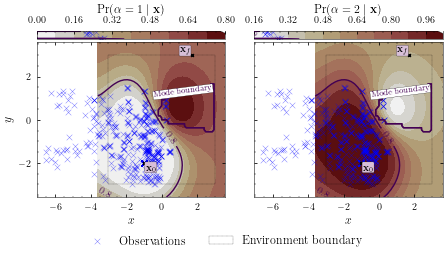

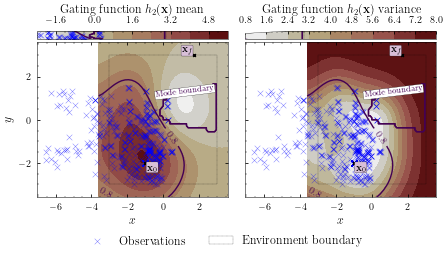

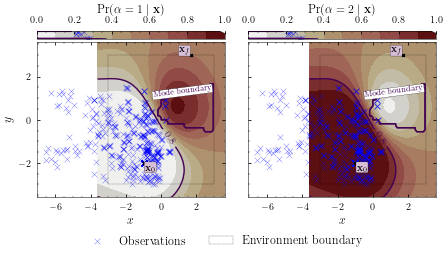

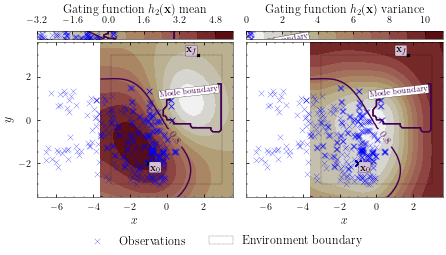

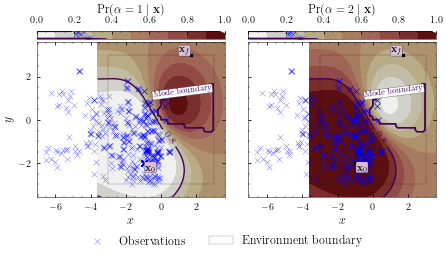

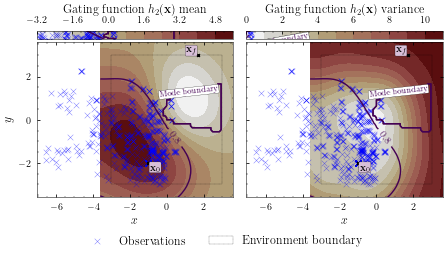

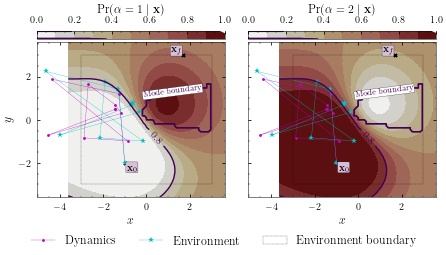

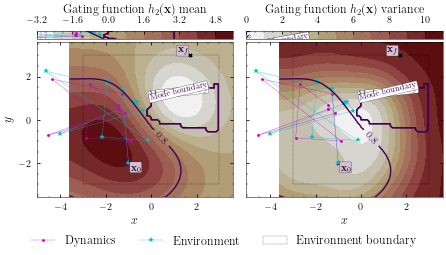

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -361.6936 - val_loss: -29.2248
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_11_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -331.2362

2022-04-08 15:18:37.362775: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 15:18:37.362791: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -331.2362 - val_loss: -84.1319
Epoch 3/10000
1/1 [==============================] - 0s 37ms/step - loss: -163.8316 - val_loss: -19.3119
Epoch 4/10000
1/1 [==============================] - 0s 39ms/step - loss: -468.4331 - val_loss: -81.8920


2022-04-08 15:18:39.417083: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 15:18:39.437725: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 15:18:39.450028: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_18_39

2022-04-08 15:18:39.459038: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_18_39/dr-robots-mbp.local.trace.json.gz
2022-04-08 15:18:39.492237: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_18_39

2022-04-08 15:18:39.492510: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

Epoch 5/10000
1/1 [==============================] - 0s 39ms/step - loss: -501.2886 - val_loss: -144.4150
Epoch 6/10000
1/1 [==============================] - 0s 39ms/step - loss: -448.1685 - val_loss: -157.6262
Epoch 7/10000
1/1 [==============================] - 0s 37ms/step - loss: -486.6409 - val_loss: -161.0507
Epoch 8/10000
1/1 [==============================] - 0s 36ms/step - loss: -388.1453 - val_loss: 3.3476
Epoch 9/10000
1/1 [==============================] - 0s 40ms/step - loss: -426.5040 - val_loss: 7.9849
Epoch 10/10000
1/1 [==============================] - 0s 40ms/step - loss: -493.5030 - val_loss: -118.5971
Epoch 11/10000
1/1 [==============================] - 0s 41ms/step - loss: -422.8757 - val_loss: -211.5867
Epoch 12/10000
1/1 [==============================] - 0s 41ms/step - loss: -489.1627 - val_loss: -182.9296
Epoch 13/10000
1/1 [==============================] - 0s 39ms/step - loss: -401.3561 - val_loss: -182.9830
Epoch 14/10000
1/1 [============================

1/1 [==============================] - 0s 41ms/step - loss: -513.6078 - val_loss: -125.8967
Epoch 83/10000
1/1 [==============================] - 0s 42ms/step - loss: -545.5961 - val_loss: -255.7377
Epoch 84/10000
1/1 [==============================] - 0s 40ms/step - loss: -459.0918 - val_loss: -194.0782
Epoch 85/10000
1/1 [==============================] - 0s 41ms/step - loss: -571.1745 - val_loss: -46.1755
Epoch 86/10000
1/1 [==============================] - 0s 42ms/step - loss: -508.3795 - val_loss: -120.6418
Epoch 87/10000
1/1 [==============================] - 0s 40ms/step - loss: -514.0468 - val_loss: -24.4673
Epoch 88/10000
1/1 [==============================] - 0s 45ms/step - loss: -222.0289 - val_loss: -22.8057
Epoch 89/10000
1/1 [==============================] - 0s 41ms/step - loss: -229.6397 - val_loss: 30.7895
Epoch 90/10000
1/1 [==============================] - 0s 41ms/step - loss: -498.2952 - val_loss: 1.3369
Epoch 91/10000
1/1 [==============================] - 0s 41m

Epoch 159/10000
1/1 [==============================] - 0s 42ms/step - loss: -358.6577 - val_loss: 29.5683
Epoch 160/10000
1/1 [==============================] - 0s 67ms/step - loss: -492.3098 - val_loss: -150.1246
Epoch 161/10000
1/1 [==============================] - 0s 44ms/step - loss: -554.7566 - val_loss: -236.2123
Epoch 162/10000
1/1 [==============================] - 0s 44ms/step - loss: -456.7445 - val_loss: -205.2877
Epoch 163/10000
1/1 [==============================] - 0s 45ms/step - loss: -530.7120 - val_loss: -218.8221
Epoch 164/10000
1/1 [==============================] - 0s 41ms/step - loss: -432.4221 - val_loss: -6.0116
Epoch 165/10000
1/1 [==============================] - 0s 42ms/step - loss: -490.1302 - val_loss: -198.1244
Epoch 166/10000
1/1 [==============================] - 0s 42ms/step - loss: -504.2410 - val_loss: -247.4935
Epoch 167/10000
1/1 [==============================] - 0s 43ms/step - loss: -537.8745 - val_loss: -239.6816
Epoch 168/10000
1/1 [===========

1/1 [==============================] - 0s 43ms/step - loss: -513.9382 - val_loss: 78.8166
Epoch 236/10000
1/1 [==============================] - 0s 43ms/step - loss: -551.5849 - val_loss: -160.1897
Epoch 237/10000
1/1 [==============================] - 0s 42ms/step - loss: -439.9897 - val_loss: -190.7067
Epoch 238/10000
1/1 [==============================] - 0s 43ms/step - loss: -543.3390 - val_loss: -243.6998
Epoch 239/10000
1/1 [==============================] - 0s 41ms/step - loss: -384.0293 - val_loss: 67.4261
Epoch 240/10000
1/1 [==============================] - 0s 42ms/step - loss: -577.1743 - val_loss: -164.1763
Epoch 241/10000
1/1 [==============================] - 0s 42ms/step - loss: -557.5426 - val_loss: -173.3938
Epoch 242/10000
1/1 [==============================] - 0s 43ms/step - loss: -469.1734 - val_loss: -75.3450
Epoch 243/10000
1/1 [==============================] - 0s 43ms/step - loss: -559.5903 - val_loss: -242.6019
Epoch 244/10000
1/1 [============================

1/1 [==============================] - 0s 46ms/step - loss: -238.2571 - val_loss: -14.4862
Epoch 312/10000
1/1 [==============================] - 0s 46ms/step - loss: -282.0577 - val_loss: -124.4274
Epoch 313/10000
1/1 [==============================] - 0s 45ms/step - loss: -321.8383 - val_loss: -117.5514
Epoch 314/10000
1/1 [==============================] - 0s 46ms/step - loss: -202.0916 - val_loss: -114.3026
Epoch 315/10000
1/1 [==============================] - 0s 47ms/step - loss: -360.6383 - val_loss: -86.5896
Epoch 316/10000
1/1 [==============================] - 0s 45ms/step - loss: -357.2737 - val_loss: -79.1887
Epoch 317/10000
1/1 [==============================] - 0s 46ms/step - loss: -373.4315 - val_loss: -136.7984
Epoch 318/10000
1/1 [==============================] - 0s 45ms/step - loss: -397.5455 - val_loss: -99.9105
Epoch 319/10000
1/1 [==============================] - 0s 48ms/step - loss: -401.8420 - val_loss: -153.0704
Epoch 320/10000
1/1 [===========================

1/1 [==============================] - 0s 44ms/step - loss: -476.6605 - val_loss: -187.4481
Epoch 388/10000
1/1 [==============================] - 0s 41ms/step - loss: -463.6887 - val_loss: -157.6263
Epoch 389/10000
1/1 [==============================] - 0s 41ms/step - loss: -463.3410 - val_loss: -161.2543
Epoch 390/10000
1/1 [==============================] - 0s 42ms/step - loss: -408.2368 - val_loss: -177.4030
Epoch 391/10000
1/1 [==============================] - 0s 42ms/step - loss: -375.1795 - val_loss: -41.5361
Epoch 392/10000
1/1 [==============================] - 0s 42ms/step - loss: -413.1078 - val_loss: -157.9256
Epoch 393/10000
1/1 [==============================] - 0s 42ms/step - loss: -448.7033 - val_loss: -113.4189
Epoch 394/10000
1/1 [==============================] - 0s 41ms/step - loss: -268.0487 - val_loss: 39.8639
Epoch 395/10000
1/1 [==============================] - 0s 42ms/step - loss: -443.3502 - val_loss: -169.1624
Epoch 396/10000
1/1 [==========================

1/1 [==============================] - 0s 43ms/step - loss: -532.4882 - val_loss: -265.1037
Epoch 464/10000
1/1 [==============================] - 0s 42ms/step - loss: -447.7570 - val_loss: -108.2363
Epoch 465/10000
1/1 [==============================] - 0s 41ms/step - loss: -507.2896 - val_loss: -191.3046
Epoch 466/10000
1/1 [==============================] - 0s 43ms/step - loss: -477.1023 - val_loss: -176.3137
Epoch 467/10000
1/1 [==============================] - 0s 43ms/step - loss: -485.2080 - val_loss: -235.1524
Epoch 468/10000
1/1 [==============================] - 0s 42ms/step - loss: -409.9643 - val_loss: 13.1941
Epoch 469/10000
1/1 [==============================] - 0s 42ms/step - loss: -526.1715 - val_loss: -259.5456
Epoch 470/10000
1/1 [==============================] - 0s 42ms/step - loss: -528.2077 - val_loss: -231.4020
Epoch 471/10000
1/1 [==============================] - 0s 43ms/step - loss: -544.9510 - val_loss: -128.3500
Epoch 472/10000
1/1 [=========================

1/1 [==============================] - 0s 44ms/step - loss: -314.2248 - val_loss: -199.6170
Epoch 540/10000
1/1 [==============================] - 0s 43ms/step - loss: -446.2824 - val_loss: -125.4942
Epoch 541/10000
1/1 [==============================] - 0s 43ms/step - loss: -311.9916 - val_loss: -184.0917
Epoch 542/10000
1/1 [==============================] - 0s 44ms/step - loss: -487.4350 - val_loss: -179.6205
Epoch 543/10000
1/1 [==============================] - 0s 41ms/step - loss: -429.2081 - val_loss: -119.5329
Epoch 544/10000
1/1 [==============================] - 0s 42ms/step - loss: -477.6293 - val_loss: -170.2155
Epoch 545/10000
1/1 [==============================] - 0s 43ms/step - loss: -499.8841 - val_loss: -61.6821
Epoch 546/10000
1/1 [==============================] - 0s 42ms/step - loss: -402.2871 - val_loss: -144.6403
Epoch 547/10000
1/1 [==============================] - 0s 42ms/step - loss: -407.5775 - val_loss: -183.5567
Epoch 548/10000
1/1 [========================

1/1 [==============================] - 0s 45ms/step - loss: -536.3819 - val_loss: -120.5244
Epoch 616/10000
1/1 [==============================] - 0s 46ms/step - loss: -471.2832 - val_loss: -144.9393
Epoch 617/10000
1/1 [==============================] - 0s 45ms/step - loss: -364.4470 - val_loss: -128.6386
Epoch 618/10000
1/1 [==============================] - 0s 48ms/step - loss: -488.0984 - val_loss: -256.7785
Epoch 619/10000
1/1 [==============================] - 0s 46ms/step - loss: -315.3888 - val_loss: -244.4543
Epoch 620/10000
1/1 [==============================] - 0s 47ms/step - loss: -399.2927 - val_loss: -78.4443
Epoch 621/10000
1/1 [==============================] - 0s 45ms/step - loss: -493.1301 - val_loss: -240.1471
Epoch 622/10000
1/1 [==============================] - 0s 46ms/step - loss: -471.9352 - val_loss: -232.2278
Epoch 623/10000
1/1 [==============================] - 0s 45ms/step - loss: -501.8664 - val_loss: -237.9089
Epoch 624/10000
1/1 [========================

1/1 [==============================] - 0s 43ms/step - loss: -481.6204 - val_loss: -112.0740
Epoch 692/10000
1/1 [==============================] - 0s 43ms/step - loss: -384.1374 - val_loss: 91.4072
Epoch 693/10000
1/1 [==============================] - 0s 43ms/step - loss: -518.7409 - val_loss: -209.6540
Epoch 694/10000
1/1 [==============================] - 0s 42ms/step - loss: -359.7944 - val_loss: -54.2291
Epoch 695/10000
1/1 [==============================] - 0s 42ms/step - loss: -491.6449 - val_loss: -263.4527
Epoch 696/10000
1/1 [==============================] - 0s 42ms/step - loss: -496.9478 - val_loss: -36.6964
Epoch 697/10000
1/1 [==============================] - 0s 42ms/step - loss: -464.2056 - val_loss: -190.0528
Epoch 698/10000
1/1 [==============================] - 0s 43ms/step - loss: -460.3057 - val_loss: -158.5950
Epoch 699/10000
1/1 [==============================] - 0s 42ms/step - loss: -468.3421 - val_loss: -238.3290
Epoch 700/10000
1/1 [===========================

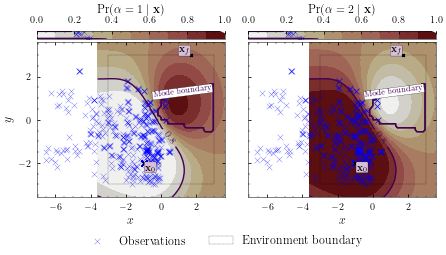

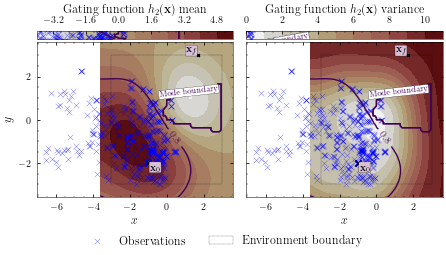

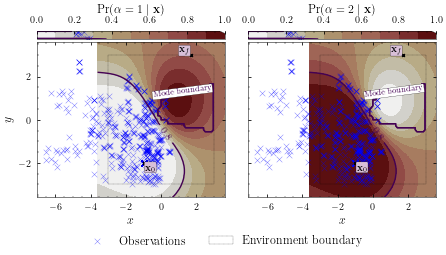

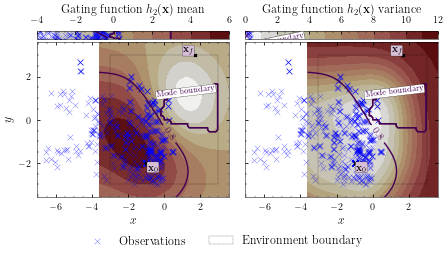

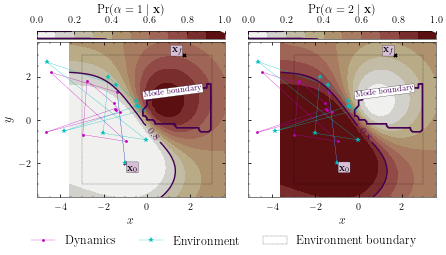

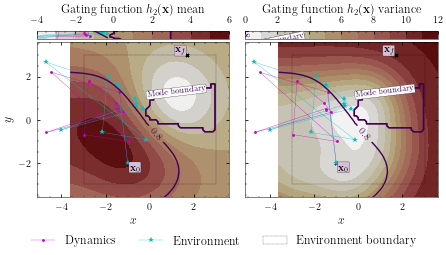

Epoch 1/10000
1/1 [==============================] - 1s 774ms/step - loss: -453.5191 - val_loss: 66.7682
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_12_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -458.2898

2022-04-08 15:21:47.303134: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 15:21:47.303150: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -458.2898 - val_loss: 37.6558
Epoch 3/10000
1/1 [==============================] - 0s 37ms/step - loss: -485.3298 - val_loss: -14.0743
Epoch 4/10000
1/1 [==============================] - 0s 36ms/step - loss: -430.2667 - val_loss: 194.4735
Epoch 5/10000
1/1 [==============================] - 0s 37ms/step - loss: -441.6546 - val_loss: -136.0357


2022-04-08 15:21:49.309256: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 15:21:49.323174: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 15:21:49.330973: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_21_49

2022-04-08 15:21:49.337944: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_21_49/dr-robots-mbp.local.trace.json.gz
2022-04-08 15:21:49.360742: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_21_49

2022-04-08 15:21:49.361037: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

Epoch 6/10000
1/1 [==============================] - 0s 36ms/step - loss: -449.0511 - val_loss: 30.4063
Epoch 7/10000
1/1 [==============================] - 0s 36ms/step - loss: -499.9033 - val_loss: -194.5848
Epoch 8/10000
1/1 [==============================] - 0s 37ms/step - loss: -502.2611 - val_loss: -148.3974
Epoch 9/10000
1/1 [==============================] - 0s 37ms/step - loss: -393.3078 - val_loss: 0.2423
Epoch 10/10000
1/1 [==============================] - 0s 36ms/step - loss: -416.4059 - val_loss: 15.7374
Epoch 11/10000
1/1 [==============================] - 0s 35ms/step - loss: -487.4954 - val_loss: -195.7028
Epoch 12/10000
1/1 [==============================] - 0s 36ms/step - loss: -477.1072 - val_loss: 212.2192
Epoch 13/10000
1/1 [==============================] - 0s 36ms/step - loss: -477.7592 - val_loss: -52.8219
Epoch 14/10000
1/1 [==============================] - 0s 36ms/step - loss: -495.8438 - val_loss: -222.1797
Epoch 15/10000
1/1 [==============================

Epoch 83/10000
1/1 [==============================] - 0s 44ms/step - loss: -471.1875 - val_loss: -181.7636
Epoch 84/10000
1/1 [==============================] - 0s 42ms/step - loss: -539.4517 - val_loss: -182.9138
Epoch 85/10000
1/1 [==============================] - 0s 52ms/step - loss: -505.4427 - val_loss: -105.2497
Epoch 86/10000
1/1 [==============================] - 0s 44ms/step - loss: -515.4206 - val_loss: -234.7412
Epoch 87/10000
1/1 [==============================] - 0s 43ms/step - loss: -447.5825 - val_loss: -49.2436
Epoch 88/10000
1/1 [==============================] - 0s 45ms/step - loss: -511.9107 - val_loss: -192.5198
Epoch 89/10000
1/1 [==============================] - 0s 48ms/step - loss: -469.5315 - val_loss: -39.7353
Epoch 90/10000
1/1 [==============================] - 0s 45ms/step - loss: -540.7113 - val_loss: -234.2573
Epoch 91/10000
1/1 [==============================] - 0s 48ms/step - loss: -477.0322 - val_loss: -246.7159
Epoch 92/10000
1/1 [===================

1/1 [==============================] - 0s 44ms/step - loss: -354.7203 - val_loss: -70.3450
Epoch 160/10000
1/1 [==============================] - 0s 44ms/step - loss: -291.2147 - val_loss: 34.5566
Epoch 161/10000
1/1 [==============================] - 0s 44ms/step - loss: -334.3107 - val_loss: -189.0397
Epoch 162/10000
1/1 [==============================] - 0s 43ms/step - loss: -202.3621 - val_loss: -87.0267
Epoch 163/10000
1/1 [==============================] - 0s 46ms/step - loss: 154.1815 - val_loss: -198.7123
Epoch 164/10000
1/1 [==============================] - 0s 45ms/step - loss: -390.8040 - val_loss: 23.9635
Epoch 165/10000
1/1 [==============================] - 0s 44ms/step - loss: -218.9185 - val_loss: 221.2392
Epoch 166/10000
1/1 [==============================] - 0s 43ms/step - loss: -340.2142 - val_loss: 29.4717
Epoch 167/10000
1/1 [==============================] - 0s 42ms/step - loss: -174.6477 - val_loss: 87.2059
Epoch 168/10000
1/1 [==============================] - 0

1/1 [==============================] - 0s 43ms/step - loss: -420.1123 - val_loss: -251.1842
Epoch 236/10000
1/1 [==============================] - 0s 42ms/step - loss: -465.1132 - val_loss: -118.0823
Epoch 237/10000
1/1 [==============================] - 0s 44ms/step - loss: -462.4253 - val_loss: -124.4097
Epoch 238/10000
1/1 [==============================] - 0s 44ms/step - loss: -466.6344 - val_loss: -159.7094
Epoch 239/10000
1/1 [==============================] - 0s 44ms/step - loss: -426.2643 - val_loss: -162.4469
Epoch 240/10000
1/1 [==============================] - 0s 42ms/step - loss: -454.8040 - val_loss: -48.1911
Epoch 241/10000
1/1 [==============================] - 0s 44ms/step - loss: -419.6472 - val_loss: -77.5170
Epoch 242/10000
1/1 [==============================] - 0s 42ms/step - loss: -470.2720 - val_loss: -201.7144
Epoch 243/10000
1/1 [==============================] - 0s 43ms/step - loss: -455.0372 - val_loss: -103.9789
Epoch 244/10000
1/1 [=========================

1/1 [==============================] - 0s 44ms/step - loss: -520.4320 - val_loss: -320.5856
Epoch 312/10000
1/1 [==============================] - 0s 44ms/step - loss: -501.8810 - val_loss: -133.8908
Epoch 313/10000
1/1 [==============================] - 0s 44ms/step - loss: -551.8250 - val_loss: -251.1099
Epoch 314/10000
1/1 [==============================] - 0s 45ms/step - loss: -539.3508 - val_loss: 41.2200
Epoch 315/10000
1/1 [==============================] - 0s 48ms/step - loss: -557.5634 - val_loss: -204.9161
Epoch 316/10000
1/1 [==============================] - 0s 87ms/step - loss: -535.7557 - val_loss: -58.3427
Epoch 317/10000
1/1 [==============================] - 0s 65ms/step - loss: -550.4540 - val_loss: -121.4554
Epoch 318/10000
1/1 [==============================] - 0s 55ms/step - loss: -574.2553 - val_loss: -257.8579
Epoch 319/10000
1/1 [==============================] - 0s 56ms/step - loss: -564.0597 - val_loss: -259.7597
Epoch 320/10000
1/1 [==========================

1/1 [==============================] - 0s 77ms/step - loss: -433.2696 - val_loss: -153.6812
Epoch 388/10000
1/1 [==============================] - 0s 72ms/step - loss: -479.3628 - val_loss: 74.8966
Epoch 389/10000
1/1 [==============================] - 0s 75ms/step - loss: -523.3445 - val_loss: -175.5918
Epoch 390/10000
1/1 [==============================] - 0s 62ms/step - loss: -213.4305 - val_loss: 142.5176
Epoch 391/10000
1/1 [==============================] - 0s 65ms/step - loss: 354.9869 - val_loss: 316.1465
Epoch 392/10000
1/1 [==============================] - 0s 66ms/step - loss: -177.8058 - val_loss: -109.2859
Epoch 393/10000
1/1 [==============================] - 0s 70ms/step - loss: 194.0708 - val_loss: -106.5147
Epoch 394/10000
1/1 [==============================] - 0s 68ms/step - loss: -244.9553 - val_loss: -137.8920
Epoch 395/10000
1/1 [==============================] - 0s 72ms/step - loss: -355.1798 - val_loss: 116.6629
Epoch 396/10000
1/1 [==============================

1/1 [==============================] - 0s 75ms/step - loss: -180.3929 - val_loss: -72.6591
Epoch 464/10000
1/1 [==============================] - 0s 73ms/step - loss: -457.1587 - val_loss: 5.4072
Epoch 465/10000
1/1 [==============================] - 0s 63ms/step - loss: -457.2900 - val_loss: -231.6523
Epoch 466/10000
1/1 [==============================] - 0s 62ms/step - loss: -508.1343 - val_loss: -223.2120
Epoch 467/10000
1/1 [==============================] - 0s 65ms/step - loss: -483.7906 - val_loss: -116.6099
Epoch 468/10000
1/1 [==============================] - 0s 61ms/step - loss: -466.1044 - val_loss: -97.3007
Epoch 469/10000
1/1 [==============================] - 0s 59ms/step - loss: -471.8137 - val_loss: -172.1622
Epoch 470/10000
1/1 [==============================] - 0s 72ms/step - loss: -495.7411 - val_loss: -193.7619
Epoch 471/10000
1/1 [==============================] - 0s 59ms/step - loss: -447.9084 - val_loss: -262.2502
Epoch 472/10000
1/1 [============================

1/1 [==============================] - 0s 60ms/step - loss: -465.5682 - val_loss: -222.1482
Epoch 540/10000
1/1 [==============================] - 0s 64ms/step - loss: -477.1555 - val_loss: -214.8790
Epoch 541/10000
1/1 [==============================] - 0s 64ms/step - loss: -496.5145 - val_loss: -260.3105
Epoch 542/10000
1/1 [==============================] - 0s 60ms/step - loss: -463.8276 - val_loss: -141.1672
Epoch 543/10000
1/1 [==============================] - 0s 70ms/step - loss: -285.7237 - val_loss: -51.6733
Epoch 544/10000
1/1 [==============================] - 0s 68ms/step - loss: -533.9720 - val_loss: -224.3054
Epoch 545/10000
1/1 [==============================] - 0s 67ms/step - loss: -403.9306 - val_loss: -165.9334
Epoch 546/10000
1/1 [==============================] - 0s 78ms/step - loss: -496.6060 - val_loss: -208.7757
Epoch 547/10000
1/1 [==============================] - 0s 75ms/step - loss: -536.9722 - val_loss: 48.9949
Epoch 548/10000
1/1 [==========================

1/1 [==============================] - 0s 74ms/step - loss: -513.9799 - val_loss: -304.2597
Epoch 616/10000
1/1 [==============================] - 0s 75ms/step - loss: -505.7617 - val_loss: -63.3243
Epoch 617/10000
1/1 [==============================] - 0s 80ms/step - loss: -559.3683 - val_loss: -105.1309
Epoch 618/10000
1/1 [==============================] - 0s 71ms/step - loss: -525.8793 - val_loss: -52.8688
Epoch 619/10000
1/1 [==============================] - 0s 68ms/step - loss: -523.1742 - val_loss: -311.3751
Epoch 620/10000
1/1 [==============================] - 0s 72ms/step - loss: -549.0717 - val_loss: -243.8537
Epoch 621/10000
1/1 [==============================] - 0s 73ms/step - loss: -471.3377 - val_loss: -241.0947
Epoch 622/10000
1/1 [==============================] - 0s 75ms/step - loss: -529.2578 - val_loss: -161.0120
Epoch 623/10000
1/1 [==============================] - 0s 73ms/step - loss: -534.0233 - val_loss: -48.5066
Epoch 624/10000
1/1 [==========================

1/1 [==============================] - 0s 90ms/step - loss: -505.7856 - val_loss: -166.6549
Epoch 692/10000
1/1 [==============================] - 0s 72ms/step - loss: 122.6740 - val_loss: -99.7959
Epoch 693/10000
1/1 [==============================] - 0s 72ms/step - loss: -7.6826 - val_loss: -41.8829
Epoch 694/10000
1/1 [==============================] - 0s 66ms/step - loss: -532.7945 - val_loss: -221.7107
Epoch 695/10000
1/1 [==============================] - 0s 70ms/step - loss: -510.6292 - val_loss: -127.4573
Epoch 696/10000
1/1 [==============================] - 0s 74ms/step - loss: -415.1284 - val_loss: -255.3828
Epoch 697/10000
1/1 [==============================] - 0s 68ms/step - loss: -310.9216 - val_loss: 90.8753
Epoch 698/10000
1/1 [==============================] - 0s 82ms/step - loss: -355.6178 - val_loss: 2.6986
Epoch 699/10000
1/1 [==============================] - 0s 77ms/step - loss: -321.8196 - val_loss: 129.5821
Epoch 700/10000
1/1 [==============================] - 

1/1 [==============================] - 0s 96ms/step - loss: -536.6975 - val_loss: -243.8838
Epoch 768/10000
1/1 [==============================] - 0s 76ms/step - loss: -490.3003 - val_loss: -261.1886
Epoch 769/10000
1/1 [==============================] - 0s 83ms/step - loss: -493.3768 - val_loss: -244.1400
Epoch 770/10000
1/1 [==============================] - 0s 96ms/step - loss: -555.9492 - val_loss: -233.1354
Epoch 771/10000
1/1 [==============================] - 0s 103ms/step - loss: -477.4625 - val_loss: -132.8378
Epoch 772/10000
1/1 [==============================] - 0s 90ms/step - loss: -495.6307 - val_loss: -239.5030
Epoch 773/10000
1/1 [==============================] - 0s 89ms/step - loss: -473.0455 - val_loss: -179.0613
Epoch 774/10000
1/1 [==============================] - 0s 104ms/step - loss: -544.5699 - val_loss: -182.7865
Epoch 775/10000
1/1 [==============================] - 0s 90ms/step - loss: -533.2393 - val_loss: -227.5116
Epoch 776/10000
1/1 [=====================

entropy
-3.4825042979891161
cost
1.2431433617337575
entropy
-3.4873873996026488
cost
1.2470878166772112
entropy
-3.4888758812564604
cost
1.2483487427797562
entropy
-3.4890015011598843
cost
1.2484089650553214
entropy
-3.4887920174516824
cost
1.2479466552530416
entropy
-3.4878770978619991
cost
1.2467005884006659
entropy
-3.4834878782556653
cost
1.2415192849552077
entropy
-3.4816138527676994
cost
1.2394863377697212
entropy
-3.4804622248473538
cost
1.2381898907860367
entropy
-3.4806542861428467
cost
1.2383355245568795
entropy
-3.4813949971503293
cost
1.2390389770258881
entropy
-3.4824967263338134
cost
1.2400583826542753
entropy
-3.4827544682473115
cost
1.24023477446105
entropy
-3.4820981610425061
cost
1.2394950496611825
entropy
-3.4812281050929426
cost
1.2385951946203966
entropy
-3.4808861797682007
cost
1.2382460072315549
entropy
-3.4807693407901241
cost
1.2381224185314244
entropy
-3.4807425690616927
cost
1.2380812868263122
entropy
-3.4809478623114449
cost
1.2382579585742206
entropy
-3.481

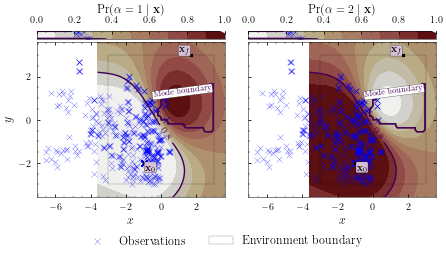

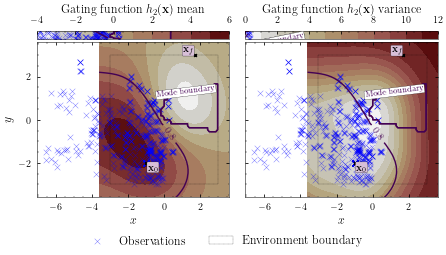

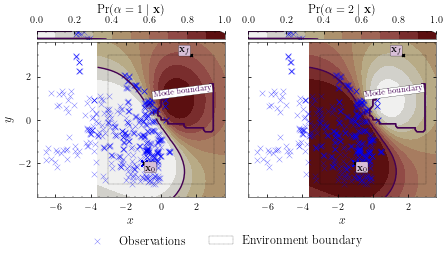

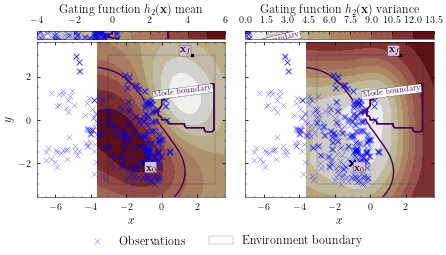

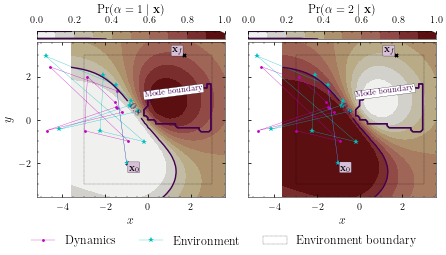

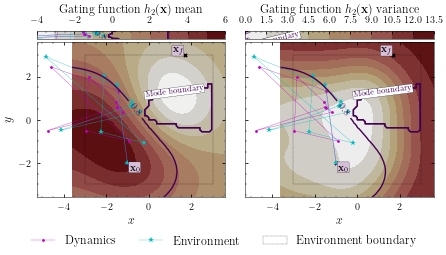

Epoch 1/10000
1/1 [==============================] - 1s 638ms/step - loss: -537.4380 - val_loss: -96.7226
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_13_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -549.4719

2022-04-08 15:25:37.340588: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 15:25:37.340600: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -549.4719 - val_loss: -147.0739
Epoch 3/10000
1/1 [==============================] - ETA: 0s - loss: -468.3931

2022-04-08 15:25:39.349353: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 15:25:39.379132: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 15:25:39.395677: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_25_39

2022-04-08 15:25:39.406499: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_25_39/dr-robots-mbp.local.trace.json.gz
2022-04-08 15:25:39.447341: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_25_39

2022-04-08 15:25:39.447893: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

1/1 [==============================] - 0s 61ms/step - loss: -468.3931 - val_loss: -152.3069
Epoch 4/10000
1/1 [==============================] - 0s 61ms/step - loss: -285.5530 - val_loss: -202.7747
Epoch 5/10000
1/1 [==============================] - 0s 74ms/step - loss: -514.5793 - val_loss: -15.7661
Epoch 6/10000
1/1 [==============================] - 0s 63ms/step - loss: -432.1782 - val_loss: -103.3832
Epoch 7/10000
1/1 [==============================] - 0s 61ms/step - loss: -353.6293 - val_loss: 173.5733
Epoch 8/10000
1/1 [==============================] - 0s 66ms/step - loss: -506.9054 - val_loss: -125.9113
Epoch 9/10000
1/1 [==============================] - 0s 59ms/step - loss: -399.2199 - val_loss: -53.6522
Epoch 10/10000
1/1 [==============================] - 0s 51ms/step - loss: -556.4110 - val_loss: -192.6128
Epoch 11/10000
1/1 [==============================] - 0s 49ms/step - loss: -380.8520 - val_loss: 207.0453
Epoch 12/10000
1/1 [==============================] - 0s 48ms/

1/1 [==============================] - 0s 57ms/step - loss: -452.0993 - val_loss: -83.5583
Epoch 81/10000
1/1 [==============================] - 0s 56ms/step - loss: -332.6068 - val_loss: -212.1858
Epoch 82/10000
1/1 [==============================] - 0s 58ms/step - loss: -387.5213 - val_loss: -128.8788
Epoch 83/10000
1/1 [==============================] - 0s 59ms/step - loss: -355.5537 - val_loss: -224.8277
Epoch 84/10000
1/1 [==============================] - 0s 58ms/step - loss: -435.9092 - val_loss: -234.6699
Epoch 85/10000
1/1 [==============================] - 0s 54ms/step - loss: -485.1389 - val_loss: -179.4227
Epoch 86/10000
1/1 [==============================] - 0s 63ms/step - loss: -458.4523 - val_loss: -179.0571
Epoch 87/10000
1/1 [==============================] - 0s 54ms/step - loss: -453.7156 - val_loss: -172.3747
Epoch 88/10000
1/1 [==============================] - 0s 50ms/step - loss: -495.0404 - val_loss: -179.0299
Epoch 89/10000
1/1 [==============================] -

1/1 [==============================] - 0s 55ms/step - loss: -516.5798 - val_loss: -264.9257
Epoch 157/10000
1/1 [==============================] - 0s 56ms/step - loss: -562.8019 - val_loss: -255.4805
Epoch 158/10000
1/1 [==============================] - 0s 55ms/step - loss: -562.6677 - val_loss: -214.3227
Epoch 159/10000
1/1 [==============================] - 0s 61ms/step - loss: -532.5407 - val_loss: -248.9247
Epoch 160/10000
1/1 [==============================] - 0s 61ms/step - loss: -582.2702 - val_loss: -255.4054
Epoch 161/10000
1/1 [==============================] - 0s 62ms/step - loss: -524.3261 - val_loss: -243.4493
Epoch 162/10000
1/1 [==============================] - 0s 60ms/step - loss: -471.8786 - val_loss: -144.9436
Epoch 163/10000
1/1 [==============================] - 0s 71ms/step - loss: -558.1757 - val_loss: -246.8202
Epoch 164/10000
1/1 [==============================] - 0s 63ms/step - loss: -324.0603 - val_loss: -168.9671
Epoch 165/10000
1/1 [=======================

1/1 [==============================] - 0s 74ms/step - loss: -418.0039 - val_loss: -250.2602
Epoch 233/10000
1/1 [==============================] - 0s 72ms/step - loss: -457.1509 - val_loss: -224.8226
Epoch 234/10000
1/1 [==============================] - 0s 70ms/step - loss: -77.4610 - val_loss: -274.0872
Epoch 235/10000
1/1 [==============================] - 0s 71ms/step - loss: -528.9319 - val_loss: -201.5176
Epoch 236/10000
1/1 [==============================] - 0s 88ms/step - loss: -375.5254 - val_loss: -195.6247
Epoch 237/10000
1/1 [==============================] - 0s 65ms/step - loss: -249.3261 - val_loss: -230.5187
Epoch 238/10000
1/1 [==============================] - 0s 68ms/step - loss: -491.7445 - val_loss: -205.2552
Epoch 239/10000
1/1 [==============================] - 0s 80ms/step - loss: -488.7200 - val_loss: -218.9437
Epoch 240/10000
1/1 [==============================] - 0s 82ms/step - loss: -160.8835 - val_loss: -78.6540
Epoch 241/10000
1/1 [=========================

1/1 [==============================] - 0s 71ms/step - loss: -420.0064 - val_loss: -5.0915
Epoch 309/10000
1/1 [==============================] - 0s 76ms/step - loss: -471.9922 - val_loss: -149.3700
Epoch 310/10000
1/1 [==============================] - 0s 70ms/step - loss: -536.2241 - val_loss: -268.4778
Epoch 311/10000
1/1 [==============================] - 0s 90ms/step - loss: -398.4724 - val_loss: -189.3035
Epoch 312/10000
1/1 [==============================] - 0s 73ms/step - loss: -506.3360 - val_loss: -278.4318
Epoch 313/10000
1/1 [==============================] - 0s 68ms/step - loss: -523.1493 - val_loss: -223.1312
Epoch 314/10000
1/1 [==============================] - 0s 70ms/step - loss: -556.6793 - val_loss: -218.8051
Epoch 315/10000
1/1 [==============================] - 0s 77ms/step - loss: -522.2269 - val_loss: -169.4378
Epoch 316/10000
1/1 [==============================] - 0s 70ms/step - loss: -526.4143 - val_loss: -273.0474
Epoch 317/10000
1/1 [=========================

1/1 [==============================] - 0s 68ms/step - loss: -433.3929 - val_loss: -163.2465
Epoch 385/10000
1/1 [==============================] - 0s 68ms/step - loss: -480.5339 - val_loss: -192.5211
Epoch 386/10000
1/1 [==============================] - 0s 66ms/step - loss: -357.6738 - val_loss: -243.9328
Epoch 387/10000
1/1 [==============================] - 0s 75ms/step - loss: -457.7231 - val_loss: -231.9485
Epoch 388/10000
1/1 [==============================] - 0s 71ms/step - loss: -421.1569 - val_loss: -176.7314
Epoch 389/10000
1/1 [==============================] - 0s 120ms/step - loss: -402.6286 - val_loss: -132.7857
Epoch 390/10000
1/1 [==============================] - 0s 99ms/step - loss: -466.5790 - val_loss: -182.3931
Epoch 391/10000
1/1 [==============================] - 0s 73ms/step - loss: -445.6312 - val_loss: -164.1094
Epoch 392/10000
1/1 [==============================] - 0s 84ms/step - loss: -393.0484 - val_loss: -126.6026
Epoch 393/10000
1/1 [======================

1/1 [==============================] - 0s 84ms/step - loss: -561.5142 - val_loss: -255.2627
Epoch 461/10000
1/1 [==============================] - 0s 83ms/step - loss: -218.9722 - val_loss: -201.7512
Epoch 462/10000
1/1 [==============================] - 0s 78ms/step - loss: -356.2656 - val_loss: -248.2660
Epoch 463/10000
1/1 [==============================] - 0s 81ms/step - loss: -494.3033 - val_loss: -261.8219
Epoch 464/10000
1/1 [==============================] - 0s 83ms/step - loss: -522.0228 - val_loss: -216.7133
Epoch 465/10000
1/1 [==============================] - 0s 75ms/step - loss: -550.1812 - val_loss: -259.9670
Epoch 466/10000
1/1 [==============================] - 0s 76ms/step - loss: -445.7438 - val_loss: -249.0980
Epoch 467/10000
1/1 [==============================] - 0s 73ms/step - loss: -558.1654 - val_loss: -255.2534
Epoch 468/10000
1/1 [==============================] - 0s 85ms/step - loss: -390.4271 - val_loss: -81.3192
Epoch 469/10000
1/1 [========================

Epoch 536/10000
1/1 [==============================] - 0s 68ms/step - loss: -518.5049 - val_loss: -118.2026
Epoch 537/10000
1/1 [==============================] - 0s 68ms/step - loss: -485.2749 - val_loss: -277.1442
Epoch 538/10000
1/1 [==============================] - 0s 69ms/step - loss: -438.2129 - val_loss: -321.1285
Epoch 539/10000
1/1 [==============================] - 0s 70ms/step - loss: -547.9737 - val_loss: -169.4607
Epoch 540/10000
1/1 [==============================] - 0s 70ms/step - loss: -525.4383 - val_loss: -272.4369
Epoch 541/10000
1/1 [==============================] - 0s 69ms/step - loss: -521.4284 - val_loss: -287.6912
Epoch 542/10000
1/1 [==============================] - 0s 69ms/step - loss: -563.6284 - val_loss: -218.6024
Epoch 543/10000
1/1 [==============================] - 0s 64ms/step - loss: -582.6229 - val_loss: -322.3138
Epoch 544/10000
1/1 [==============================] - 0s 61ms/step - loss: -556.1533 - val_loss: -184.5466
Epoch 545/10000
1/1 [=======

Epoch 612/10000
1/1 [==============================] - 0s 70ms/step - loss: -170.1641 - val_loss: -124.1229
Epoch 613/10000
1/1 [==============================] - 0s 79ms/step - loss: -32.7064 - val_loss: -13.0965
Epoch 614/10000
1/1 [==============================] - 0s 72ms/step - loss: -591.9564 - val_loss: -257.2762
Epoch 615/10000
1/1 [==============================] - 0s 76ms/step - loss: -469.5561 - val_loss: 150.1722
Epoch 616/10000
1/1 [==============================] - 0s 71ms/step - loss: -422.8177 - val_loss: -94.1216
Epoch 617/10000
1/1 [==============================] - 0s 63ms/step - loss: -519.8028 - val_loss: -213.8144
Epoch 618/10000
1/1 [==============================] - 0s 67ms/step - loss: -218.8550 - val_loss: -150.7079
Epoch 619/10000
1/1 [==============================] - 0s 66ms/step - loss: -457.6063 - val_loss: -308.9793
Epoch 620/10000
1/1 [==============================] - 0s 62ms/step - loss: -101.3767 - val_loss: -5.7968
Epoch 621/10000
1/1 [=============

1/1 [==============================] - 0s 65ms/step - loss: -494.0893 - val_loss: -224.3701
Epoch 689/10000
1/1 [==============================] - 0s 64ms/step - loss: -492.0433 - val_loss: -273.6865
Epoch 690/10000
1/1 [==============================] - 0s 60ms/step - loss: -537.9436 - val_loss: -244.8590
Epoch 691/10000
1/1 [==============================] - 0s 73ms/step - loss: -535.2075 - val_loss: -235.4004
Epoch 692/10000
1/1 [==============================] - 0s 75ms/step - loss: -506.3125 - val_loss: -153.5888
Epoch 693/10000
1/1 [==============================] - 0s 68ms/step - loss: -523.9514 - val_loss: -252.0725
Epoch 694/10000
1/1 [==============================] - 0s 66ms/step - loss: -549.3494 - val_loss: -260.3861
Epoch 695/10000
1/1 [==============================] - 0s 62ms/step - loss: -498.7859 - val_loss: -139.3342
Epoch 696/10000
1/1 [==============================] - 0s 58ms/step - loss: -525.1584 - val_loss: -216.6160
Epoch 697/10000
1/1 [=======================

1/1 [==============================] - 0s 65ms/step - loss: -385.6607 - val_loss: -170.5926
Epoch 765/10000
1/1 [==============================] - 0s 75ms/step - loss: -464.0543 - val_loss: -239.7272
Epoch 766/10000
1/1 [==============================] - 0s 75ms/step - loss: -499.4762 - val_loss: -321.8702
Epoch 767/10000
1/1 [==============================] - 0s 64ms/step - loss: -450.8158 - val_loss: -288.9172
Epoch 768/10000
1/1 [==============================] - 0s 67ms/step - loss: -469.3873 - val_loss: -159.3833
Epoch 769/10000
1/1 [==============================] - 0s 65ms/step - loss: -506.5455 - val_loss: -235.1669
Epoch 770/10000
1/1 [==============================] - 0s 73ms/step - loss: -538.0111 - val_loss: -222.8958
Epoch 771/10000
1/1 [==============================] - 0s 78ms/step - loss: -516.8717 - val_loss: -265.9661
Epoch 772/10000
1/1 [==============================] - 0s 70ms/step - loss: -515.2502 - val_loss: -229.3577
Epoch 773/10000
1/1 [=======================

1/1 [==============================] - 0s 66ms/step - loss: -493.9701 - val_loss: -268.4466
Epoch 841/10000
1/1 [==============================] - 0s 80ms/step - loss: -559.2791 - val_loss: -253.8684
Epoch 842/10000
1/1 [==============================] - 0s 73ms/step - loss: -539.1390 - val_loss: -248.5283
Epoch 843/10000
1/1 [==============================] - 0s 66ms/step - loss: -530.7439 - val_loss: -264.2699
Epoch 844/10000
1/1 [==============================] - 0s 77ms/step - loss: -527.8530 - val_loss: -249.6621
Epoch 845/10000
1/1 [==============================] - 0s 73ms/step - loss: -534.3848 - val_loss: -252.8407
Epoch 846/10000
1/1 [==============================] - 0s 76ms/step - loss: -504.3189 - val_loss: -210.1361
Epoch 847/10000
1/1 [==============================] - 0s 90ms/step - loss: -531.6805 - val_loss: -267.1086
Epoch 848/10000
1/1 [==============================] - 0s 75ms/step - loss: -555.8893 - val_loss: -248.4517
Epoch 849/10000
1/1 [=======================

1/1 [==============================] - 0s 60ms/step - loss: -211.7137 - val_loss: -198.4072
Epoch 917/10000
1/1 [==============================] - 0s 60ms/step - loss: -532.2600 - val_loss: -224.0736
Epoch 918/10000
1/1 [==============================] - 0s 69ms/step - loss: -360.5145 - val_loss: -188.0170
Epoch 919/10000
1/1 [==============================] - 0s 71ms/step - loss: -15.4933 - val_loss: -221.9762
Epoch 920/10000
1/1 [==============================] - 0s 65ms/step - loss: 314.5149 - val_loss: -163.9641
Epoch 921/10000
1/1 [==============================] - 0s 67ms/step - loss: -155.0866 - val_loss: -231.8421
Epoch 922/10000
1/1 [==============================] - 0s 75ms/step - loss: -488.1049 - val_loss: -251.3647
Epoch 923/10000
1/1 [==============================] - 0s 59ms/step - loss: -481.6570 - val_loss: -210.6117
Epoch 924/10000
1/1 [==============================] - 0s 61ms/step - loss: -414.3407 - val_loss: -133.9519
Epoch 925/10000
1/1 [=========================

1/1 [==============================] - 0s 73ms/step - loss: -537.1845 - val_loss: -249.2387
Epoch 993/10000
1/1 [==============================] - 0s 66ms/step - loss: -549.8438 - val_loss: -207.7565
Epoch 994/10000
1/1 [==============================] - 0s 60ms/step - loss: -515.3561 - val_loss: -272.1989
Epoch 995/10000
1/1 [==============================] - 0s 65ms/step - loss: -547.2097 - val_loss: -227.0305
Epoch 996/10000
1/1 [==============================] - 0s 66ms/step - loss: -538.1672 - val_loss: -264.4922
Epoch 997/10000
1/1 [==============================] - 0s 60ms/step - loss: -565.9824 - val_loss: -215.2779
Epoch 998/10000
1/1 [==============================] - 0s 60ms/step - loss: -525.7703 - val_loss: -173.0333
Epoch 999/10000
1/1 [==============================] - 0s 67ms/step - loss: -496.0815 - val_loss: -244.0284
Epoch 1000/10000
1/1 [==============================] - 0s 69ms/step - loss: -541.3206 - val_loss: -197.9526
Epoch 1001/10000
1/1 [=====================

1/1 [==============================] - 0s 86ms/step - loss: -492.2270 - val_loss: -269.4600
Epoch 1068/10000
1/1 [==============================] - 0s 84ms/step - loss: -523.5464 - val_loss: -223.5775
Epoch 1069/10000
1/1 [==============================] - 0s 69ms/step - loss: -515.2761 - val_loss: -268.4673
Epoch 1070/10000
1/1 [==============================] - 0s 67ms/step - loss: -570.6461 - val_loss: -253.6618
Epoch 1071/10000
1/1 [==============================] - 0s 82ms/step - loss: -526.5909 - val_loss: -228.6553
Epoch 1072/10000
1/1 [==============================] - 0s 78ms/step - loss: -548.7328 - val_loss: -199.8868
Epoch 1073/10000
1/1 [==============================] - 0s 86ms/step - loss: -489.8247 - val_loss: -277.1069
Epoch 1074/10000
1/1 [==============================] - 0s 78ms/step - loss: -465.5987 - val_loss: -213.4017
Epoch 1075/10000
1/1 [==============================] - 0s 83ms/step - loss: -497.7077 - val_loss: -205.9515
Epoch 1076/10000
1/1 [==============

1/1 [==============================] - 0s 65ms/step - loss: -510.7889 - val_loss: -241.4167
Epoch 1143/10000
1/1 [==============================] - 0s 65ms/step - loss: -535.3796 - val_loss: -309.4500
Epoch 1144/10000
1/1 [==============================] - 0s 65ms/step - loss: -501.1862 - val_loss: -283.5825
Epoch 1145/10000
1/1 [==============================] - 0s 73ms/step - loss: -502.4466 - val_loss: -117.7467
Epoch 1146/10000
1/1 [==============================] - 0s 72ms/step - loss: -465.2638 - val_loss: -67.6691
Epoch 1147/10000
1/1 [==============================] - 0s 64ms/step - loss: -530.1435 - val_loss: -232.5050
Epoch 1148/10000
1/1 [==============================] - 0s 56ms/step - loss: -449.1229 - val_loss: -215.8984
Epoch 1149/10000
1/1 [==============================] - 0s 58ms/step - loss: -494.6362 - val_loss: -237.4195
Epoch 1150/10000
1/1 [==============================] - 0s 60ms/step - loss: -563.3511 - val_loss: -283.9472
Epoch 1151/10000
1/1 [===============

1/1 [==============================] - 0s 62ms/step - loss: 384.9213 - val_loss: 73.1878
Epoch 1218/10000
1/1 [==============================] - 0s 67ms/step - loss: -326.6169 - val_loss: -195.7700
Epoch 1219/10000
1/1 [==============================] - 0s 67ms/step - loss: -539.5359 - val_loss: -234.1700
Epoch 1220/10000
1/1 [==============================] - 0s 63ms/step - loss: -390.5317 - val_loss: -93.8868
Epoch 1221/10000
1/1 [==============================] - 0s 63ms/step - loss: -337.4332 - val_loss: -166.0668
Epoch 1222/10000
1/1 [==============================] - 0s 62ms/step - loss: -544.5484 - val_loss: -263.4655
Epoch 1223/10000
1/1 [==============================] - 0s 64ms/step - loss: -210.4212 - val_loss: -102.6833
Epoch 1224/10000
1/1 [==============================] - 0s 65ms/step - loss: -431.3419 - val_loss: -249.9984
Epoch 1225/10000
1/1 [==============================] - 0s 61ms/step - loss: -481.8322 - val_loss: -128.9211
Epoch 1226/10000
1/1 [==================

1/1 [==============================] - 0s 63ms/step - loss: -533.2912 - val_loss: -267.3957
Epoch 1293/10000
1/1 [==============================] - 0s 60ms/step - loss: -566.6259 - val_loss: -287.1704
Epoch 1294/10000
1/1 [==============================] - 0s 63ms/step - loss: -543.4225 - val_loss: -260.8298
Epoch 1295/10000
1/1 [==============================] - 0s 67ms/step - loss: -543.8636 - val_loss: -219.1886
Epoch 1296/10000
1/1 [==============================] - 0s 59ms/step - loss: -323.8307 - val_loss: -112.4077
Epoch 1297/10000
1/1 [==============================] - 0s 73ms/step - loss: -552.3553 - val_loss: -293.5235
Epoch 1298/10000
1/1 [==============================] - 0s 72ms/step - loss: -489.6177 - val_loss: -299.8343
Epoch 1299/10000
1/1 [==============================] - 0s 73ms/step - loss: -580.4793 - val_loss: -234.9644
Epoch 1300/10000
1/1 [==============================] - 0s 64ms/step - loss: -573.0127 - val_loss: -320.5159
Epoch 1301/10000
1/1 [==============

1/1 [==============================] - 0s 67ms/step - loss: -444.8528 - val_loss: -208.9529
Epoch 1368/10000
1/1 [==============================] - 0s 74ms/step - loss: -317.8016 - val_loss: -150.4028
Epoch 1369/10000
1/1 [==============================] - 0s 64ms/step - loss: -407.3707 - val_loss: -211.6741
Epoch 1370/10000
1/1 [==============================] - 0s 68ms/step - loss: -200.9867 - val_loss: -97.1447
Epoch 1371/10000
1/1 [==============================] - 0s 64ms/step - loss: -414.0301 - val_loss: -214.4807
Epoch 1372/10000
1/1 [==============================] - 0s 62ms/step - loss: -271.8648 - val_loss: -212.5179
Epoch 1373/10000
1/1 [==============================] - 0s 60ms/step - loss: -390.7128 - val_loss: -236.1197
Epoch 1374/10000
1/1 [==============================] - 0s 57ms/step - loss: -465.8152 - val_loss: -195.5865
Epoch 1375/10000
1/1 [==============================] - 0s 58ms/step - loss: -428.8552 - val_loss: -218.2534
Epoch 1376/10000
1/1 [===============

(1, 2)
(2,)
(10, 2)
(2,)
(1, 2)
(2,)
(10, 2)
(2,)
(1, 2)
(2,)
(10, 2)
(2,)
(1, 2)
(2,)
(10, 2)
(2,)
Data set size: (685, 4)


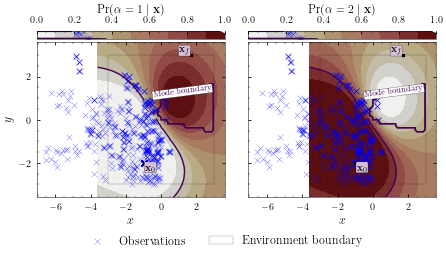

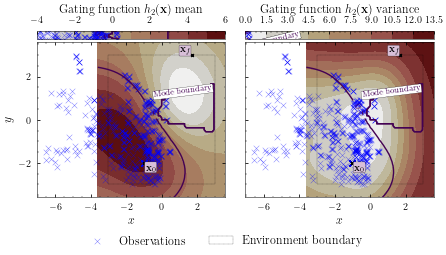

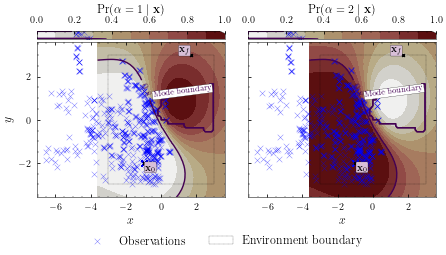

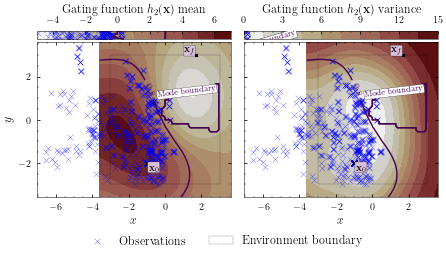

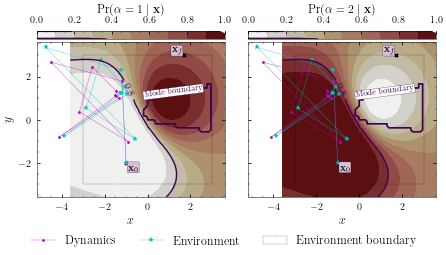

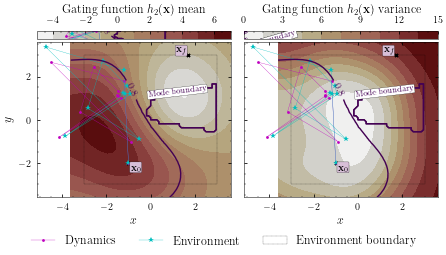

Epoch 1/10000
1/1 [==============================] - 1s 649ms/step - loss: -446.5333 - val_loss: -82.4635
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_14_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -338.5272

2022-04-08 15:29:51.286348: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 15:29:51.286364: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -338.5272 - val_loss: -124.1841
Epoch 3/10000
1/1 [==============================] - 0s 36ms/step - loss: -538.9920 - val_loss: -173.3549
Epoch 4/10000
1/1 [==============================] - 0s 38ms/step - loss: -517.4022 - val_loss: -230.6161
Epoch 5/10000
1/1 [==============================] - 0s 36ms/step - loss: -508.1203 - val_loss: -151.1471


2022-04-08 15:29:53.160382: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 15:29:53.171240: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 15:29:53.178463: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_29_53

2022-04-08 15:29:53.184531: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_29_53/dr-robots-mbp.local.trace.json.gz
2022-04-08 15:29:53.206214: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_29_53

2022-04-08 15:29:53.206511: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

Epoch 6/10000
1/1 [==============================] - 0s 36ms/step - loss: -446.8856 - val_loss: -222.6623
Epoch 7/10000
1/1 [==============================] - 0s 35ms/step - loss: -445.4301 - val_loss: -105.9314
Epoch 8/10000
1/1 [==============================] - 0s 36ms/step - loss: -512.4061 - val_loss: -177.9457
Epoch 9/10000
1/1 [==============================] - 0s 35ms/step - loss: -502.7580 - val_loss: -154.9376
Epoch 10/10000
1/1 [==============================] - 0s 37ms/step - loss: -367.3184 - val_loss: -97.8234
Epoch 11/10000
1/1 [==============================] - 0s 35ms/step - loss: -454.8475 - val_loss: -103.8658
Epoch 12/10000
1/1 [==============================] - 0s 36ms/step - loss: -435.4138 - val_loss: -166.9063
Epoch 13/10000
1/1 [==============================] - 0s 35ms/step - loss: -464.1071 - val_loss: -209.7289
Epoch 14/10000
1/1 [==============================] - 0s 37ms/step - loss: -459.1476 - val_loss: -139.5258
Epoch 15/10000
1/1 [======================

1/1 [==============================] - 0s 45ms/step - loss: -522.6887 - val_loss: -219.3272
Epoch 83/10000
1/1 [==============================] - 0s 44ms/step - loss: -527.5976 - val_loss: -242.6520
Epoch 84/10000
1/1 [==============================] - 0s 42ms/step - loss: -524.1485 - val_loss: -204.9784
Epoch 85/10000
1/1 [==============================] - 0s 43ms/step - loss: -522.6043 - val_loss: -232.2130
Epoch 86/10000
1/1 [==============================] - 0s 42ms/step - loss: -526.5073 - val_loss: -202.1438
Epoch 87/10000
1/1 [==============================] - 0s 44ms/step - loss: -516.5120 - val_loss: -241.0318
Epoch 88/10000
1/1 [==============================] - 0s 44ms/step - loss: -486.3978 - val_loss: -207.9954
Epoch 89/10000
1/1 [==============================] - 0s 46ms/step - loss: -549.3363 - val_loss: -245.7455
Epoch 90/10000
1/1 [==============================] - 0s 44ms/step - loss: -342.8287 - val_loss: -124.1340
Epoch 91/10000
1/1 [==============================] 

1/1 [==============================] - 0s 44ms/step - loss: -468.8153 - val_loss: -295.9073
Epoch 159/10000
1/1 [==============================] - 0s 42ms/step - loss: -598.5297 - val_loss: -278.5317
Epoch 160/10000
1/1 [==============================] - 0s 43ms/step - loss: -598.6062 - val_loss: -298.6652
Epoch 161/10000
1/1 [==============================] - 0s 44ms/step - loss: -526.4594 - val_loss: -186.2547
Epoch 162/10000
1/1 [==============================] - 0s 44ms/step - loss: -572.9855 - val_loss: -273.7310
Epoch 163/10000
1/1 [==============================] - 0s 43ms/step - loss: -551.6414 - val_loss: -246.5743
Epoch 164/10000
1/1 [==============================] - 0s 43ms/step - loss: -466.2299 - val_loss: -249.2631
Epoch 165/10000
1/1 [==============================] - 0s 44ms/step - loss: -426.4204 - val_loss: -136.0512
Epoch 166/10000
1/1 [==============================] - 0s 42ms/step - loss: -595.0526 - val_loss: -271.8866
Epoch 167/10000
1/1 [=======================

1/1 [==============================] - 0s 42ms/step - loss: -427.3645 - val_loss: -168.5581
Epoch 235/10000
1/1 [==============================] - 0s 44ms/step - loss: -414.9752 - val_loss: -126.8506
Epoch 236/10000
1/1 [==============================] - 0s 44ms/step - loss: 248.9611 - val_loss: 361.5906
Epoch 237/10000
1/1 [==============================] - 0s 42ms/step - loss: -379.4785 - val_loss: -196.1877
Epoch 238/10000
1/1 [==============================] - 0s 43ms/step - loss: -432.8261 - val_loss: -188.1993
Epoch 239/10000
1/1 [==============================] - 0s 44ms/step - loss: -108.1027 - val_loss: 172.5487
Epoch 240/10000
1/1 [==============================] - 0s 46ms/step - loss: -130.1211 - val_loss: -114.2349
Epoch 241/10000
1/1 [==============================] - 0s 44ms/step - loss: -294.3298 - val_loss: -133.1692
Epoch 242/10000
1/1 [==============================] - 0s 43ms/step - loss: -256.8854 - val_loss: -107.8121
Epoch 243/10000
1/1 [==========================

1/1 [==============================] - 0s 42ms/step - loss: -546.4912 - val_loss: -229.4317
Epoch 311/10000
1/1 [==============================] - 0s 42ms/step - loss: -495.7983 - val_loss: -215.7428
Epoch 312/10000
1/1 [==============================] - 0s 42ms/step - loss: -546.4083 - val_loss: -239.0093
Epoch 313/10000
1/1 [==============================] - 0s 43ms/step - loss: -537.2753 - val_loss: -226.5908
Epoch 314/10000
1/1 [==============================] - 0s 42ms/step - loss: -529.6542 - val_loss: -289.9469
Epoch 315/10000
1/1 [==============================] - 0s 42ms/step - loss: -534.0400 - val_loss: -244.0966
Epoch 316/10000
1/1 [==============================] - 0s 43ms/step - loss: -514.7052 - val_loss: -198.6414
Epoch 317/10000
1/1 [==============================] - 0s 44ms/step - loss: -492.5863 - val_loss: -156.5059
Epoch 318/10000
1/1 [==============================] - 0s 43ms/step - loss: -560.5988 - val_loss: -261.9953
Epoch 319/10000
1/1 [=======================

1/1 [==============================] - 0s 75ms/step - loss: -490.4900 - val_loss: -144.1816
Epoch 387/10000
1/1 [==============================] - 0s 80ms/step - loss: -461.4244 - val_loss: -229.5352
Epoch 388/10000
1/1 [==============================] - 0s 71ms/step - loss: -538.2176 - val_loss: -282.7458
Epoch 389/10000
1/1 [==============================] - 0s 69ms/step - loss: -434.4349 - val_loss: -174.5880
Epoch 390/10000
1/1 [==============================] - 0s 74ms/step - loss: -211.8280 - val_loss: -152.5445
Epoch 391/10000
1/1 [==============================] - 0s 69ms/step - loss: -548.1459 - val_loss: -209.0327
Epoch 392/10000
1/1 [==============================] - 0s 71ms/step - loss: -473.2367 - val_loss: -215.1968
Epoch 393/10000
1/1 [==============================] - 0s 69ms/step - loss: -497.5704 - val_loss: -190.2095
Epoch 394/10000
1/1 [==============================] - 0s 83ms/step - loss: -540.3832 - val_loss: -238.8192
Epoch 395/10000
1/1 [=======================

1/1 [==============================] - 0s 60ms/step - loss: -514.1318 - val_loss: -292.2827
Epoch 463/10000
1/1 [==============================] - 0s 83ms/step - loss: -556.4234 - val_loss: -273.1762
Epoch 464/10000
1/1 [==============================] - 0s 65ms/step - loss: -568.0461 - val_loss: -258.8164
Epoch 465/10000
1/1 [==============================] - 0s 73ms/step - loss: -540.9214 - val_loss: -215.7291
Epoch 466/10000
1/1 [==============================] - 0s 74ms/step - loss: -568.1575 - val_loss: -281.3811
Epoch 467/10000
1/1 [==============================] - 0s 76ms/step - loss: -557.6726 - val_loss: -303.1549
Epoch 468/10000
1/1 [==============================] - 0s 63ms/step - loss: -545.0128 - val_loss: -251.3677
Epoch 469/10000
1/1 [==============================] - 0s 58ms/step - loss: -516.3463 - val_loss: -204.4121
Epoch 470/10000
1/1 [==============================] - 0s 64ms/step - loss: -528.3725 - val_loss: -282.1360
Epoch 471/10000
1/1 [=======================

1/1 [==============================] - 0s 67ms/step - loss: -584.4844 - val_loss: -230.2644
Epoch 539/10000
1/1 [==============================] - 0s 65ms/step - loss: -539.3609 - val_loss: -263.5852
Epoch 540/10000
1/1 [==============================] - 0s 95ms/step - loss: -560.6628 - val_loss: -268.4644
Epoch 541/10000
1/1 [==============================] - 0s 78ms/step - loss: -451.7578 - val_loss: -140.3174
Epoch 542/10000
1/1 [==============================] - 0s 68ms/step - loss: -250.0277 - val_loss: -115.3517
Epoch 543/10000
1/1 [==============================] - 0s 67ms/step - loss: -403.3127 - val_loss: -154.9282
Epoch 544/10000
1/1 [==============================] - 0s 68ms/step - loss: -507.1588 - val_loss: -231.1536
Epoch 545/10000
1/1 [==============================] - 0s 70ms/step - loss: -482.4634 - val_loss: -258.5679
Epoch 546/10000
1/1 [==============================] - 0s 65ms/step - loss: -583.6440 - val_loss: -270.5450
Epoch 547/10000
1/1 [=======================

1/1 [==============================] - 0s 76ms/step - loss: -513.9456 - val_loss: -143.6048
Epoch 615/10000
1/1 [==============================] - 0s 81ms/step - loss: -484.0147 - val_loss: -216.7035
Epoch 616/10000
1/1 [==============================] - 0s 75ms/step - loss: -414.0108 - val_loss: -208.0188
Epoch 617/10000
1/1 [==============================] - 0s 68ms/step - loss: -494.2525 - val_loss: -203.9655
Epoch 618/10000
1/1 [==============================] - 0s 72ms/step - loss: -195.3002 - val_loss: -147.3048
Epoch 619/10000
1/1 [==============================] - 0s 68ms/step - loss: -418.7716 - val_loss: -67.2485
Epoch 620/10000
1/1 [==============================] - 0s 67ms/step - loss: -548.3391 - val_loss: -239.7674
Epoch 621/10000
1/1 [==============================] - 0s 82ms/step - loss: -411.7091 - val_loss: -198.1462
Epoch 622/10000
1/1 [==============================] - 0s 67ms/step - loss: -526.3616 - val_loss: -245.0146
Epoch 623/10000
1/1 [========================

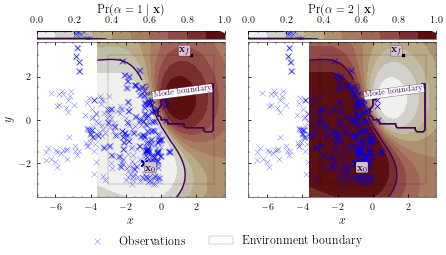

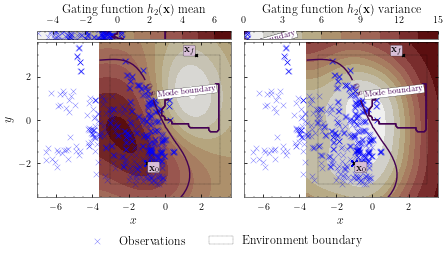

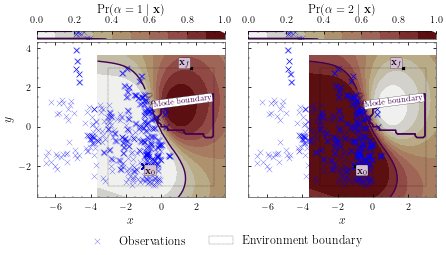

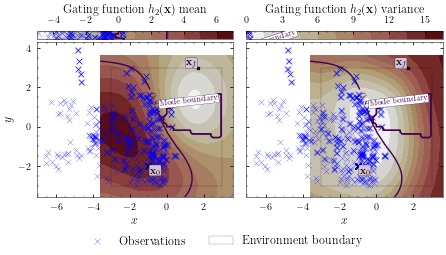

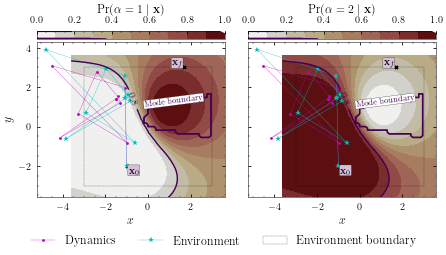

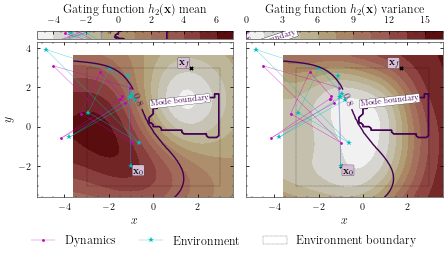

Epoch 1/10000
1/1 [==============================] - 1s 694ms/step - loss: -527.8840 - val_loss: -195.9563
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_15_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -542.1251

2022-04-08 15:33:11.991212: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 15:33:11.991226: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 3s 3s/step - loss: -542.1251 - val_loss: -178.5396
Epoch 3/10000
1/1 [==============================] - 0s 50ms/step - loss: -495.4780 - val_loss: -103.0626


2022-04-08 15:33:14.836661: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 15:33:14.857052: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 15:33:14.878393: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_33_14

2022-04-08 15:33:14.886201: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_33_14/dr-robots-mbp.local.trace.json.gz
2022-04-08 15:33:14.930777: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_33_14

2022-04-08 15:33:14.931094: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

Epoch 4/10000
1/1 [==============================] - 0s 52ms/step - loss: -547.6194 - val_loss: -189.8515
Epoch 5/10000
1/1 [==============================] - 0s 64ms/step - loss: -526.9160 - val_loss: -143.8170
Epoch 6/10000
1/1 [==============================] - 0s 52ms/step - loss: -475.7489 - val_loss: -228.9699
Epoch 7/10000
1/1 [==============================] - 0s 52ms/step - loss: -489.3247 - val_loss: -125.2348
Epoch 8/10000
1/1 [==============================] - 0s 53ms/step - loss: -485.7598 - val_loss: -95.4260
Epoch 9/10000
1/1 [==============================] - 0s 55ms/step - loss: -547.0117 - val_loss: -226.6346
Epoch 10/10000
1/1 [==============================] - 0s 58ms/step - loss: -518.4174 - val_loss: -124.6623
Epoch 11/10000
1/1 [==============================] - 0s 57ms/step - loss: -532.1653 - val_loss: -205.1853
Epoch 12/10000
1/1 [==============================] - 0s 58ms/step - loss: -523.4797 - val_loss: -175.6386
Epoch 13/10000
1/1 [========================

1/1 [==============================] - 0s 58ms/step - loss: 126.8919 - val_loss: 43.3857
Epoch 81/10000
1/1 [==============================] - 0s 58ms/step - loss: -562.1985 - val_loss: -245.5584
Epoch 82/10000
1/1 [==============================] - 0s 59ms/step - loss: -474.0807 - val_loss: -136.9812
Epoch 83/10000
1/1 [==============================] - 0s 58ms/step - loss: -433.9518 - val_loss: -217.8324
Epoch 84/10000
1/1 [==============================] - 0s 59ms/step - loss: -571.6944 - val_loss: -235.3263
Epoch 85/10000
1/1 [==============================] - 0s 60ms/step - loss: -464.4666 - val_loss: -220.9223
Epoch 86/10000
1/1 [==============================] - 0s 68ms/step - loss: -501.8849 - val_loss: -196.0846
Epoch 87/10000
1/1 [==============================] - 0s 74ms/step - loss: -519.4531 - val_loss: -233.5034
Epoch 88/10000
1/1 [==============================] - 0s 69ms/step - loss: -481.0125 - val_loss: -293.7228
Epoch 89/10000
1/1 [==============================] - 0

1/1 [==============================] - 0s 68ms/step - loss: -451.6397 - val_loss: -46.0785
Epoch 157/10000
1/1 [==============================] - 0s 69ms/step - loss: -499.1075 - val_loss: -146.7663
Epoch 158/10000
1/1 [==============================] - 0s 67ms/step - loss: -545.4486 - val_loss: -170.0527
Epoch 159/10000
1/1 [==============================] - 0s 57ms/step - loss: -523.4152 - val_loss: -192.1014
Epoch 160/10000
1/1 [==============================] - 0s 62ms/step - loss: -499.3795 - val_loss: -123.9029
Epoch 161/10000
1/1 [==============================] - 0s 63ms/step - loss: -536.5311 - val_loss: -220.0323
Epoch 162/10000
1/1 [==============================] - 0s 70ms/step - loss: -510.6551 - val_loss: -145.9038
Epoch 163/10000
1/1 [==============================] - 0s 68ms/step - loss: -555.0253 - val_loss: -216.2575
Epoch 164/10000
1/1 [==============================] - 0s 71ms/step - loss: -548.3793 - val_loss: -193.5882
Epoch 165/10000
1/1 [========================

1/1 [==============================] - 0s 61ms/step - loss: -410.8720 - val_loss: -229.0419
Epoch 233/10000
1/1 [==============================] - 0s 52ms/step - loss: -382.5238 - val_loss: -199.3841
Epoch 234/10000
1/1 [==============================] - 0s 59ms/step - loss: -496.8203 - val_loss: -200.0977
Epoch 235/10000
1/1 [==============================] - 0s 62ms/step - loss: -558.5664 - val_loss: -238.7382
Epoch 236/10000
1/1 [==============================] - 0s 61ms/step - loss: -559.6055 - val_loss: -241.2202
Epoch 237/10000
1/1 [==============================] - 0s 68ms/step - loss: -550.9915 - val_loss: -216.6419
Epoch 238/10000
1/1 [==============================] - 0s 62ms/step - loss: -448.6365 - val_loss: -191.2456
Epoch 239/10000
1/1 [==============================] - 0s 63ms/step - loss: -514.5546 - val_loss: -197.9955
Epoch 240/10000
1/1 [==============================] - 0s 63ms/step - loss: -544.7807 - val_loss: -270.2996
Epoch 241/10000
1/1 [=======================

1/1 [==============================] - 0s 64ms/step - loss: -586.0116 - val_loss: -301.5526
Epoch 309/10000
1/1 [==============================] - 0s 64ms/step - loss: -517.9084 - val_loss: -97.5092
Epoch 310/10000
1/1 [==============================] - 0s 68ms/step - loss: -533.0971 - val_loss: -271.5685
Epoch 311/10000
1/1 [==============================] - 0s 66ms/step - loss: -529.2747 - val_loss: -223.5211
Epoch 312/10000
1/1 [==============================] - 0s 68ms/step - loss: -564.8590 - val_loss: -255.3412
Epoch 313/10000
1/1 [==============================] - 0s 67ms/step - loss: -545.3272 - val_loss: -304.6853
Epoch 314/10000
1/1 [==============================] - 0s 67ms/step - loss: -588.1725 - val_loss: -299.1352
Epoch 315/10000
1/1 [==============================] - 0s 72ms/step - loss: -552.6292 - val_loss: -171.2848
Epoch 316/10000
1/1 [==============================] - 0s 71ms/step - loss: -444.3167 - val_loss: -169.4336
Epoch 317/10000
1/1 [========================

1/1 [==============================] - 0s 67ms/step - loss: -428.0164 - val_loss: -116.7965
Epoch 385/10000
1/1 [==============================] - 0s 67ms/step - loss: -365.9160 - val_loss: -6.6713
Epoch 386/10000
1/1 [==============================] - 0s 67ms/step - loss: -444.6772 - val_loss: -199.0241
Epoch 387/10000
1/1 [==============================] - 0s 66ms/step - loss: 25.9751 - val_loss: 425.6302
Epoch 388/10000
1/1 [==============================] - 0s 65ms/step - loss: -469.4398 - val_loss: -109.2785
Epoch 389/10000
1/1 [==============================] - 0s 71ms/step - loss: -444.9184 - val_loss: -156.9059
Epoch 390/10000
1/1 [==============================] - 0s 68ms/step - loss: -473.6234 - val_loss: -111.8318
Epoch 391/10000
1/1 [==============================] - 0s 66ms/step - loss: -446.9499 - val_loss: -166.2220
Epoch 392/10000
1/1 [==============================] - 0s 77ms/step - loss: -442.7711 - val_loss: -98.6721
Epoch 393/10000
1/1 [=============================

1/1 [==============================] - 0s 68ms/step - loss: -526.6955 - val_loss: -175.6789
Epoch 461/10000
1/1 [==============================] - 0s 64ms/step - loss: -550.8664 - val_loss: -267.3363
Epoch 462/10000
1/1 [==============================] - 0s 61ms/step - loss: -522.5695 - val_loss: -237.6633
Epoch 463/10000
1/1 [==============================] - 0s 60ms/step - loss: -524.5306 - val_loss: -228.5109
Epoch 464/10000
1/1 [==============================] - 0s 57ms/step - loss: -539.7369 - val_loss: -189.7721
Epoch 465/10000
1/1 [==============================] - 0s 60ms/step - loss: -561.3854 - val_loss: -233.9855
Epoch 466/10000
1/1 [==============================] - 0s 65ms/step - loss: -544.1296 - val_loss: -239.5289
Epoch 467/10000
1/1 [==============================] - 0s 67ms/step - loss: -525.5052 - val_loss: -217.1471
Epoch 468/10000
1/1 [==============================] - 0s 65ms/step - loss: -553.8374 - val_loss: -213.5760
Epoch 469/10000
1/1 [=======================

Epoch 536/10000
1/1 [==============================] - 0s 60ms/step - loss: -601.8389 - val_loss: -285.5953
Epoch 537/10000
1/1 [==============================] - 0s 69ms/step - loss: -547.2783 - val_loss: -255.1480
Epoch 538/10000
1/1 [==============================] - 0s 70ms/step - loss: -596.0260 - val_loss: -272.0558
Epoch 539/10000
1/1 [==============================] - 0s 99ms/step - loss: -507.1076 - val_loss: -211.9410
Epoch 540/10000
1/1 [==============================] - 0s 73ms/step - loss: -516.5093 - val_loss: -173.9377
Epoch 541/10000
1/1 [==============================] - 0s 72ms/step - loss: -578.2776 - val_loss: -310.6522
Epoch 542/10000
1/1 [==============================] - 0s 80ms/step - loss: -595.3705 - val_loss: -192.5626
Epoch 543/10000
1/1 [==============================] - 0s 88ms/step - loss: -364.2677 - val_loss: -112.0093
Epoch 544/10000
1/1 [==============================] - 0s 77ms/step - loss: -259.0973 - val_loss: -40.8517
Epoch 545/10000
1/1 [========

Epoch 612/10000
1/1 [==============================] - 0s 65ms/step - loss: -524.7661 - val_loss: -203.0173
Epoch 613/10000
1/1 [==============================] - 0s 64ms/step - loss: -514.8710 - val_loss: -257.2372
Epoch 614/10000
1/1 [==============================] - 0s 68ms/step - loss: -536.6443 - val_loss: -165.1281
Epoch 615/10000
1/1 [==============================] - 0s 66ms/step - loss: -537.8434 - val_loss: -271.9993
Epoch 616/10000
1/1 [==============================] - 0s 64ms/step - loss: -520.7785 - val_loss: -197.8356
Epoch 617/10000
1/1 [==============================] - 0s 66ms/step - loss: -565.2937 - val_loss: -234.3908
Epoch 618/10000
1/1 [==============================] - 0s 63ms/step - loss: -423.8101 - val_loss: -214.9974
Epoch 619/10000
1/1 [==============================] - 0s 70ms/step - loss: -513.6419 - val_loss: -245.4765
Epoch 620/10000
1/1 [==============================] - 0s 74ms/step - loss: -554.3820 - val_loss: -281.0827
Epoch 621/10000
1/1 [=======

Epoch 688/10000
1/1 [==============================] - 0s 67ms/step - loss: -577.3153 - val_loss: -238.7848
Epoch 689/10000
1/1 [==============================] - 0s 73ms/step - loss: -585.1816 - val_loss: -276.0875
Epoch 690/10000
1/1 [==============================] - 0s 74ms/step - loss: -555.7188 - val_loss: -267.1681
Epoch 691/10000
1/1 [==============================] - 0s 73ms/step - loss: -480.8062 - val_loss: -214.0391
Epoch 692/10000
1/1 [==============================] - 0s 69ms/step - loss: -509.2002 - val_loss: -268.6231
Epoch 693/10000
1/1 [==============================] - 0s 73ms/step - loss: -501.0949 - val_loss: -299.4743
Epoch 694/10000
1/1 [==============================] - 0s 71ms/step - loss: -570.3157 - val_loss: -197.4988
Epoch 695/10000
1/1 [==============================] - 0s 73ms/step - loss: -576.9781 - val_loss: -263.1363
Epoch 696/10000
1/1 [==============================] - 0s 73ms/step - loss: -563.2402 - val_loss: -268.6986
Epoch 697/10000
1/1 [=======

Epoch 764/10000
1/1 [==============================] - 0s 99ms/step - loss: -382.9986 - val_loss: -262.6123
Epoch 765/10000
1/1 [==============================] - 0s 99ms/step - loss: -447.1117 - val_loss: -247.3619
Epoch 766/10000
1/1 [==============================] - 0s 88ms/step - loss: -477.8499 - val_loss: -134.5341
Epoch 767/10000
1/1 [==============================] - 0s 91ms/step - loss: -400.3660 - val_loss: -111.8410
Epoch 768/10000
1/1 [==============================] - 0s 79ms/step - loss: -504.4867 - val_loss: -220.2781
Epoch 769/10000
1/1 [==============================] - 0s 88ms/step - loss: -496.3232 - val_loss: -196.0760
Epoch 770/10000
1/1 [==============================] - 0s 91ms/step - loss: -568.7399 - val_loss: -243.7150
Epoch 771/10000
1/1 [==============================] - 0s 80ms/step - loss: -484.3452 - val_loss: -284.4948
Epoch 772/10000
1/1 [==============================] - 0s 76ms/step - loss: -563.4287 - val_loss: -239.0904
Epoch 773/10000
1/1 [=======

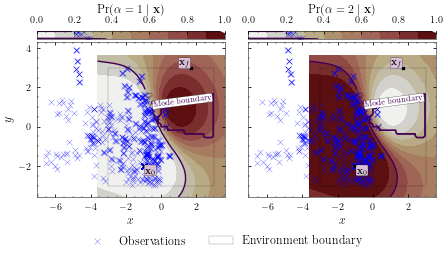

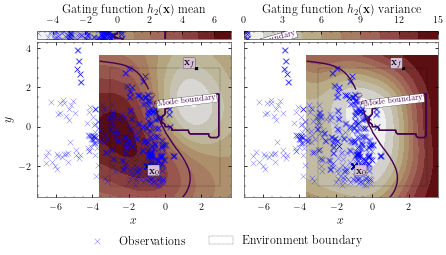

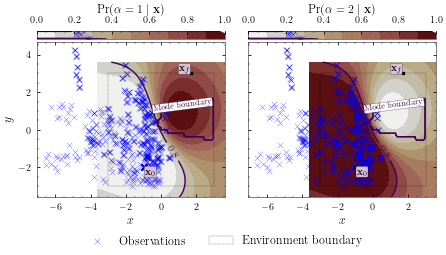

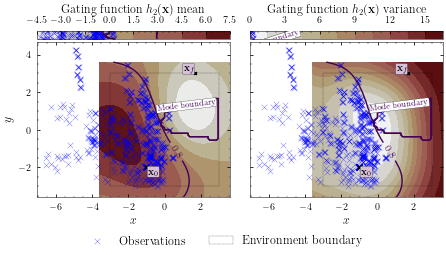

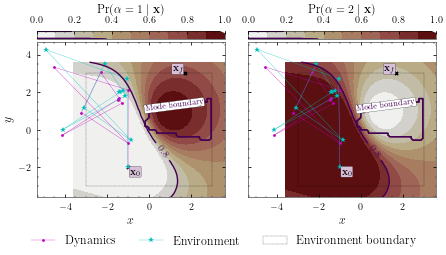

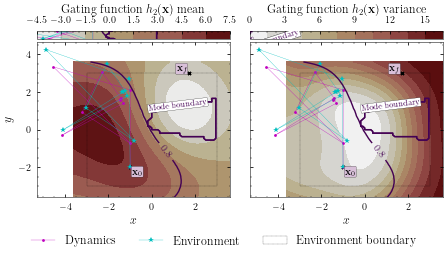

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: -328.1312 - val_loss: -32.7797
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_16_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -447.7821

2022-04-08 15:36:57.445067: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 15:36:57.445084: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -447.7821 - val_loss: -164.0440
Epoch 3/10000
1/1 [==============================] - 0s 47ms/step - loss: -458.6696 - val_loss: -9.7865
Epoch 4/10000
1/1 [==============================] - 0s 47ms/step - loss: -537.3650 - val_loss: -140.3995


2022-04-08 15:36:59.773324: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 15:36:59.786613: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 15:36:59.797107: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_36_59

2022-04-08 15:36:59.806328: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_36_59/dr-robots-mbp.local.trace.json.gz
2022-04-08 15:36:59.832570: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_36_59

2022-04-08 15:36:59.832925: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

Epoch 5/10000
1/1 [==============================] - 0s 48ms/step - loss: -465.5849 - val_loss: -156.2334
Epoch 6/10000
1/1 [==============================] - 0s 48ms/step - loss: -520.5787 - val_loss: -206.6678
Epoch 7/10000
1/1 [==============================] - 0s 48ms/step - loss: -100.0974 - val_loss: -148.7626
Epoch 8/10000
1/1 [==============================] - 0s 46ms/step - loss: -393.8525 - val_loss: -167.3879
Epoch 9/10000
1/1 [==============================] - 0s 47ms/step - loss: -414.4133 - val_loss: -54.9434
Epoch 10/10000
1/1 [==============================] - 0s 92ms/step - loss: -145.2130 - val_loss: 67.6606
Epoch 11/10000
1/1 [==============================] - 0s 54ms/step - loss: -474.7966 - val_loss: -75.4878
Epoch 12/10000
1/1 [==============================] - 0s 48ms/step - loss: -451.2362 - val_loss: -143.4787
Epoch 13/10000
1/1 [==============================] - 0s 56ms/step - loss: -434.4328 - val_loss: -51.4448
Epoch 14/10000
1/1 [===========================

Epoch 82/10000
1/1 [==============================] - 0s 43ms/step - loss: -513.5303 - val_loss: -65.4528
Epoch 83/10000
1/1 [==============================] - 0s 44ms/step - loss: -423.5831 - val_loss: 217.1348
Epoch 84/10000
1/1 [==============================] - 0s 46ms/step - loss: -264.7852 - val_loss: 440.0326
Epoch 85/10000
1/1 [==============================] - 0s 43ms/step - loss: -551.6102 - val_loss: -161.7297
Epoch 86/10000
1/1 [==============================] - 0s 43ms/step - loss: -520.0064 - val_loss: 18.5180
Epoch 87/10000
1/1 [==============================] - 0s 43ms/step - loss: -544.0290 - val_loss: -115.5120
Epoch 88/10000
1/1 [==============================] - 0s 44ms/step - loss: -471.5722 - val_loss: -88.3351
Epoch 89/10000
1/1 [==============================] - 0s 43ms/step - loss: -504.2623 - val_loss: -20.3960
Epoch 90/10000
1/1 [==============================] - 0s 45ms/step - loss: -515.3522 - val_loss: 36.2028
Epoch 91/10000
1/1 [==========================

1/1 [==============================] - 0s 42ms/step - loss: -511.1208 - val_loss: -56.6970
Epoch 159/10000
1/1 [==============================] - 0s 43ms/step - loss: -530.2292 - val_loss: -153.8218
Epoch 160/10000
1/1 [==============================] - 0s 43ms/step - loss: -505.2353 - val_loss: -179.1907
Epoch 161/10000
1/1 [==============================] - 0s 45ms/step - loss: -497.5021 - val_loss: -69.7194
Epoch 162/10000
1/1 [==============================] - 0s 44ms/step - loss: -380.0327 - val_loss: -62.2589
Epoch 163/10000
1/1 [==============================] - 0s 44ms/step - loss: -445.0084 - val_loss: -240.0997
Epoch 164/10000
1/1 [==============================] - 0s 44ms/step - loss: -470.0467 - val_loss: -190.7643
Epoch 165/10000
1/1 [==============================] - 0s 44ms/step - loss: -539.3806 - val_loss: -264.2811
Epoch 166/10000
1/1 [==============================] - 0s 44ms/step - loss: -530.0563 - val_loss: -117.5146
Epoch 167/10000
1/1 [==========================

1/1 [==============================] - 0s 43ms/step - loss: -500.8661 - val_loss: -176.2732
Epoch 235/10000
1/1 [==============================] - 0s 43ms/step - loss: -534.9074 - val_loss: -241.7953
Epoch 236/10000
1/1 [==============================] - 0s 43ms/step - loss: -458.8107 - val_loss: -185.2252
Epoch 237/10000
1/1 [==============================] - 0s 45ms/step - loss: -435.8975 - val_loss: -110.7337
Epoch 238/10000
1/1 [==============================] - 0s 44ms/step - loss: -538.2000 - val_loss: -292.2256
Epoch 239/10000
1/1 [==============================] - 0s 44ms/step - loss: -506.9562 - val_loss: -239.6954
Epoch 240/10000
1/1 [==============================] - 0s 45ms/step - loss: -465.4919 - val_loss: -202.1656
Epoch 241/10000
1/1 [==============================] - 0s 43ms/step - loss: -514.3335 - val_loss: -212.9455
Epoch 242/10000
1/1 [==============================] - 0s 43ms/step - loss: -385.8602 - val_loss: -160.4361
Epoch 243/10000
1/1 [=======================

1/1 [==============================] - 0s 50ms/step - loss: -458.4905 - val_loss: -186.6946
Epoch 311/10000
1/1 [==============================] - 0s 47ms/step - loss: -402.4648 - val_loss: -224.1844
Epoch 312/10000
1/1 [==============================] - 0s 46ms/step - loss: -513.5972 - val_loss: -128.4892
Epoch 313/10000
1/1 [==============================] - 0s 50ms/step - loss: -482.2832 - val_loss: -219.5436
Epoch 314/10000
1/1 [==============================] - 0s 49ms/step - loss: -342.8608 - val_loss: -134.5166
Epoch 315/10000
1/1 [==============================] - 0s 48ms/step - loss: 31.6854 - val_loss: -79.7581
Epoch 316/10000
1/1 [==============================] - 0s 47ms/step - loss: -344.9582 - val_loss: 31.2350
Epoch 317/10000
1/1 [==============================] - 0s 46ms/step - loss: -482.2480 - val_loss: -160.9027
Epoch 318/10000
1/1 [==============================] - 0s 48ms/step - loss: -426.4084 - val_loss: -225.0376
Epoch 319/10000
1/1 [============================

1/1 [==============================] - 0s 46ms/step - loss: -553.6267 - val_loss: -125.8951
Epoch 387/10000
1/1 [==============================] - 0s 44ms/step - loss: -528.4650 - val_loss: -237.6143
Epoch 388/10000
1/1 [==============================] - 0s 45ms/step - loss: -532.3675 - val_loss: -171.1687
Epoch 389/10000
1/1 [==============================] - 0s 46ms/step - loss: -534.3839 - val_loss: -163.3474
Epoch 390/10000
1/1 [==============================] - 0s 46ms/step - loss: -503.7890 - val_loss: -146.4451
Epoch 391/10000
1/1 [==============================] - 0s 45ms/step - loss: -551.4714 - val_loss: -237.8740
Epoch 392/10000
1/1 [==============================] - 0s 45ms/step - loss: -519.3999 - val_loss: -183.2895
Epoch 393/10000
1/1 [==============================] - 0s 44ms/step - loss: -525.8718 - val_loss: -219.8527
Epoch 394/10000
1/1 [==============================] - 0s 45ms/step - loss: -526.4509 - val_loss: -220.9427
Epoch 395/10000
1/1 [=======================

1/1 [==============================] - 0s 45ms/step - loss: -417.9590 - val_loss: -49.2629
Epoch 463/10000
1/1 [==============================] - 0s 47ms/step - loss: -547.6298 - val_loss: -205.2266
Epoch 464/10000
1/1 [==============================] - 0s 45ms/step - loss: -511.1033 - val_loss: -181.8034
Epoch 465/10000
1/1 [==============================] - 0s 45ms/step - loss: -481.0492 - val_loss: -174.5241
Epoch 466/10000
1/1 [==============================] - 0s 44ms/step - loss: -528.5322 - val_loss: -111.5641
Epoch 467/10000
1/1 [==============================] - 0s 45ms/step - loss: -549.3583 - val_loss: -247.0886
Epoch 468/10000
1/1 [==============================] - 0s 45ms/step - loss: -513.8308 - val_loss: -218.9769
Epoch 469/10000
1/1 [==============================] - 0s 44ms/step - loss: -536.1482 - val_loss: -242.5662
Epoch 470/10000
1/1 [==============================] - 0s 45ms/step - loss: -543.0544 - val_loss: -247.4713
Epoch 471/10000
1/1 [========================

1/1 [==============================] - 0s 45ms/step - loss: -534.7732 - val_loss: -234.1214
Epoch 539/10000
1/1 [==============================] - 0s 44ms/step - loss: -497.0963 - val_loss: -138.7944
Epoch 540/10000
1/1 [==============================] - 0s 44ms/step - loss: -471.5206 - val_loss: -210.6727
Epoch 541/10000
1/1 [==============================] - 0s 44ms/step - loss: -491.3058 - val_loss: -69.2029
Epoch 542/10000
1/1 [==============================] - 0s 44ms/step - loss: -517.3387 - val_loss: -208.8110
Epoch 543/10000
1/1 [==============================] - 0s 45ms/step - loss: -393.7745 - val_loss: -123.5011
Epoch 544/10000
1/1 [==============================] - 0s 45ms/step - loss: -527.6936 - val_loss: -286.5243
Epoch 545/10000
1/1 [==============================] - 0s 44ms/step - loss: -541.8149 - val_loss: -222.8428
Epoch 546/10000
1/1 [==============================] - 0s 44ms/step - loss: -553.0107 - val_loss: -262.8701
Epoch 547/10000
1/1 [========================

1/1 [==============================] - 0s 56ms/step - loss: -487.0879 - val_loss: -114.6812
Epoch 615/10000
1/1 [==============================] - 0s 51ms/step - loss: -479.4926 - val_loss: -201.5106
Epoch 616/10000
1/1 [==============================] - 0s 49ms/step - loss: -392.0503 - val_loss: -144.2241
Epoch 617/10000
1/1 [==============================] - 0s 52ms/step - loss: -519.7415 - val_loss: -233.8382
Epoch 618/10000
1/1 [==============================] - 0s 48ms/step - loss: -491.8864 - val_loss: -256.3235
Epoch 619/10000
1/1 [==============================] - 0s 62ms/step - loss: -551.6971 - val_loss: -191.1135
Epoch 620/10000
1/1 [==============================] - 0s 52ms/step - loss: -398.0474 - val_loss: -194.6479
Epoch 621/10000
1/1 [==============================] - 0s 53ms/step - loss: -532.0609 - val_loss: -210.6377
Epoch 622/10000
1/1 [==============================] - 0s 51ms/step - loss: -481.9041 - val_loss: -207.8847
Epoch 623/10000
1/1 [=======================

1/1 [==============================] - 0s 48ms/step - loss: -514.7273 - val_loss: -221.9552
Epoch 691/10000
1/1 [==============================] - 0s 48ms/step - loss: -545.3905 - val_loss: -227.6387
Epoch 692/10000
1/1 [==============================] - 0s 48ms/step - loss: -479.7345 - val_loss: -242.8401
Epoch 693/10000
1/1 [==============================] - 0s 46ms/step - loss: -542.8792 - val_loss: -230.5377
Epoch 694/10000
1/1 [==============================] - 0s 47ms/step - loss: -552.1745 - val_loss: -258.2315
Epoch 695/10000
1/1 [==============================] - 0s 48ms/step - loss: -453.8567 - val_loss: -206.0083
Epoch 696/10000
1/1 [==============================] - 0s 46ms/step - loss: -524.0523 - val_loss: -161.8966
Epoch 697/10000
1/1 [==============================] - 0s 48ms/step - loss: -511.6390 - val_loss: -194.1911
Epoch 698/10000
1/1 [==============================] - 0s 49ms/step - loss: -453.7186 - val_loss: -86.5824
Epoch 699/10000
1/1 [========================

1/1 [==============================] - 0s 41ms/step - loss: -553.6682 - val_loss: -201.4440
Epoch 767/10000
1/1 [==============================] - 0s 45ms/step - loss: -548.0682 - val_loss: -191.7482
Epoch 768/10000
1/1 [==============================] - 0s 45ms/step - loss: -506.3889 - val_loss: -244.1644
Epoch 769/10000
1/1 [==============================] - 0s 42ms/step - loss: -482.2259 - val_loss: -166.9017
Epoch 770/10000
1/1 [==============================] - 0s 44ms/step - loss: -387.4738 - val_loss: -203.8008
Epoch 771/10000
1/1 [==============================] - 0s 43ms/step - loss: -445.2230 - val_loss: -255.1290
Epoch 772/10000
1/1 [==============================] - 0s 43ms/step - loss: -569.5387 - val_loss: -227.0221
Epoch 773/10000
1/1 [==============================] - 0s 43ms/step - loss: -529.7079 - val_loss: -239.6576
Epoch 774/10000
1/1 [==============================] - 0s 44ms/step - loss: -383.4123 - val_loss: -66.3807
Epoch 775/10000
1/1 [========================

1/1 [==============================] - 0s 43ms/step - loss: -468.4436 - val_loss: -170.2954
Epoch 843/10000
1/1 [==============================] - 0s 44ms/step - loss: -537.4643 - val_loss: -243.5534
Epoch 844/10000
1/1 [==============================] - 0s 45ms/step - loss: -531.4553 - val_loss: -217.4771
Epoch 845/10000
1/1 [==============================] - 0s 44ms/step - loss: -518.5921 - val_loss: -186.2497
Epoch 846/10000
1/1 [==============================] - 0s 43ms/step - loss: -481.0608 - val_loss: -241.6434
Epoch 847/10000
1/1 [==============================] - 0s 43ms/step - loss: -529.7657 - val_loss: -149.6316
Epoch 848/10000
1/1 [==============================] - 0s 44ms/step - loss: -494.0504 - val_loss: -215.9283
Epoch 849/10000
1/1 [==============================] - 0s 44ms/step - loss: -544.1881 - val_loss: -232.3111
Epoch 850/10000
1/1 [==============================] - 0s 45ms/step - loss: -506.4641 - val_loss: -213.3364
Epoch 851/10000
1/1 [=======================

Epoch 918/10000
1/1 [==============================] - 0s 46ms/step - loss: -607.5729 - val_loss: -222.1657
Epoch 919/10000
1/1 [==============================] - 0s 44ms/step - loss: -585.7065 - val_loss: -142.7223
Epoch 920/10000
1/1 [==============================] - 0s 44ms/step - loss: -540.7483 - val_loss: -206.8274
Epoch 921/10000
1/1 [==============================] - 0s 47ms/step - loss: -575.1462 - val_loss: -276.9671
Epoch 922/10000
1/1 [==============================] - 0s 46ms/step - loss: -588.7716 - val_loss: -227.0833
Epoch 923/10000
1/1 [==============================] - 0s 45ms/step - loss: -589.5123 - val_loss: -263.3855
Epoch 924/10000
1/1 [==============================] - 0s 47ms/step - loss: -560.3347 - val_loss: -210.6968
Epoch 925/10000
1/1 [==============================] - 0s 46ms/step - loss: -509.9418 - val_loss: -215.4488
Epoch 926/10000
1/1 [==============================] - 0s 45ms/step - loss: -545.3768 - val_loss: -230.1551
Epoch 927/10000
1/1 [=======

Epoch 994/10000
1/1 [==============================] - 0s 45ms/step - loss: -384.6988 - val_loss: 11.9522
Epoch 995/10000
1/1 [==============================] - 0s 44ms/step - loss: -541.5397 - val_loss: -192.2625
Epoch 996/10000
1/1 [==============================] - 0s 46ms/step - loss: -262.5108 - val_loss: -193.8686
Epoch 997/10000
1/1 [==============================] - 0s 45ms/step - loss: -480.1753 - val_loss: -175.5588
Epoch 998/10000
1/1 [==============================] - 0s 44ms/step - loss: -409.4270 - val_loss: 137.6522
Epoch 999/10000
1/1 [==============================] - 0s 57ms/step - loss: -521.5618 - val_loss: -236.8227
Epoch 1000/10000
1/1 [==============================] - 0s 45ms/step - loss: -549.3750 - val_loss: -215.9373
Epoch 1001/10000
1/1 [==============================] - 0s 46ms/step - loss: -442.5229 - val_loss: -137.0887
Epoch 1002/10000
1/1 [==============================] - 0s 45ms/step - loss: -467.7846 - val_loss: -187.9877
Epoch 1003/10000
1/1 [======

1/1 [==============================] - 0s 52ms/step - loss: -557.5432 - val_loss: -183.1291
Epoch 1070/10000
1/1 [==============================] - 0s 52ms/step - loss: -531.0140 - val_loss: -111.8782
Epoch 1071/10000
1/1 [==============================] - 0s 52ms/step - loss: -581.9755 - val_loss: -274.3932
Epoch 1072/10000
1/1 [==============================] - 0s 52ms/step - loss: -463.1269 - val_loss: -166.7035
Epoch 1073/10000
1/1 [==============================] - 0s 51ms/step - loss: -589.7509 - val_loss: -258.6836
Epoch 1074/10000
1/1 [==============================] - 0s 55ms/step - loss: -483.6840 - val_loss: -284.7756
Epoch 1075/10000
1/1 [==============================] - 0s 60ms/step - loss: -544.0902 - val_loss: -245.0651
Epoch 1076/10000
1/1 [==============================] - 0s 53ms/step - loss: -383.6676 - val_loss: -221.0244
Epoch 1077/10000
1/1 [==============================] - 0s 54ms/step - loss: -527.6402 - val_loss: -224.4587
Epoch 1078/10000
1/1 [==============

1/1 [==============================] - 0s 49ms/step - loss: -447.7578 - val_loss: -159.3112
Epoch 1145/10000
1/1 [==============================] - 0s 49ms/step - loss: -538.9934 - val_loss: -165.0559
Epoch 1146/10000
1/1 [==============================] - 0s 50ms/step - loss: -539.2809 - val_loss: -243.3430
Epoch 1147/10000
1/1 [==============================] - 0s 49ms/step - loss: -545.6025 - val_loss: -123.4994
Epoch 1148/10000
1/1 [==============================] - 0s 47ms/step - loss: -509.5661 - val_loss: -50.1474
Epoch 1149/10000
1/1 [==============================] - 0s 54ms/step - loss: -508.2128 - val_loss: -158.0821
Epoch 1150/10000
1/1 [==============================] - 0s 48ms/step - loss: -518.1700 - val_loss: -220.8764
Epoch 1151/10000
1/1 [==============================] - 0s 50ms/step - loss: -503.0456 - val_loss: -146.2317
Epoch 1152/10000
1/1 [==============================] - 0s 48ms/step - loss: -542.3324 - val_loss: -251.2778
Epoch 1153/10000
1/1 [===============

1/1 [==============================] - 0s 48ms/step - loss: -561.4856 - val_loss: -323.9463
Epoch 1220/10000
1/1 [==============================] - 0s 49ms/step - loss: -621.5778 - val_loss: -167.0086
Epoch 1221/10000
1/1 [==============================] - 0s 48ms/step - loss: -555.6096 - val_loss: -72.9978
Epoch 1222/10000
1/1 [==============================] - 0s 49ms/step - loss: -586.7671 - val_loss: -216.4349
Epoch 1223/10000
1/1 [==============================] - 0s 48ms/step - loss: -452.4452 - val_loss: -127.0412
Epoch 1224/10000
1/1 [==============================] - 0s 51ms/step - loss: -622.2781 - val_loss: -268.7964
Epoch 1225/10000
1/1 [==============================] - 0s 52ms/step - loss: -428.6538 - val_loss: -251.1317
Epoch 1226/10000
1/1 [==============================] - 0s 51ms/step - loss: -568.0065 - val_loss: -215.7114
Epoch 1227/10000
1/1 [==============================] - 0s 50ms/step - loss: -388.4275 - val_loss: -241.0008
Epoch 1228/10000
1/1 [===============

Epoch 1295/10000
1/1 [==============================] - 0s 52ms/step - loss: -432.0999 - val_loss: -225.6892
Epoch 1296/10000
1/1 [==============================] - 0s 52ms/step - loss: -381.5034 - val_loss: -234.3735
Epoch 1297/10000
1/1 [==============================] - 0s 49ms/step - loss: -443.7407 - val_loss: -152.9675
Epoch 1298/10000
1/1 [==============================] - 0s 51ms/step - loss: -482.3084 - val_loss: -213.0260
Epoch 1299/10000
1/1 [==============================] - 0s 50ms/step - loss: -456.5195 - val_loss: -106.3177
Epoch 1300/10000
1/1 [==============================] - 0s 49ms/step - loss: -473.0131 - val_loss: -149.0762
Epoch 1301/10000
1/1 [==============================] - 0s 54ms/step - loss: -484.5638 - val_loss: -145.1274
Epoch 1302/10000
1/1 [==============================] - 0s 51ms/step - loss: -469.8921 - val_loss: -106.6381
Epoch 1303/10000
1/1 [==============================] - 0s 50ms/step - loss: -474.5092 - val_loss: -143.1610
Epoch 1304/10000
1/

1/1 [==============================] - 0s 49ms/step - loss: -575.5793 - val_loss: -280.9986
Epoch 1371/10000
1/1 [==============================] - 0s 50ms/step - loss: -596.0188 - val_loss: -243.6309
Epoch 1372/10000
1/1 [==============================] - 0s 49ms/step - loss: -562.1867 - val_loss: -249.6296
Epoch 1373/10000
1/1 [==============================] - 0s 49ms/step - loss: -541.1098 - val_loss: -185.6475
Epoch 1374/10000
1/1 [==============================] - 0s 49ms/step - loss: -573.7804 - val_loss: -270.9711
Epoch 1375/10000
1/1 [==============================] - 0s 48ms/step - loss: -532.3891 - val_loss: -267.0462
Epoch 1376/10000
1/1 [==============================] - 0s 49ms/step - loss: -594.0507 - val_loss: -253.6394
Epoch 1377/10000
1/1 [==============================] - 0s 49ms/step - loss: -574.6863 - val_loss: -232.9979
Epoch 1378/10000
1/1 [==============================] - 0s 49ms/step - loss: -586.2355 - val_loss: -314.1570
Epoch 1379/10000
1/1 [==============

1/1 [==============================] - 0s 48ms/step - loss: -509.8343 - val_loss: -235.3990
Epoch 1446/10000
1/1 [==============================] - 0s 47ms/step - loss: -290.9655 - val_loss: 34.1055
Epoch 1447/10000
1/1 [==============================] - 0s 47ms/step - loss: -531.2303 - val_loss: -190.0778
Epoch 1448/10000
1/1 [==============================] - 0s 48ms/step - loss: -549.0435 - val_loss: -200.5161
Epoch 1449/10000
1/1 [==============================] - 0s 49ms/step - loss: -515.4164 - val_loss: -128.8457
Epoch 1450/10000
1/1 [==============================] - 0s 48ms/step - loss: -341.2237 - val_loss: -255.8601
Epoch 1451/10000
1/1 [==============================] - 0s 48ms/step - loss: -537.7442 - val_loss: -205.3952
Epoch 1452/10000
1/1 [==============================] - 0s 47ms/step - loss: -581.9751 - val_loss: -202.8341
Epoch 1453/10000
1/1 [==============================] - 0s 47ms/step - loss: -495.4755 - val_loss: -88.2747
Epoch 1454/10000
1/1 [=================

1/1 [==============================] - 0s 46ms/step - loss: -418.6923 - val_loss: -232.0621
Epoch 1521/10000
1/1 [==============================] - 0s 45ms/step - loss: -138.2791 - val_loss: -141.7754
Epoch 1522/10000
1/1 [==============================] - 0s 47ms/step - loss: -515.5302 - val_loss: -213.8734
Epoch 1523/10000
1/1 [==============================] - 0s 47ms/step - loss: -550.1038 - val_loss: -215.5977
Epoch 1524/10000
1/1 [==============================] - 0s 48ms/step - loss: -534.7760 - val_loss: -181.3165
Epoch 1525/10000
1/1 [==============================] - 0s 45ms/step - loss: -494.8816 - val_loss: -208.6259
Epoch 1526/10000
1/1 [==============================] - 0s 47ms/step - loss: -593.7584 - val_loss: -243.7438
Epoch 1527/10000
1/1 [==============================] - 0s 46ms/step - loss: -552.1367 - val_loss: -286.2898
Epoch 1528/10000
1/1 [==============================] - 0s 45ms/step - loss: -463.7751 - val_loss: -159.4969
Epoch 1529/10000
1/1 [==============

1/1 [==============================] - 0s 49ms/step - loss: -486.0262 - val_loss: -186.8094
Epoch 1596/10000
1/1 [==============================] - 0s 46ms/step - loss: -111.8182 - val_loss: 312.7323
Epoch 1597/10000
1/1 [==============================] - 0s 47ms/step - loss: -235.3107 - val_loss: 208.5615
Epoch 1598/10000
1/1 [==============================] - 0s 52ms/step - loss: -64.6743 - val_loss: -73.5910
Epoch 1599/10000
1/1 [==============================] - 0s 51ms/step - loss: -369.1737 - val_loss: -226.9453
Epoch 1600/10000
1/1 [==============================] - 0s 50ms/step - loss: -418.9648 - val_loss: -101.2376
Epoch 1601/10000
1/1 [==============================] - 0s 48ms/step - loss: -469.4403 - val_loss: -76.6036
Epoch 1602/10000
1/1 [==============================] - 0s 49ms/step - loss: -295.4634 - val_loss: -226.0754
Epoch 1603/10000
1/1 [==============================] - 0s 49ms/step - loss: 298.0878 - val_loss: 721.3874
Epoch 1604/10000
1/1 [=====================

Epoch 1671/10000
1/1 [==============================] - 0s 58ms/step - loss: -461.9435 - val_loss: -188.6943
Epoch 1672/10000
1/1 [==============================] - 0s 66ms/step - loss: -440.5290 - val_loss: -99.7243
Epoch 1673/10000
1/1 [==============================] - 0s 69ms/step - loss: -463.4950 - val_loss: -194.1914
Epoch 1674/10000
1/1 [==============================] - 0s 66ms/step - loss: -436.1677 - val_loss: -105.3158
Epoch 1675/10000
1/1 [==============================] - 0s 67ms/step - loss: -454.9195 - val_loss: -222.2163
Epoch 1676/10000
1/1 [==============================] - 0s 67ms/step - loss: -263.0829 - val_loss: 220.4009
Epoch 1677/10000
1/1 [==============================] - 0s 66ms/step - loss: -428.7828 - val_loss: -38.8553
Epoch 1678/10000
1/1 [==============================] - 0s 66ms/step - loss: -456.6341 - val_loss: -222.9510
Epoch 1679/10000
1/1 [==============================] - 0s 63ms/step - loss: -448.5662 - val_loss: -135.7866
Epoch 1680/10000
1/1 [

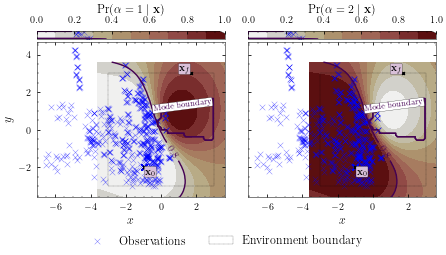

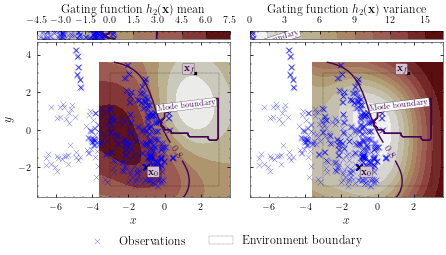

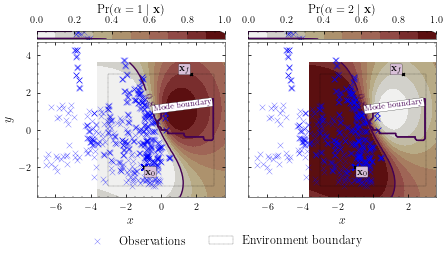

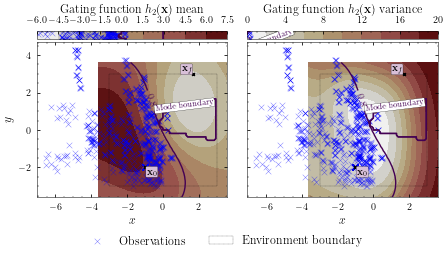

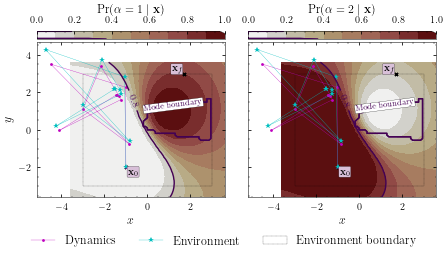

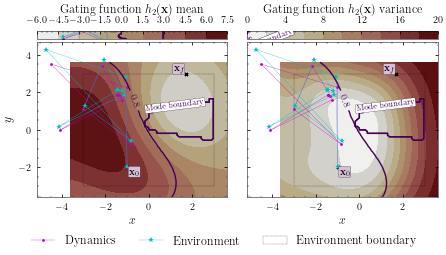

Epoch 1/10000
1/1 [==============================] - 2s 2s/step - loss: -389.7177 - val_loss: 51.2437
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_17_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -479.7278

2022-04-08 15:41:01.279685: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 15:41:01.279700: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -479.7278 - val_loss: -184.6149
Epoch 3/10000
1/1 [==============================] - 0s 38ms/step - loss: -404.8792 - val_loss: 174.8384
Epoch 4/10000
1/1 [==============================] - 0s 39ms/step - loss: -486.0090 - val_loss: -82.2287
Epoch 5/10000
1/1 [==============================] - ETA: 0s - loss: -489.6041

2022-04-08 15:41:03.341382: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 15:41:03.352882: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 15:41:03.360845: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_41_03

2022-04-08 15:41:03.367066: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_41_03/dr-robots-mbp.local.trace.json.gz
2022-04-08 15:41:03.390432: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_41_03

2022-04-08 15:41:03.390707: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

1/1 [==============================] - 0s 37ms/step - loss: -489.6041 - val_loss: -157.9145
Epoch 6/10000
1/1 [==============================] - 0s 39ms/step - loss: -478.7740 - val_loss: 46.5163
Epoch 7/10000
1/1 [==============================] - 0s 39ms/step - loss: -472.2141 - val_loss: -110.2453
Epoch 8/10000
1/1 [==============================] - 0s 40ms/step - loss: -320.5928 - val_loss: 291.4379
Epoch 9/10000
1/1 [==============================] - 0s 40ms/step - loss: -490.8621 - val_loss: -80.7975
Epoch 10/10000
1/1 [==============================] - 0s 41ms/step - loss: -402.5564 - val_loss: -12.6185
Epoch 11/10000
1/1 [==============================] - 0s 40ms/step - loss: -503.9818 - val_loss: -203.9379
Epoch 12/10000
1/1 [==============================] - 0s 40ms/step - loss: -487.1424 - val_loss: -179.8795
Epoch 13/10000
1/1 [==============================] - 0s 41ms/step - loss: -386.4132 - val_loss: 364.7704
Epoch 14/10000
1/1 [==============================] - 0s 42ms/

1/1 [==============================] - 0s 46ms/step - loss: -489.5318 - val_loss: 25.7889
Epoch 83/10000
1/1 [==============================] - 0s 44ms/step - loss: -476.1865 - val_loss: -230.7330
Epoch 84/10000
1/1 [==============================] - 0s 46ms/step - loss: -482.6407 - val_loss: -167.9085
Epoch 85/10000
1/1 [==============================] - 0s 45ms/step - loss: -432.3246 - val_loss: 352.1696
Epoch 86/10000
1/1 [==============================] - 0s 45ms/step - loss: -510.9798 - val_loss: -72.0571
Epoch 87/10000
1/1 [==============================] - 0s 47ms/step - loss: -455.4411 - val_loss: -230.8761
Epoch 88/10000
1/1 [==============================] - 0s 45ms/step - loss: -486.4186 - val_loss: -239.4952
Epoch 89/10000
1/1 [==============================] - 0s 45ms/step - loss: -485.5811 - val_loss: -28.4091
Epoch 90/10000
1/1 [==============================] - 0s 43ms/step - loss: -478.5046 - val_loss: -119.0735
Epoch 91/10000
1/1 [==============================] - 0s 

Epoch 159/10000
1/1 [==============================] - 0s 47ms/step - loss: -42.4197 - val_loss: 187.8331
Epoch 160/10000
1/1 [==============================] - 0s 48ms/step - loss: -211.2596 - val_loss: 32.2797
Epoch 161/10000
1/1 [==============================] - 0s 50ms/step - loss: -416.9502 - val_loss: -72.6508
Epoch 162/10000
1/1 [==============================] - 0s 52ms/step - loss: -387.1226 - val_loss: 72.4770
Epoch 163/10000
1/1 [==============================] - 0s 52ms/step - loss: -350.6261 - val_loss: 150.6164
Epoch 164/10000
1/1 [==============================] - 0s 48ms/step - loss: -199.8779 - val_loss: -46.8024
Epoch 165/10000
1/1 [==============================] - 0s 48ms/step - loss: -399.9806 - val_loss: 28.0745
Epoch 166/10000
1/1 [==============================] - 0s 48ms/step - loss: -467.3784 - val_loss: -106.5139
Epoch 167/10000
1/1 [==============================] - 0s 49ms/step - loss: -389.7963 - val_loss: -141.9577
Epoch 168/10000
1/1 [==================

1/1 [==============================] - 0s 46ms/step - loss: -452.7259 - val_loss: -207.1295
Epoch 236/10000
1/1 [==============================] - 0s 47ms/step - loss: -465.4451 - val_loss: 219.2672
Epoch 237/10000
1/1 [==============================] - 0s 46ms/step - loss: -446.7221 - val_loss: 174.9652
Epoch 238/10000
1/1 [==============================] - 0s 47ms/step - loss: -477.8806 - val_loss: -38.7040
Epoch 239/10000
1/1 [==============================] - 0s 48ms/step - loss: -479.4843 - val_loss: 149.0740
Epoch 240/10000
1/1 [==============================] - 0s 49ms/step - loss: -500.6984 - val_loss: -247.5599
Epoch 241/10000
1/1 [==============================] - 0s 45ms/step - loss: -456.3392 - val_loss: -56.0555
Epoch 242/10000
1/1 [==============================] - 0s 47ms/step - loss: -457.9789 - val_loss: -204.4277
Epoch 243/10000
1/1 [==============================] - 0s 47ms/step - loss: -503.1371 - val_loss: -155.4303
Epoch 244/10000
1/1 [============================

1/1 [==============================] - 0s 51ms/step - loss: -270.5291 - val_loss: -69.0172
Epoch 312/10000
1/1 [==============================] - 0s 50ms/step - loss: -474.5484 - val_loss: -130.0259
Epoch 313/10000
1/1 [==============================] - 0s 46ms/step - loss: -124.8788 - val_loss: 16.4475
Epoch 314/10000
1/1 [==============================] - 0s 49ms/step - loss: -283.2377 - val_loss: -108.4107
Epoch 315/10000
1/1 [==============================] - 0s 49ms/step - loss: -402.8889 - val_loss: -145.0750
Epoch 316/10000
1/1 [==============================] - 0s 47ms/step - loss: -311.9421 - val_loss: -252.7670
Epoch 317/10000
1/1 [==============================] - 0s 46ms/step - loss: -489.7386 - val_loss: -161.9707
Epoch 318/10000
1/1 [==============================] - 0s 46ms/step - loss: -431.5322 - val_loss: -115.2159
Epoch 319/10000
1/1 [==============================] - 0s 46ms/step - loss: -428.7265 - val_loss: -109.6963
Epoch 320/10000
1/1 [==========================

1/1 [==============================] - 0s 77ms/step - loss: -348.4570 - val_loss: -98.1473
Epoch 388/10000
1/1 [==============================] - 0s 75ms/step - loss: -498.4456 - val_loss: -41.7779
Epoch 389/10000
1/1 [==============================] - 0s 72ms/step - loss: -483.2131 - val_loss: -232.1237
Epoch 390/10000
1/1 [==============================] - 0s 64ms/step - loss: -517.4950 - val_loss: -88.8028
Epoch 391/10000
1/1 [==============================] - 0s 65ms/step - loss: -493.3572 - val_loss: -243.0717
Epoch 392/10000
1/1 [==============================] - 0s 74ms/step - loss: -516.1450 - val_loss: -248.6407
Epoch 393/10000
1/1 [==============================] - 0s 71ms/step - loss: -448.0231 - val_loss: 58.5458
Epoch 394/10000
1/1 [==============================] - 0s 62ms/step - loss: -515.9280 - val_loss: -189.7825
Epoch 395/10000
1/1 [==============================] - 0s 67ms/step - loss: -479.4389 - val_loss: -169.3977
Epoch 396/10000
1/1 [============================

1/1 [==============================] - 0s 60ms/step - loss: -545.4006 - val_loss: -225.1410
Epoch 464/10000
1/1 [==============================] - 0s 66ms/step - loss: -482.2724 - val_loss: -15.8350
Epoch 465/10000
1/1 [==============================] - 0s 60ms/step - loss: -293.9930 - val_loss: 186.9579
Epoch 466/10000
1/1 [==============================] - 0s 58ms/step - loss: -414.6279 - val_loss: 198.5914
Epoch 467/10000
1/1 [==============================] - 0s 57ms/step - loss: -472.4174 - val_loss: 18.2468
Epoch 468/10000
1/1 [==============================] - 0s 58ms/step - loss: -500.8890 - val_loss: -216.1516
Epoch 469/10000
1/1 [==============================] - 0s 55ms/step - loss: -540.0136 - val_loss: -155.3790
Epoch 470/10000
1/1 [==============================] - 0s 56ms/step - loss: -459.0289 - val_loss: 42.0971
Epoch 471/10000
1/1 [==============================] - 0s 57ms/step - loss: -485.0401 - val_loss: -274.3688
Epoch 472/10000
1/1 [==============================

1/1 [==============================] - 0s 65ms/step - loss: -436.8815 - val_loss: -181.2260
Epoch 540/10000
1/1 [==============================] - 0s 66ms/step - loss: -493.5678 - val_loss: 66.5619
Epoch 541/10000
1/1 [==============================] - 0s 63ms/step - loss: -446.9610 - val_loss: -240.4970
Epoch 542/10000
1/1 [==============================] - 0s 68ms/step - loss: -477.5063 - val_loss: -209.3775
Epoch 543/10000
1/1 [==============================] - 0s 70ms/step - loss: -518.5749 - val_loss: -228.2564
Epoch 544/10000
1/1 [==============================] - 0s 76ms/step - loss: -512.0838 - val_loss: -183.8949
Epoch 545/10000
1/1 [==============================] - 0s 73ms/step - loss: -401.5510 - val_loss: -230.2714
Epoch 546/10000
1/1 [==============================] - 0s 73ms/step - loss: -450.5937 - val_loss: -127.5059
Epoch 547/10000
1/1 [==============================] - 0s 83ms/step - loss: -527.0303 - val_loss: -254.7089
Epoch 548/10000
1/1 [=========================

1/1 [==============================] - 0s 65ms/step - loss: -448.9089 - val_loss: -151.0587
Epoch 616/10000
1/1 [==============================] - 0s 67ms/step - loss: -423.0610 - val_loss: -196.6522
Epoch 617/10000
1/1 [==============================] - 0s 68ms/step - loss: -483.9380 - val_loss: -71.0807
Epoch 618/10000
1/1 [==============================] - 0s 68ms/step - loss: -347.2572 - val_loss: -11.7254
Epoch 619/10000
1/1 [==============================] - 0s 67ms/step - loss: -492.0853 - val_loss: -61.2439
Epoch 620/10000
1/1 [==============================] - 0s 76ms/step - loss: -329.7653 - val_loss: -107.5110
Epoch 621/10000
1/1 [==============================] - 0s 66ms/step - loss: -434.8210 - val_loss: -188.6408
Epoch 622/10000
1/1 [==============================] - 0s 72ms/step - loss: -473.0646 - val_loss: -182.8291
Epoch 623/10000
1/1 [==============================] - 0s 64ms/step - loss: -378.6217 - val_loss: -97.0715
Epoch 624/10000
1/1 [===========================

1/1 [==============================] - 0s 56ms/step - loss: -478.4620 - val_loss: -230.8095
Epoch 692/10000
1/1 [==============================] - 0s 75ms/step - loss: -407.9683 - val_loss: -260.6222
Epoch 693/10000
1/1 [==============================] - 0s 62ms/step - loss: -364.8760 - val_loss: -245.7814
Epoch 694/10000
1/1 [==============================] - 0s 66ms/step - loss: -380.8306 - val_loss: 156.5423
Epoch 695/10000
1/1 [==============================] - 0s 66ms/step - loss: -414.0051 - val_loss: -246.7988
Epoch 696/10000
1/1 [==============================] - 0s 69ms/step - loss: -512.6044 - val_loss: -115.5125
Epoch 697/10000
1/1 [==============================] - 0s 62ms/step - loss: -413.5003 - val_loss: -242.5301
Epoch 698/10000
1/1 [==============================] - 0s 74ms/step - loss: -330.0336 - val_loss: -201.8986
Epoch 699/10000
1/1 [==============================] - 0s 69ms/step - loss: -433.9022 - val_loss: -58.7222
Epoch 700/10000
1/1 [=========================

1/1 [==============================] - 0s 50ms/step - loss: -443.1280 - val_loss: -105.1567
Epoch 768/10000
1/1 [==============================] - 0s 49ms/step - loss: -125.7744 - val_loss: 34.2835
Epoch 769/10000
1/1 [==============================] - 0s 51ms/step - loss: -479.5984 - val_loss: -139.5331
Epoch 770/10000
1/1 [==============================] - 0s 52ms/step - loss: -495.3313 - val_loss: -223.6267
Epoch 771/10000
1/1 [==============================] - 0s 51ms/step - loss: -489.6988 - val_loss: -272.3811
Epoch 772/10000
1/1 [==============================] - 0s 52ms/step - loss: -388.7763 - val_loss: -32.3586
Epoch 773/10000
1/1 [==============================] - 0s 50ms/step - loss: -362.2043 - val_loss: -173.3897
Epoch 774/10000
1/1 [==============================] - 0s 51ms/step - loss: -458.0300 - val_loss: -55.7952
Epoch 775/10000
1/1 [==============================] - 0s 50ms/step - loss: -318.2847 - val_loss: -135.1133
Epoch 776/10000
1/1 [===========================

1/1 [==============================] - 0s 59ms/step - loss: -409.4956 - val_loss: 330.0637
Epoch 844/10000
1/1 [==============================] - 0s 53ms/step - loss: -526.0885 - val_loss: -123.4161
Epoch 845/10000
1/1 [==============================] - 0s 58ms/step - loss: -478.9021 - val_loss: -120.7008
Epoch 846/10000
1/1 [==============================] - 0s 55ms/step - loss: -511.4294 - val_loss: -286.5486
Epoch 847/10000
1/1 [==============================] - 0s 53ms/step - loss: -496.8094 - val_loss: -139.3308
Epoch 848/10000
1/1 [==============================] - 0s 56ms/step - loss: -518.2324 - val_loss: -265.5967
Epoch 849/10000
1/1 [==============================] - 0s 54ms/step - loss: -492.3091 - val_loss: -206.3499
Epoch 850/10000
1/1 [==============================] - 0s 53ms/step - loss: -542.0931 - val_loss: -257.8224
Epoch 851/10000
1/1 [==============================] - 0s 52ms/step - loss: -514.3868 - val_loss: -44.3016
Epoch 852/10000
1/1 [=========================

1/1 [==============================] - 0s 55ms/step - loss: -424.9206 - val_loss: 26.2424
Epoch 920/10000
1/1 [==============================] - 0s 53ms/step - loss: -527.2992 - val_loss: -68.4610
Epoch 921/10000
1/1 [==============================] - 0s 54ms/step - loss: -426.8021 - val_loss: -178.7164
Epoch 922/10000
1/1 [==============================] - 0s 54ms/step - loss: -525.8670 - val_loss: -234.9257
Epoch 923/10000
1/1 [==============================] - 0s 53ms/step - loss: -416.5664 - val_loss: 183.7987
Epoch 924/10000
1/1 [==============================] - 0s 53ms/step - loss: -490.3356 - val_loss: 80.7743
Epoch 925/10000
1/1 [==============================] - 0s 53ms/step - loss: -491.4029 - val_loss: 106.6270
Epoch 926/10000
1/1 [==============================] - 0s 51ms/step - loss: -520.5138 - val_loss: -132.5937
Epoch 927/10000
1/1 [==============================] - 0s 53ms/step - loss: -526.3141 - val_loss: -73.8744
Epoch 928/10000
1/1 [==============================]

1/1 [==============================] - 0s 74ms/step - loss: -365.3198 - val_loss: -32.1571
Epoch 996/10000
1/1 [==============================] - 0s 65ms/step - loss: -234.6953 - val_loss: -37.5270
Epoch 997/10000
1/1 [==============================] - 0s 79ms/step - loss: -278.7928 - val_loss: -106.6788
Epoch 998/10000
1/1 [==============================] - 0s 78ms/step - loss: -316.5422 - val_loss: -28.0616
Epoch 999/10000
1/1 [==============================] - 0s 78ms/step - loss: -376.2479 - val_loss: -118.4509
Epoch 1000/10000
1/1 [==============================] - 0s 99ms/step - loss: -374.7469 - val_loss: -159.8849
Epoch 1001/10000
1/1 [==============================] - 0s 89ms/step - loss: 126.5944 - val_loss: 239.0484
Epoch 1002/10000
1/1 [==============================] - 0s 90ms/step - loss: -360.7126 - val_loss: -118.7862
Epoch 1003/10000
1/1 [==============================] - 0s 90ms/step - loss: -219.0351 - val_loss: -54.0426
Epoch 1004/10000
1/1 [========================

1/1 [==============================] - 0s 60ms/step - loss: -444.8246 - val_loss: -177.2578
Epoch 1071/10000
1/1 [==============================] - 0s 65ms/step - loss: -387.1866 - val_loss: 177.5156
Epoch 1072/10000
1/1 [==============================] - 0s 70ms/step - loss: -434.0059 - val_loss: -218.0674
Epoch 1073/10000
1/1 [==============================] - 0s 76ms/step - loss: -382.2618 - val_loss: -162.8491
Epoch 1074/10000
1/1 [==============================] - 0s 68ms/step - loss: -466.4295 - val_loss: -143.4895
Epoch 1075/10000
1/1 [==============================] - 0s 66ms/step - loss: -445.2481 - val_loss: -246.3194
Epoch 1076/10000
1/1 [==============================] - 0s 77ms/step - loss: -411.3332 - val_loss: -56.1326
Epoch 1077/10000
1/1 [==============================] - 0s 75ms/step - loss: -452.3167 - val_loss: -166.8378
Epoch 1078/10000
1/1 [==============================] - 0s 72ms/step - loss: -414.6467 - val_loss: -163.7034
Epoch 1079/10000
1/1 [================

Epoch 1146/10000
1/1 [==============================] - 0s 83ms/step - loss: -321.4411 - val_loss: -106.6062
Epoch 1147/10000
1/1 [==============================] - 0s 73ms/step - loss: -366.3988 - val_loss: 51.8659
Epoch 1148/10000
1/1 [==============================] - 0s 68ms/step - loss: -398.6733 - val_loss: 89.3797
Epoch 1149/10000
1/1 [==============================] - 0s 83ms/step - loss: -273.7285 - val_loss: 302.8993
Epoch 1150/10000
1/1 [==============================] - 0s 89ms/step - loss: -279.7577 - val_loss: -148.0830
Epoch 1151/10000
1/1 [==============================] - 0s 86ms/step - loss: -115.0491 - val_loss: 86.1025
Epoch 1152/10000
1/1 [==============================] - 0s 76ms/step - loss: -387.2973 - val_loss: -150.5583
Epoch 1153/10000
1/1 [==============================] - 0s 82ms/step - loss: -350.5940 - val_loss: -109.8547
Epoch 1154/10000
1/1 [==============================] - 0s 70ms/step - loss: -223.7402 - val_loss: -115.2704
Epoch 1155/10000
1/1 [====

1/1 [==============================] - 0s 90ms/step - loss: -443.2118 - val_loss: -184.5762
Epoch 1222/10000
1/1 [==============================] - 0s 84ms/step - loss: -425.3596 - val_loss: -200.0871
Epoch 1223/10000
1/1 [==============================] - 0s 73ms/step - loss: -378.5067 - val_loss: 294.0562
Epoch 1224/10000
1/1 [==============================] - 0s 79ms/step - loss: -374.9306 - val_loss: -5.4697
Epoch 1225/10000
1/1 [==============================] - 0s 85ms/step - loss: -330.8624 - val_loss: 50.7865
Epoch 1226/10000
1/1 [==============================] - 0s 93ms/step - loss: -378.7356 - val_loss: 13.9757
Epoch 1227/10000
1/1 [==============================] - 0s 84ms/step - loss: -411.9060 - val_loss: -187.0370
Epoch 1228/10000
1/1 [==============================] - 0s 92ms/step - loss: -458.6999 - val_loss: -140.9725
Epoch 1229/10000
1/1 [==============================] - 0s 85ms/step - loss: -383.9364 - val_loss: 207.1640
Epoch 1230/10000
1/1 [======================

Epoch 1296/10000
1/1 [==============================] - 0s 91ms/step - loss: -417.5831 - val_loss: -106.8939
Epoch 1297/10000
1/1 [==============================] - 0s 104ms/step - loss: -335.5030 - val_loss: -129.1550
Epoch 1298/10000
1/1 [==============================] - 0s 97ms/step - loss: -456.1616 - val_loss: -177.2519
Epoch 1299/10000
1/1 [==============================] - 0s 85ms/step - loss: 604.1159 - val_loss: 40.3561
Epoch 1300/10000
1/1 [==============================] - 0s 97ms/step - loss: -416.5517 - val_loss: -125.8429
Epoch 1301/10000
1/1 [==============================] - 0s 86ms/step - loss: -427.5336 - val_loss: -79.4799
Epoch 1302/10000
1/1 [==============================] - 0s 81ms/step - loss: -437.9529 - val_loss: -239.1673
Epoch 1303/10000
1/1 [==============================] - 0s 78ms/step - loss: -477.7437 - val_loss: 75.4647
Epoch 1304/10000
1/1 [==============================] - 0s 96ms/step - loss: -471.9579 - val_loss: -78.4003
Epoch 1305/10000
1/1 [===

Epoch 1371/10000
1/1 [==============================] - 0s 100ms/step - loss: 39.8990 - val_loss: -56.4525
Epoch 1372/10000
1/1 [==============================] - 0s 111ms/step - loss: -478.4704 - val_loss: -192.6831
Epoch 1373/10000
1/1 [==============================] - 0s 111ms/step - loss: -432.3982 - val_loss: 168.4180
Epoch 1374/10000
1/1 [==============================] - 0s 104ms/step - loss: -449.8093 - val_loss: -115.5725
Epoch 1375/10000
1/1 [==============================] - 0s 105ms/step - loss: -330.3279 - val_loss: -73.7015
Epoch 1376/10000
1/1 [==============================] - 0s 98ms/step - loss: -404.8128 - val_loss: 3.2564
Epoch 1377/10000
1/1 [==============================] - 0s 114ms/step - loss: -444.0475 - val_loss: -229.5880
Epoch 1378/10000
1/1 [==============================] - 0s 105ms/step - loss: -403.3560 - val_loss: -137.3519
Epoch 1379/10000
1/1 [==============================] - 0s 108ms/step - loss: -417.2513 - val_loss: -155.8674
Epoch 1380/10000
1/

cost
0.95428895174692729
entropy
-3.562901221723159
cost
0.95354410100835352
entropy
-3.5621471196472916
cost
0.95272061964789478
entropy
-3.5618002808031766
cost
0.95233710217393075
entropy
-3.5616466268844547
cost
0.95212133744869609
entropy
-3.5618710312397734
cost
0.95218449320292475
entropy
-3.5634380963039662
cost
0.95343023824513284
entropy
-3.5694210324480271
cost
0.9585176707021662
entropy
-3.5308555293733925
cost
0.97892085950129415
entropy
-3.5715494009674034
cost
0.96044444012921071
entropy
-3.5747507897863424
cost
0.96490588277080869
entropy
-3.5722530177792353
cost
0.961093720802491
entropy
-3.575198052030772
cost
0.96436811643428144
entropy
-3.5734613183560331
cost
0.96217293214679844
entropy
-3.5753738225900262
cost
0.96418947909579855
entropy
-3.5745514428470169
cost
0.96308590895579893
entropy
-3.5751740729873775
cost
0.96344582236006149
entropy
-3.5681602278416267
cost
0.9641812006580941
entropy
-3.5753206096185788
cost
0.96351646490517928
entropy
-3.5667112192145192

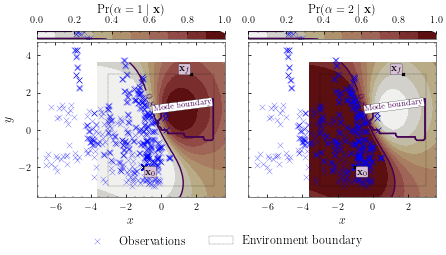

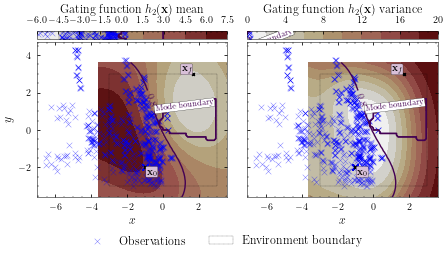

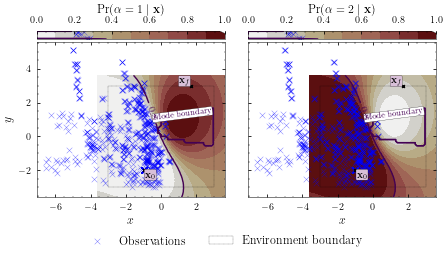

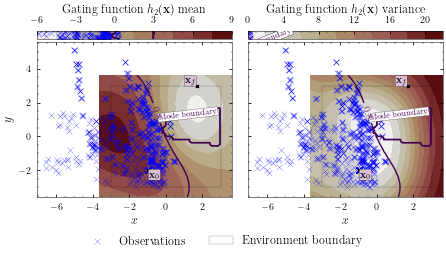

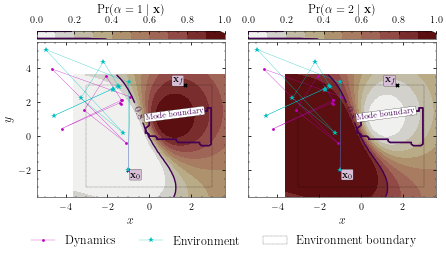

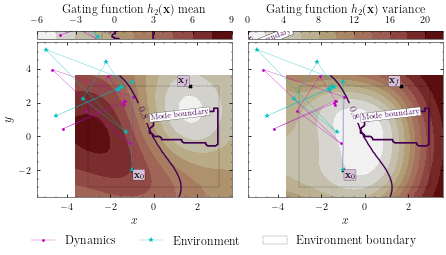

Epoch 1/10000
1/1 [==============================] - 4s 4s/step - loss: -289.3981 - val_loss: -104.9512
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-14-27/ckpts/step_18_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -440.7360

2022-04-08 15:47:30.607248: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 15:47:30.607272: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 12s 12s/step - loss: -440.7360 - val_loss: -111.4911


2022-04-08 15:47:42.078121: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 15:47:42.103090: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 15:47:42.127098: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_47_42

2022-04-08 15:47:42.138936: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_47_42/dr-robots-mbp.local.trace.json.gz
2022-04-08 15:47:42.183795: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bald/explorative-prob-0.8/2022-04-08-14-27/train/plugins/profile/2022_04_08_15_47_42

2022-04-08 15:47:42.184093: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dump

Epoch 3/10000
1/1 [==============================] - 0s 68ms/step - loss: -285.8345 - val_loss: -14.4797
Epoch 4/10000
1/1 [==============================] - 0s 59ms/step - loss: -409.9590 - val_loss: 301.5455
Epoch 5/10000
1/1 [==============================] - 0s 55ms/step - loss: -416.5359 - val_loss: -172.4318
Epoch 6/10000
1/1 [==============================] - 0s 55ms/step - loss: -455.0034 - val_loss: 227.6817
Epoch 7/10000
1/1 [==============================] - 0s 57ms/step - loss: -396.4722 - val_loss: -112.0717
Epoch 8/10000
1/1 [==============================] - 0s 57ms/step - loss: -404.5269 - val_loss: -1.8174
Epoch 9/10000
1/1 [==============================] - 0s 55ms/step - loss: -463.2310 - val_loss: -128.2554
Epoch 10/10000
1/1 [==============================] - 0s 53ms/step - loss: -486.5113 - val_loss: -181.0464
Epoch 11/10000
1/1 [==============================] - 0s 59ms/step - loss: -339.2903 - val_loss: 23.8894
Epoch 12/10000
1/1 [==============================]

1/1 [==============================] - 0s 44ms/step - loss: -465.9261 - val_loss: -118.7919
Epoch 81/10000
1/1 [==============================] - 0s 48ms/step - loss: -277.5165 - val_loss: -112.2354
Epoch 82/10000
1/1 [==============================] - 0s 46ms/step - loss: -388.8257 - val_loss: -112.4084
Epoch 83/10000
1/1 [==============================] - 0s 45ms/step - loss: -348.8203 - val_loss: -68.9662
Epoch 84/10000
1/1 [==============================] - 0s 47ms/step - loss: -475.0491 - val_loss: -159.3099
Epoch 85/10000
1/1 [==============================] - 0s 52ms/step - loss: -380.5791 - val_loss: 346.2993
Epoch 86/10000
1/1 [==============================] - 0s 46ms/step - loss: -396.0629 - val_loss: 39.4085
Epoch 87/10000
1/1 [==============================] - 0s 47ms/step - loss: -350.8477 - val_loss: -213.7188
Epoch 88/10000
1/1 [==============================] - 0s 44ms/step - loss: -261.0633 - val_loss: 313.3792
Epoch 89/10000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 49ms/step - loss: -489.0742 - val_loss: -141.1683
Epoch 157/10000
1/1 [==============================] - 0s 48ms/step - loss: -453.3774 - val_loss: 40.1739
Epoch 158/10000
1/1 [==============================] - 0s 47ms/step - loss: -439.6602 - val_loss: 34.2678
Epoch 159/10000
1/1 [==============================] - 0s 48ms/step - loss: -349.9136 - val_loss: 29.6285
Epoch 160/10000
1/1 [==============================] - 0s 50ms/step - loss: -293.8720 - val_loss: -66.8824
Epoch 161/10000
1/1 [==============================] - 0s 50ms/step - loss: -388.6421 - val_loss: -23.9295
Epoch 162/10000
1/1 [==============================] - 0s 48ms/step - loss: -469.6294 - val_loss: -41.1350
Epoch 163/10000
1/1 [==============================] - 0s 47ms/step - loss: -475.1169 - val_loss: -141.7509
Epoch 164/10000
1/1 [==============================] - 0s 48ms/step - loss: -500.6388 - val_loss: -127.8152
Epoch 165/10000
1/1 [==============================] 

1/1 [==============================] - 0s 47ms/step - loss: -533.9821 - val_loss: -196.6625
Epoch 233/10000
1/1 [==============================] - 0s 48ms/step - loss: -448.5769 - val_loss: -146.8895
Epoch 234/10000
1/1 [==============================] - 0s 47ms/step - loss: -480.2118 - val_loss: -83.1080
Epoch 235/10000
1/1 [==============================] - 0s 47ms/step - loss: -476.9847 - val_loss: -169.0391
Epoch 236/10000
1/1 [==============================] - 0s 48ms/step - loss: -504.1054 - val_loss: -185.7100
Epoch 237/10000
1/1 [==============================] - 0s 49ms/step - loss: -412.8342 - val_loss: -134.8885
Epoch 238/10000
1/1 [==============================] - 0s 48ms/step - loss: -424.6110 - val_loss: -99.1228
Epoch 239/10000
1/1 [==============================] - 0s 46ms/step - loss: -522.5650 - val_loss: -119.1680
Epoch 240/10000
1/1 [==============================] - 0s 49ms/step - loss: -447.6254 - val_loss: -127.7015
Epoch 241/10000
1/1 [=========================

1/1 [==============================] - 0s 57ms/step - loss: -472.2993 - val_loss: -146.4792
Epoch 309/10000
1/1 [==============================] - 0s 55ms/step - loss: -450.2687 - val_loss: -129.8770
Epoch 310/10000
1/1 [==============================] - 0s 55ms/step - loss: -433.8774 - val_loss: -172.2082
Epoch 311/10000
1/1 [==============================] - 0s 52ms/step - loss: -445.0855 - val_loss: -183.7396
Epoch 312/10000
1/1 [==============================] - 0s 52ms/step - loss: -429.4219 - val_loss: 53.2306
Epoch 313/10000
1/1 [==============================] - 0s 56ms/step - loss: -464.6495 - val_loss: -191.3641
Epoch 314/10000
1/1 [==============================] - 0s 56ms/step - loss: -471.0778 - val_loss: -176.0546
Epoch 315/10000
1/1 [==============================] - 0s 55ms/step - loss: -494.3666 - val_loss: -195.3048
Epoch 316/10000
1/1 [==============================] - 0s 54ms/step - loss: -411.8052 - val_loss: -4.1432
Epoch 317/10000
1/1 [===========================

1/1 [==============================] - 0s 52ms/step - loss: -479.3940 - val_loss: -64.0908
Epoch 385/10000
1/1 [==============================] - 0s 51ms/step - loss: -482.7586 - val_loss: -218.7148
Epoch 386/10000
1/1 [==============================] - 0s 50ms/step - loss: -474.3358 - val_loss: -177.5646
Epoch 387/10000
1/1 [==============================] - 0s 51ms/step - loss: -204.6685 - val_loss: 293.4021
Epoch 388/10000
1/1 [==============================] - 0s 51ms/step - loss: -484.2479 - val_loss: 168.5139
Epoch 389/10000
1/1 [==============================] - 0s 51ms/step - loss: -325.7186 - val_loss: 16.5392
Epoch 390/10000
1/1 [==============================] - 0s 51ms/step - loss: -338.2227 - val_loss: -166.9302
Epoch 391/10000
1/1 [==============================] - 0s 49ms/step - loss: -295.1333 - val_loss: 247.8223
Epoch 392/10000
1/1 [==============================] - 0s 51ms/step - loss: -438.8595 - val_loss: 66.6118
Epoch 393/10000
1/1 [==============================]

1/1 [==============================] - 0s 50ms/step - loss: -431.6227 - val_loss: -129.4914
Epoch 461/10000
1/1 [==============================] - 0s 52ms/step - loss: -417.5863 - val_loss: -41.1596
Epoch 462/10000
1/1 [==============================] - 0s 49ms/step - loss: -452.7817 - val_loss: -163.8496
Epoch 463/10000
1/1 [==============================] - 0s 49ms/step - loss: -427.4449 - val_loss: -94.3296
Epoch 464/10000
1/1 [==============================] - 0s 50ms/step - loss: -448.4631 - val_loss: -43.1817
Epoch 465/10000
1/1 [==============================] - 0s 48ms/step - loss: -326.1234 - val_loss: -69.4902
Epoch 466/10000
1/1 [==============================] - 0s 48ms/step - loss: -447.0416 - val_loss: -133.3306
Epoch 467/10000
1/1 [==============================] - 0s 48ms/step - loss: -427.9263 - val_loss: -42.4096
Epoch 468/10000
1/1 [==============================] - 0s 52ms/step - loss: -336.9724 - val_loss: 91.9932
Epoch 469/10000
1/1 [==============================

1/1 [==============================] - 0s 47ms/step - loss: -516.9567 - val_loss: -222.1219
Epoch 537/10000
1/1 [==============================] - 0s 47ms/step - loss: -463.5739 - val_loss: -192.6998
Epoch 538/10000
1/1 [==============================] - 0s 48ms/step - loss: -327.3132 - val_loss: -41.2667
Epoch 539/10000
1/1 [==============================] - 0s 49ms/step - loss: -363.4234 - val_loss: -57.8931
Epoch 540/10000
1/1 [==============================] - 0s 49ms/step - loss: -453.1054 - val_loss: -26.4558
Epoch 541/10000
1/1 [==============================] - 0s 48ms/step - loss: -432.4451 - val_loss: -242.8347
Epoch 542/10000
1/1 [==============================] - 0s 47ms/step - loss: -448.7986 - val_loss: 335.6003
Epoch 543/10000
1/1 [==============================] - 0s 49ms/step - loss: -216.5863 - val_loss: -244.3672
Epoch 544/10000
1/1 [==============================] - 0s 52ms/step - loss: -449.1706 - val_loss: -177.4562
Epoch 545/10000
1/1 [===========================

1/1 [==============================] - 0s 236ms/step - loss: -556.2511 - val_loss: -230.3540
Epoch 613/10000
1/1 [==============================] - 0s 50ms/step - loss: -549.0377 - val_loss: -147.1087
Epoch 614/10000
1/1 [==============================] - 0s 48ms/step - loss: -513.0803 - val_loss: -66.0956
Epoch 615/10000
1/1 [==============================] - 0s 49ms/step - loss: -297.0759 - val_loss: -217.2702
Epoch 616/10000
1/1 [==============================] - 0s 49ms/step - loss: -138.5906 - val_loss: -168.4355
Epoch 617/10000
1/1 [==============================] - 0s 47ms/step - loss: -431.3770 - val_loss: -110.8269
Epoch 618/10000
1/1 [==============================] - 0s 47ms/step - loss: -475.9771 - val_loss: 151.3383
Epoch 619/10000
1/1 [==============================] - 0s 47ms/step - loss: -382.3577 - val_loss: -17.0702
Epoch 620/10000
1/1 [==============================] - 0s 451ms/step - loss: -414.4189 - val_loss: 1.3785
Epoch 621/10000
1/1 [===========================

1/1 [==============================] - 0s 48ms/step - loss: -486.0342 - val_loss: -234.4900
Epoch 689/10000
1/1 [==============================] - 0s 47ms/step - loss: -466.8109 - val_loss: -218.2775
Epoch 690/10000
1/1 [==============================] - 0s 47ms/step - loss: -456.0744 - val_loss: -119.3268
Epoch 691/10000
1/1 [==============================] - 0s 47ms/step - loss: -509.3316 - val_loss: -218.5354
Epoch 692/10000
1/1 [==============================] - 0s 48ms/step - loss: -476.1984 - val_loss: -110.0801
Epoch 693/10000
1/1 [==============================] - 0s 49ms/step - loss: -444.0281 - val_loss: -61.4037
Epoch 694/10000
1/1 [==============================] - 0s 49ms/step - loss: -518.9174 - val_loss: -177.5389
Epoch 695/10000
1/1 [==============================] - 0s 48ms/step - loss: -464.5496 - val_loss: -144.0202
Epoch 696/10000
1/1 [==============================] - 0s 49ms/step - loss: -492.1615 - val_loss: -111.0555
Epoch 697/10000
1/1 [========================

1/1 [==============================] - 0s 49ms/step - loss: -479.4723 - val_loss: -236.8984
Epoch 765/10000
1/1 [==============================] - 0s 49ms/step - loss: -484.5288 - val_loss: -207.3966
Epoch 766/10000
1/1 [==============================] - 0s 48ms/step - loss: -549.1544 - val_loss: -187.5886
Epoch 767/10000
1/1 [==============================] - 0s 49ms/step - loss: -512.3049 - val_loss: 15.2182
Epoch 768/10000
1/1 [==============================] - 0s 49ms/step - loss: -559.7888 - val_loss: -153.7130
Epoch 769/10000
1/1 [==============================] - 0s 48ms/step - loss: -518.0530 - val_loss: -169.9862
Epoch 770/10000
1/1 [==============================] - 0s 48ms/step - loss: -435.4693 - val_loss: -84.3699
Epoch 771/10000
1/1 [==============================] - 0s 49ms/step - loss: -540.7833 - val_loss: -279.9468
Epoch 772/10000
1/1 [==============================] - 0s 47ms/step - loss: -532.8237 - val_loss: -178.3812
Epoch 773/10000
1/1 [==========================

1/1 [==============================] - 0s 57ms/step - loss: -530.8811 - val_loss: -155.6252
Epoch 841/10000
1/1 [==============================] - 0s 55ms/step - loss: -441.8569 - val_loss: -177.5644
Epoch 842/10000
1/1 [==============================] - 0s 59ms/step - loss: -445.0221 - val_loss: -183.1271
Epoch 843/10000
1/1 [==============================] - 0s 55ms/step - loss: -454.4050 - val_loss: -228.2362
Epoch 844/10000
1/1 [==============================] - 0s 59ms/step - loss: -503.7274 - val_loss: -205.7692
Epoch 845/10000
1/1 [==============================] - 0s 53ms/step - loss: -289.9414 - val_loss: 10.9017
Epoch 846/10000
1/1 [==============================] - 0s 54ms/step - loss: -523.2138 - val_loss: -118.2969
Epoch 847/10000
1/1 [==============================] - 0s 52ms/step - loss: -475.0168 - val_loss: -150.5487
Epoch 848/10000
1/1 [==============================] - 0s 72ms/step - loss: -487.2029 - val_loss: -183.7728
Epoch 849/10000
1/1 [=========================

1/1 [==============================] - 0s 51ms/step - loss: -431.2371 - val_loss: -245.7506
Epoch 917/10000
1/1 [==============================] - 0s 51ms/step - loss: -496.8174 - val_loss: -151.6266
Epoch 918/10000
1/1 [==============================] - 0s 51ms/step - loss: -481.9916 - val_loss: -210.1106
Epoch 919/10000
1/1 [==============================] - 0s 52ms/step - loss: -483.6158 - val_loss: -204.7479
Epoch 920/10000
1/1 [==============================] - 0s 54ms/step - loss: -426.3176 - val_loss: -66.8205
Epoch 921/10000
1/1 [==============================] - 0s 51ms/step - loss: -521.4466 - val_loss: -17.8876
Epoch 922/10000
1/1 [==============================] - 0s 51ms/step - loss: -512.4405 - val_loss: -204.8981
Epoch 923/10000
1/1 [==============================] - 0s 50ms/step - loss: -434.3985 - val_loss: -215.4764
Epoch 924/10000
1/1 [==============================] - 0s 51ms/step - loss: -488.6004 - val_loss: -207.3572
Epoch 925/10000
1/1 [=========================

1/1 [==============================] - 0s 51ms/step - loss: -458.1528 - val_loss: -210.9410
Epoch 993/10000
1/1 [==============================] - 0s 51ms/step - loss: -397.4694 - val_loss: -119.7484
Epoch 994/10000
1/1 [==============================] - 0s 51ms/step - loss: -521.2337 - val_loss: -211.9487
Epoch 995/10000
1/1 [==============================] - 0s 50ms/step - loss: -465.7151 - val_loss: -103.6708
Epoch 996/10000
1/1 [==============================] - 0s 51ms/step - loss: -530.9346 - val_loss: -181.4599
Epoch 997/10000
1/1 [==============================] - 0s 52ms/step - loss: -385.8341 - val_loss: -187.3186
Epoch 998/10000
1/1 [==============================] - 0s 52ms/step - loss: -437.5202 - val_loss: -67.0351
Epoch 999/10000
1/1 [==============================] - 0s 51ms/step - loss: -442.9354 - val_loss: 78.3156
Epoch 1000/10000
1/1 [==============================] - 0s 51ms/step - loss: -481.1716 - val_loss: -213.2263
Epoch 1001/10000
1/1 [========================

1/1 [==============================] - 0s 55ms/step - loss: -512.4104 - val_loss: -125.7861
Epoch 1068/10000
1/1 [==============================] - 0s 59ms/step - loss: -366.2610 - val_loss: -232.6032
Epoch 1069/10000
1/1 [==============================] - 0s 58ms/step - loss: -367.2938 - val_loss: -120.9469
Epoch 1070/10000
1/1 [==============================] - 0s 59ms/step - loss: -531.5700 - val_loss: -169.4325
Epoch 1071/10000
1/1 [==============================] - 0s 55ms/step - loss: -494.6846 - val_loss: -127.2039
Epoch 1072/10000
1/1 [==============================] - 0s 54ms/step - loss: -357.9278 - val_loss: -163.5758
Epoch 1073/10000
1/1 [==============================] - 0s 56ms/step - loss: -412.5399 - val_loss: -186.4710
Epoch 1074/10000
1/1 [==============================] - 0s 57ms/step - loss: -456.0210 - val_loss: -147.8476
Epoch 1075/10000
1/1 [==============================] - 0s 57ms/step - loss: -461.4134 - val_loss: -192.5381
Epoch 1076/10000
1/1 [==============


KeyboardInterrupt



Error in callback <function flush_figures at 0x19276b430> (for post_execute):



KeyboardInterrupt



In [27]:
for step in range(1, num_steps):
    new_dataset = mode_optimiser.explore_env()
    mode_optimiser.update_dataset(new_dataset)
    mode_optimiser.dynamics_fit_kwargs.update({"batch_size": mode_optimiser.dataset[0].shape[0]})
    print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
    plot_data_over_gating_network_and_save(step=step, epoch=0, save=False)
    plot_trajectories_over_gating_network_and_save(step=step, save=True)
    plt.show()
    mode_optimiser.optimise_dynamics()

In [ ]:
# for step in range(num_steps, num_steps*2):
#     new_dataset = mode_optimiser.explore_env()
#     mode_optimiser.update_dataset(new_dataset)
#     batch_size = mode_optimiser.dataset[0].shape[0]
#     mode_optimiser.dynamics_fit_kwargs.update({"epochs": num_epochs, "batch_size": batch_size, "validation_split": 0.2})
#     print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
#     plot_data_over_gating_network_and_save(step=step, epoch=0, save=False)
#     plot_trajectories_over_gating_network_and_save(step=step, save=True)
#     plt.show()
#     mode_optimiser.optimise_dynamics()

In [ ]:
state_diff_cost_matrix